In [ ]:
import os
import copy
import pickle
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from transformers import AutoImageProcessor, AutoModelForImageClassification

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score, f1_score


def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.logits, dim=1)
    correct = (predicted == labels).sum().item()
    return correct / len(labels)


class ImageClassifierTrainer:
    def __init__(self, train_data, val_data, model_name, identifier="fold",
                 num_labels=5, lr=5e-5, batch_size=32):
        self.train_x, self.train_y = train_data
        self.val_x, self.val_y = val_data
        self.num_labels = num_labels
        self.lr = lr
        self.batch_size = batch_size
        self.identifier = identifier
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        if self.train_x.ndim != 5:
            raise ValueError("Expected train_x => (samples, frames, H, W, C)")

        self.frames_per_sample = self.train_x.shape[1]
        self.best_epoch_this_phase = 0

        self.processor = AutoImageProcessor.from_pretrained(model_name)
        self.model = AutoModelForImageClassification.from_pretrained(model_name)
        self.model.classifier = nn.Linear(self.model.config.hidden_size, self.num_labels)
        self.model.num_labels = self.num_labels
        self.model.to(self.device)

        self.optimizer = optim.AdamW(self.model.parameters(), lr=self.lr)

        self.train_loader = self._make_dataloader(self.train_x, self.train_y, shuffle=True)
        self.val_loader = self._make_dataloader(self.val_x, self.val_y, shuffle=False)

    def _make_dataloader(self, x, y, shuffle=True):
        pixel_values_list = []
        for i in range(x.shape[0]):
            frames = x[i]
            for frame in frames:
                proc = self.processor(images=frame, return_tensors="pt")
                pixel_values_list.append(proc["pixel_values"].squeeze(0))

        pixel_values = torch.stack(pixel_values_list, dim=0)
        repeated_labels = np.repeat(y, self.frames_per_sample)
        repeated_labels = torch.from_numpy(repeated_labels).long()

        dataset = TensorDataset(pixel_values, repeated_labels)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=shuffle)
        return loader

    def freeze_backbone(self, freeze=True):
        for param in self.model.parameters():
            param.requires_grad = not freeze
        for param in self.model.classifier.parameters():
            param.requires_grad = True

    def train_loop(self, epochs=15, freeze=True, patience=5):
        phase_desc = "FROZEN" if freeze else "UNFROZEN"
        print(f"[{self.identifier}] => {phase_desc} training: epochs={epochs}, patience={patience}")

        if isinstance(self.model, nn.DataParallel):
            self.model = self.model.module

        self.freeze_backbone(freeze=freeze)

        if torch.cuda.device_count() > 1:
            self.model = nn.DataParallel(self.model)

        best_val_loss = float("inf")
        best_weights = copy.deepcopy(self.model.state_dict())
        best_epoch = 0
        epochs_no_improve = 0

        for epoch in range(1, epochs + 1):
            self.model.train()
            for pixel_values, labels in self.train_loader:
                pixel_values = pixel_values.to(self.device)
                labels = labels.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(pixel_values=pixel_values, labels=labels)
                loss = outputs.loss
                if loss.dim() > 0:
                    loss = loss.mean()
                loss.backward()
                self.optimizer.step()

            val_loss = self.evaluate_val_loss()
            print(f"[{self.identifier}] epoch={epoch}/{epochs} => val_loss={val_loss:.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_weights = copy.deepcopy(self.model.state_dict())
                best_epoch = epoch
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f"[{self.identifier}] Early stopping at epoch={epoch} (no improvement in {patience} epochs).")
                    break

        self.model.load_state_dict(best_weights)
        print(f"[{self.identifier}] => best_val_loss={best_val_loss:.4f} at epoch={best_epoch}")

        self.best_epoch_this_phase = best_epoch
        return best_epoch

    def evaluate_val_loss(self):
        self.model.eval()
        total_loss = 0.0
        total_batches = 0

        with torch.no_grad():
            for pixel_values, labels in self.val_loader:
                pixel_values, labels = pixel_values.to(self.device), labels.to(self.device)
                outputs = self.model(pixel_values=pixel_values, labels=labels)
                loss = outputs.loss
                if loss.dim() > 0:
                    loss = loss.mean()
                total_loss += loss.item()
                total_batches += 1

        if total_batches == 0:
            return 999999.0
        return total_loss / total_batches

    def predict_sample_level(self, x, y):
        loader = self._make_dataloader(x, y, shuffle=False)
        all_logits = []

        self.model.eval()
        with torch.no_grad():
            for pixel_values, labels in loader:
                pixel_values = pixel_values.to(self.device)
                outputs = self.model(pixel_values=pixel_values)
                all_logits.append(outputs.logits.cpu().numpy())

        all_logits = np.concatenate(all_logits, axis=0)
        n_samples = x.shape[0]
        frames_per_sample = x.shape[1]

        all_logits = all_logits.reshape(n_samples, frames_per_sample, -1)
        avg_logits = all_logits.mean(axis=1)
        preds = np.argmax(avg_logits, axis=1)

        acc = accuracy_score(y, preds)
        f1 = f1_score(y, preds, average='weighted')
        return acc, f1


def cross_validate(train_x, train_y, model_path, k=5, patience=5):
    sss = StratifiedShuffleSplit(n_splits=k, test_size=0.3, random_state=42)
    epoch_sums = []

    for fold_id, (train_idx, val_idx) in enumerate(sss.split(train_x, train_y), start=1):
        trainer = ImageClassifierTrainer(
            train_data=(train_x[train_idx], train_y[train_idx]),
            val_data=(train_x[val_idx], train_y[val_idx]),
            model_name=model_path,
            identifier=f"Fold_{fold_id}"
        )

        print(f"\n=== Fold_{fold_id}: FREEZE PHASE ===")
        best_epoch_freeze = trainer.train_loop(epochs=15, freeze=True, patience=patience)
        print(f"Fold_{fold_id} freeze best epoch => {best_epoch_freeze}")

        print(f"\n=== Fold_{fold_id}: UNFREEZE PHASE ===")
        best_epoch_unfreeze = trainer.train_loop(epochs=15, freeze=False, patience=patience)
        print(f"Fold_{fold_id} unfreeze best epoch => {best_epoch_unfreeze}")

        total_this_fold = best_epoch_freeze + best_epoch_unfreeze
        epoch_sums.append(total_this_fold)

    median_epochs = int(np.median(epoch_sums))
    print(f"\nSum of best epochs (freeze+unfreeze) each fold => {epoch_sums}")
    print(f"Median total epochs used across folds = {median_epochs}\n")
    return median_epochs


def main():
    data_dir = "/content/drive/MyDrive/kk/Input_images/Vision"
    model_path = "google/vit-base-patch16-224-in21k"

    all_files = sorted([f for f in os.listdir(data_dir) if f.lower().endswith(".pkl")])
    print(f"Found {len(all_files)} .pkl files in {data_dir}.")

    overall_test_accs = []
    overall_test_f1s = []

    for file_name in all_files:
        with open(os.path.join(data_dir, file_name), 'rb') as f:
            train_x, train_y, test_x, test_y = pickle.load(f)

        print(f"\n=== {file_name} ===")
        median_epochs = cross_validate(train_x, train_y, model_path, k=5, patience=5)

        train_final_x, val_final_x, train_final_y, val_final_y = train_test_split(
            train_x, train_y, test_size=0.2, stratify=train_y, random_state=42
        )

        freeze_epochs = max(1, median_epochs )
        unfreeze_epochs = max(1, median_epochs)

        print(f"Final training on 80% train / 20% val (with early stopping).")
        print(f"Freeze={freeze_epochs}, Unfreeze={unfreeze_epochs}")

        final_trainer = ImageClassifierTrainer(
            train_data=(train_final_x, train_final_y),
            val_data=(val_final_x, val_final_y),
            model_name=model_path,
            identifier=f"Final_{file_name}",
            num_labels=5,
            lr=5e-5,
            batch_size=128
        )

        final_trainer.train_loop(epochs=freeze_epochs, freeze=True, patience=5)
        final_trainer.train_loop(epochs=unfreeze_epochs, freeze=False, patience=5)

        test_acc, test_f1 = final_trainer.predict_sample_level(test_x, test_y)
        print(f"[{file_name}] => Final Test => ACC={test_acc*100:.2f}%, F1={test_f1:.4f}")

        overall_test_accs.append(test_acc)
        overall_test_f1s.append(test_f1)

    if overall_test_accs:
        print("\n=== Overall Test Results ===")
        print(f"Mean ACC = {np.mean(overall_test_accs)*100:.2f}%")
        print(f"Mean F1  = {np.mean(overall_test_f1s):.4f}")
    else:
        print("No valid results to summarize.")


if __name__ == "__main__":
    main()


Found 42 .pkl files in /content/drive/MyDrive/kk/Input_images/Vision.

=== subject_01_vis.pkl ===


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Fold_1: FREEZE PHASE ===
[Fold_1] => FROZEN training: epochs=15, patience=5
[Fold_1] epoch=1/15 => val_loss=1.5564
[Fold_1] epoch=2/15 => val_loss=1.5091
[Fold_1] epoch=3/15 => val_loss=1.4655
[Fold_1] epoch=4/15 => val_loss=1.4271
[Fold_1] epoch=5/15 => val_loss=1.3918
[Fold_1] epoch=6/15 => val_loss=1.3605
[Fold_1] epoch=7/15 => val_loss=1.3314
[Fold_1] epoch=8/15 => val_loss=1.3049
[Fold_1] epoch=9/15 => val_loss=1.2810
[Fold_1] epoch=10/15 => val_loss=1.2585
[Fold_1] epoch=11/15 => val_loss=1.2385
[Fold_1] epoch=12/15 => val_loss=1.2197
[Fold_1] epoch=13/15 => val_loss=1.2021
[Fold_1] epoch=14/15 => val_loss=1.1864
[Fold_1] epoch=15/15 => val_loss=1.1712
[Fold_1] => best_val_loss=1.1712 at epoch=15
Fold_1 freeze best epoch => 15

=== Fold_1: UNFREEZE PHASE ===
[Fold_1] => UNFROZEN training: epochs=15, patience=5
[Fold_1] epoch=1/15 => val_loss=0.3188
[Fold_1] epoch=2/15 => val_loss=0.2522
[Fold_1] epoch=3/15 => val_loss=0.3192
[Fold_1] epoch=4/15 => val_loss=0.1842
[Fold_1] ep

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Fold_2: FREEZE PHASE ===
[Fold_2] => FROZEN training: epochs=15, patience=5
[Fold_2] epoch=1/15 => val_loss=1.5457
[Fold_2] epoch=2/15 => val_loss=1.4988
[Fold_2] epoch=3/15 => val_loss=1.4573
[Fold_2] epoch=4/15 => val_loss=1.4196
[Fold_2] epoch=5/15 => val_loss=1.3855
[Fold_2] epoch=6/15 => val_loss=1.3540
[Fold_2] epoch=7/15 => val_loss=1.3260
[Fold_2] epoch=8/15 => val_loss=1.3004
[Fold_2] epoch=9/15 => val_loss=1.2771
[Fold_2] epoch=10/15 => val_loss=1.2555
[Fold_2] epoch=11/15 => val_loss=1.2365
[Fold_2] epoch=12/15 => val_loss=1.2180
[Fold_2] epoch=13/15 => val_loss=1.1998
[Fold_2] epoch=14/15 => val_loss=1.1841
[Fold_2] epoch=15/15 => val_loss=1.1699
[Fold_2] => best_val_loss=1.1699 at epoch=15
Fold_2 freeze best epoch => 15

=== Fold_2: UNFREEZE PHASE ===
[Fold_2] => UNFROZEN training: epochs=15, patience=5
[Fold_2] epoch=1/15 => val_loss=0.4167
[Fold_2] epoch=2/15 => val_loss=0.4464
[Fold_2] epoch=3/15 => val_loss=0.5132
[Fold_2] epoch=4/15 => val_loss=0.3717
[Fold_2] ep

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Fold_3: FREEZE PHASE ===
[Fold_3] => FROZEN training: epochs=15, patience=5
[Fold_3] epoch=1/15 => val_loss=1.5581
[Fold_3] epoch=2/15 => val_loss=1.5128
[Fold_3] epoch=3/15 => val_loss=1.4728
[Fold_3] epoch=4/15 => val_loss=1.4359
[Fold_3] epoch=5/15 => val_loss=1.4020
[Fold_3] epoch=6/15 => val_loss=1.3716
[Fold_3] epoch=7/15 => val_loss=1.3442
[Fold_3] epoch=8/15 => val_loss=1.3191
[Fold_3] epoch=9/15 => val_loss=1.2957
[Fold_3] epoch=10/15 => val_loss=1.2766
[Fold_3] epoch=11/15 => val_loss=1.2567
[Fold_3] epoch=12/15 => val_loss=1.2380
[Fold_3] epoch=13/15 => val_loss=1.2206
[Fold_3] epoch=14/15 => val_loss=1.2058
[Fold_3] epoch=15/15 => val_loss=1.1912
[Fold_3] => best_val_loss=1.1912 at epoch=15
Fold_3 freeze best epoch => 15

=== Fold_3: UNFREEZE PHASE ===
[Fold_3] => UNFROZEN training: epochs=15, patience=5
[Fold_3] epoch=1/15 => val_loss=0.2940
[Fold_3] epoch=2/15 => val_loss=0.3157
[Fold_3] epoch=3/15 => val_loss=0.2847
[Fold_3] epoch=4/15 => val_loss=0.3772
[Fold_3] ep

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Fold_4: FREEZE PHASE ===
[Fold_4] => FROZEN training: epochs=15, patience=5
[Fold_4] epoch=1/15 => val_loss=1.5631
[Fold_4] epoch=2/15 => val_loss=1.5187
[Fold_4] epoch=3/15 => val_loss=1.4789
[Fold_4] epoch=4/15 => val_loss=1.4421
[Fold_4] epoch=5/15 => val_loss=1.4099
[Fold_4] epoch=6/15 => val_loss=1.3803
[Fold_4] epoch=7/15 => val_loss=1.3540
[Fold_4] epoch=8/15 => val_loss=1.3291
[Fold_4] epoch=9/15 => val_loss=1.3061
[Fold_4] epoch=10/15 => val_loss=1.2853
[Fold_4] epoch=11/15 => val_loss=1.2663
[Fold_4] epoch=12/15 => val_loss=1.2487
[Fold_4] epoch=13/15 => val_loss=1.2312
[Fold_4] epoch=14/15 => val_loss=1.2157
[Fold_4] epoch=15/15 => val_loss=1.1997
[Fold_4] => best_val_loss=1.1997 at epoch=15
Fold_4 freeze best epoch => 15

=== Fold_4: UNFREEZE PHASE ===
[Fold_4] => UNFROZEN training: epochs=15, patience=5
[Fold_4] epoch=1/15 => val_loss=0.4019
[Fold_4] epoch=2/15 => val_loss=0.3953
[Fold_4] epoch=3/15 => val_loss=0.3024
[Fold_4] epoch=4/15 => val_loss=0.3511
[Fold_4] ep

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Fold_5: FREEZE PHASE ===
[Fold_5] => FROZEN training: epochs=15, patience=5
[Fold_5] epoch=1/15 => val_loss=1.5590
[Fold_5] epoch=2/15 => val_loss=1.5171
[Fold_5] epoch=3/15 => val_loss=1.4789
[Fold_5] epoch=4/15 => val_loss=1.4451
[Fold_5] epoch=5/15 => val_loss=1.4142
[Fold_5] epoch=6/15 => val_loss=1.3868
[Fold_5] epoch=7/15 => val_loss=1.3612
[Fold_5] epoch=8/15 => val_loss=1.3390
[Fold_5] epoch=9/15 => val_loss=1.3175
[Fold_5] epoch=10/15 => val_loss=1.2993
[Fold_5] epoch=11/15 => val_loss=1.2816
[Fold_5] epoch=12/15 => val_loss=1.2653
[Fold_5] epoch=13/15 => val_loss=1.2507
[Fold_5] epoch=14/15 => val_loss=1.2365
[Fold_5] epoch=15/15 => val_loss=1.2237
[Fold_5] => best_val_loss=1.2237 at epoch=15
Fold_5 freeze best epoch => 15

=== Fold_5: UNFREEZE PHASE ===
[Fold_5] => UNFROZEN training: epochs=15, patience=5
[Fold_5] epoch=1/15 => val_loss=0.6095
[Fold_5] epoch=2/15 => val_loss=0.4393
[Fold_5] epoch=3/15 => val_loss=0.3636
[Fold_5] epoch=4/15 => val_loss=0.5003
[Fold_5] ep

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Final_subject_01_vis.pkl] => FROZEN training: epochs=21, patience=5
[Final_subject_01_vis.pkl] epoch=1/21 => val_loss=1.5899
[Final_subject_01_vis.pkl] epoch=2/21 => val_loss=1.5663
[Final_subject_01_vis.pkl] epoch=3/21 => val_loss=1.5441
[Final_subject_01_vis.pkl] epoch=4/21 => val_loss=1.5233
[Final_subject_01_vis.pkl] epoch=5/21 => val_loss=1.5029
[Final_subject_01_vis.pkl] epoch=6/21 => val_loss=1.4832
[Final_subject_01_vis.pkl] epoch=7/21 => val_loss=1.4645
[Final_subject_01_vis.pkl] epoch=8/21 => val_loss=1.4466
[Final_subject_01_vis.pkl] epoch=9/21 => val_loss=1.4294
[Final_subject_01_vis.pkl] epoch=10/21 => val_loss=1.4126
[Final_subject_01_vis.pkl] epoch=11/21 => val_loss=1.3968
[Final_subject_01_vis.pkl] epoch=12/21 => val_loss=1.3816
[Final_subject_01_vis.pkl] epoch=13/21 => val_loss=1.3668
[Final_subject_01_vis.pkl] epoch=14/21 => val_loss=1.3525
[Final_subject_01_vis.pkl] epoch=15/21 => val_loss=1.3386
[Final_subject_01_vis.pkl] epoch=16/21 => val_loss=1.3256
[Final_subje

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Fold_1: FREEZE PHASE ===
[Fold_1] => FROZEN training: epochs=15, patience=5
[Fold_1] epoch=1/15 => val_loss=1.5485
[Fold_1] epoch=2/15 => val_loss=1.4986
[Fold_1] epoch=3/15 => val_loss=1.4548
[Fold_1] epoch=4/15 => val_loss=1.4173
[Fold_1] epoch=5/15 => val_loss=1.3842
[Fold_1] epoch=6/15 => val_loss=1.3549
[Fold_1] epoch=7/15 => val_loss=1.3294
[Fold_1] epoch=8/15 => val_loss=1.3065
[Fold_1] epoch=9/15 => val_loss=1.2858
[Fold_1] epoch=10/15 => val_loss=1.2673
[Fold_1] epoch=11/15 => val_loss=1.2509
[Fold_1] epoch=12/15 => val_loss=1.2348
[Fold_1] epoch=13/15 => val_loss=1.2208
[Fold_1] epoch=14/15 => val_loss=1.2077
[Fold_1] epoch=15/15 => val_loss=1.1957
[Fold_1] => best_val_loss=1.1957 at epoch=15
Fold_1 freeze best epoch => 15

=== Fold_1: UNFREEZE PHASE ===
[Fold_1] => UNFROZEN training: epochs=15, patience=5
[Fold_1] epoch=1/15 => val_loss=0.3964
[Fold_1] epoch=2/15 => val_loss=0.3447
[Fold_1] epoch=3/15 => val_loss=0.3021
[Fold_1] epoch=4/15 => val_loss=0.3704
[Fold_1] ep

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Fold_2: FREEZE PHASE ===
[Fold_2] => FROZEN training: epochs=15, patience=5
[Fold_2] epoch=1/15 => val_loss=1.5402
[Fold_2] epoch=2/15 => val_loss=1.4845
[Fold_2] epoch=3/15 => val_loss=1.4347
[Fold_2] epoch=4/15 => val_loss=1.3917
[Fold_2] epoch=5/15 => val_loss=1.3539
[Fold_2] epoch=6/15 => val_loss=1.3209
[Fold_2] epoch=7/15 => val_loss=1.2917
[Fold_2] epoch=8/15 => val_loss=1.2650
[Fold_2] epoch=9/15 => val_loss=1.2414
[Fold_2] epoch=10/15 => val_loss=1.2203
[Fold_2] epoch=11/15 => val_loss=1.2008
[Fold_2] epoch=12/15 => val_loss=1.1832
[Fold_2] epoch=13/15 => val_loss=1.1670
[Fold_2] epoch=14/15 => val_loss=1.1519
[Fold_2] epoch=15/15 => val_loss=1.1388
[Fold_2] => best_val_loss=1.1388 at epoch=15
Fold_2 freeze best epoch => 15

=== Fold_2: UNFREEZE PHASE ===
[Fold_2] => UNFROZEN training: epochs=15, patience=5
[Fold_2] epoch=1/15 => val_loss=0.4445
[Fold_2] epoch=2/15 => val_loss=0.3793
[Fold_2] epoch=3/15 => val_loss=0.1614
[Fold_2] epoch=4/15 => val_loss=0.2930
[Fold_2] ep

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Fold_3: FREEZE PHASE ===
[Fold_3] => FROZEN training: epochs=15, patience=5
[Fold_3] epoch=1/15 => val_loss=1.5555
[Fold_3] epoch=2/15 => val_loss=1.5088
[Fold_3] epoch=3/15 => val_loss=1.4674
[Fold_3] epoch=4/15 => val_loss=1.4312
[Fold_3] epoch=5/15 => val_loss=1.4007
[Fold_3] epoch=6/15 => val_loss=1.3735
[Fold_3] epoch=7/15 => val_loss=1.3494
[Fold_3] epoch=8/15 => val_loss=1.3280
[Fold_3] epoch=9/15 => val_loss=1.3087
[Fold_3] epoch=10/15 => val_loss=1.2918
[Fold_3] epoch=11/15 => val_loss=1.2763
[Fold_3] epoch=12/15 => val_loss=1.2620
[Fold_3] epoch=13/15 => val_loss=1.2487
[Fold_3] epoch=14/15 => val_loss=1.2367
[Fold_3] epoch=15/15 => val_loss=1.2249
[Fold_3] => best_val_loss=1.2249 at epoch=15
Fold_3 freeze best epoch => 15

=== Fold_3: UNFREEZE PHASE ===
[Fold_3] => UNFROZEN training: epochs=15, patience=5
[Fold_3] epoch=1/15 => val_loss=0.6294
[Fold_3] epoch=2/15 => val_loss=0.2543
[Fold_3] epoch=3/15 => val_loss=0.1897
[Fold_3] epoch=4/15 => val_loss=0.4097
[Fold_3] ep

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Fold_4: FREEZE PHASE ===
[Fold_4] => FROZEN training: epochs=15, patience=5
[Fold_4] epoch=1/15 => val_loss=1.5608
[Fold_4] epoch=2/15 => val_loss=1.5149
[Fold_4] epoch=3/15 => val_loss=1.4756
[Fold_4] epoch=4/15 => val_loss=1.4409
[Fold_4] epoch=5/15 => val_loss=1.4110
[Fold_4] epoch=6/15 => val_loss=1.3848
[Fold_4] epoch=7/15 => val_loss=1.3622
[Fold_4] epoch=8/15 => val_loss=1.3409
[Fold_4] epoch=9/15 => val_loss=1.3228
[Fold_4] epoch=10/15 => val_loss=1.3064
[Fold_4] epoch=11/15 => val_loss=1.2904
[Fold_4] epoch=12/15 => val_loss=1.2772
[Fold_4] epoch=13/15 => val_loss=1.2645
[Fold_4] epoch=14/15 => val_loss=1.2530
[Fold_4] epoch=15/15 => val_loss=1.2425
[Fold_4] => best_val_loss=1.2425 at epoch=15
Fold_4 freeze best epoch => 15

=== Fold_4: UNFREEZE PHASE ===
[Fold_4] => UNFROZEN training: epochs=15, patience=5
[Fold_4] epoch=1/15 => val_loss=0.4151
[Fold_4] epoch=2/15 => val_loss=0.4344
[Fold_4] epoch=3/15 => val_loss=0.2897
[Fold_4] epoch=4/15 => val_loss=0.2519
[Fold_4] ep

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Fold_5: FREEZE PHASE ===
[Fold_5] => FROZEN training: epochs=15, patience=5
[Fold_5] epoch=1/15 => val_loss=1.5543
[Fold_5] epoch=2/15 => val_loss=1.5101
[Fold_5] epoch=3/15 => val_loss=1.4733
[Fold_5] epoch=4/15 => val_loss=1.4415
[Fold_5] epoch=5/15 => val_loss=1.4144
[Fold_5] epoch=6/15 => val_loss=1.3908
[Fold_5] epoch=7/15 => val_loss=1.3701
[Fold_5] epoch=8/15 => val_loss=1.3519
[Fold_5] epoch=9/15 => val_loss=1.3359
[Fold_5] epoch=10/15 => val_loss=1.3211
[Fold_5] epoch=11/15 => val_loss=1.3084
[Fold_5] epoch=12/15 => val_loss=1.2962
[Fold_5] epoch=13/15 => val_loss=1.2855
[Fold_5] epoch=14/15 => val_loss=1.2752
[Fold_5] epoch=15/15 => val_loss=1.2664
[Fold_5] => best_val_loss=1.2664 at epoch=15
Fold_5 freeze best epoch => 15

=== Fold_5: UNFREEZE PHASE ===
[Fold_5] => UNFROZEN training: epochs=15, patience=5
[Fold_5] epoch=1/15 => val_loss=0.5891
[Fold_5] epoch=2/15 => val_loss=0.4661
[Fold_5] epoch=3/15 => val_loss=0.3779
[Fold_5] epoch=4/15 => val_loss=0.4050
[Fold_5] ep

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Final_subject_02_vis.pkl] => FROZEN training: epochs=23, patience=5
[Final_subject_02_vis.pkl] epoch=1/23 => val_loss=1.5906
[Final_subject_02_vis.pkl] epoch=2/23 => val_loss=1.5643
[Final_subject_02_vis.pkl] epoch=3/23 => val_loss=1.5394
[Final_subject_02_vis.pkl] epoch=4/23 => val_loss=1.5158
[Final_subject_02_vis.pkl] epoch=5/23 => val_loss=1.4937
[Final_subject_02_vis.pkl] epoch=6/23 => val_loss=1.4727
[Final_subject_02_vis.pkl] epoch=7/23 => val_loss=1.4533
[Final_subject_02_vis.pkl] epoch=8/23 => val_loss=1.4341
[Final_subject_02_vis.pkl] epoch=9/23 => val_loss=1.4162
[Final_subject_02_vis.pkl] epoch=10/23 => val_loss=1.3990
[Final_subject_02_vis.pkl] epoch=11/23 => val_loss=1.3829
[Final_subject_02_vis.pkl] epoch=12/23 => val_loss=1.3674
[Final_subject_02_vis.pkl] epoch=13/23 => val_loss=1.3527
[Final_subject_02_vis.pkl] epoch=14/23 => val_loss=1.3387
[Final_subject_02_vis.pkl] epoch=15/23 => val_loss=1.3255
[Final_subject_02_vis.pkl] epoch=16/23 => val_loss=1.3125
[Final_subje

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Fold_1: FREEZE PHASE ===
[Fold_1] => FROZEN training: epochs=15, patience=5
[Fold_1] epoch=1/15 => val_loss=1.5656
[Fold_1] epoch=2/15 => val_loss=1.5244
[Fold_1] epoch=3/15 => val_loss=1.4878
[Fold_1] epoch=4/15 => val_loss=1.4543
[Fold_1] epoch=5/15 => val_loss=1.4225
[Fold_1] epoch=6/15 => val_loss=1.3937
[Fold_1] epoch=7/15 => val_loss=1.3673
[Fold_1] epoch=8/15 => val_loss=1.3427
[Fold_1] epoch=9/15 => val_loss=1.3207
[Fold_1] epoch=10/15 => val_loss=1.2993
[Fold_1] epoch=11/15 => val_loss=1.2796
[Fold_1] epoch=12/15 => val_loss=1.2613
[Fold_1] epoch=13/15 => val_loss=1.2435
[Fold_1] epoch=14/15 => val_loss=1.2271
[Fold_1] epoch=15/15 => val_loss=1.2120
[Fold_1] => best_val_loss=1.2120 at epoch=15
Fold_1 freeze best epoch => 15

=== Fold_1: UNFREEZE PHASE ===
[Fold_1] => UNFROZEN training: epochs=15, patience=5
[Fold_1] epoch=1/15 => val_loss=0.5381
[Fold_1] epoch=2/15 => val_loss=0.3677
[Fold_1] epoch=3/15 => val_loss=0.5175
[Fold_1] epoch=4/15 => val_loss=0.3931
[Fold_1] ep

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Fold_2: FREEZE PHASE ===
[Fold_2] => FROZEN training: epochs=15, patience=5
[Fold_2] epoch=1/15 => val_loss=1.5528
[Fold_2] epoch=2/15 => val_loss=1.5090
[Fold_2] epoch=3/15 => val_loss=1.4703
[Fold_2] epoch=4/15 => val_loss=1.4331
[Fold_2] epoch=5/15 => val_loss=1.3998
[Fold_2] epoch=6/15 => val_loss=1.3693
[Fold_2] epoch=7/15 => val_loss=1.3414
[Fold_2] epoch=8/15 => val_loss=1.3151
[Fold_2] epoch=9/15 => val_loss=1.2911
[Fold_2] epoch=10/15 => val_loss=1.2690
[Fold_2] epoch=11/15 => val_loss=1.2480
[Fold_2] epoch=12/15 => val_loss=1.2284
[Fold_2] epoch=13/15 => val_loss=1.2097
[Fold_2] epoch=14/15 => val_loss=1.1925
[Fold_2] epoch=15/15 => val_loss=1.1766
[Fold_2] => best_val_loss=1.1766 at epoch=15
Fold_2 freeze best epoch => 15

=== Fold_2: UNFREEZE PHASE ===
[Fold_2] => UNFROZEN training: epochs=15, patience=5
[Fold_2] epoch=1/15 => val_loss=0.4490
[Fold_2] epoch=2/15 => val_loss=0.3222
[Fold_2] epoch=3/15 => val_loss=0.3978
[Fold_2] epoch=4/15 => val_loss=0.5414
[Fold_2] ep

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Fold_3: FREEZE PHASE ===
[Fold_3] => FROZEN training: epochs=15, patience=5
[Fold_3] epoch=1/15 => val_loss=1.5713
[Fold_3] epoch=2/15 => val_loss=1.5290
[Fold_3] epoch=3/15 => val_loss=1.4890
[Fold_3] epoch=4/15 => val_loss=1.4536
[Fold_3] epoch=5/15 => val_loss=1.4195
[Fold_3] epoch=6/15 => val_loss=1.3895
[Fold_3] epoch=7/15 => val_loss=1.3617
[Fold_3] epoch=8/15 => val_loss=1.3362
[Fold_3] epoch=9/15 => val_loss=1.3122
[Fold_3] epoch=10/15 => val_loss=1.2905
[Fold_3] epoch=11/15 => val_loss=1.2701
[Fold_3] epoch=12/15 => val_loss=1.2504
[Fold_3] epoch=13/15 => val_loss=1.2329
[Fold_3] epoch=14/15 => val_loss=1.2161
[Fold_3] epoch=15/15 => val_loss=1.2010
[Fold_3] => best_val_loss=1.2010 at epoch=15
Fold_3 freeze best epoch => 15

=== Fold_3: UNFREEZE PHASE ===
[Fold_3] => UNFROZEN training: epochs=15, patience=5
[Fold_3] epoch=1/15 => val_loss=0.6775
[Fold_3] epoch=2/15 => val_loss=0.9779
[Fold_3] epoch=3/15 => val_loss=0.4728
[Fold_3] epoch=4/15 => val_loss=0.5211
[Fold_3] ep

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Fold_4: FREEZE PHASE ===
[Fold_4] => FROZEN training: epochs=15, patience=5
[Fold_4] epoch=1/15 => val_loss=1.5629
[Fold_4] epoch=2/15 => val_loss=1.5214
[Fold_4] epoch=3/15 => val_loss=1.4829
[Fold_4] epoch=4/15 => val_loss=1.4484
[Fold_4] epoch=5/15 => val_loss=1.4167
[Fold_4] epoch=6/15 => val_loss=1.3866
[Fold_4] epoch=7/15 => val_loss=1.3596
[Fold_4] epoch=8/15 => val_loss=1.3350
[Fold_4] epoch=9/15 => val_loss=1.3109
[Fold_4] epoch=10/15 => val_loss=1.2897
[Fold_4] epoch=11/15 => val_loss=1.2693
[Fold_4] epoch=12/15 => val_loss=1.2508
[Fold_4] epoch=13/15 => val_loss=1.2316
[Fold_4] epoch=14/15 => val_loss=1.2160
[Fold_4] epoch=15/15 => val_loss=1.2001
[Fold_4] => best_val_loss=1.2001 at epoch=15
Fold_4 freeze best epoch => 15

=== Fold_4: UNFREEZE PHASE ===
[Fold_4] => UNFROZEN training: epochs=15, patience=5
[Fold_4] epoch=1/15 => val_loss=0.4243
[Fold_4] epoch=2/15 => val_loss=0.3947
[Fold_4] epoch=3/15 => val_loss=0.3897
[Fold_4] epoch=4/15 => val_loss=0.3274
[Fold_4] ep

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Fold_5: FREEZE PHASE ===
[Fold_5] => FROZEN training: epochs=15, patience=5
[Fold_5] epoch=1/15 => val_loss=1.5606
[Fold_5] epoch=2/15 => val_loss=1.5197
[Fold_5] epoch=3/15 => val_loss=1.4825
[Fold_5] epoch=4/15 => val_loss=1.4487
[Fold_5] epoch=5/15 => val_loss=1.4174
[Fold_5] epoch=6/15 => val_loss=1.3887
[Fold_5] epoch=7/15 => val_loss=1.3629
[Fold_5] epoch=8/15 => val_loss=1.3389
[Fold_5] epoch=9/15 => val_loss=1.3167
[Fold_5] epoch=10/15 => val_loss=1.2950
[Fold_5] epoch=11/15 => val_loss=1.2759
[Fold_5] epoch=12/15 => val_loss=1.2583
[Fold_5] epoch=13/15 => val_loss=1.2414
[Fold_5] epoch=14/15 => val_loss=1.2263
[Fold_5] epoch=15/15 => val_loss=1.2114
[Fold_5] => best_val_loss=1.2114 at epoch=15
Fold_5 freeze best epoch => 15

=== Fold_5: UNFREEZE PHASE ===
[Fold_5] => UNFROZEN training: epochs=15, patience=5


Global Train Set: (11760, 25, 56, 56, 3) (11760,)
Global Test Set: (5040, 25, 56, 56, 3) (5040,)

=== CV Fold 1 ===


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To us

KeyboardInterrupt: 

Using device: cuda
Train data shape: (11760, 25, 56, 56, 3) (11760,)
Test data shape:  (5040, 25, 56, 56, 3) (5040,)
Train set shape: (9408, 25, 56, 56, 3) (9408,)
Val   set shape: (2352, 25, 56, 56, 3) (2352,)
Epoch 1/10 => Train Loss=0.4268, Acc=83.76% | Val Loss=0.4407, Acc=84.51%
Epoch 2/10 => Train Loss=0.1316, Acc=95.30% | Val Loss=0.3902, Acc=87.31%
Epoch 3/10 => Train Loss=0.0761, Acc=97.32% | Val Loss=0.4119, Acc=87.84%
Epoch 4/10 => Train Loss=0.0556, Acc=98.06% | Val Loss=0.3714, Acc=89.58%
Epoch 5/10 => Train Loss=0.0457, Acc=98.46% | Val Loss=0.4232, Acc=88.63%
Epoch 6/10 => Train Loss=0.0384, Acc=98.68% | Val Loss=0.4343, Acc=88.74%
Epoch 7/10 => Train Loss=0.0334, Acc=98.89% | Val Loss=0.4613, Acc=88.87%
Early stopping triggered.

=== Final Test Results ===
Test Accuracy = 73.67%
Test F1 Score = 0.7318


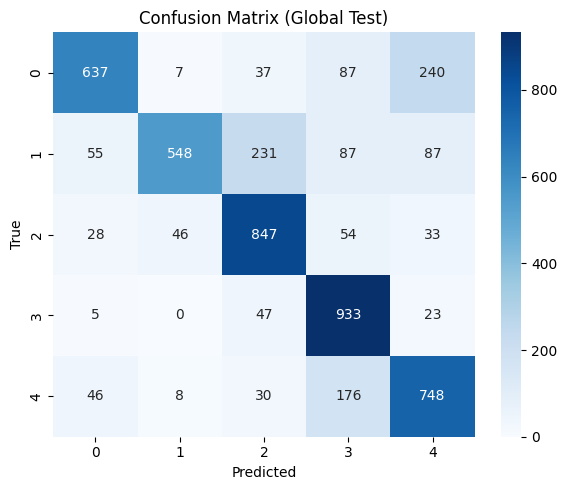

In [ ]:
import os
import pickle
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


class LargeVideoDataset(Dataset):
    """
    Each (sample, frame) is one item.
    - x_array: shape [num_samples, frames_per_sample, H, W, C]
    - y_array: shape [num_samples]
    - transform: a torchvision transform (Resize, ToTensor, etc.)
    """
    def __init__(self, x_array, y_array, transform=None):
        self.x_array = x_array
        self.y_array = y_array
        self.transform = transform
        self.num_samples = x_array.shape[0]
        self.frames_per_sample = x_array.shape[1]
        self.total_frames = self.num_samples * self.frames_per_sample

    def __len__(self):
        return self.total_frames

    def __getitem__(self, idx):
        """
        Map a global frame index -> (sample_idx, frame_idx).
        Return (frame_tensor, label).
        """
        sample_idx = idx // self.frames_per_sample
        frame_idx = idx % self.frames_per_sample

        frame = self.x_array[sample_idx, frame_idx]
        label = self.y_array[sample_idx]

        pil_image = Image.fromarray(frame)
        if self.transform is not None:
            frame_tensor = self.transform(pil_image)  # shape [3, 224, 224]
        else:
            frame_tensor = transforms.ToTensor()(pil_image)

        label_tensor = torch.tensor(label, dtype=torch.long)
        return frame_tensor, label_tensor


class VideoModel(nn.Module):
    def __init__(self, num_labels=5):
        super(VideoModel, self).__init__()
        base_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.base_model = nn.Sequential(*(list(base_model.children())[:-2]))
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(2048, num_labels)

    def forward(self, x):
        x = self.base_model(x)       # => [batch_size, 2048, h, w]
        x = self.global_pool(x)      # => [batch_size, 2048, 1, 1]
        x = self.flatten(x)          # => [batch_size, 2048]
        x = self.fc(x)               # => [batch_size, num_labels]
        return x


def evaluate_sample_level(model, test_x, test_y, transform, batch_size=512):
    """
    Evaluate at the 'sample' level by averaging frame-level logits.
    test_x: shape [num_samples, frames_per_sample, H, W, C]
    test_y: shape [num_samples]
    """
    model.eval()
    num_samples = test_x.shape[0]
    frames_per_sample = test_x.shape[1]
    all_preds = []

    with torch.no_grad():
        for sample_idx in range(num_samples):
            frames = test_x[sample_idx]  # [frames_per_sample, H, W, C]
            logits_accumulator = []

            start = 0
            while start < frames_per_sample:
                end = min(start + batch_size, frames_per_sample)
                batch_frames = frames[start:end]  # shape [n_frames, H, W, C]

                batch_tensors = []
                for frame in batch_frames:
                    pil_img = Image.fromarray(frame)
                    frame_tensor = transform(pil_img)
                    batch_tensors.append(frame_tensor)

                batch_tensors = torch.stack(batch_tensors, dim=0).to(device)
                out = model(batch_tensors)  # => [n_frames, num_labels]
                logits_accumulator.append(out.cpu().numpy())
                start = end

            logits_accumulator = np.concatenate(logits_accumulator, axis=0)
            avg_logits = logits_accumulator.mean(axis=0)  # => [num_labels]
            pred = np.argmax(avg_logits)
            all_preds.append(pred)

    acc = accuracy_score(test_y, all_preds)
    f1 = f1_score(test_y, all_preds, average='weighted')
    return acc, f1, all_preds


def main():
    data_dir = "/content/drive/MyDrive/kk/Input_images/Vision"
    all_files = sorted([f for f in os.listdir(data_dir) if f.lower().endswith(".pkl")])

    all_train_x, all_train_y = [], []
    all_test_x,  all_test_y  = [], []

    for file in all_files:
        with open(os.path.join(data_dir, file), 'rb') as f:
            train_x, train_y, test_x, test_y = pickle.load(f)
            all_train_x.append(train_x)
            all_train_y.append(train_y)
            all_test_x.append(test_x)
            all_test_y.append(test_y)

    global_train_x = np.concatenate(all_train_x, axis=0)  # shape [N, frames, H, W, C]
    global_train_y = np.concatenate(all_train_y, axis=0)  # shape [N]
    global_test_x  = np.concatenate(all_test_x,  axis=0)  # shape [M, frames, H, W, C]
    global_test_y  = np.concatenate(all_test_y,  axis=0)  # shape [M]

    print("Train data shape:", global_train_x.shape, global_train_y.shape)
    print("Test data shape: ", global_test_x.shape,  global_test_y.shape)

    train_x, val_x, train_y, val_y = train_test_split(
        global_train_x, global_train_y,
        test_size=0.2,
        stratify=global_train_y,
        random_state=42
    )
    print("Train set shape:", train_x.shape, train_y.shape)
    print("Val   set shape:", val_x.shape,   val_y.shape)

    my_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])

    train_dataset = LargeVideoDataset(train_x, train_y, transform=my_transform)
    val_dataset   = LargeVideoDataset(val_x,   val_y,   transform=my_transform)

    batch_size = 128

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2)

    model = VideoModel(num_labels=5).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

    epochs = 10
    patience = 3
    best_val_loss = float("inf")
    best_weights = None
    no_improve = 0

    for epoch in range(1, epochs+1):
        model.train()
        total_train_loss = 0
        total_train_correct = 0
        total_frames = 0

        for frames_batch, labels_batch in train_loader:
            frames_batch = frames_batch.to(device)
            labels_batch = labels_batch.to(device)

            optimizer.zero_grad()
            outputs = model(frames_batch)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

            bs = frames_batch.size(0)
            total_train_loss += loss.item() * bs
            preds = torch.argmax(outputs, dim=1)
            total_train_correct += (preds == labels_batch).sum().item()
            total_frames += bs

        avg_train_loss = total_train_loss / total_frames
        avg_train_acc  = total_train_correct / total_frames

        model.eval()
        total_val_loss = 0
        total_val_correct = 0
        total_val_frames = 0

        with torch.no_grad():
            for frames_batch, labels_batch in val_loader:
                frames_batch = frames_batch.to(device)
                labels_batch = labels_batch.to(device)

                val_out = model(frames_batch)
                val_loss = criterion(val_out, labels_batch)

                bs = frames_batch.size(0)
                total_val_loss += val_loss.item() * bs
                val_preds = torch.argmax(val_out, dim=1)
                total_val_correct += (val_preds == labels_batch).sum().item()
                total_val_frames += bs

        avg_val_loss = total_val_loss / total_val_frames
        avg_val_acc  = total_val_correct / total_val_frames

        print(f"Epoch {epoch}/{epochs} => "
              f"Train Loss={avg_train_loss:.4f}, Acc={avg_train_acc*100:.2f}% | "
              f"Val Loss={avg_val_loss:.4f}, Acc={avg_val_acc*100:.2f}%")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_weights = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print("Early stopping triggered.")
                break

    if best_weights is not None:
        model.load_state_dict(best_weights)

    test_acc, test_f1, test_preds = evaluate_sample_level(
        model, global_test_x, global_test_y,
        transform=my_transform,
        batch_size=512
    )
    print(f"\n=== Final Test Results ===")
    print(f"Test Accuracy = {test_acc*100:.2f}%")
    print(f"Test F1 Score = {test_f1:.4f}")

    cm = confusion_matrix(global_test_y, test_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (Global Test)")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Using device: cuda
Global train data shape: (11760, 25, 56, 56, 3) (11760,)
Global test data shape:  (5040, 25, 56, 56, 3) (5040,)

=== FOLD 1 ===
   [Epoch 1] Train Loss=0.4276, Val Loss=0.3276, Val Acc=88.14%
   [Epoch 2] Train Loss=0.1299, Val Loss=0.3388, Val Acc=88.86%
   [Epoch 3] Train Loss=0.0750, Val Loss=0.3643, Val Acc=88.93%
   [Epoch 4] Train Loss=0.0556, Val Loss=0.3354, Val Acc=90.38%
   Early stopping triggered at epoch 4.
   Fold 1: best epoch used = 4

=== FOLD 2 ===
   [Epoch 1] Train Loss=0.4271, Val Loss=0.3570, Val Acc=87.11%
   [Epoch 2] Train Loss=0.1321, Val Loss=0.3821, Val Acc=87.62%
   [Epoch 3] Train Loss=0.0771, Val Loss=0.3524, Val Acc=89.02%
   [Epoch 4] Train Loss=0.0544, Val Loss=0.3783, Val Acc=89.37%
   [Epoch 5] Train Loss=0.0443, Val Loss=0.3566, Val Acc=89.95%
   [Epoch 6] Train Loss=0.0383, Val Loss=0.3556, Val Acc=90.21%
   Early stopping triggered at epoch 6.
   Fold 2: best epoch used = 6

=== FOLD 3 ===
   [Epoch 1] Train Loss=0.4331, Val Los

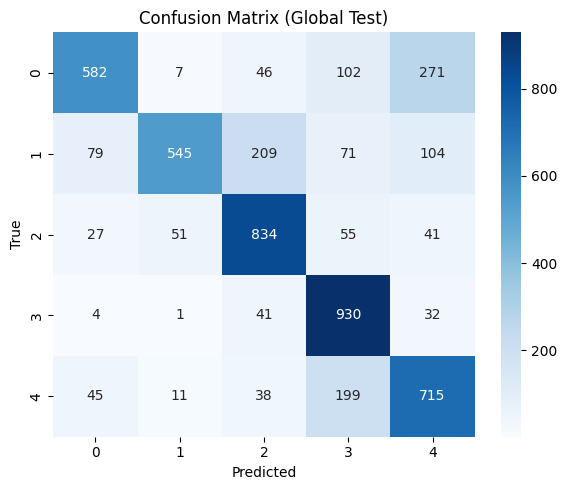

In [ ]:
import os
import pickle
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class LargeVideoDataset(Dataset):
    """
    Each (sample, frame) is one item.
    - x_array: shape [num_samples, frames_per_sample, H, W, C]
    - y_array: shape [num_samples]
    - transform: a torchvision transform (Resize, ToTensor, etc.)
    """
    def __init__(self, x_array, y_array, transform=None):
        self.x_array = x_array
        self.y_array = y_array
        self.transform = transform
        self.num_samples = x_array.shape[0]
        self.frames_per_sample = x_array.shape[1]
        self.total_frames = self.num_samples * self.frames_per_sample

    def __len__(self):
        return self.total_frames

    def __getitem__(self, idx):
        sample_idx = idx // self.frames_per_sample
        frame_idx  = idx % self.frames_per_sample

        frame = self.x_array[sample_idx, frame_idx]  # [H, W, C]
        label = self.y_array[sample_idx]

        pil_image = Image.fromarray(frame)
        if self.transform:
            frame_tensor = self.transform(pil_image)
        else:
            frame_tensor = transforms.ToTensor()(pil_image)

        label_tensor = torch.tensor(label, dtype=torch.long)
        return frame_tensor, label_tensor

class VideoModel(nn.Module):
    def __init__(self, num_labels=5):
        super(VideoModel, self).__init__()
        base_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.base_model = nn.Sequential(*(list(base_model.children())[:-2]))
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(2048, num_labels)

    def forward(self, x):
        x = self.base_model(x)     # => [B, 2048, h, w]
        x = self.global_pool(x)    # => [B, 2048, 1, 1]
        x = self.flatten(x)        # => [B, 2048]
        x = self.fc(x)             # => [B, num_labels]
        return x

def train_with_early_stopping(model, train_loader, val_loader, max_epochs=10, patience=3, lr=5e-5):
    """
    Trains the given model using cross-entropy + early stopping.
    Returns the *best model weights* and the *epoch at which training stopped*.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    best_val_loss = float("inf")
    best_weights = None
    no_improve = 0

    epoch_used = 0

    for epoch in range(1, max_epochs+1):
        model.train()
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_frames = 0

        for frames_batch, labels_batch in train_loader:
            frames_batch = frames_batch.to(device)
            labels_batch = labels_batch.to(device)

            optimizer.zero_grad()
            outputs = model(frames_batch)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

            bs = frames_batch.size(0)
            total_train_loss += loss.item() * bs
            preds = torch.argmax(outputs, dim=1)
            total_train_correct += (preds == labels_batch).sum().item()
            total_train_frames += bs

        avg_train_loss = total_train_loss / total_train_frames
        avg_train_acc  = total_train_correct / total_train_frames

        model.eval()
        total_val_loss = 0
        total_val_correct = 0
        total_val_frames = 0

        with torch.no_grad():
            for frames_batch, labels_batch in val_loader:
                frames_batch = frames_batch.to(device)
                labels_batch = labels_batch.to(device)
                val_out = model(frames_batch)
                val_loss = criterion(val_out, labels_batch)

                bs = frames_batch.size(0)
                total_val_loss += val_loss.item() * bs
                val_preds = torch.argmax(val_out, dim=1)
                total_val_correct += (val_preds == labels_batch).sum().item()
                total_val_frames += bs

        avg_val_loss = total_val_loss / total_val_frames
        avg_val_acc  = total_val_correct / total_val_frames

        print(f"   [Epoch {epoch}] Train Loss={avg_train_loss:.4f}, "
              f"Val Loss={avg_val_loss:.4f}, Val Acc={avg_val_acc*100:.2f}%")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_weights = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"   Early stopping triggered at epoch {epoch}.")
                epoch_used = epoch
                break

        epoch_used = epoch  # If we never break, we used all max_epochs

    return best_weights, epoch_used

def cross_validate_5fold(x, y, batch_size=128, max_epochs=10, patience=3):
    """
    Performs 5-Fold Cross-Validation on x,y.
    Returns the median of the "best epoch used" across folds.
    """
    from sklearn.model_selection import StratifiedKFold

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    fold_epoch_list = []

    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(x, y), start=1):
        print(f"\n=== FOLD {fold_idx} ===")

        x_train_fold = x[train_idx]
        y_train_fold = y[train_idx]
        x_val_fold   = x[val_idx]
        y_val_fold   = y[val_idx]

        train_dataset = LargeVideoDataset(x_train_fold, y_train_fold, transform=transform_train)
        val_dataset   = LargeVideoDataset(x_val_fold,   y_val_fold,   transform=transform_train)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
        val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2)

        fold_model = VideoModel(num_labels=5).to(device)

        best_weights, epoch_used = train_with_early_stopping(
            fold_model, train_loader, val_loader,
            max_epochs=max_epochs, patience=patience
        )
        print(f"   Fold {fold_idx}: best epoch used = {epoch_used}")

        fold_epoch_list.append(epoch_used)

    median_epoch = int(np.median(fold_epoch_list))
    print(f"\nAll fold epochs used: {fold_epoch_list}")
    print(f"Median epochs used: {median_epoch}")
    return median_epoch

def evaluate_sample_level(model, test_x, test_y, batch_size=512):
    """
    Evaluate at sample-level by averaging frame-level logits.
    """
    model.eval()
    num_samples = test_x.shape[0]
    frames_per_sample = test_x.shape[1]
    all_preds = []

    with torch.no_grad():
        for sample_idx in range(num_samples):
            frames = test_x[sample_idx]  # shape [frames_per_sample, H, W, C]
            logits_list = []

            start = 0
            while start < frames_per_sample:
                end = min(start + batch_size, frames_per_sample)
                batch_frames = frames[start:end]
                batch_tensors = []
                for frm in batch_frames:
                    pil_img = Image.fromarray(frm)
                    frm_tensor = transform_test(pil_img)
                    batch_tensors.append(frm_tensor)

                batch_tensors = torch.stack(batch_tensors).to(device)
                out = model(batch_tensors)
                logits_list.append(out.cpu().numpy())
                start = end

            logits_array = np.concatenate(logits_list, axis=0)  # shape [frames_per_sample, num_labels]
            avg_logits = logits_array.mean(axis=0)
            pred_label = np.argmax(avg_logits)
            all_preds.append(pred_label)

    acc = accuracy_score(test_y, all_preds)
    f1 = f1_score(test_y, all_preds, average='weighted')
    return acc, f1, all_preds

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_test = transform_train  # If test transform is same as train, just reuse

def main():
    data_dir = "/content/drive/MyDrive/kk/Input_images/Vision"
    all_files = sorted([f for f in os.listdir(data_dir) if f.lower().endswith(".pkl")])

    all_train_x, all_train_y = [], []
    all_test_x,  all_test_y  = [], []

    for file in all_files:
        with open(os.path.join(data_dir, file), 'rb') as f:
            train_x, train_y, test_x, test_y = pickle.load(f)
            all_train_x.append(train_x)
            all_train_y.append(train_y)
            all_test_x.append(test_x)
            all_test_y.append(test_y)

    global_train_x = np.concatenate(all_train_x, axis=0)  # [N, frames, H, W, C]
    global_train_y = np.concatenate(all_train_y, axis=0)
    global_test_x  = np.concatenate(all_test_x,  axis=0)
    global_test_y  = np.concatenate(all_test_y,  axis=0)

    print("Global train data shape:", global_train_x.shape, global_train_y.shape)
    print("Global test data shape: ", global_test_x.shape,  global_test_y.shape)

    median_epoch = cross_validate_5fold(
        x=global_train_x,
        y=global_train_y,
        batch_size=128,   # you can tweak
        max_epochs=10,    # max epochs
        patience=3
    )

    print(f"\n=== Final Training ===")
    print(f"Training for exactly {median_epoch} epochs (no early stopping).")

    full_train_dataset = LargeVideoDataset(global_train_x, global_train_y, transform=transform_train)
    full_train_loader  = DataLoader(full_train_dataset, batch_size=128, shuffle=True, num_workers=2)

    final_model = VideoModel(num_labels=5).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(final_model.parameters(), lr=5e-5)

    for epoch in range(1, median_epoch+1):
        final_model.train()
        total_loss = 0
        total_correct = 0
        total_frames = 0

        for frames_batch, labels_batch in full_train_loader:
            frames_batch = frames_batch.to(device)
            labels_batch = labels_batch.to(device)

            optimizer.zero_grad()
            outputs = final_model(frames_batch)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

            bs = frames_batch.size(0)
            total_loss += loss.item() * bs
            preds = torch.argmax(outputs, dim=1)
            total_correct += (preds == labels_batch).sum().item()
            total_frames += bs

        avg_loss = total_loss / total_frames
        avg_acc  = total_correct / total_frames
        print(f"  [Epoch {epoch}/{median_epoch}] Train Loss={avg_loss:.4f}, Acc={avg_acc*100:.2f}%")

    test_acc, test_f1, test_preds = evaluate_sample_level(
        final_model, global_test_x, global_test_y, batch_size=512
    )
    print("\n=== Final Test Results ===")
    print(f"Test Accuracy = {test_acc*100:.2f}%")
    print(f"Test F1-score = {test_f1:.4f}")

    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    cm = confusion_matrix(global_test_y, test_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (Global Test)")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import os
import torch
from transformers import AutoModelForImageClassification

hub_model_name = "google/vit-base-patch16-224"  # or any public HF model
local_dir      = "/content/drive/MyDrive/MyVitModel"  # change as you like

if not os.path.exists(local_dir):
    os.makedirs(local_dir, exist_ok=True)

model = AutoModelForImageClassification.from_pretrained(
    hub_model_name,
    num_labels=5,
    ignore_mismatched_sizes=True
)

model.save_pretrained(local_dir)

print(f"Model saved to: {local_dir}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model saved to: /content/drive/MyDrive/MyVitModel


Using device: cuda
Global train: (11760, 25, 56, 56, 3) (11760,)
Global test:  (5040, 25, 56, 56, 3) (5040,)

=== 5-Fold Cross Validation ===

=== FOLD 1 ===


<ipython-input-5-a02ef4c5fa5b>:91: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-5-a02ef4c5fa5b>:106: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-5-a02ef4c5fa5b>:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


   Epoch 1/10 => Train Loss=0.4724, Val Loss=0.4030, Val Acc=86.01%
   Epoch 2/10 => Train Loss=0.1712, Val Loss=0.3527, Val Acc=88.74%
   Epoch 3/10 => Train Loss=0.1047, Val Loss=0.3461, Val Acc=89.51%
   Epoch 4/10 => Train Loss=0.0749, Val Loss=0.3638, Val Acc=89.65%
   Epoch 5/10 => Train Loss=0.0596, Val Loss=0.3632, Val Acc=89.87%
   Epoch 6/10 => Train Loss=0.0497, Val Loss=0.3552, Val Acc=90.63%
   Early stopping at epoch 6
   FOLD 1 => best epoch used: 6

=== FOLD 2 ===
   Epoch 1/10 => Train Loss=0.4719, Val Loss=0.4235, Val Acc=84.93%
   Epoch 2/10 => Train Loss=0.1725, Val Loss=0.3772, Val Acc=87.19%
   Epoch 3/10 => Train Loss=0.1056, Val Loss=0.3414, Val Acc=88.89%
   Epoch 4/10 => Train Loss=0.0751, Val Loss=0.3350, Val Acc=90.26%
   Epoch 5/10 => Train Loss=0.0604, Val Loss=0.3777, Val Acc=89.54%
   Epoch 6/10 => Train Loss=0.0497, Val Loss=0.3574, Val Acc=89.95%
   Epoch 7/10 => Train Loss=0.0430, Val Loss=0.3780, Val Acc=89.75%
   Early stopping at epoch 7
   FOLD 2 

<ipython-input-5-a02ef4c5fa5b>:280: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler      = GradScaler()
<ipython-input-5-a02ef4c5fa5b>:293: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  [Epoch 1/6] => Train Loss=0.4339, Acc=83.43%
  [Epoch 2/6] => Train Loss=0.1569, Acc=94.29%
  [Epoch 3/6] => Train Loss=0.0968, Acc=96.55%
  [Epoch 4/6] => Train Loss=0.0708, Acc=97.50%
  [Epoch 5/6] => Train Loss=0.0557, Acc=98.06%
  [Epoch 6/6] => Train Loss=0.0483, Acc=98.36%

=== Final Testing (Sample-level) ===


<ipython-input-5-a02ef4c5fa5b>:218: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Test Accuracy = 74.60%
Test F1 Score = 0.7447


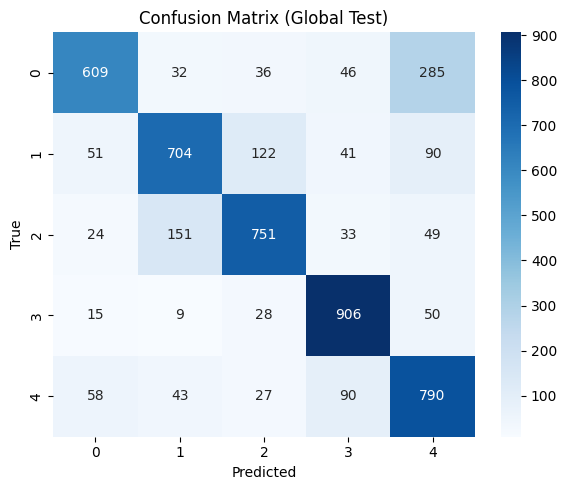

In [ ]:
import os
import pickle
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoModelForImageClassification

from torch.cuda.amp import autocast, GradScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
transform_test = transform_train  # same in this example

class LargeVideoDataset(Dataset):
    """
    Each item = one frame + label.
    x_array: [num_samples, frames_per_sample, H, W, C]
    y_array: [num_samples]
    """
    def __init__(self, x_array, y_array, transform=None):
        self.x_array = x_array
        self.y_array = y_array
        self.transform = transform

        self.num_samples = x_array.shape[0]
        self.frames_per_sample = x_array.shape[1]
        self.total_frames = self.num_samples * self.frames_per_sample

    def __len__(self):
        return self.total_frames

    def __getitem__(self, idx):
        sample_idx = idx // self.frames_per_sample
        frame_idx  = idx %  self.frames_per_sample

        frame = self.x_array[sample_idx, frame_idx]  # shape [H, W, C]
        label = self.y_array[sample_idx]

        pil_img = Image.fromarray(frame)
        frame_tensor = self.transform(pil_img) if self.transform else transforms.ToTensor()(pil_img)
        label_tensor = torch.tensor(label, dtype=torch.long)
        return frame_tensor, label_tensor

class ViTModel(nn.Module):
    def __init__(self, local_dir, num_labels=5):
        super().__init__()
        self.model = AutoModelForImageClassification.from_pretrained(
            local_dir,
            num_labels=num_labels,
            ignore_mismatched_sizes=True,
            local_files_only=True  # <-- ensures we only use local folder, no HF Hub calls
        )

    def forward(self, x):
        outputs = self.model(pixel_values=x)
        return outputs.logits

def train_one_fold(model, train_loader, val_loader, max_epochs=10, patience=3, lr=5e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scaler = GradScaler()
    best_val_loss = float("inf")
    best_weights = None
    no_improve = 0
    epoch_used = 0

    for epoch in range(1, max_epochs+1):
        model.train()
        total_train_loss = 0
        total_train_correct = 0
        total_frames = 0

        for frames_batch, labels_batch in train_loader:
            frames_batch, labels_batch = frames_batch.to(device), labels_batch.to(device)
            optimizer.zero_grad()
            with autocast():
                logits = model(frames_batch)
                loss = criterion(logits, labels_batch)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            bs = frames_batch.size(0)
            total_train_loss += loss.item() * bs
            preds = torch.argmax(logits, dim=1)
            total_train_correct += (preds == labels_batch).sum().item()
            total_frames += bs

        avg_train_loss = total_train_loss / total_frames
        avg_train_acc  = total_train_correct / total_frames

        model.eval()
        total_val_loss = 0
        total_val_correct = 0
        total_val_frames = 0

        with torch.no_grad():
            for frames_batch, labels_batch in val_loader:
                frames_batch, labels_batch = frames_batch.to(device), labels_batch.to(device)
                with autocast():
                    val_logits = model(frames_batch)
                    val_loss   = criterion(val_logits, labels_batch)

                bs = frames_batch.size(0)
                total_val_loss += val_loss.item() * bs
                val_preds = torch.argmax(val_logits, dim=1)
                total_val_correct += (val_preds == labels_batch).sum().item()
                total_val_frames += bs

        avg_val_loss = total_val_loss / total_val_frames
        avg_val_acc  = total_val_correct / total_val_frames
        print(f"   Epoch {epoch}/{max_epochs} => Train Loss={avg_train_loss:.4f}, "
              f"Val Loss={avg_val_loss:.4f}, Val Acc={avg_val_acc*100:.2f}%")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_weights = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"   Early stopping at epoch {epoch}")
                epoch_used = epoch
                break

        epoch_used = epoch

    return best_weights, epoch_used

def cross_validate_5fold(x, y, local_dir, batch_size=32, max_epochs=10, patience=3):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    used_epochs = []

    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(x, y), start=1):
        print(f"\n=== FOLD {fold_idx} ===")
        x_train_fold, y_train_fold = x[train_idx], y[train_idx]
        x_val_fold,   y_val_fold   = x[val_idx],   y[val_idx]

        train_dataset = LargeVideoDataset(x_train_fold, y_train_fold, transform=transform_train)
        val_dataset   = LargeVideoDataset(x_val_fold,   y_val_fold,   transform=transform_train)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2)
        val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2)

        fold_model = ViTModel(local_dir, num_labels=5).to(device)
        best_weights, epoch_used = train_one_fold(
            fold_model, train_loader, val_loader,
            max_epochs=max_epochs, patience=patience, lr=5e-5
        )
        print(f"   FOLD {fold_idx} => best epoch used: {epoch_used}")
        used_epochs.append(epoch_used)

    median_ep = int(np.median(used_epochs))
    print("\nFold epochs used:", used_epochs)
    print("Median epoch used:", median_ep)
    return median_ep

def evaluate_sample_level(model, test_x, test_y, batch_size=32):
    model.eval()
    n_samples = test_x.shape[0]
    frames_per_sample = test_x.shape[1]
    all_preds = []
    from torch.cuda.amp import autocast

    with torch.no_grad():
        for i in range(n_samples):
            frames = test_x[i]  # shape: [frames_per_sample, H, W, C]
            logits_list = []
            start = 0
            while start < frames_per_sample:
                end = min(start+batch_size, frames_per_sample)
                batch_frames = frames[start:end]

                batch_tensors = []
                for frm in batch_frames:
                    pil_img = Image.fromarray(frm)
                    frm_tensor = transform_test(pil_img)
                    batch_tensors.append(frm_tensor)

                batch_tensors = torch.stack(batch_tensors).to(device)
                with autocast():
                    outs = model(batch_tensors)
                logits_list.append(outs.cpu().numpy())
                start = end

            sample_logits = np.concatenate(logits_list, axis=0)  # [frames, num_labels]
            avg_logits = sample_logits.mean(axis=0)
            pred = np.argmax(avg_logits)
            all_preds.append(pred)

    acc = accuracy_score(test_y, all_preds)
    f1  = f1_score(test_y, all_preds, average='weighted')
    return acc, f1, all_preds

def main():
    local_dir = "/content/drive/MyDrive/MyVitModel"

    data_dir = "/content/drive/MyDrive/kk/Input_images/Vision"
    all_files = sorted([f for f in os.listdir(data_dir) if f.lower().endswith(".pkl")])

    all_train_x, all_train_y = [], []
    all_test_x,  all_test_y  = [], []

    for file_name in all_files:
        with open(os.path.join(data_dir, file_name), "rb") as f:
            train_x, train_y, test_x, test_y = pickle.load(f)
            all_train_x.append(train_x)
            all_train_y.append(train_y)
            all_test_x.append(test_x)
            all_test_y.append(test_y)

    global_train_x = np.concatenate(all_train_x, axis=0)
    global_train_y = np.concatenate(all_train_y, axis=0)
    global_test_x  = np.concatenate(all_test_x,  axis=0)
    global_test_y  = np.concatenate(all_test_y,  axis=0)

    print("Global train:", global_train_x.shape, global_train_y.shape)
    print("Global test: ", global_test_x.shape,  global_test_y.shape)

    print("\n=== 5-Fold Cross Validation ===")
    median_epoch = cross_validate_5fold(
        x=global_train_x,
        y=global_train_y,
        local_dir=local_dir,
        batch_size=32,
        max_epochs=10,
        patience=3
    )

    print(f"\n=== Final Training for {median_epoch} epochs ===")
    final_dataset = LargeVideoDataset(global_train_x, global_train_y, transform=transform_train)
    final_loader  = DataLoader(final_dataset, batch_size=32, shuffle=True, num_workers=2)

    final_model = ViTModel(local_dir, num_labels=5).to(device)
    criterion   = nn.CrossEntropyLoss()
    optimizer   = torch.optim.AdamW(final_model.parameters(), lr=5e-5)
    scaler      = GradScaler()

    for ep in range(1, median_epoch+1):
        final_model.train()
        total_loss = 0
        total_correct = 0
        total_frames = 0

        for frames_batch, labels_batch in final_loader:
            frames_batch = frames_batch.to(device)
            labels_batch = labels_batch.to(device)

            optimizer.zero_grad()
            with autocast():
                logits = final_model(frames_batch)
                loss = criterion(logits, labels_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            bs = frames_batch.size(0)
            total_loss += loss.item() * bs
            preds = torch.argmax(logits, dim=1)
            total_correct += (preds == labels_batch).sum().item()
            total_frames += bs

        avg_loss = total_loss / total_frames
        avg_acc  = total_correct / total_frames
        print(f"  [Epoch {ep}/{median_epoch}] => Train Loss={avg_loss:.4f}, Acc={avg_acc*100:.2f}%")

    print("\n=== Final Testing (Sample-level) ===")
    test_acc, test_f1, test_preds = evaluate_sample_level(
        final_model, global_test_x, global_test_y, batch_size=32
    )

    print(f"Test Accuracy = {test_acc*100:.2f}%")
    print(f"Test F1 Score = {test_f1:.4f}")

    cm = confusion_matrix(global_test_y, test_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (Global Test)")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Total Training Samples: 11760
Total Test Samples: 5040
Extracting AST features...


<ipython-input-1-b74964474852>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Epoch 1, Train Acc: 32.75%, Val Loss: 1.3572
Epoch 2, Train Acc: 47.05%, Val Loss: 1.1866
Epoch 3, Train Acc: 51.71%, Val Loss: 1.1240
Epoch 4, Train Acc: 54.26%, Val Loss: 1.0880
Epoch 5, Train Acc: 56.56%, Val Loss: 1.0617
Epoch 6, Train Acc: 58.56%, Val Loss: 1.0192
Epoch 7, Train Acc: 60.48%, Val Loss: 1.0009
Epoch 8, Train Acc: 62.74%, Val Loss: 0.9990
Epoch 9, Train Acc: 63.30%, Val Loss: 0.9634
Epoch 10, Train Acc: 65.18%, Val Loss: 0.9410
Epoch 11, Train Acc: 67.18%, Val Loss: 0.9306
Epoch 12, Train Acc: 67.83%, Val Loss: 0.9272
Epoch 13, Train Acc: 68.85%, Val Loss: 0.9541
Epoch 14, Train Acc: 69.95%, Val Loss: 0.8987
Epoch 15, Train Acc: 71.17%, Val Loss: 0.8966
Epoch 16, Train Acc: 72.16%, Val Loss: 0.8787
Epoch 17, Train Acc: 73.18%, Val Loss: 0.8761
Epoch 18, Train Acc: 73.87%, Val Loss: 0.8748
Epoch 19, Train Acc: 74.82%, Val Loss: 0.9190
Epoch 20, Train Acc: 75.85%, Val Loss: 0.8509
Epoch 21, Train Acc: 76.97%, Val Loss: 0.8539
Epoch 22, Train Acc: 78.15%, Val Loss: 0.85

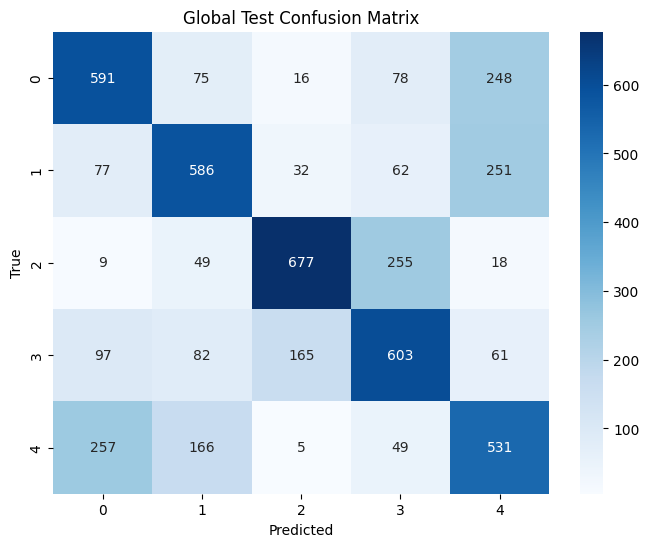

Test Accuracy: 59.29% | F1 Score: 0.5952


In [ ]:
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from transformers import ASTFeatureExtractor, AutoModelForAudioClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score, confusion_matrix  # <-- Imported confusion_matrix
from sklearn.model_selection import train_test_split
from copy import deepcopy

class AudioModelTrainerGlobal:
    def __init__(self, train_X, train_y, val_X, val_y, test_X, test_y,
                 model_path, num_classes=5, lr=0.001, weight_decay=1e-5, batch_size=32):

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.batch_size = batch_size
        self.loss_fn = nn.CrossEntropyLoss()
        self.initial_lr = lr
        self.weight_decay = weight_decay

        self.extractor = ASTFeatureExtractor()

        print("Extracting AST features...")
        self.train_X = self._extract(train_X)
        self.val_X   = self._extract(val_X)
        self.test_X  = self._extract(test_X)

        self.train_loader = self._prepare_dataloader(self.train_X, train_y, shuffle=True)
        self.val_loader   = self._prepare_dataloader(self.val_X, val_y, shuffle=False)
        self.test_loader  = self._prepare_dataloader(self.test_X, test_y, shuffle=False)

        self.model = AutoModelForAudioClassification.from_pretrained(model_path)
        self.model.classifier.dense = nn.Linear(self.model.classifier.dense.in_features, num_classes)
        self.model.to(self.device)

        self.optimizer = optim.AdamW(self.model.parameters(), lr=self.initial_lr, weight_decay=self.weight_decay)
        self.outputs_test = None

    def _extract(self, waveforms):
        features = self.extractor(waveforms, sampling_rate=16000, padding="max_length", return_tensors="pt")
        return features["input_values"]

    def _prepare_dataloader(self, x, y, shuffle=False):
        x_tensor = torch.tensor(x, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.long)
        dataset = TensorDataset(x_tensor, y_tensor)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=shuffle)

    def train(self, epochs=50, patience=3):
        best_val_loss = float("inf")
        best_state = None
        epochs_no_improve = 0

        for epoch in range(epochs):
            self.model.train()
            correct, total, running_loss = 0, 0, 0.0

            for x_batch, y_batch in self.train_loader:
                x_batch, y_batch = x_batch.to(self.device), y_batch.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(x_batch)
                logits = outputs.logits
                loss = self.loss_fn(logits, y_batch)
                loss.backward()
                self.optimizer.step()

                preds = logits.argmax(dim=-1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)
                running_loss += loss.item() * x_batch.size(0)

            train_acc = 100.0 * correct / total

            self.model.eval()
            val_loss, val_total = 0.0, 0
            with torch.no_grad():
                for x_val, y_val in self.val_loader:
                    x_val, y_val = x_val.to(self.device), y_val.to(self.device)
                    logits = self.model(x_val).logits
                    loss = self.loss_fn(logits, y_val)
                    val_loss += loss.item() * x_val.size(0)
                    val_total += y_val.size(0)
            val_loss /= val_total

            print(f"Epoch {epoch+1}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_state = deepcopy(self.model.state_dict())
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        if best_state:
            self.model.load_state_dict(best_state)

    def evaluate(self):
        self.model.eval()
        correct, total = 0, 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for x_batch, y_batch in self.test_loader:
                x_batch, y_batch = x_batch.to(self.device), y_batch.to(self.device)
                logits = self.model(x_batch).logits
                preds = logits.argmax(dim=-1)
                all_preds.append(preds.cpu().numpy())
                all_labels.append(y_batch.cpu().numpy())
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)

        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        acc = 100.0 * correct / total
        f1 = f1_score(all_labels, all_preds, average='weighted')

        cm = confusion_matrix(all_labels, all_preds)

        import seaborn as sns
        import matplotlib.pyplot as plt

        plt.figure(figsize=(8,6))
        ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        ax.set_title("Global Test Confusion Matrix")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.xaxis.set_ticklabels([0,1,2,3,4])
        ax.yaxis.set_ticklabels([0,1,2,3,4])
        plt.show()

        print(f"Test Accuracy: {acc:.2f}% | F1 Score: {f1:.4f}")
        return acc, f1


audio_dir = "/content/drive/MyDrive/kk/Input_images/Audio"
model_path = "MIT/ast-finetuned-audioset-10-10-0.4593"

all_train_X, all_train_y = [], []
all_test_X, all_test_y = [], []

for sub in range(1, 43):
    file_name = f"subject_{sub:02d}_aud.pkl"
    file_path = os.path.join(audio_dir, file_name)

    if not os.path.exists(file_path):
        print(f"File missing: {file_path}, skipping.")
        continue

    with open(file_path, "rb") as f:
        tr_x, tr_y, te_x, te_y = pickle.load(f)

    all_train_X.extend(tr_x)
    all_train_y.extend(tr_y)
    all_test_X.extend(te_x)
    all_test_y.extend(te_y)

print(f"Total Training Samples: {len(all_train_X)}")
print(f"Total Test Samples: {len(all_test_X)}")

train_X, val_X, train_y, val_y = train_test_split(
    all_train_X, all_train_y, test_size=0.3, random_state=42, stratify=all_train_y
)

trainer = AudioModelTrainerGlobal(
    train_X=train_X,
    train_y=train_y,
    val_X=val_X,
    val_y=val_y,
    test_X=all_test_X,
    test_y=all_test_y,
    model_path=model_path,
    num_classes=5,
    lr=5e-7,
    weight_decay=1e-6,
    batch_size=32
)

trainer.train(epochs=50, patience=10)
acc, f1 = trainer.evaluate()


In [ ]:
from copy import deepcopy

def train(self, epochs=50, patience=3):
    val_split = int(0.8 * len(self.tr_x))
    train_x, val_x = self.tr_x[:val_split], self.tr_x[val_split:]
    train_y, val_y = self.tr_y[:val_split], self.tr_y[val_split:]

    self.train_dataloader = self._prepare_dataloader(train_x, train_y, shuffle=True)
    val_dataloader        = self._prepare_dataloader(val_x, val_y, shuffle=False)

    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0

    for epoch in range(epochs):
        self.model.train()
        correct, total = 0, 0
        running_loss = 0.0

        for x_batch, y_batch in self.train_dataloader:
            x_batch, y_batch = x_batch.to(self.device), y_batch.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(x_batch)
            logits = outputs.logits
            loss = self.loss_fn(logits, y_batch)
            loss.backward()
            self.optimizer.step()

            preds = logits.argmax(dim=-1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
            running_loss += loss.item() * x_batch.size(0)

        train_acc = 100.0 * correct / total

        self.model.eval()
        val_loss = 0.0
        val_total = 0

        with torch.no_grad():
            for x_val, y_val in val_dataloader:
                x_val, y_val = x_val.to(self.device), y_val.to(self.device)
                outputs = self.model(x_val)
                logits = outputs.logits
                loss = self.loss_fn(logits, y_val)
                val_loss += loss.item() * x_val.size(0)
                val_total += y_val.size(0)

        val_loss /= val_total

        print(f"[{self.sub}] Epoch {epoch+1}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = deepcopy(self.model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"[{self.sub}] Early stopping at epoch {epoch+1}")
                break

    if best_model_state:
        self.model.load_state_dict(best_model_state)

    self.model.eval()
    correct_te, total_te = 0, 0
    test_logits_collector = []

    with torch.no_grad():
        for x_test, y_test in self.test_dataloader:
            x_test, y_test = x_test.to(self.device), y_test.to(self.device)
            out_test = self.model(x_test)
            logits_test = out_test.logits

            preds_test = logits_test.argmax(dim=-1)
            correct_te += (preds_test == y_test).sum().item()
            total_te += y_test.size(0)

            test_logits_collector.append(logits_test.detach().cpu().numpy())

    test_acc = 100.0 * correct_te / total_te
    self.outputs_test = np.concatenate(test_logits_collector, axis=0)

    print(f"[{self.sub}] Final Test Accuracy: {test_acc:.2f}%")
    return test_acc


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate(self):
    self.model.eval()
    correct, total = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x_batch, y_batch in self.test_loader:
            x_batch, y_batch = x_batch.to(self.device), y_batch.to(self.device)
            logits = self.model(x_batch).logits
            preds = logits.argmax(dim=-1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = 100.0 * correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"Test Accuracy: {acc:.2f}% | F1 Score: {f1:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(cm.shape[0]), yticklabels=range(cm.shape[0]))
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return acc, f1


Total Training Samples: 11760
Total Test Samples: 5040
Extracting AST features...


KeyboardInterrupt: 

Total Training Samples: 11760
Total Test Samples: 5040


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Epoch 1/50 | Train Loss=1.4143, Train Acc=35.14% | Val Loss=1.8865
Epoch 2/50 | Train Loss=1.2261, Train Acc=45.09% | Val Loss=1.9519
Epoch 3/50 | Train Loss=1.1722, Train Acc=48.92% | Val Loss=1.8994
Epoch 4/50 | Train Loss=1.1221, Train Acc=51.48% | Val Loss=1.9174
Epoch 5/50 | Train Loss=1.0924, Train Acc=53.69% | Val Loss=1.9710
Epoch 6/50 | Train Loss=1.0580, Train Acc=54.63% | Val Loss=1.9900
Epoch 7/50 | Train Loss=1.0508, Train Acc=55.67% | Val Loss=1.9922
Epoch 8/50 | Train Loss=1.0498, Train Acc=55.84% | Val Loss=1.9947
Epoch 9/50 | Train Loss=1.0495, Train Acc=55.17% | Val Loss=1.9853
Epoch 10/50 | Train Loss=1.0470, Train Acc=55.56% | Val Loss=2.0084
Epoch 11/50 | Train Loss=1.0413, Train Acc=56.18% | Val Loss=2.0046
Early stopping at epoch 11


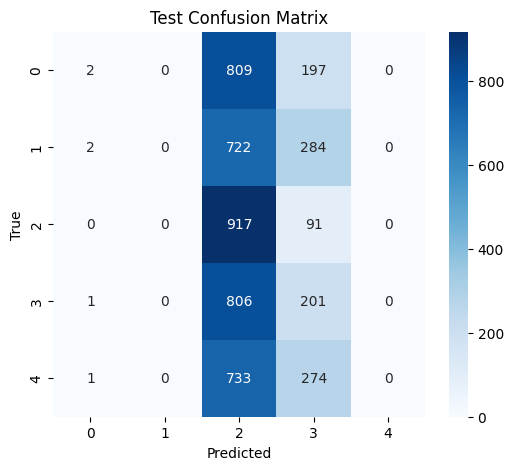

Test Accuracy: 22.22% | F1 Score: 0.1133


In [ ]:
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from transformers import ASTFeatureExtractor, AutoModelForAudioClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from copy import deepcopy

import seaborn as sns
import matplotlib.pyplot as plt


class AddNoiseTransform(nn.Module):
    """
    Adds random Gaussian noise to a waveform.
    This is a simple example of waveform-level augmentation.
    """
    def __init__(self, noise_level=0.02):
        super().__init__()
        self.noise_level = noise_level

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        noise = torch.randn_like(waveform) * self.noise_level
        return waveform + noise


class AudioWaveformDataset(Dataset):
    """
    Dataset for raw waveforms, with optional waveform-level transform (e.g., noise injection).
    Ensures the label is cast to torch.long for CrossEntropyLoss compatibility.
    """
    def __init__(self, waveforms, labels, transform=None):
        """
        Args:
          waveforms: list/array of 1D waveforms. shape e.g. [num_samples]
          labels: list/array of integer labels
          transform: optional transform function (e.g. AddNoiseTransform)
        """
        self.waveforms = waveforms
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.waveforms)

    def __getitem__(self, idx):
        waveform = torch.tensor(self.waveforms[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        if self.transform is not None:
            waveform = self.transform(waveform)

        return waveform, label


class AudioModelTrainerGlobal:
    def __init__(
        self,
        train_waveforms, train_labels,
        val_waveforms, val_labels,
        test_waveforms, test_labels,
        model_path,
        num_classes=5,
        lr=1e-5,
        weight_decay=1e-5,
        batch_size=32,
        step_size=5,
        gamma=0.1
    ):
        """
        Args:
          train_waveforms, train_labels: training data
          val_waveforms,   val_labels:   validation data
          test_waveforms,  test_labels:  test data
          model_path: model checkpoint (e.g. 'MIT/ast-finetuned-audioset-10-10-0.4593')
          num_classes: number of classes for classification head
          lr: initial learning rate
          weight_decay: weight decay for AdamW
          batch_size: batch size
          step_size: how often to reduce LR
          gamma: factor by which LR is reduced at step_size intervals
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.batch_size = batch_size
        self.loss_fn = nn.CrossEntropyLoss()

        self.extractor = ASTFeatureExtractor()

        self.train_transform = AddNoiseTransform(noise_level=0.02)
        self.val_transform = None

        self.train_dataset = AudioWaveformDataset(train_waveforms, train_labels, transform=self.train_transform)
        self.val_dataset   = AudioWaveformDataset(val_waveforms,   val_labels,   transform=self.val_transform)
        self.test_dataset  = AudioWaveformDataset(test_waveforms,  test_labels,  transform=self.val_transform)

        self.train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)
        self.val_loader   = DataLoader(self.val_dataset,   batch_size=batch_size, shuffle=False)
        self.test_loader  = DataLoader(self.test_dataset,  batch_size=batch_size, shuffle=False)

        self.model = AutoModelForAudioClassification.from_pretrained(model_path)
        self.model.classifier.dense = nn.Linear(self.model.classifier.dense.in_features, num_classes)
        self.model.to(self.device)

        self.optimizer = optim.AdamW(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=step_size, gamma=gamma)

    def _extract_features(self, waveform_batch):
        """
        Use ASTFeatureExtractor on a batch of waveforms.
        Input shape: (batch_size, waveform_length)
        Output: A dict with 'input_values' to feed into the model.
        """
        waveforms_list = [w.cpu().numpy() for w in waveform_batch]
        features = self.extractor(
            waveforms_list,
            sampling_rate=16000,
            padding="max_length",
            return_tensors="pt"
        )
        return features["input_values"].to(self.device)

    def train(self, epochs=30, patience=5):
        best_val_loss = float("inf")
        best_state = None
        no_improve = 0

        for epoch in range(epochs):
            self.model.train()
            running_loss, correct, total = 0.0, 0, 0

            for waveforms, labels in self.train_loader:
                waveforms, labels = waveforms.to(self.device), labels.to(self.device)
                input_values = self._extract_features(waveforms)

                self.optimizer.zero_grad()
                outputs = self.model(input_values)
                logits = outputs.logits

                loss = self.loss_fn(logits, labels)
                loss.backward()
                self.optimizer.step()

                preds = logits.argmax(dim=-1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                running_loss += loss.item() * labels.size(0)

            train_acc = 100.0 * correct / total
            avg_train_loss = running_loss / total

            self.model.eval()
            val_loss_sum, val_total = 0.0, 0

            with torch.no_grad():
                for waveforms_val, labels_val in self.val_loader:
                    waveforms_val, labels_val = waveforms_val.to(self.device), labels_val.to(self.device)
                    val_input_values = self._extract_features(waveforms_val)

                    logits_val = self.model(val_input_values).logits
                    val_loss = self.loss_fn(logits_val, labels_val)

                    val_loss_sum += val_loss.item() * labels_val.size(0)
                    val_total += labels_val.size(0)

            avg_val_loss = val_loss_sum / val_total
            self.scheduler.step()

            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss={avg_train_loss:.4f}, Train Acc={train_acc:.2f}% | "
                  f"Val Loss={avg_val_loss:.4f}")

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_state = deepcopy(self.model.state_dict())
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        if best_state:
            self.model.load_state_dict(best_state)

    def evaluate(self):
        self.model.eval()
        all_preds, all_labels = [], []
        correct, total = 0, 0

        with torch.no_grad():
            for waveforms_test, labels_test in self.test_loader:
                waveforms_test = waveforms_test.to(self.device)
                labels_test = labels_test.to(self.device)

                test_input_values = self._extract_features(waveforms_test)
                logits_test = self.model(test_input_values).logits
                preds_test = logits_test.argmax(dim=-1)

                all_preds.append(preds_test.cpu().numpy())
                all_labels.append(labels_test.cpu().numpy())
                correct += (preds_test == labels_test).sum().item()
                total += labels_test.size(0)

        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)

        acc = 100.0 * correct / total
        f1 = f1_score(all_labels, all_preds, average='weighted')

        cm = confusion_matrix(all_labels, all_preds)

        plt.figure(figsize=(6,5))
        ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        ax.set_title("Test Confusion Matrix")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")

        n_labels = cm.shape[0]  # should be 5 for a 5-class problem
        ax.xaxis.set_ticklabels(range(n_labels))
        ax.yaxis.set_ticklabels(range(n_labels))

        plt.show()

        print(f"Test Accuracy: {acc:.2f}% | F1 Score: {f1:.4f}")
        return acc, f1


if __name__ == "__main__":
    audio_dir = "/content/drive/MyDrive/kk/Input_images/Audio"
    model_path = "MIT/ast-finetuned-audioset-10-10-0.4593"

    all_train_X, all_train_y = [], []
    all_test_X, all_test_y = [], []

    for sub in range(1, 43):
        file_name = f"subject_{sub:02d}_aud.pkl"
        file_path = os.path.join(audio_dir, file_name)
        if not os.path.exists(file_path):
            continue
        with open(file_path, "rb") as f:
            tr_x, tr_y, te_x, te_y = pickle.load(f)
        all_train_X.extend(tr_x)
        all_train_y.extend(tr_y)
        all_test_X.extend(te_x)
        all_test_y.extend(te_y)

    print(f"Total Training Samples: {len(all_train_X)}")
    print(f"Total Test Samples: {len(all_test_X)}")

    train_X, val_X, train_y, val_y = train_test_split(
        all_train_X, all_train_y,
        test_size=0.3,
        random_state=42,
        stratify=all_train_y
    )

    trainer = AudioModelTrainerGlobal(
        train_waveforms=train_X,
        train_labels=train_y,
        val_waveforms=val_X,
        val_labels=val_y,
        test_waveforms=all_test_X,
        test_labels=all_test_y,
        model_path=model_path,
        num_classes=5,    # sets final layer to 5 classes
        lr=1e-6,
        weight_decay=1e-5,
        batch_size=32,
        step_size=5,
        gamma=0.1
    )

    trainer.train(epochs=50, patience=10)
    acc, f1 = trainer.evaluate()


Found 42 .pkl files in /content/drive/MyDrive/kk/Input_images/Vision.

=== subject_01_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_01_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_01_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_01_vis.pkl] epoch=1/8 => val_loss=0.3620, val_acc=88.12%
[Train_subject_01_vis.pkl] epoch=2/8 => val_loss=0.2474, val_acc=91.49%
[Train_subject_01_vis.pkl] epoch=3/8 => val_loss=0.2192, val_acc=93.13%
[Train_subject_01_vis.pkl] epoch=4/8 => val_loss=0.3040, val_acc=89.25%
[Train_subject_01_vis.pkl] epoch=5/8 => val_loss=0.2061, val_acc=93.70%
[Train_subject_01_vis.pkl] epoch=6/8 => val_loss=0.1583, val_acc=94.41%
[Train_subject_01_vis.pkl] epoch=7/8 => val_loss=0.2467, val_acc=92.76%
[Train_subject_01_vis.pkl] epoch=8/8 => val_loss=0.2612, val_acc=92.49%
[Train_subject_01_vis.pkl] => best_val_loss=0.1583
[subject_01_vis.pkl] => Test ACC=61.67%, Test F1=0.5964

=== subject_02_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_02_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_02_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_02_vis.pkl] epoch=1/8 => val_loss=0.4241, val_acc=87.07%
[Train_subject_02_vis.pkl] epoch=2/8 => val_loss=0.3011, val_acc=91.05%
[Train_subject_02_vis.pkl] epoch=3/8 => val_loss=0.4227, val_acc=87.03%
[Train_subject_02_vis.pkl] epoch=4/8 => val_loss=0.3721, val_acc=89.07%
[Train_subject_02_vis.pkl] epoch=5/8 => val_loss=0.2913, val_acc=91.15%
[Train_subject_02_vis.pkl] epoch=6/8 => val_loss=0.2095, val_acc=93.77%
[Train_subject_02_vis.pkl] epoch=7/8 => val_loss=0.3020, val_acc=91.34%
[Train_subject_02_vis.pkl] epoch=8/8 => val_loss=0.3088, val_acc=91.81%
[Train_subject_02_vis.pkl] => best_val_loss=0.2095
[subject_02_vis.pkl] => Test ACC=70.00%, Test F1=0.7059

=== subject_03_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_03_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_03_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_03_vis.pkl] epoch=1/8 => val_loss=0.5718, val_acc=78.85%
[Train_subject_03_vis.pkl] epoch=2/8 => val_loss=0.3253, val_acc=89.93%
[Train_subject_03_vis.pkl] epoch=3/8 => val_loss=0.4023, val_acc=86.20%
[Train_subject_03_vis.pkl] epoch=4/8 => val_loss=0.3685, val_acc=89.01%
[Train_subject_03_vis.pkl] epoch=5/8 => val_loss=0.3226, val_acc=90.27%
[Train_subject_03_vis.pkl] epoch=6/8 => val_loss=0.3722, val_acc=88.80%
[Train_subject_03_vis.pkl] epoch=7/8 => val_loss=0.3529, val_acc=90.41%
[Train_subject_03_vis.pkl] epoch=8/8 => val_loss=0.3908, val_acc=90.27%
[Train_subject_03_vis.pkl] Early stopping at epoch=8
[Train_subject_03_vis.pkl] => best_val_loss=0.3226
[subject_03_vis.pkl] => Test ACC=81.67%, Test F1=0.8040

=== subject_04_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_04_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_04_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_04_vis.pkl] epoch=1/8 => val_loss=0.4007, val_acc=87.42%
[Train_subject_04_vis.pkl] epoch=2/8 => val_loss=0.3293, val_acc=89.25%
[Train_subject_04_vis.pkl] epoch=3/8 => val_loss=0.4244, val_acc=86.15%
[Train_subject_04_vis.pkl] epoch=4/8 => val_loss=0.3819, val_acc=87.83%
[Train_subject_04_vis.pkl] epoch=5/8 => val_loss=0.3147, val_acc=90.96%
[Train_subject_04_vis.pkl] epoch=6/8 => val_loss=0.1570, val_acc=95.03%
[Train_subject_04_vis.pkl] epoch=7/8 => val_loss=0.2046, val_acc=93.74%
[Train_subject_04_vis.pkl] epoch=8/8 => val_loss=0.2223, val_acc=93.75%
[Train_subject_04_vis.pkl] => best_val_loss=0.1570
[subject_04_vis.pkl] => Test ACC=80.00%, Test F1=0.7920


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.



=== subject_05_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_05_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_05_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_05_vis.pkl] epoch=1/8 => val_loss=0.4049, val_acc=87.31%
[Train_subject_05_vis.pkl] epoch=2/8 => val_loss=0.5702, val_acc=81.53%
[Train_subject_05_vis.pkl] epoch=3/8 => val_loss=0.4147, val_acc=86.22%
[Train_subject_05_vis.pkl] epoch=4/8 => val_loss=0.5508, val_acc=84.32%
[Train_subject_05_vis.pkl] Early stopping at epoch=4
[Train_subject_05_vis.pkl] => best_val_loss=0.4049
[subject_05_vis.pkl] => Test ACC=58.33%, Test F1=0.5727


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.



=== subject_06_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_06_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_06_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_06_vis.pkl] epoch=1/8 => val_loss=0.3942, val_acc=88.45%
[Train_subject_06_vis.pkl] epoch=2/8 => val_loss=0.5402, val_acc=82.91%
[Train_subject_06_vis.pkl] epoch=3/8 => val_loss=0.1868, val_acc=93.84%
[Train_subject_06_vis.pkl] epoch=4/8 => val_loss=0.2155, val_acc=92.90%
[Train_subject_06_vis.pkl] epoch=5/8 => val_loss=0.1522, val_acc=95.64%
[Train_subject_06_vis.pkl] epoch=6/8 => val_loss=0.2366, val_acc=92.80%
[Train_subject_06_vis.pkl] epoch=7/8 => val_loss=0.1877, val_acc=94.74%
[Train_subject_06_vis.pkl] epoch=8/8 => val_loss=0.2525, val_acc=92.38%
[Train_subject_06_vis.pkl] Early stopping at epoch=8
[Train_subject_06_vis.pkl] => best_val_loss=0.1522
[subject_06_vis.pkl] => Test ACC=86.67%, Test F1=0.8690

=== subject_07_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_07_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_07_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_07_vis.pkl] epoch=1/8 => val_loss=0.3621, val_acc=91.51%
[Train_subject_07_vis.pkl] epoch=2/8 => val_loss=0.1778, val_acc=94.84%
[Train_subject_07_vis.pkl] epoch=3/8 => val_loss=0.2475, val_acc=93.06%
[Train_subject_07_vis.pkl] epoch=4/8 => val_loss=0.2310, val_acc=92.42%
[Train_subject_07_vis.pkl] epoch=5/8 => val_loss=0.1808, val_acc=94.32%
[Train_subject_07_vis.pkl] Early stopping at epoch=5
[Train_subject_07_vis.pkl] => best_val_loss=0.1778
[subject_07_vis.pkl] => Test ACC=76.67%, Test F1=0.7472

=== subject_08_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_08_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_08_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_08_vis.pkl] epoch=1/8 => val_loss=0.4684, val_acc=84.60%
[Train_subject_08_vis.pkl] epoch=2/8 => val_loss=0.4092, val_acc=86.08%
[Train_subject_08_vis.pkl] epoch=3/8 => val_loss=0.4115, val_acc=87.55%
[Train_subject_08_vis.pkl] epoch=4/8 => val_loss=0.4405, val_acc=86.17%
[Train_subject_08_vis.pkl] epoch=5/8 => val_loss=0.4734, val_acc=85.58%
[Train_subject_08_vis.pkl] Early stopping at epoch=5
[Train_subject_08_vis.pkl] => best_val_loss=0.4092
[subject_08_vis.pkl] => Test ACC=75.83%, Test F1=0.7493

=== subject_09_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_09_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_09_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_09_vis.pkl] epoch=1/8 => val_loss=0.5156, val_acc=84.52%
[Train_subject_09_vis.pkl] epoch=2/8 => val_loss=0.3783, val_acc=88.35%
[Train_subject_09_vis.pkl] epoch=3/8 => val_loss=0.2740, val_acc=91.29%
[Train_subject_09_vis.pkl] epoch=4/8 => val_loss=0.4313, val_acc=86.70%
[Train_subject_09_vis.pkl] epoch=5/8 => val_loss=0.1952, val_acc=93.09%
[Train_subject_09_vis.pkl] epoch=6/8 => val_loss=0.1996, val_acc=93.70%
[Train_subject_09_vis.pkl] epoch=7/8 => val_loss=0.2797, val_acc=91.57%
[Train_subject_09_vis.pkl] epoch=8/8 => val_loss=0.3401, val_acc=90.44%
[Train_subject_09_vis.pkl] Early stopping at epoch=8
[Train_subject_09_vis.pkl] => best_val_loss=0.1952
[subject_09_vis.pkl] => Test ACC=73.33%, Test F1=0.7275

=== subject_10_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_10_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_10_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_10_vis.pkl] epoch=1/8 => val_loss=0.5223, val_acc=83.50%
[Train_subject_10_vis.pkl] epoch=2/8 => val_loss=0.3134, val_acc=90.06%
[Train_subject_10_vis.pkl] epoch=3/8 => val_loss=0.6072, val_acc=80.04%
[Train_subject_10_vis.pkl] epoch=4/8 => val_loss=0.4112, val_acc=86.29%
[Train_subject_10_vis.pkl] epoch=5/8 => val_loss=0.2592, val_acc=92.80%
[Train_subject_10_vis.pkl] epoch=6/8 => val_loss=0.3224, val_acc=91.62%
[Train_subject_10_vis.pkl] epoch=7/8 => val_loss=0.3981, val_acc=89.87%
[Train_subject_10_vis.pkl] epoch=8/8 => val_loss=0.3046, val_acc=92.33%
[Train_subject_10_vis.pkl] Early stopping at epoch=8
[Train_subject_10_vis.pkl] => best_val_loss=0.2592
[subject_10_vis.pkl] => Test ACC=63.33%, Test F1=0.6181

=== subject_11_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_11_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_11_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_11_vis.pkl] epoch=1/8 => val_loss=0.5878, val_acc=82.43%
[Train_subject_11_vis.pkl] epoch=2/8 => val_loss=0.4646, val_acc=85.51%
[Train_subject_11_vis.pkl] epoch=3/8 => val_loss=0.4711, val_acc=86.17%
[Train_subject_11_vis.pkl] epoch=4/8 => val_loss=0.4473, val_acc=87.12%
[Train_subject_11_vis.pkl] epoch=5/8 => val_loss=0.5005, val_acc=84.90%
[Train_subject_11_vis.pkl] epoch=6/8 => val_loss=0.4464, val_acc=89.02%
[Train_subject_11_vis.pkl] epoch=7/8 => val_loss=0.4372, val_acc=89.49%
[Train_subject_11_vis.pkl] epoch=8/8 => val_loss=0.4951, val_acc=86.70%
[Train_subject_11_vis.pkl] => best_val_loss=0.4372
[subject_11_vis.pkl] => Test ACC=65.00%, Test F1=0.5798

=== subject_12_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_12_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_12_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_12_vis.pkl] epoch=1/8 => val_loss=0.6042, val_acc=79.64%
[Train_subject_12_vis.pkl] epoch=2/8 => val_loss=0.5249, val_acc=83.26%
[Train_subject_12_vis.pkl] epoch=3/8 => val_loss=0.4617, val_acc=86.79%
[Train_subject_12_vis.pkl] epoch=4/8 => val_loss=0.4761, val_acc=86.88%
[Train_subject_12_vis.pkl] epoch=5/8 => val_loss=0.5463, val_acc=84.96%
[Train_subject_12_vis.pkl] epoch=6/8 => val_loss=0.5120, val_acc=86.35%
[Train_subject_12_vis.pkl] Early stopping at epoch=6
[Train_subject_12_vis.pkl] => best_val_loss=0.4617
[subject_12_vis.pkl] => Test ACC=63.33%, Test F1=0.6334

=== subject_13_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_13_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_13_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_13_vis.pkl] epoch=1/8 => val_loss=0.7299, val_acc=74.09%
[Train_subject_13_vis.pkl] epoch=2/8 => val_loss=0.6953, val_acc=76.57%
[Train_subject_13_vis.pkl] epoch=3/8 => val_loss=0.5986, val_acc=79.40%
[Train_subject_13_vis.pkl] epoch=4/8 => val_loss=0.3257, val_acc=88.67%
[Train_subject_13_vis.pkl] epoch=5/8 => val_loss=0.5062, val_acc=84.73%
[Train_subject_13_vis.pkl] epoch=6/8 => val_loss=0.4289, val_acc=86.96%
[Train_subject_13_vis.pkl] epoch=7/8 => val_loss=0.3324, val_acc=90.19%
[Train_subject_13_vis.pkl] Early stopping at epoch=7
[Train_subject_13_vis.pkl] => best_val_loss=0.3257
[subject_13_vis.pkl] => Test ACC=89.17%, Test F1=0.8909

=== subject_14_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_14_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_14_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_14_vis.pkl] epoch=1/8 => val_loss=0.4384, val_acc=85.13%
[Train_subject_14_vis.pkl] epoch=2/8 => val_loss=0.3536, val_acc=90.28%
[Train_subject_14_vis.pkl] epoch=3/8 => val_loss=0.2018, val_acc=94.05%
[Train_subject_14_vis.pkl] epoch=4/8 => val_loss=0.1898, val_acc=93.80%
[Train_subject_14_vis.pkl] epoch=5/8 => val_loss=0.2195, val_acc=92.77%
[Train_subject_14_vis.pkl] epoch=6/8 => val_loss=0.1777, val_acc=95.62%
[Train_subject_14_vis.pkl] epoch=7/8 => val_loss=0.2823, val_acc=92.16%
[Train_subject_14_vis.pkl] epoch=8/8 => val_loss=0.2243, val_acc=94.53%
[Train_subject_14_vis.pkl] => best_val_loss=0.1777
[subject_14_vis.pkl] => Test ACC=60.83%, Test F1=0.5972

=== subject_15_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_15_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_15_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_15_vis.pkl] epoch=1/8 => val_loss=0.4751, val_acc=85.17%
[Train_subject_15_vis.pkl] epoch=2/8 => val_loss=0.4327, val_acc=85.84%
[Train_subject_15_vis.pkl] epoch=3/8 => val_loss=0.3961, val_acc=87.32%
[Train_subject_15_vis.pkl] epoch=4/8 => val_loss=0.3712, val_acc=89.85%
[Train_subject_15_vis.pkl] epoch=5/8 => val_loss=0.3528, val_acc=89.39%
[Train_subject_15_vis.pkl] epoch=6/8 => val_loss=0.4766, val_acc=87.17%
[Train_subject_15_vis.pkl] epoch=7/8 => val_loss=0.3437, val_acc=90.31%
[Train_subject_15_vis.pkl] epoch=8/8 => val_loss=0.3788, val_acc=90.22%
[Train_subject_15_vis.pkl] => best_val_loss=0.3437
[subject_15_vis.pkl] => Test ACC=78.33%, Test F1=0.7771


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.



=== subject_16_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_16_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_16_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_16_vis.pkl] epoch=1/8 => val_loss=0.7370, val_acc=72.84%
[Train_subject_16_vis.pkl] epoch=2/8 => val_loss=0.7389, val_acc=76.25%
[Train_subject_16_vis.pkl] epoch=3/8 => val_loss=0.4887, val_acc=81.30%
[Train_subject_16_vis.pkl] epoch=4/8 => val_loss=0.5245, val_acc=83.76%
[Train_subject_16_vis.pkl] epoch=5/8 => val_loss=0.4501, val_acc=85.56%
[Train_subject_16_vis.pkl] epoch=6/8 => val_loss=0.3988, val_acc=86.41%
[Train_subject_16_vis.pkl] epoch=7/8 => val_loss=0.5000, val_acc=83.48%
[Train_subject_16_vis.pkl] epoch=8/8 => val_loss=0.3993, val_acc=88.30%
[Train_subject_16_vis.pkl] => best_val_loss=0.3988
[subject_16_vis.pkl] => Test ACC=57.50%, Test F1=0.5368

=== subject_17_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_17_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_17_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_17_vis.pkl] epoch=1/8 => val_loss=0.3333, val_acc=89.73%
[Train_subject_17_vis.pkl] epoch=2/8 => val_loss=0.3138, val_acc=90.48%
[Train_subject_17_vis.pkl] epoch=3/8 => val_loss=0.1826, val_acc=94.60%
[Train_subject_17_vis.pkl] epoch=4/8 => val_loss=0.2538, val_acc=92.05%
[Train_subject_17_vis.pkl] epoch=5/8 => val_loss=0.1397, val_acc=96.26%
[Train_subject_17_vis.pkl] epoch=6/8 => val_loss=0.2430, val_acc=93.70%
[Train_subject_17_vis.pkl] epoch=7/8 => val_loss=0.2453, val_acc=92.77%
[Train_subject_17_vis.pkl] epoch=8/8 => val_loss=0.1572, val_acc=95.70%
[Train_subject_17_vis.pkl] Early stopping at epoch=8
[Train_subject_17_vis.pkl] => best_val_loss=0.1397
[subject_17_vis.pkl] => Test ACC=95.00%, Test F1=0.9499

=== subject_18_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_18_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_18_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_18_vis.pkl] epoch=1/8 => val_loss=0.3847, val_acc=88.12%
[Train_subject_18_vis.pkl] epoch=2/8 => val_loss=0.4504, val_acc=85.30%
[Train_subject_18_vis.pkl] epoch=3/8 => val_loss=0.2281, val_acc=92.71%
[Train_subject_18_vis.pkl] epoch=4/8 => val_loss=0.2927, val_acc=91.18%
[Train_subject_18_vis.pkl] epoch=5/8 => val_loss=0.2426, val_acc=93.56%
[Train_subject_18_vis.pkl] epoch=6/8 => val_loss=0.2943, val_acc=91.62%
[Train_subject_18_vis.pkl] Early stopping at epoch=6
[Train_subject_18_vis.pkl] => best_val_loss=0.2281
[subject_18_vis.pkl] => Test ACC=74.17%, Test F1=0.7186

=== subject_19_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_19_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_19_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_19_vis.pkl] epoch=1/8 => val_loss=0.7331, val_acc=75.80%
[Train_subject_19_vis.pkl] epoch=2/8 => val_loss=0.7653, val_acc=72.88%
[Train_subject_19_vis.pkl] epoch=3/8 => val_loss=0.6782, val_acc=78.77%
[Train_subject_19_vis.pkl] epoch=4/8 => val_loss=0.7316, val_acc=77.37%
[Train_subject_19_vis.pkl] epoch=5/8 => val_loss=0.6741, val_acc=79.83%
[Train_subject_19_vis.pkl] epoch=6/8 => val_loss=0.7004, val_acc=81.72%
[Train_subject_19_vis.pkl] epoch=7/8 => val_loss=0.7574, val_acc=80.97%
[Train_subject_19_vis.pkl] epoch=8/8 => val_loss=0.8008, val_acc=79.97%
[Train_subject_19_vis.pkl] Early stopping at epoch=8
[Train_subject_19_vis.pkl] => best_val_loss=0.6741
[subject_19_vis.pkl] => Test ACC=85.83%, Test F1=0.8566


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.



=== subject_20_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_20_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_20_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_20_vis.pkl] epoch=1/8 => val_loss=0.6471, val_acc=77.46%
[Train_subject_20_vis.pkl] epoch=2/8 => val_loss=0.4536, val_acc=85.27%
[Train_subject_20_vis.pkl] epoch=3/8 => val_loss=0.5178, val_acc=81.25%
[Train_subject_20_vis.pkl] epoch=4/8 => val_loss=1.0409, val_acc=73.25%
[Train_subject_20_vis.pkl] epoch=5/8 => val_loss=0.5445, val_acc=83.24%
[Train_subject_20_vis.pkl] Early stopping at epoch=5
[Train_subject_20_vis.pkl] => best_val_loss=0.4536
[subject_20_vis.pkl] => Test ACC=90.83%, Test F1=0.9085

=== subject_21_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_21_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_21_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_21_vis.pkl] epoch=1/8 => val_loss=0.5441, val_acc=81.18%
[Train_subject_21_vis.pkl] epoch=2/8 => val_loss=0.3473, val_acc=88.30%
[Train_subject_21_vis.pkl] epoch=3/8 => val_loss=0.3013, val_acc=90.91%
[Train_subject_21_vis.pkl] epoch=4/8 => val_loss=0.5314, val_acc=83.10%
[Train_subject_21_vis.pkl] epoch=5/8 => val_loss=0.2992, val_acc=90.93%
[Train_subject_21_vis.pkl] epoch=6/8 => val_loss=0.4625, val_acc=86.55%
[Train_subject_21_vis.pkl] epoch=7/8 => val_loss=0.3340, val_acc=90.44%
[Train_subject_21_vis.pkl] epoch=8/8 => val_loss=0.4422, val_acc=88.26%
[Train_subject_21_vis.pkl] Early stopping at epoch=8
[Train_subject_21_vis.pkl] => best_val_loss=0.2992
[subject_21_vis.pkl] => Test ACC=72.50%, Test F1=0.7102


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.



=== subject_22_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_22_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_22_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_22_vis.pkl] epoch=1/8 => val_loss=0.8274, val_acc=67.78%
[Train_subject_22_vis.pkl] epoch=2/8 => val_loss=0.8715, val_acc=71.28%
[Train_subject_22_vis.pkl] epoch=3/8 => val_loss=0.7993, val_acc=73.27%
[Train_subject_22_vis.pkl] epoch=4/8 => val_loss=0.6703, val_acc=78.80%
[Train_subject_22_vis.pkl] epoch=5/8 => val_loss=0.7256, val_acc=79.08%
[Train_subject_22_vis.pkl] epoch=6/8 => val_loss=0.7797, val_acc=77.92%
[Train_subject_22_vis.pkl] epoch=7/8 => val_loss=1.0694, val_acc=70.27%
[Train_subject_22_vis.pkl] Early stopping at epoch=7
[Train_subject_22_vis.pkl] => best_val_loss=0.6703
[subject_22_vis.pkl] => Test ACC=75.83%, Test F1=0.7539

=== subject_23_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_23_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_23_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_23_vis.pkl] epoch=1/8 => val_loss=0.7135, val_acc=73.43%
[Train_subject_23_vis.pkl] epoch=2/8 => val_loss=0.5327, val_acc=82.15%
[Train_subject_23_vis.pkl] epoch=3/8 => val_loss=0.5683, val_acc=82.91%
[Train_subject_23_vis.pkl] epoch=4/8 => val_loss=0.5356, val_acc=83.83%
[Train_subject_23_vis.pkl] epoch=5/8 => val_loss=0.6460, val_acc=84.00%
[Train_subject_23_vis.pkl] Early stopping at epoch=5
[Train_subject_23_vis.pkl] => best_val_loss=0.5327
[subject_23_vis.pkl] => Test ACC=50.83%, Test F1=0.4321


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.



=== subject_24_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_24_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_24_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_24_vis.pkl] epoch=1/8 => val_loss=0.6536, val_acc=78.39%
[Train_subject_24_vis.pkl] epoch=2/8 => val_loss=0.4136, val_acc=84.90%
[Train_subject_24_vis.pkl] epoch=3/8 => val_loss=0.4869, val_acc=84.04%
[Train_subject_24_vis.pkl] epoch=4/8 => val_loss=0.2707, val_acc=91.43%
[Train_subject_24_vis.pkl] epoch=5/8 => val_loss=0.3610, val_acc=89.20%
[Train_subject_24_vis.pkl] epoch=6/8 => val_loss=0.3667, val_acc=89.49%
[Train_subject_24_vis.pkl] epoch=7/8 => val_loss=0.2539, val_acc=92.39%
[Train_subject_24_vis.pkl] epoch=8/8 => val_loss=0.4622, val_acc=87.14%
[Train_subject_24_vis.pkl] => best_val_loss=0.2539
[subject_24_vis.pkl] => Test ACC=79.17%, Test F1=0.7650

=== subject_25_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_25_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_25_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_25_vis.pkl] epoch=1/8 => val_loss=0.7414, val_acc=74.83%
[Train_subject_25_vis.pkl] epoch=2/8 => val_loss=0.5721, val_acc=78.77%
[Train_subject_25_vis.pkl] epoch=3/8 => val_loss=0.5031, val_acc=83.57%
[Train_subject_25_vis.pkl] epoch=4/8 => val_loss=0.6273, val_acc=78.60%
[Train_subject_25_vis.pkl] epoch=5/8 => val_loss=0.6367, val_acc=81.34%
[Train_subject_25_vis.pkl] epoch=6/8 => val_loss=0.5269, val_acc=83.54%
[Train_subject_25_vis.pkl] Early stopping at epoch=6
[Train_subject_25_vis.pkl] => best_val_loss=0.5031
[subject_25_vis.pkl] => Test ACC=67.50%, Test F1=0.6591


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.



=== subject_26_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_26_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_26_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_26_vis.pkl] epoch=1/8 => val_loss=0.7280, val_acc=74.76%
[Train_subject_26_vis.pkl] epoch=2/8 => val_loss=0.5145, val_acc=82.24%
[Train_subject_26_vis.pkl] epoch=3/8 => val_loss=0.6277, val_acc=79.92%
[Train_subject_26_vis.pkl] epoch=4/8 => val_loss=0.4741, val_acc=85.75%
[Train_subject_26_vis.pkl] epoch=5/8 => val_loss=0.5266, val_acc=84.71%
[Train_subject_26_vis.pkl] epoch=6/8 => val_loss=0.4909, val_acc=86.22%
[Train_subject_26_vis.pkl] epoch=7/8 => val_loss=0.4788, val_acc=84.94%
[Train_subject_26_vis.pkl] Early stopping at epoch=7
[Train_subject_26_vis.pkl] => best_val_loss=0.4741
[subject_26_vis.pkl] => Test ACC=78.33%, Test F1=0.7667

=== subject_27_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_27_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_27_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_27_vis.pkl] epoch=1/8 => val_loss=0.4376, val_acc=86.23%
[Train_subject_27_vis.pkl] epoch=2/8 => val_loss=0.2174, val_acc=93.93%
[Train_subject_27_vis.pkl] epoch=3/8 => val_loss=0.1495, val_acc=96.04%
[Train_subject_27_vis.pkl] epoch=4/8 => val_loss=0.1831, val_acc=94.32%
[Train_subject_27_vis.pkl] epoch=5/8 => val_loss=0.1439, val_acc=95.93%
[Train_subject_27_vis.pkl] epoch=6/8 => val_loss=0.0950, val_acc=97.60%
[Train_subject_27_vis.pkl] epoch=7/8 => val_loss=0.2083, val_acc=94.32%
[Train_subject_27_vis.pkl] epoch=8/8 => val_loss=0.1416, val_acc=95.98%
[Train_subject_27_vis.pkl] => best_val_loss=0.0950
[subject_27_vis.pkl] => Test ACC=87.50%, Test F1=0.8738

=== subject_28_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_28_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_28_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_28_vis.pkl] epoch=1/8 => val_loss=0.4312, val_acc=86.51%
[Train_subject_28_vis.pkl] epoch=2/8 => val_loss=0.5090, val_acc=82.72%
[Train_subject_28_vis.pkl] epoch=3/8 => val_loss=0.2649, val_acc=91.38%
[Train_subject_28_vis.pkl] epoch=4/8 => val_loss=0.3554, val_acc=88.74%
[Train_subject_28_vis.pkl] epoch=5/8 => val_loss=0.3104, val_acc=91.10%
[Train_subject_28_vis.pkl] epoch=6/8 => val_loss=0.3296, val_acc=89.60%
[Train_subject_28_vis.pkl] Early stopping at epoch=6
[Train_subject_28_vis.pkl] => best_val_loss=0.2649
[subject_28_vis.pkl] => Test ACC=81.67%, Test F1=0.8030


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.



=== subject_29_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_29_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_29_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_29_vis.pkl] epoch=1/8 => val_loss=0.9023, val_acc=69.26%
[Train_subject_29_vis.pkl] epoch=2/8 => val_loss=1.1320, val_acc=64.91%
[Train_subject_29_vis.pkl] epoch=3/8 => val_loss=0.6028, val_acc=81.07%
[Train_subject_29_vis.pkl] epoch=4/8 => val_loss=0.5824, val_acc=80.78%
[Train_subject_29_vis.pkl] epoch=5/8 => val_loss=0.6968, val_acc=78.22%
[Train_subject_29_vis.pkl] epoch=6/8 => val_loss=0.5906, val_acc=84.10%
[Train_subject_29_vis.pkl] epoch=7/8 => val_loss=0.6607, val_acc=81.52%
[Train_subject_29_vis.pkl] Early stopping at epoch=7
[Train_subject_29_vis.pkl] => best_val_loss=0.5824
[subject_29_vis.pkl] => Test ACC=67.50%, Test F1=0.6719

=== subject_30_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_30_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_30_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_30_vis.pkl] epoch=1/8 => val_loss=0.6431, val_acc=78.26%
[Train_subject_30_vis.pkl] epoch=2/8 => val_loss=0.4453, val_acc=84.71%
[Train_subject_30_vis.pkl] epoch=3/8 => val_loss=0.4017, val_acc=86.79%
[Train_subject_30_vis.pkl] epoch=4/8 => val_loss=0.4922, val_acc=84.19%
[Train_subject_30_vis.pkl] epoch=5/8 => val_loss=0.4379, val_acc=86.41%
[Train_subject_30_vis.pkl] epoch=6/8 => val_loss=0.4049, val_acc=87.93%
[Train_subject_30_vis.pkl] Early stopping at epoch=6
[Train_subject_30_vis.pkl] => best_val_loss=0.4017
[subject_30_vis.pkl] => Test ACC=62.50%, Test F1=0.6148

=== subject_31_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_31_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_31_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_31_vis.pkl] epoch=1/8 => val_loss=0.4679, val_acc=84.42%
[Train_subject_31_vis.pkl] epoch=2/8 => val_loss=0.3625, val_acc=86.98%
[Train_subject_31_vis.pkl] epoch=3/8 => val_loss=0.4895, val_acc=85.04%
[Train_subject_31_vis.pkl] epoch=4/8 => val_loss=0.5490, val_acc=85.46%
[Train_subject_31_vis.pkl] epoch=5/8 => val_loss=0.2857, val_acc=90.36%
[Train_subject_31_vis.pkl] epoch=6/8 => val_loss=0.2940, val_acc=91.35%
[Train_subject_31_vis.pkl] epoch=7/8 => val_loss=0.2617, val_acc=92.95%
[Train_subject_31_vis.pkl] epoch=8/8 => val_loss=0.2939, val_acc=89.91%
[Train_subject_31_vis.pkl] => best_val_loss=0.2617
[subject_31_vis.pkl] => Test ACC=71.67%, Test F1=0.6747

=== subject_32_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_32_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_32_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_32_vis.pkl] epoch=1/8 => val_loss=0.6244, val_acc=77.94%
[Train_subject_32_vis.pkl] epoch=2/8 => val_loss=0.4347, val_acc=86.74%
[Train_subject_32_vis.pkl] epoch=3/8 => val_loss=0.2774, val_acc=91.71%
[Train_subject_32_vis.pkl] epoch=4/8 => val_loss=0.3852, val_acc=88.78%
[Train_subject_32_vis.pkl] epoch=5/8 => val_loss=0.4830, val_acc=85.51%
[Train_subject_32_vis.pkl] epoch=6/8 => val_loss=0.3024, val_acc=91.62%
[Train_subject_32_vis.pkl] Early stopping at epoch=6
[Train_subject_32_vis.pkl] => best_val_loss=0.2774
[subject_32_vis.pkl] => Test ACC=68.33%, Test F1=0.6766

=== subject_33_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_33_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_33_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_33_vis.pkl] epoch=1/8 => val_loss=0.6974, val_acc=75.46%
[Train_subject_33_vis.pkl] epoch=2/8 => val_loss=0.5830, val_acc=79.45%
[Train_subject_33_vis.pkl] epoch=3/8 => val_loss=0.7023, val_acc=77.36%
[Train_subject_33_vis.pkl] epoch=4/8 => val_loss=0.6460, val_acc=80.12%
[Train_subject_33_vis.pkl] epoch=5/8 => val_loss=0.5742, val_acc=83.48%
[Train_subject_33_vis.pkl] epoch=6/8 => val_loss=0.6196, val_acc=81.85%
[Train_subject_33_vis.pkl] epoch=7/8 => val_loss=0.5231, val_acc=84.32%
[Train_subject_33_vis.pkl] epoch=8/8 => val_loss=0.6527, val_acc=82.52%
[Train_subject_33_vis.pkl] => best_val_loss=0.5231
[subject_33_vis.pkl] => Test ACC=84.17%, Test F1=0.8410

=== subject_34_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_34_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_34_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_34_vis.pkl] epoch=1/8 => val_loss=0.5467, val_acc=81.18%
[Train_subject_34_vis.pkl] epoch=2/8 => val_loss=0.4667, val_acc=83.57%
[Train_subject_34_vis.pkl] epoch=3/8 => val_loss=0.2813, val_acc=91.00%
[Train_subject_34_vis.pkl] epoch=4/8 => val_loss=0.3033, val_acc=90.62%
[Train_subject_34_vis.pkl] epoch=5/8 => val_loss=0.4460, val_acc=86.70%
[Train_subject_34_vis.pkl] epoch=6/8 => val_loss=0.2781, val_acc=91.29%
[Train_subject_34_vis.pkl] epoch=7/8 => val_loss=0.2312, val_acc=93.18%
[Train_subject_34_vis.pkl] epoch=8/8 => val_loss=0.2706, val_acc=91.10%
[Train_subject_34_vis.pkl] => best_val_loss=0.2312
[subject_34_vis.pkl] => Test ACC=62.50%, Test F1=0.6117

=== subject_35_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_35_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_35_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_35_vis.pkl] epoch=1/8 => val_loss=0.8230, val_acc=68.80%
[Train_subject_35_vis.pkl] epoch=2/8 => val_loss=0.6454, val_acc=77.41%
[Train_subject_35_vis.pkl] epoch=3/8 => val_loss=0.5450, val_acc=82.53%
[Train_subject_35_vis.pkl] epoch=4/8 => val_loss=0.4202, val_acc=87.26%
[Train_subject_35_vis.pkl] epoch=5/8 => val_loss=0.4103, val_acc=86.79%
[Train_subject_35_vis.pkl] epoch=6/8 => val_loss=0.4756, val_acc=85.70%
[Train_subject_35_vis.pkl] epoch=7/8 => val_loss=0.4753, val_acc=86.65%
[Train_subject_35_vis.pkl] epoch=8/8 => val_loss=0.4688, val_acc=87.22%
[Train_subject_35_vis.pkl] Early stopping at epoch=8
[Train_subject_35_vis.pkl] => best_val_loss=0.4103
[subject_35_vis.pkl] => Test ACC=55.00%, Test F1=0.5090

=== subject_36_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_36_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_36_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_36_vis.pkl] epoch=1/8 => val_loss=0.5724, val_acc=79.93%
[Train_subject_36_vis.pkl] epoch=2/8 => val_loss=0.4850, val_acc=83.05%
[Train_subject_36_vis.pkl] epoch=3/8 => val_loss=0.4663, val_acc=85.09%
[Train_subject_36_vis.pkl] epoch=4/8 => val_loss=0.3743, val_acc=88.37%
[Train_subject_36_vis.pkl] epoch=5/8 => val_loss=0.3436, val_acc=88.22%
[Train_subject_36_vis.pkl] epoch=6/8 => val_loss=0.2706, val_acc=92.00%
[Train_subject_36_vis.pkl] epoch=7/8 => val_loss=0.4258, val_acc=88.87%
[Train_subject_36_vis.pkl] epoch=8/8 => val_loss=0.3969, val_acc=88.21%
[Train_subject_36_vis.pkl] => best_val_loss=0.2706
[subject_36_vis.pkl] => Test ACC=80.00%, Test F1=0.8018

=== subject_37_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_37_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_37_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_37_vis.pkl] epoch=1/8 => val_loss=0.6958, val_acc=75.72%
[Train_subject_37_vis.pkl] epoch=2/8 => val_loss=0.4662, val_acc=84.87%
[Train_subject_37_vis.pkl] epoch=3/8 => val_loss=0.5355, val_acc=83.38%
[Train_subject_37_vis.pkl] epoch=4/8 => val_loss=0.3915, val_acc=87.97%
[Train_subject_37_vis.pkl] epoch=5/8 => val_loss=0.3738, val_acc=89.18%
[Train_subject_37_vis.pkl] epoch=6/8 => val_loss=0.4745, val_acc=86.41%
[Train_subject_37_vis.pkl] epoch=7/8 => val_loss=0.3542, val_acc=91.34%
[Train_subject_37_vis.pkl] epoch=8/8 => val_loss=0.4774, val_acc=86.32%
[Train_subject_37_vis.pkl] => best_val_loss=0.3542
[subject_37_vis.pkl] => Test ACC=71.67%, Test F1=0.6902


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.



=== subject_38_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_38_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_38_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_38_vis.pkl] epoch=1/8 => val_loss=0.5231, val_acc=83.81%
[Train_subject_38_vis.pkl] epoch=2/8 => val_loss=0.2528, val_acc=91.95%
[Train_subject_38_vis.pkl] epoch=3/8 => val_loss=0.1737, val_acc=95.55%
[Train_subject_38_vis.pkl] epoch=4/8 => val_loss=0.1771, val_acc=94.37%
[Train_subject_38_vis.pkl] epoch=5/8 => val_loss=0.5317, val_acc=86.01%
[Train_subject_38_vis.pkl] epoch=6/8 => val_loss=0.1356, val_acc=95.79%
[Train_subject_38_vis.pkl] epoch=7/8 => val_loss=0.1216, val_acc=96.33%
[Train_subject_38_vis.pkl] epoch=8/8 => val_loss=0.1349, val_acc=95.74%
[Train_subject_38_vis.pkl] => best_val_loss=0.1216
[subject_38_vis.pkl] => Test ACC=85.00%, Test F1=0.8425


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.



=== subject_39_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_39_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_39_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_39_vis.pkl] epoch=1/8 => val_loss=0.4456, val_acc=85.70%
[Train_subject_39_vis.pkl] epoch=2/8 => val_loss=0.3558, val_acc=89.02%
[Train_subject_39_vis.pkl] epoch=3/8 => val_loss=0.3452, val_acc=89.73%
[Train_subject_39_vis.pkl] epoch=4/8 => val_loss=0.3847, val_acc=88.16%
[Train_subject_39_vis.pkl] epoch=5/8 => val_loss=0.3348, val_acc=90.48%
[Train_subject_39_vis.pkl] epoch=6/8 => val_loss=0.2849, val_acc=92.09%
[Train_subject_39_vis.pkl] epoch=7/8 => val_loss=0.3367, val_acc=90.39%
[Train_subject_39_vis.pkl] epoch=8/8 => val_loss=0.2781, val_acc=92.90%
[Train_subject_39_vis.pkl] => best_val_loss=0.2781
[subject_39_vis.pkl] => Test ACC=70.83%, Test F1=0.7114


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.



=== subject_40_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_40_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_40_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_40_vis.pkl] epoch=1/8 => val_loss=0.6121, val_acc=79.07%
[Train_subject_40_vis.pkl] epoch=2/8 => val_loss=0.5726, val_acc=80.22%
[Train_subject_40_vis.pkl] epoch=3/8 => val_loss=0.6232, val_acc=80.08%
[Train_subject_40_vis.pkl] epoch=4/8 => val_loss=0.6112, val_acc=81.82%
[Train_subject_40_vis.pkl] epoch=5/8 => val_loss=0.5516, val_acc=83.97%
[Train_subject_40_vis.pkl] epoch=6/8 => val_loss=0.5762, val_acc=81.95%
[Train_subject_40_vis.pkl] epoch=7/8 => val_loss=0.9350, val_acc=75.51%
[Train_subject_40_vis.pkl] epoch=8/8 => val_loss=0.6141, val_acc=81.92%
[Train_subject_40_vis.pkl] Early stopping at epoch=8
[Train_subject_40_vis.pkl] => best_val_loss=0.5516
[subject_40_vis.pkl] => Test ACC=55.83%, Test F1=0.5064


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.



=== subject_41_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_41_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_41_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_41_vis.pkl] epoch=1/8 => val_loss=0.5824, val_acc=80.40%
[Train_subject_41_vis.pkl] epoch=2/8 => val_loss=0.4547, val_acc=84.05%
[Train_subject_41_vis.pkl] epoch=3/8 => val_loss=0.4352, val_acc=86.92%
[Train_subject_41_vis.pkl] epoch=4/8 => val_loss=0.3622, val_acc=90.29%
[Train_subject_41_vis.pkl] epoch=5/8 => val_loss=0.7903, val_acc=79.78%
[Train_subject_41_vis.pkl] epoch=6/8 => val_loss=0.4239, val_acc=89.11%
[Train_subject_41_vis.pkl] epoch=7/8 => val_loss=0.4797, val_acc=88.26%
[Train_subject_41_vis.pkl] Early stopping at epoch=7
[Train_subject_41_vis.pkl] => best_val_loss=0.3622
[subject_41_vis.pkl] => Test ACC=80.00%, Test F1=0.8001

=== subject_42_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)
[subject_42_vis.pkl] => Train split: (196, 25, 56, 56, 3), Validation split: (84, 25, 56, 56, 3)


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Train_subject_42_vis.pkl] => Training: epochs=8, patience=3
[Train_subject_42_vis.pkl] epoch=1/8 => val_loss=0.4545, val_acc=84.47%
[Train_subject_42_vis.pkl] epoch=2/8 => val_loss=0.2511, val_acc=91.67%
[Train_subject_42_vis.pkl] epoch=3/8 => val_loss=0.2702, val_acc=91.15%
[Train_subject_42_vis.pkl] epoch=4/8 => val_loss=0.2346, val_acc=92.95%
[Train_subject_42_vis.pkl] epoch=5/8 => val_loss=0.2250, val_acc=93.18%
[Train_subject_42_vis.pkl] epoch=6/8 => val_loss=0.3263, val_acc=90.53%
[Train_subject_42_vis.pkl] epoch=7/8 => val_loss=0.2374, val_acc=92.99%
[Train_subject_42_vis.pkl] epoch=8/8 => val_loss=0.3394, val_acc=88.97%
[Train_subject_42_vis.pkl] Early stopping at epoch=8
[Train_subject_42_vis.pkl] => best_val_loss=0.2250
[subject_42_vis.pkl] => Test ACC=83.33%, Test F1=0.8282

=== Overall Test => 42 files ===
Mean ACC = 73.31%
Mean F1  = 0.7185

=== Summed Confusion Matrix across all files ===
[[642  20  41  66 239]
 [104 581 153  86  84]
 [ 26  59 826  66  31]
 [ 19   1  38 

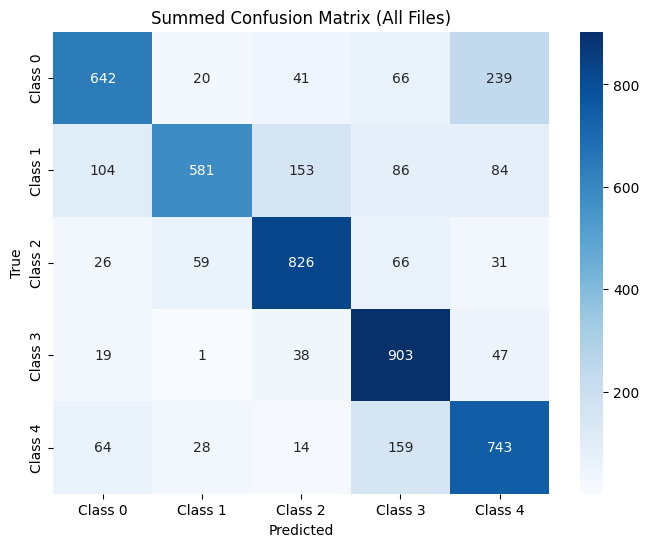

In [ ]:
import os
import copy
import pickle
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from transformers import AutoImageProcessor, AutoModelForImageClassification

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


def calculate_accuracy(outputs, labels):
    """
    outputs.logits => (batch_size, num_labels)
    labels         => (batch_size,)

    Both must be on the same device.
    """
    _, predicted = torch.max(outputs.logits, dim=1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)


def plot_confusion_matrix(cm, class_names=None, title="Confusion Matrix"):
    """
    cm: 2D confusion matrix (already summed or computed).
    class_names: list of string class names (optional)
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
                xticklabels=class_names if class_names else range(len(cm)),
                yticklabels=class_names if class_names else range(len(cm)))
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


class ImageClassifierTrainer:
    def __init__(
        self,
        train_data,       # (train_x, train_y)
        val_data,         # (val_x,   val_y)
        model_name,       # e.g. "google/vit-base-patch16-224-in21k"
        identifier="fold",
        num_labels=5,
        lr=5e-5,
        batch_size=32,
    ):
        """
        train_data => (train_x, train_y)
        val_data   => (val_x, val_y)
        We'll train the entire model end-to-end, with early stopping on val set.
        """
        self.train_x, self.train_y = train_data
        self.val_x,   self.val_y   = val_data
        self.num_labels = num_labels
        self.lr         = lr
        self.batch_size = batch_size
        self.identifier = identifier

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        if self.train_x.ndim != 5:
            raise ValueError("Expect data shape => (samples, frames, H, W, C)")

        self.frames_per_sample = self.train_x.shape[1]  # frames per sample

        self.processor = AutoImageProcessor.from_pretrained(model_name)
        self.model = AutoModelForImageClassification.from_pretrained(model_name)
        self.model.classifier = nn.Linear(self.model.config.hidden_size, self.num_labels)
        self.model.num_labels = self.num_labels
        self.model.to(self.device)

        self.optimizer = optim.AdamW(self.model.parameters(), lr=self.lr)

        self.train_loader = self._make_dataloader(self.train_x, self.train_y, shuffle=True)
        self.val_loader   = self._make_dataloader(self.val_x, self.val_y, shuffle=False)

    def _make_dataloader(self, x, y, shuffle=True):
        """
        x => (samples, frames, H, W, C)
        y => (samples,)

        We'll:
          - Apply HF processor per frame,
          - replicate label across frames.
        """
        pixel_values_list = []
        for i in range(x.shape[0]):
            frames = x[i]  # shape => (frames, H, W, C)
            for frame in frames:
                proc = self.processor(images=frame, return_tensors="pt")
                pixel_values_list.append(proc["pixel_values"].squeeze(0))

        pixel_values = torch.stack(pixel_values_list, dim=0)  # on CPU

        repeated_labels = np.repeat(y, self.frames_per_sample)
        repeated_labels = torch.from_numpy(repeated_labels).long()  # on CPU

        dataset = TensorDataset(pixel_values, repeated_labels)
        loader  = DataLoader(dataset, batch_size=self.batch_size, shuffle=shuffle)
        return loader

    def train_loop(self, epochs=5, patience=3):
        """
        Single-phase training for `epochs`, with early stopping based on validation loss.
        """
        print(f"[{self.identifier}] => Training: epochs={epochs}, patience={patience}")

        if isinstance(self.model, nn.DataParallel):
            self.model = self.model.module

        if torch.cuda.device_count() > 1:
            self.model = nn.DataParallel(self.model)

        best_val_loss      = float("inf")
        best_model_weights = copy.deepcopy(self.model.state_dict())
        epochs_no_improve  = 0

        for epoch in range(1, epochs + 1):
            self.model.train()
            for pixel_values, labels in self.train_loader:
                pixel_values = pixel_values.to(self.device)
                labels       = labels.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(pixel_values=pixel_values, labels=labels)
                loss = outputs.loss
                if loss.dim() > 0:
                    loss = loss.mean()
                loss.backward()
                self.optimizer.step()

            val_loss = self.evaluate_val_loss()
            val_acc  = self.evaluate_val_frame_level()  # optional, for logging only
            print(f"[{self.identifier}] epoch={epoch}/{epochs} => val_loss={val_loss:.4f}, val_acc={val_acc*100:.2f}%")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_weights = copy.deepcopy(self.model.state_dict())
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f"[{self.identifier}] Early stopping at epoch={epoch}")
                    break

        self.model.load_state_dict(best_model_weights)
        print(f"[{self.identifier}] => best_val_loss={best_val_loss:.4f}")

    def evaluate_val_loss(self):
        """
        Compute average validation loss over the val_loader.
        """
        self.model.eval()
        total_loss = 0.0
        count = 0
        with torch.no_grad():
            for pixel_values, labels in self.val_loader:
                pixel_values = pixel_values.to(self.device)
                labels       = labels.to(self.device)
                outputs = self.model(pixel_values=pixel_values, labels=labels)
                loss = outputs.loss
                if loss.dim() > 0:
                    loss = loss.mean()
                total_loss += loss.item()
                count += 1
        return total_loss / max(count, 1)

    def evaluate_val_frame_level(self):
        """
        Quick check: average frame-level accuracy on val_loader (only for logging).
        """
        self.model.eval()
        total_acc = 0.0
        count = 0
        with torch.no_grad():
            for pixel_values, labels in self.val_loader:
                pixel_values = pixel_values.to(self.device)
                labels       = labels.to(self.device)
                outputs = self.model(pixel_values=pixel_values)
                acc = calculate_accuracy(outputs, labels)
                total_acc += acc
                count += 1
        return total_acc / max(count, 1)

    def predict_sample_level(self, x, y, return_preds=False):
        """
        Evaluate on (x, y) with sample-level logic:
         - Build loader (CPU)
         - For each batch, move to GPU
         - Accumulate logits
         - Then average frames for each sample
        """
        loader = self._make_dataloader(x, y, shuffle=False)
        all_logits = []

        self.model.eval()
        with torch.no_grad():
            for pix, lbl in loader:
                pix = pix.to(self.device)
                lbl = lbl.to(self.device)
                outputs = self.model(pixel_values=pix)
                all_logits.append(outputs.logits.cpu().numpy())

        all_logits = np.concatenate(all_logits, axis=0)

        n_samples = x.shape[0]
        frames_per_sample = x.shape[1]
        if all_logits.shape[0] != n_samples * frames_per_sample:
            print(f"[{self.identifier}] mismatch => {all_logits.shape[0]} frames, expected {n_samples*frames_per_sample}")
            return None, None

        all_logits = all_logits.reshape(n_samples, frames_per_sample, -1)
        mean_logits= all_logits.mean(axis=1)
        preds = np.argmax(mean_logits, axis=1)

        acc = accuracy_score(y, preds)
        f1  = f1_score(y, preds, average='weighted')

        if return_preds:
            return acc, f1, preds
        return acc, f1


def main():
    data_dir = "/content/drive/MyDrive/kk/Input_images/Vision"
    model_path = "google/vit-base-patch16-224-in21k"

    num_labels = 5  # Adjust if needed
    summed_cm = np.zeros((num_labels, num_labels), dtype=np.int32)

    all_files = sorted([
        f for f in os.listdir(data_dir)
        if f.lower().endswith(".pkl")
    ])
    print(f"Found {len(all_files)} .pkl files in {data_dir}.")

    overall_test_accs = []
    overall_test_f1s  = []

    for file_name in all_files:
        pkl_path = os.path.join(data_dir, file_name)
        with open(pkl_path, 'rb') as f:
            data_list = pickle.load(f)  # => [train_x, train_y, test_x, test_y]

        if len(data_list) != 4:
            print(f"[{file_name}] => Data mismatch. Skipping.")
            continue

        train_x, train_y, test_x, test_y = data_list
        print(f"\n=== {file_name} ===")
        print(f"train_x={train_x.shape}, train_y={train_y.shape}, "
              f"test_x={test_x.shape}, test_y={test_y.shape}")

        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
        for tr_idx, val_idx in sss.split(train_x, train_y):
            x_train = train_x[tr_idx]
            y_train = train_y[tr_idx]
            x_val   = train_x[val_idx]
            y_val   = train_y[val_idx]

        print(f"[{file_name}] => Train split: {x_train.shape}, Validation split: {x_val.shape}")

        trainer = ImageClassifierTrainer(
            train_data=(x_train, y_train),
            val_data  =(x_val,   y_val),
            model_name=model_path,
            identifier=f"Train_{file_name}",
            num_labels=num_labels,
            lr=5e-5,
            batch_size=32
        )
        trainer.train_loop(epochs=8, patience=3)

        test_acc, test_f1, test_preds = trainer.predict_sample_level(
            test_x, test_y, return_preds=True
        )
        print(f"[{file_name}] => Test ACC={test_acc*100:.2f}%, Test F1={test_f1:.4f}")

        cm = confusion_matrix(test_y, test_preds, labels=range(num_labels))
        summed_cm += cm

        overall_test_accs.append(test_acc)
        overall_test_f1s.append(test_f1)


    valid_accs = [x for x in overall_test_accs if x is not None]
    valid_f1s  = [y for y in overall_test_f1s if y is not None]
    if len(valid_accs) > 0:
        mean_acc = np.mean(valid_accs)
        mean_f1  = np.mean(valid_f1s)
        print(f"\n=== Overall Test => {len(valid_accs)} files ===")
        print(f"Mean ACC = {mean_acc*100:.2f}%")
        print(f"Mean F1  = {mean_f1:.4f}")
    else:
        print("\nNo valid test results to summarize.")


    print("\n=== Summed Confusion Matrix across all files ===")
    print(summed_cm)
    plot_confusion_matrix(
        summed_cm,
        class_names=[f"Class {i}" for i in range(num_labels)],
        title="Summed Confusion Matrix (All Files)"
    )

if __name__ == "__main__":
    main()


Found 42 .pkl files in /content/drive/MyDrive/kk/Input_images/Vision.

=== subject_01_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_01_vis.pkl] Fold 1/5 ===


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_01_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_01_vis.pkl_fold1] epoch=1/8 => val_loss=0.3201, val_acc=91.22%
[subject_01_vis.pkl_fold1] epoch=2/8 => val_loss=0.1531, val_acc=95.67%
[subject_01_vis.pkl_fold1] epoch=3/8 => val_loss=0.2693, val_acc=91.97%
[subject_01_vis.pkl_fold1] epoch=4/8 => val_loss=0.1608, val_acc=95.17%
[subject_01_vis.pkl_fold1] epoch=5/8 => val_loss=0.1476, val_acc=95.03%
[subject_01_vis.pkl_fold1] epoch=6/8 => val_loss=0.1993, val_acc=94.25%
[subject_01_vis.pkl_fold1] epoch=7/8 => val_loss=0.1120, val_acc=96.88%
[subject_01_vis.pkl_fold1] epoch=8/8 => val_loss=0.1324, val_acc=96.80%
[subject_01_vis.pkl_fold1] => best_val_loss=0.1120
[subject_01_vis.pkl] Fold 1 => Test ACC=64.17%, F1=0.6310

=== [File: subject_01_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_01_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_01_vis.pkl_fold2] epoch=1/8 => val_loss=0.3591, val_acc=89.91%
[subject_01_vis.pkl_fold2] epoch=2/8 => val_loss=0.3077, val_acc=90.25%
[subject_01_vis.pkl_fold2] epoch=3/8 => val_loss=0.3350, val_acc=87.71%
[subject_01_vis.pkl_fold2] epoch=4/8 => val_loss=0.3186, val_acc=91.86%
[subject_01_vis.pkl_fold2] epoch=5/8 => val_loss=0.2634, val_acc=92.68%
[subject_01_vis.pkl_fold2] epoch=6/8 => val_loss=0.2471, val_acc=93.32%
[subject_01_vis.pkl_fold2] epoch=7/8 => val_loss=0.2203, val_acc=95.03%
[subject_01_vis.pkl_fold2] epoch=8/8 => val_loss=0.4981, val_acc=86.39%
[subject_01_vis.pkl_fold2] => best_val_loss=0.2203
[subject_01_vis.pkl] Fold 2 => Test ACC=59.17%, F1=0.5860

=== [File: subject_01_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_01_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_01_vis.pkl_fold3] epoch=1/8 => val_loss=0.3260, val_acc=89.35%
[subject_01_vis.pkl_fold3] epoch=2/8 => val_loss=0.2163, val_acc=93.39%
[subject_01_vis.pkl_fold3] epoch=3/8 => val_loss=0.4026, val_acc=85.65%
[subject_01_vis.pkl_fold3] epoch=4/8 => val_loss=0.2173, val_acc=92.90%
[subject_01_vis.pkl_fold3] epoch=5/8 => val_loss=0.2688, val_acc=91.48%
[subject_01_vis.pkl_fold3] Early stopping at epoch=5
[subject_01_vis.pkl_fold3] => best_val_loss=0.2163
[subject_01_vis.pkl] Fold 3 => Test ACC=61.67%, F1=0.5971

=== [File: subject_01_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_01_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_01_vis.pkl_fold4] epoch=1/8 => val_loss=0.4529, val_acc=83.59%
[subject_01_vis.pkl_fold4] epoch=2/8 => val_loss=0.2801, val_acc=90.91%
[subject_01_vis.pkl_fold4] epoch=3/8 => val_loss=0.3230, val_acc=88.71%
[subject_01_vis.pkl_fold4] epoch=4/8 => val_loss=0.2054, val_acc=92.33%
[subject_01_vis.pkl_fold4] epoch=5/8 => val_loss=0.2818, val_acc=90.27%
[subject_01_vis.pkl_fold4] epoch=6/8 => val_loss=0.3352, val_acc=90.13%
[subject_01_vis.pkl_fold4] epoch=7/8 => val_loss=0.1995, val_acc=92.26%
[subject_01_vis.pkl_fold4] epoch=8/8 => val_loss=0.2863, val_acc=91.26%
[subject_01_vis.pkl_fold4] => best_val_loss=0.1995
[subject_01_vis.pkl] Fold 4 => Test ACC=61.67%, F1=0.6058

=== [File: subject_01_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_01_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_01_vis.pkl_fold5] epoch=1/8 => val_loss=0.4864, val_acc=82.53%
[subject_01_vis.pkl_fold5] epoch=2/8 => val_loss=0.3930, val_acc=87.22%
[subject_01_vis.pkl_fold5] epoch=3/8 => val_loss=0.4257, val_acc=84.94%
[subject_01_vis.pkl_fold5] epoch=4/8 => val_loss=0.2332, val_acc=93.18%
[subject_01_vis.pkl_fold5] epoch=5/8 => val_loss=0.2313, val_acc=92.47%
[subject_01_vis.pkl_fold5] epoch=6/8 => val_loss=0.3896, val_acc=88.99%
[subject_01_vis.pkl_fold5] epoch=7/8 => val_loss=0.4378, val_acc=87.93%
[subject_01_vis.pkl_fold5] epoch=8/8 => val_loss=0.4214, val_acc=87.64%
[subject_01_vis.pkl_fold5] Early stopping at epoch=8
[subject_01_vis.pkl_fold5] => best_val_loss=0.2313
[subject_01_vis.pkl] Fold 5 => Test ACC=68.33%, F1=0.6698

=== [File: subject_01_vis.pkl] 5-Fold Mean Test ACC=63.00%, F1=0.6179


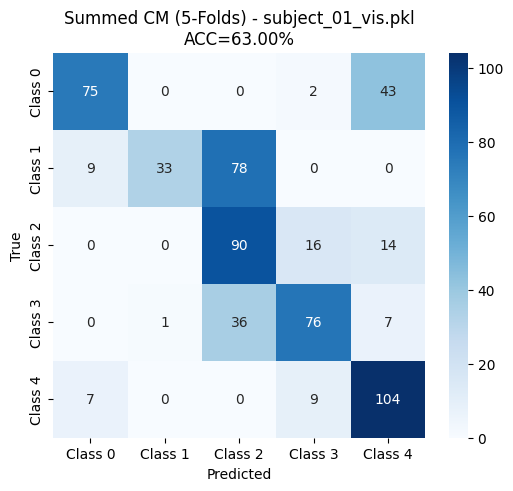


=== subject_02_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_02_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_02_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_02_vis.pkl_fold1] epoch=1/8 => val_loss=0.4667, val_acc=86.91%
[subject_02_vis.pkl_fold1] epoch=2/8 => val_loss=0.3209, val_acc=89.61%
[subject_02_vis.pkl_fold1] epoch=3/8 => val_loss=0.2130, val_acc=93.11%
[subject_02_vis.pkl_fold1] epoch=4/8 => val_loss=0.2422, val_acc=92.47%
[subject_02_vis.pkl_fold1] epoch=5/8 => val_loss=0.1742, val_acc=94.46%
[subject_02_vis.pkl_fold1] epoch=6/8 => val_loss=0.1823, val_acc=94.79%
[subject_02_vis.pkl_fold1] epoch=7/8 => val_loss=0.1916, val_acc=93.99%
[subject_02_vis.pkl_fold1] epoch=8/8 => val_loss=0.1343, val_acc=96.59%
[subject_02_vis.pkl_fold1] => best_val_loss=0.1343
[subject_02_vis.pkl] Fold 1 => Test ACC=65.83%, F1=0.6610

=== [File: subject_02_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_02_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_02_vis.pkl_fold2] epoch=1/8 => val_loss=0.3769, val_acc=88.07%
[subject_02_vis.pkl_fold2] epoch=2/8 => val_loss=0.2907, val_acc=91.41%
[subject_02_vis.pkl_fold2] epoch=3/8 => val_loss=0.2572, val_acc=91.64%
[subject_02_vis.pkl_fold2] epoch=4/8 => val_loss=0.3870, val_acc=88.49%
[subject_02_vis.pkl_fold2] epoch=5/8 => val_loss=0.2419, val_acc=92.76%
[subject_02_vis.pkl_fold2] epoch=6/8 => val_loss=0.1744, val_acc=94.46%
[subject_02_vis.pkl_fold2] epoch=7/8 => val_loss=0.1522, val_acc=95.45%
[subject_02_vis.pkl_fold2] epoch=8/8 => val_loss=0.2634, val_acc=93.25%
[subject_02_vis.pkl_fold2] => best_val_loss=0.1522
[subject_02_vis.pkl] Fold 2 => Test ACC=72.50%, F1=0.7196

=== [File: subject_02_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_02_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_02_vis.pkl_fold3] epoch=1/8 => val_loss=0.3564, val_acc=89.39%
[subject_02_vis.pkl_fold3] epoch=2/8 => val_loss=0.2331, val_acc=92.47%
[subject_02_vis.pkl_fold3] epoch=3/8 => val_loss=0.2871, val_acc=92.19%
[subject_02_vis.pkl_fold3] epoch=4/8 => val_loss=0.2265, val_acc=93.75%
[subject_02_vis.pkl_fold3] epoch=5/8 => val_loss=0.2081, val_acc=94.13%
[subject_02_vis.pkl_fold3] epoch=6/8 => val_loss=0.1802, val_acc=94.53%
[subject_02_vis.pkl_fold3] epoch=7/8 => val_loss=0.1325, val_acc=96.21%
[subject_02_vis.pkl_fold3] epoch=8/8 => val_loss=0.1542, val_acc=96.07%
[subject_02_vis.pkl_fold3] => best_val_loss=0.1325
[subject_02_vis.pkl] Fold 3 => Test ACC=72.50%, F1=0.7280

=== [File: subject_02_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_02_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_02_vis.pkl_fold4] epoch=1/8 => val_loss=0.3764, val_acc=88.75%
[subject_02_vis.pkl_fold4] epoch=2/8 => val_loss=0.3665, val_acc=89.80%
[subject_02_vis.pkl_fold4] epoch=3/8 => val_loss=0.4065, val_acc=87.00%
[subject_02_vis.pkl_fold4] epoch=4/8 => val_loss=0.3276, val_acc=91.12%
[subject_02_vis.pkl_fold4] epoch=5/8 => val_loss=0.3943, val_acc=88.78%
[subject_02_vis.pkl_fold4] epoch=6/8 => val_loss=0.3001, val_acc=91.62%
[subject_02_vis.pkl_fold4] epoch=7/8 => val_loss=0.2254, val_acc=93.87%
[subject_02_vis.pkl_fold4] epoch=8/8 => val_loss=0.2475, val_acc=93.51%
[subject_02_vis.pkl_fold4] => best_val_loss=0.2254
[subject_02_vis.pkl] Fold 4 => Test ACC=70.00%, F1=0.6977

=== [File: subject_02_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_02_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_02_vis.pkl_fold5] epoch=1/8 => val_loss=0.4969, val_acc=83.52%
[subject_02_vis.pkl_fold5] epoch=2/8 => val_loss=0.3540, val_acc=88.40%
[subject_02_vis.pkl_fold5] epoch=3/8 => val_loss=0.2666, val_acc=90.79%
[subject_02_vis.pkl_fold5] epoch=4/8 => val_loss=0.3251, val_acc=91.24%
[subject_02_vis.pkl_fold5] epoch=5/8 => val_loss=0.1790, val_acc=94.67%
[subject_02_vis.pkl_fold5] epoch=6/8 => val_loss=0.7524, val_acc=80.26%
[subject_02_vis.pkl_fold5] epoch=7/8 => val_loss=0.4951, val_acc=87.36%
[subject_02_vis.pkl_fold5] epoch=8/8 => val_loss=0.2147, val_acc=93.89%
[subject_02_vis.pkl_fold5] Early stopping at epoch=8
[subject_02_vis.pkl_fold5] => best_val_loss=0.1790
[subject_02_vis.pkl] Fold 5 => Test ACC=69.17%, F1=0.7007

=== [File: subject_02_vis.pkl] 5-Fold Mean Test ACC=70.00%, F1=0.7014


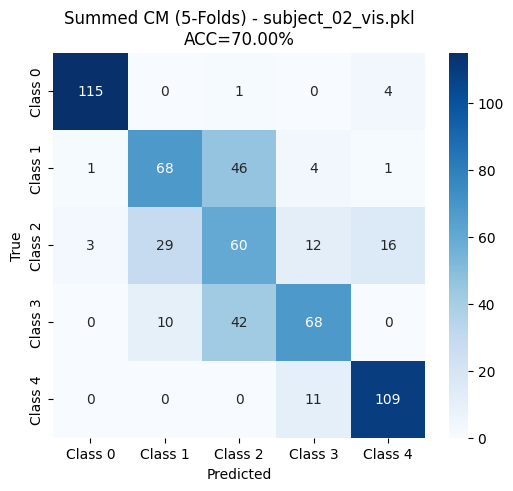


=== subject_03_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_03_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_03_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_03_vis.pkl_fold1] epoch=1/8 => val_loss=0.5150, val_acc=84.52%
[subject_03_vis.pkl_fold1] epoch=2/8 => val_loss=0.4648, val_acc=85.04%
[subject_03_vis.pkl_fold1] epoch=3/8 => val_loss=0.3799, val_acc=87.88%
[subject_03_vis.pkl_fold1] epoch=4/8 => val_loss=0.3975, val_acc=87.71%
[subject_03_vis.pkl_fold1] epoch=5/8 => val_loss=0.3277, val_acc=88.90%
[subject_03_vis.pkl_fold1] epoch=6/8 => val_loss=0.3200, val_acc=90.58%
[subject_03_vis.pkl_fold1] epoch=7/8 => val_loss=0.3132, val_acc=91.95%
[subject_03_vis.pkl_fold1] epoch=8/8 => val_loss=0.3239, val_acc=90.89%
[subject_03_vis.pkl_fold1] => best_val_loss=0.3132
[subject_03_vis.pkl] Fold 1 => Test ACC=77.50%, F1=0.7644

=== [File: subject_03_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_03_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_03_vis.pkl_fold2] epoch=1/8 => val_loss=0.4184, val_acc=88.09%
[subject_03_vis.pkl_fold2] epoch=2/8 => val_loss=0.3761, val_acc=87.41%
[subject_03_vis.pkl_fold2] epoch=3/8 => val_loss=0.3282, val_acc=89.77%
[subject_03_vis.pkl_fold2] epoch=4/8 => val_loss=0.3774, val_acc=88.04%
[subject_03_vis.pkl_fold2] epoch=5/8 => val_loss=0.5107, val_acc=85.72%
[subject_03_vis.pkl_fold2] epoch=6/8 => val_loss=0.3812, val_acc=90.65%
[subject_03_vis.pkl_fold2] Early stopping at epoch=6
[subject_03_vis.pkl_fold2] => best_val_loss=0.3282
[subject_03_vis.pkl] Fold 2 => Test ACC=84.17%, F1=0.8369

=== [File: subject_03_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_03_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_03_vis.pkl_fold3] epoch=1/8 => val_loss=0.3927, val_acc=86.72%
[subject_03_vis.pkl_fold3] epoch=2/8 => val_loss=0.3086, val_acc=88.92%
[subject_03_vis.pkl_fold3] epoch=3/8 => val_loss=0.3442, val_acc=88.49%
[subject_03_vis.pkl_fold3] epoch=4/8 => val_loss=0.3363, val_acc=90.22%
[subject_03_vis.pkl_fold3] epoch=5/8 => val_loss=0.2469, val_acc=91.45%
[subject_03_vis.pkl_fold3] epoch=6/8 => val_loss=0.2877, val_acc=90.77%
[subject_03_vis.pkl_fold3] epoch=7/8 => val_loss=0.2433, val_acc=91.62%
[subject_03_vis.pkl_fold3] epoch=8/8 => val_loss=0.2669, val_acc=92.12%
[subject_03_vis.pkl_fold3] => best_val_loss=0.2433
[subject_03_vis.pkl] Fold 3 => Test ACC=75.83%, F1=0.7462

=== [File: subject_03_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_03_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_03_vis.pkl_fold4] epoch=1/8 => val_loss=0.5012, val_acc=80.80%
[subject_03_vis.pkl_fold4] epoch=2/8 => val_loss=0.4319, val_acc=85.63%
[subject_03_vis.pkl_fold4] epoch=3/8 => val_loss=0.3608, val_acc=89.49%
[subject_03_vis.pkl_fold4] epoch=4/8 => val_loss=0.3885, val_acc=87.76%
[subject_03_vis.pkl_fold4] epoch=5/8 => val_loss=0.2951, val_acc=91.12%
[subject_03_vis.pkl_fold4] epoch=6/8 => val_loss=0.2903, val_acc=91.67%
[subject_03_vis.pkl_fold4] epoch=7/8 => val_loss=0.5730, val_acc=84.66%
[subject_03_vis.pkl_fold4] epoch=8/8 => val_loss=0.3308, val_acc=90.89%
[subject_03_vis.pkl_fold4] => best_val_loss=0.2903
[subject_03_vis.pkl] Fold 4 => Test ACC=81.67%, F1=0.8118

=== [File: subject_03_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_03_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_03_vis.pkl_fold5] epoch=1/8 => val_loss=0.4776, val_acc=85.94%
[subject_03_vis.pkl_fold5] epoch=2/8 => val_loss=0.3707, val_acc=89.42%
[subject_03_vis.pkl_fold5] epoch=3/8 => val_loss=0.3821, val_acc=88.71%
[subject_03_vis.pkl_fold5] epoch=4/8 => val_loss=0.4620, val_acc=85.72%
[subject_03_vis.pkl_fold5] epoch=5/8 => val_loss=0.4127, val_acc=89.13%
[subject_03_vis.pkl_fold5] Early stopping at epoch=5
[subject_03_vis.pkl_fold5] => best_val_loss=0.3707
[subject_03_vis.pkl] Fold 5 => Test ACC=75.83%, F1=0.7443

=== [File: subject_03_vis.pkl] 5-Fold Mean Test ACC=79.00%, F1=0.7807


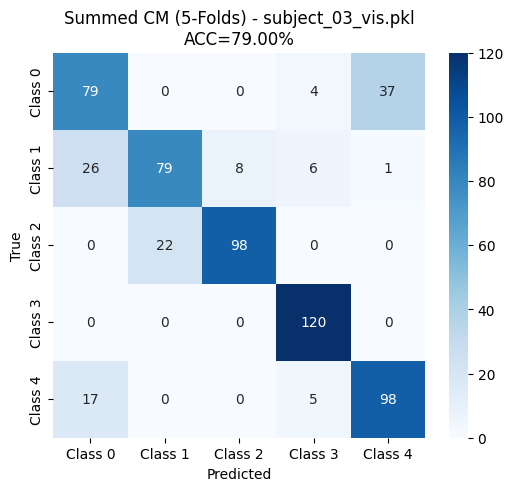


=== subject_04_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_04_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_04_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_04_vis.pkl_fold1] epoch=1/8 => val_loss=0.5154, val_acc=82.88%
[subject_04_vis.pkl_fold1] epoch=2/8 => val_loss=0.4220, val_acc=86.70%
[subject_04_vis.pkl_fold1] epoch=3/8 => val_loss=0.3663, val_acc=89.70%
[subject_04_vis.pkl_fold1] epoch=4/8 => val_loss=0.6559, val_acc=81.39%
[subject_04_vis.pkl_fold1] epoch=5/8 => val_loss=0.3076, val_acc=92.07%
[subject_04_vis.pkl_fold1] epoch=6/8 => val_loss=0.3003, val_acc=92.97%
[subject_04_vis.pkl_fold1] epoch=7/8 => val_loss=0.2961, val_acc=92.97%
[subject_04_vis.pkl_fold1] epoch=8/8 => val_loss=0.3106, val_acc=92.90%
[subject_04_vis.pkl_fold1] => best_val_loss=0.2961
[subject_04_vis.pkl] Fold 1 => Test ACC=81.67%, F1=0.8182

=== [File: subject_04_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_04_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_04_vis.pkl_fold2] epoch=1/8 => val_loss=0.5729, val_acc=78.91%
[subject_04_vis.pkl_fold2] epoch=2/8 => val_loss=0.4513, val_acc=86.36%
[subject_04_vis.pkl_fold2] epoch=3/8 => val_loss=0.4996, val_acc=85.58%
[subject_04_vis.pkl_fold2] epoch=4/8 => val_loss=0.2932, val_acc=91.05%
[subject_04_vis.pkl_fold2] epoch=5/8 => val_loss=0.2904, val_acc=92.97%
[subject_04_vis.pkl_fold2] epoch=6/8 => val_loss=0.2780, val_acc=92.85%
[subject_04_vis.pkl_fold2] epoch=7/8 => val_loss=0.2766, val_acc=92.78%
[subject_04_vis.pkl_fold2] epoch=8/8 => val_loss=0.2559, val_acc=92.64%
[subject_04_vis.pkl_fold2] => best_val_loss=0.2559
[subject_04_vis.pkl] Fold 2 => Test ACC=80.00%, F1=0.8026

=== [File: subject_04_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_04_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_04_vis.pkl_fold3] epoch=1/8 => val_loss=0.4167, val_acc=87.45%
[subject_04_vis.pkl_fold3] epoch=2/8 => val_loss=0.2675, val_acc=92.61%
[subject_04_vis.pkl_fold3] epoch=3/8 => val_loss=0.2290, val_acc=93.54%
[subject_04_vis.pkl_fold3] epoch=4/8 => val_loss=0.2590, val_acc=92.68%
[subject_04_vis.pkl_fold3] epoch=5/8 => val_loss=0.2695, val_acc=92.76%
[subject_04_vis.pkl_fold3] epoch=6/8 => val_loss=0.2508, val_acc=93.82%
[subject_04_vis.pkl_fold3] Early stopping at epoch=6
[subject_04_vis.pkl_fold3] => best_val_loss=0.2290
[subject_04_vis.pkl] Fold 3 => Test ACC=77.50%, F1=0.7798

=== [File: subject_04_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_04_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_04_vis.pkl_fold4] epoch=1/8 => val_loss=0.3696, val_acc=88.78%
[subject_04_vis.pkl_fold4] epoch=2/8 => val_loss=0.2578, val_acc=91.81%
[subject_04_vis.pkl_fold4] epoch=3/8 => val_loss=0.2154, val_acc=92.90%
[subject_04_vis.pkl_fold4] epoch=4/8 => val_loss=0.1969, val_acc=93.32%
[subject_04_vis.pkl_fold4] epoch=5/8 => val_loss=0.1531, val_acc=95.24%
[subject_04_vis.pkl_fold4] epoch=6/8 => val_loss=0.2144, val_acc=94.18%
[subject_04_vis.pkl_fold4] epoch=7/8 => val_loss=0.4665, val_acc=86.01%
[subject_04_vis.pkl_fold4] epoch=8/8 => val_loss=0.3346, val_acc=90.77%
[subject_04_vis.pkl_fold4] Early stopping at epoch=8
[subject_04_vis.pkl_fold4] => best_val_loss=0.1531
[subject_04_vis.pkl] Fold 4 => Test ACC=87.50%, F1=0.8739

=== [File: subject_04_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_04_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_04_vis.pkl_fold5] epoch=1/8 => val_loss=0.4721, val_acc=83.55%
[subject_04_vis.pkl_fold5] epoch=2/8 => val_loss=0.3453, val_acc=88.97%
[subject_04_vis.pkl_fold5] epoch=3/8 => val_loss=0.3348, val_acc=89.20%
[subject_04_vis.pkl_fold5] epoch=4/8 => val_loss=0.2484, val_acc=92.40%
[subject_04_vis.pkl_fold5] epoch=5/8 => val_loss=0.1792, val_acc=94.51%
[subject_04_vis.pkl_fold5] epoch=6/8 => val_loss=0.1835, val_acc=94.86%
[subject_04_vis.pkl_fold5] epoch=7/8 => val_loss=0.2153, val_acc=94.03%
[subject_04_vis.pkl_fold5] epoch=8/8 => val_loss=0.2176, val_acc=94.22%
[subject_04_vis.pkl_fold5] Early stopping at epoch=8
[subject_04_vis.pkl_fold5] => best_val_loss=0.1792
[subject_04_vis.pkl] Fold 5 => Test ACC=82.50%, F1=0.8252

=== [File: subject_04_vis.pkl] 5-Fold Mean Test ACC=81.83%, F1=0.8200


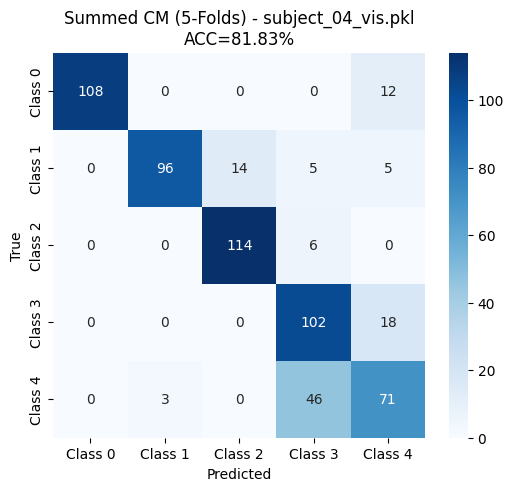


=== subject_05_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_05_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_05_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_05_vis.pkl_fold1] epoch=1/8 => val_loss=0.4935, val_acc=82.46%
[subject_05_vis.pkl_fold1] epoch=2/8 => val_loss=0.3738, val_acc=87.57%
[subject_05_vis.pkl_fold1] epoch=3/8 => val_loss=0.3038, val_acc=90.41%
[subject_05_vis.pkl_fold1] epoch=4/8 => val_loss=0.3047, val_acc=89.96%
[subject_05_vis.pkl_fold1] epoch=5/8 => val_loss=0.2909, val_acc=91.62%
[subject_05_vis.pkl_fold1] epoch=6/8 => val_loss=0.2697, val_acc=92.02%
[subject_05_vis.pkl_fold1] epoch=7/8 => val_loss=0.3199, val_acc=90.96%
[subject_05_vis.pkl_fold1] epoch=8/8 => val_loss=0.2895, val_acc=92.47%
[subject_05_vis.pkl_fold1] => best_val_loss=0.2697
[subject_05_vis.pkl] Fold 1 => Test ACC=52.50%, F1=0.5071

=== [File: subject_05_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_05_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_05_vis.pkl_fold2] epoch=1/8 => val_loss=0.7002, val_acc=77.53%
[subject_05_vis.pkl_fold2] epoch=2/8 => val_loss=0.4536, val_acc=86.34%
[subject_05_vis.pkl_fold2] epoch=3/8 => val_loss=0.4734, val_acc=86.72%
[subject_05_vis.pkl_fold2] epoch=4/8 => val_loss=0.5943, val_acc=85.11%
[subject_05_vis.pkl_fold2] epoch=5/8 => val_loss=0.4209, val_acc=89.80%
[subject_05_vis.pkl_fold2] epoch=6/8 => val_loss=0.5517, val_acc=86.74%
[subject_05_vis.pkl_fold2] epoch=7/8 => val_loss=0.4587, val_acc=89.09%
[subject_05_vis.pkl_fold2] epoch=8/8 => val_loss=0.5089, val_acc=84.75%
[subject_05_vis.pkl_fold2] Early stopping at epoch=8
[subject_05_vis.pkl_fold2] => best_val_loss=0.4209
[subject_05_vis.pkl] Fold 2 => Test ACC=65.00%, F1=0.6412

=== [File: subject_05_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_05_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_05_vis.pkl_fold3] epoch=1/8 => val_loss=0.4115, val_acc=89.11%
[subject_05_vis.pkl_fold3] epoch=2/8 => val_loss=0.3593, val_acc=90.03%
[subject_05_vis.pkl_fold3] epoch=3/8 => val_loss=0.2941, val_acc=91.34%
[subject_05_vis.pkl_fold3] epoch=4/8 => val_loss=0.4414, val_acc=87.74%
[subject_05_vis.pkl_fold3] epoch=5/8 => val_loss=0.3051, val_acc=91.79%
[subject_05_vis.pkl_fold3] epoch=6/8 => val_loss=0.3675, val_acc=89.89%
[subject_05_vis.pkl_fold3] Early stopping at epoch=6
[subject_05_vis.pkl_fold3] => best_val_loss=0.2941
[subject_05_vis.pkl] Fold 3 => Test ACC=75.00%, F1=0.7284

=== [File: subject_05_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_05_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_05_vis.pkl_fold4] epoch=1/8 => val_loss=0.5606, val_acc=80.18%
[subject_05_vis.pkl_fold4] epoch=2/8 => val_loss=0.3536, val_acc=88.49%
[subject_05_vis.pkl_fold4] epoch=3/8 => val_loss=0.4815, val_acc=84.09%
[subject_05_vis.pkl_fold4] epoch=4/8 => val_loss=0.4622, val_acc=84.16%
[subject_05_vis.pkl_fold4] epoch=5/8 => val_loss=0.4865, val_acc=85.96%
[subject_05_vis.pkl_fold4] Early stopping at epoch=5
[subject_05_vis.pkl_fold4] => best_val_loss=0.3536
[subject_05_vis.pkl] Fold 4 => Test ACC=56.67%, F1=0.5500

=== [File: subject_05_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_05_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_05_vis.pkl_fold5] epoch=1/8 => val_loss=0.3975, val_acc=88.19%
[subject_05_vis.pkl_fold5] epoch=2/8 => val_loss=0.2643, val_acc=91.74%
[subject_05_vis.pkl_fold5] epoch=3/8 => val_loss=0.1923, val_acc=93.96%
[subject_05_vis.pkl_fold5] epoch=4/8 => val_loss=0.1939, val_acc=94.39%
[subject_05_vis.pkl_fold5] epoch=5/8 => val_loss=0.1697, val_acc=95.45%
[subject_05_vis.pkl_fold5] epoch=6/8 => val_loss=0.1805, val_acc=93.87%
[subject_05_vis.pkl_fold5] epoch=7/8 => val_loss=0.1725, val_acc=94.82%
[subject_05_vis.pkl_fold5] epoch=8/8 => val_loss=0.2105, val_acc=94.03%
[subject_05_vis.pkl_fold5] Early stopping at epoch=8
[subject_05_vis.pkl_fold5] => best_val_loss=0.1697
[subject_05_vis.pkl] Fold 5 => Test ACC=63.33%, F1=0.6205

=== [File: subject_05_vis.pkl] 5-Fold Mean Test ACC=62.50%, F1=0.6094


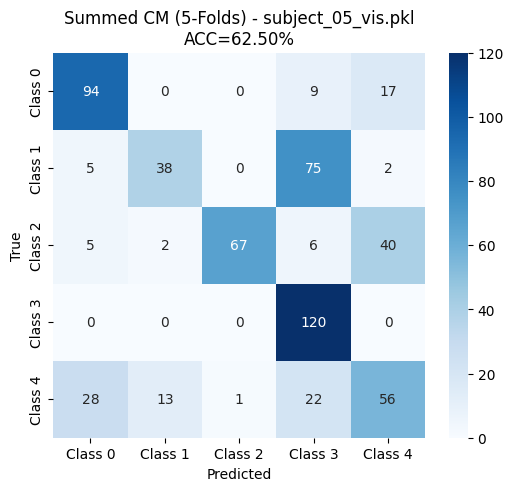


=== subject_06_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_06_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_06_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_06_vis.pkl_fold1] epoch=1/8 => val_loss=0.3876, val_acc=87.90%
[subject_06_vis.pkl_fold1] epoch=2/8 => val_loss=0.2418, val_acc=92.47%
[subject_06_vis.pkl_fold1] epoch=3/8 => val_loss=0.1873, val_acc=93.94%
[subject_06_vis.pkl_fold1] epoch=4/8 => val_loss=0.1966, val_acc=94.22%
[subject_06_vis.pkl_fold1] epoch=5/8 => val_loss=0.2020, val_acc=93.54%
[subject_06_vis.pkl_fold1] epoch=6/8 => val_loss=0.3165, val_acc=92.26%
[subject_06_vis.pkl_fold1] Early stopping at epoch=6
[subject_06_vis.pkl_fold1] => best_val_loss=0.1873
[subject_06_vis.pkl] Fold 1 => Test ACC=81.67%, F1=0.8119

=== [File: subject_06_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_06_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_06_vis.pkl_fold2] epoch=1/8 => val_loss=0.3907, val_acc=87.10%
[subject_06_vis.pkl_fold2] epoch=2/8 => val_loss=0.2930, val_acc=90.93%
[subject_06_vis.pkl_fold2] epoch=3/8 => val_loss=0.3629, val_acc=88.35%
[subject_06_vis.pkl_fold2] epoch=4/8 => val_loss=0.2259, val_acc=93.18%
[subject_06_vis.pkl_fold2] epoch=5/8 => val_loss=0.2614, val_acc=93.39%
[subject_06_vis.pkl_fold2] epoch=6/8 => val_loss=0.1960, val_acc=94.86%
[subject_06_vis.pkl_fold2] epoch=7/8 => val_loss=0.2122, val_acc=94.32%
[subject_06_vis.pkl_fold2] epoch=8/8 => val_loss=0.2178, val_acc=94.25%
[subject_06_vis.pkl_fold2] => best_val_loss=0.1960
[subject_06_vis.pkl] Fold 2 => Test ACC=77.50%, F1=0.7650

=== [File: subject_06_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_06_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_06_vis.pkl_fold3] epoch=1/8 => val_loss=0.3831, val_acc=88.00%
[subject_06_vis.pkl_fold3] epoch=2/8 => val_loss=0.3695, val_acc=89.49%
[subject_06_vis.pkl_fold3] epoch=3/8 => val_loss=0.2571, val_acc=93.11%
[subject_06_vis.pkl_fold3] epoch=4/8 => val_loss=0.2361, val_acc=93.32%
[subject_06_vis.pkl_fold3] epoch=5/8 => val_loss=0.1973, val_acc=94.32%
[subject_06_vis.pkl_fold3] epoch=6/8 => val_loss=0.2227, val_acc=93.68%
[subject_06_vis.pkl_fold3] epoch=7/8 => val_loss=0.2002, val_acc=93.96%
[subject_06_vis.pkl_fold3] epoch=8/8 => val_loss=0.1983, val_acc=94.96%
[subject_06_vis.pkl_fold3] Early stopping at epoch=8
[subject_06_vis.pkl_fold3] => best_val_loss=0.1973
[subject_06_vis.pkl] Fold 3 => Test ACC=75.83%, F1=0.7518

=== [File: subject_06_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_06_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_06_vis.pkl_fold4] epoch=1/8 => val_loss=0.4865, val_acc=83.05%
[subject_06_vis.pkl_fold4] epoch=2/8 => val_loss=0.4197, val_acc=86.70%
[subject_06_vis.pkl_fold4] epoch=3/8 => val_loss=0.3871, val_acc=87.48%
[subject_06_vis.pkl_fold4] epoch=4/8 => val_loss=0.4024, val_acc=87.62%
[subject_06_vis.pkl_fold4] epoch=5/8 => val_loss=0.5339, val_acc=85.20%
[subject_06_vis.pkl_fold4] epoch=6/8 => val_loss=0.3818, val_acc=89.23%
[subject_06_vis.pkl_fold4] epoch=7/8 => val_loss=0.5194, val_acc=85.84%
[subject_06_vis.pkl_fold4] epoch=8/8 => val_loss=0.4824, val_acc=88.68%
[subject_06_vis.pkl_fold4] => best_val_loss=0.3818
[subject_06_vis.pkl] Fold 4 => Test ACC=70.83%, F1=0.7103

=== [File: subject_06_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_06_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_06_vis.pkl_fold5] epoch=1/8 => val_loss=0.4833, val_acc=81.82%
[subject_06_vis.pkl_fold5] epoch=2/8 => val_loss=0.3423, val_acc=88.64%
[subject_06_vis.pkl_fold5] epoch=3/8 => val_loss=0.3389, val_acc=90.06%
[subject_06_vis.pkl_fold5] epoch=4/8 => val_loss=0.3334, val_acc=89.84%
[subject_06_vis.pkl_fold5] epoch=5/8 => val_loss=0.4879, val_acc=86.01%
[subject_06_vis.pkl_fold5] epoch=6/8 => val_loss=0.4656, val_acc=86.86%
[subject_06_vis.pkl_fold5] epoch=7/8 => val_loss=0.3723, val_acc=90.55%
[subject_06_vis.pkl_fold5] Early stopping at epoch=7
[subject_06_vis.pkl_fold5] => best_val_loss=0.3334
[subject_06_vis.pkl] Fold 5 => Test ACC=67.50%, F1=0.6663

=== [File: subject_06_vis.pkl] 5-Fold Mean Test ACC=74.67%, F1=0.7410


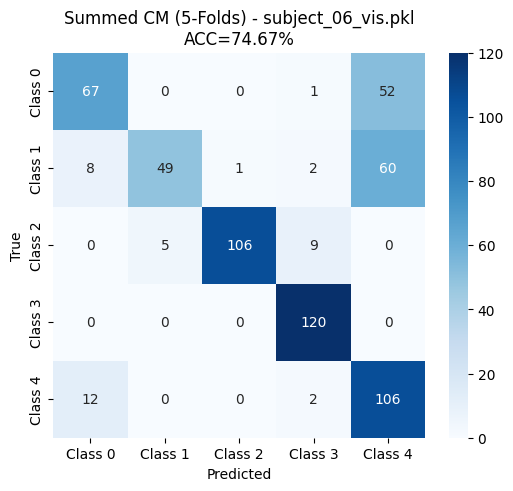


=== subject_07_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_07_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_07_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_07_vis.pkl_fold1] epoch=1/8 => val_loss=0.1936, val_acc=95.81%
[subject_07_vis.pkl_fold1] epoch=2/8 => val_loss=0.4072, val_acc=85.65%
[subject_07_vis.pkl_fold1] epoch=3/8 => val_loss=0.2157, val_acc=93.61%
[subject_07_vis.pkl_fold1] epoch=4/8 => val_loss=0.3178, val_acc=91.90%
[subject_07_vis.pkl_fold1] Early stopping at epoch=4
[subject_07_vis.pkl_fold1] => best_val_loss=0.1936
[subject_07_vis.pkl] Fold 1 => Test ACC=82.50%, F1=0.8220

=== [File: subject_07_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_07_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_07_vis.pkl_fold2] epoch=1/8 => val_loss=0.2058, val_acc=94.89%
[subject_07_vis.pkl_fold2] epoch=2/8 => val_loss=0.2261, val_acc=91.90%
[subject_07_vis.pkl_fold2] epoch=3/8 => val_loss=0.1566, val_acc=95.45%
[subject_07_vis.pkl_fold2] epoch=4/8 => val_loss=0.2177, val_acc=94.20%
[subject_07_vis.pkl_fold2] epoch=5/8 => val_loss=0.1869, val_acc=95.15%
[subject_07_vis.pkl_fold2] epoch=6/8 => val_loss=0.0901, val_acc=97.89%
[subject_07_vis.pkl_fold2] epoch=7/8 => val_loss=0.1118, val_acc=96.71%
[subject_07_vis.pkl_fold2] epoch=8/8 => val_loss=0.0906, val_acc=97.85%
[subject_07_vis.pkl_fold2] => best_val_loss=0.0901
[subject_07_vis.pkl] Fold 2 => Test ACC=89.17%, F1=0.8907

=== [File: subject_07_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_07_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_07_vis.pkl_fold3] epoch=1/8 => val_loss=0.1671, val_acc=97.59%
[subject_07_vis.pkl_fold3] epoch=2/8 => val_loss=0.1000, val_acc=97.94%
[subject_07_vis.pkl_fold3] epoch=3/8 => val_loss=0.1811, val_acc=94.60%
[subject_07_vis.pkl_fold3] epoch=4/8 => val_loss=0.1024, val_acc=97.23%
[subject_07_vis.pkl_fold3] epoch=5/8 => val_loss=0.1077, val_acc=97.09%
[subject_07_vis.pkl_fold3] Early stopping at epoch=5
[subject_07_vis.pkl_fold3] => best_val_loss=0.1000
[subject_07_vis.pkl] Fold 3 => Test ACC=77.50%, F1=0.7580

=== [File: subject_07_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_07_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_07_vis.pkl_fold4] epoch=1/8 => val_loss=0.3338, val_acc=90.86%
[subject_07_vis.pkl_fold4] epoch=2/8 => val_loss=0.4015, val_acc=89.49%
[subject_07_vis.pkl_fold4] epoch=3/8 => val_loss=0.2872, val_acc=93.11%
[subject_07_vis.pkl_fold4] epoch=4/8 => val_loss=0.4014, val_acc=88.42%
[subject_07_vis.pkl_fold4] epoch=5/8 => val_loss=0.3078, val_acc=92.97%
[subject_07_vis.pkl_fold4] epoch=6/8 => val_loss=0.4519, val_acc=90.77%
[subject_07_vis.pkl_fold4] Early stopping at epoch=6
[subject_07_vis.pkl_fold4] => best_val_loss=0.2872
[subject_07_vis.pkl] Fold 4 => Test ACC=83.33%, F1=0.8394

=== [File: subject_07_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_07_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_07_vis.pkl_fold5] epoch=1/8 => val_loss=0.3619, val_acc=87.78%
[subject_07_vis.pkl_fold5] epoch=2/8 => val_loss=0.1957, val_acc=94.32%
[subject_07_vis.pkl_fold5] epoch=3/8 => val_loss=0.1652, val_acc=95.74%
[subject_07_vis.pkl_fold5] epoch=4/8 => val_loss=0.1934, val_acc=94.60%
[subject_07_vis.pkl_fold5] epoch=5/8 => val_loss=0.2490, val_acc=93.75%
[subject_07_vis.pkl_fold5] epoch=6/8 => val_loss=0.1460, val_acc=96.80%
[subject_07_vis.pkl_fold5] epoch=7/8 => val_loss=0.1170, val_acc=97.09%
[subject_07_vis.pkl_fold5] epoch=8/8 => val_loss=0.1281, val_acc=96.88%
[subject_07_vis.pkl_fold5] => best_val_loss=0.1170
[subject_07_vis.pkl] Fold 5 => Test ACC=62.50%, F1=0.5911

=== [File: subject_07_vis.pkl] 5-Fold Mean Test ACC=79.00%, F1=0.7802


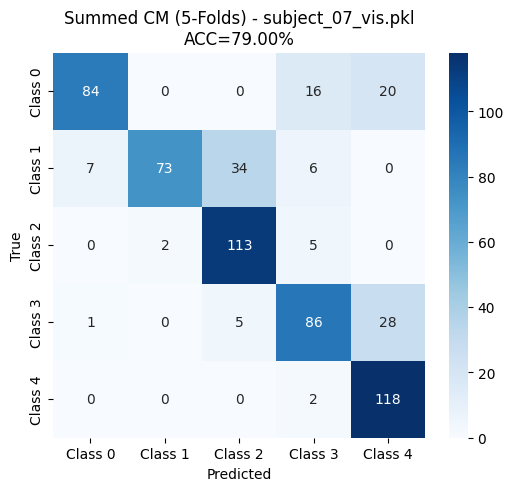


=== subject_08_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_08_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_08_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_08_vis.pkl_fold1] epoch=1/8 => val_loss=0.3813, val_acc=89.20%
[subject_08_vis.pkl_fold1] epoch=2/8 => val_loss=0.2305, val_acc=93.25%
[subject_08_vis.pkl_fold1] epoch=3/8 => val_loss=0.2539, val_acc=92.80%
[subject_08_vis.pkl_fold1] epoch=4/8 => val_loss=0.2241, val_acc=93.54%
[subject_08_vis.pkl_fold1] epoch=5/8 => val_loss=0.1575, val_acc=94.96%
[subject_08_vis.pkl_fold1] epoch=6/8 => val_loss=0.3181, val_acc=90.91%
[subject_08_vis.pkl_fold1] epoch=7/8 => val_loss=0.2021, val_acc=94.22%
[subject_08_vis.pkl_fold1] epoch=8/8 => val_loss=0.1914, val_acc=94.25%
[subject_08_vis.pkl_fold1] Early stopping at epoch=8
[subject_08_vis.pkl_fold1] => best_val_loss=0.1575
[subject_08_vis.pkl] Fold 1 => Test ACC=80.00%, F1=0.7852

=== [File: subject_08_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_08_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_08_vis.pkl_fold2] epoch=1/8 => val_loss=0.3574, val_acc=90.39%
[subject_08_vis.pkl_fold2] epoch=2/8 => val_loss=0.2711, val_acc=91.05%
[subject_08_vis.pkl_fold2] epoch=3/8 => val_loss=0.3108, val_acc=89.28%
[subject_08_vis.pkl_fold2] epoch=4/8 => val_loss=0.2967, val_acc=90.81%
[subject_08_vis.pkl_fold2] epoch=5/8 => val_loss=0.3105, val_acc=90.58%
[subject_08_vis.pkl_fold2] Early stopping at epoch=5
[subject_08_vis.pkl_fold2] => best_val_loss=0.2711
[subject_08_vis.pkl] Fold 2 => Test ACC=69.17%, F1=0.6619

=== [File: subject_08_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_08_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_08_vis.pkl_fold3] epoch=1/8 => val_loss=0.3238, val_acc=91.48%
[subject_08_vis.pkl_fold3] epoch=2/8 => val_loss=0.2553, val_acc=93.32%
[subject_08_vis.pkl_fold3] epoch=3/8 => val_loss=0.2805, val_acc=92.47%
[subject_08_vis.pkl_fold3] epoch=4/8 => val_loss=0.2026, val_acc=94.39%
[subject_08_vis.pkl_fold3] epoch=5/8 => val_loss=0.2016, val_acc=94.32%
[subject_08_vis.pkl_fold3] epoch=6/8 => val_loss=0.1968, val_acc=94.03%
[subject_08_vis.pkl_fold3] epoch=7/8 => val_loss=0.1690, val_acc=95.74%
[subject_08_vis.pkl_fold3] epoch=8/8 => val_loss=0.2579, val_acc=93.39%
[subject_08_vis.pkl_fold3] => best_val_loss=0.1690
[subject_08_vis.pkl] Fold 3 => Test ACC=74.17%, F1=0.7297

=== [File: subject_08_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_08_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_08_vis.pkl_fold4] epoch=1/8 => val_loss=0.3767, val_acc=89.06%
[subject_08_vis.pkl_fold4] epoch=2/8 => val_loss=0.3471, val_acc=87.86%
[subject_08_vis.pkl_fold4] epoch=3/8 => val_loss=0.2750, val_acc=91.03%
[subject_08_vis.pkl_fold4] epoch=4/8 => val_loss=0.3769, val_acc=87.93%
[subject_08_vis.pkl_fold4] epoch=5/8 => val_loss=0.3074, val_acc=90.62%
[subject_08_vis.pkl_fold4] epoch=6/8 => val_loss=0.3103, val_acc=90.84%
[subject_08_vis.pkl_fold4] Early stopping at epoch=6
[subject_08_vis.pkl_fold4] => best_val_loss=0.2750
[subject_08_vis.pkl] Fold 4 => Test ACC=71.67%, F1=0.6942

=== [File: subject_08_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_08_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_08_vis.pkl_fold5] epoch=1/8 => val_loss=0.3930, val_acc=89.13%
[subject_08_vis.pkl_fold5] epoch=2/8 => val_loss=0.3894, val_acc=89.06%
[subject_08_vis.pkl_fold5] epoch=3/8 => val_loss=0.3042, val_acc=90.34%
[subject_08_vis.pkl_fold5] epoch=4/8 => val_loss=0.3752, val_acc=89.13%
[subject_08_vis.pkl_fold5] epoch=5/8 => val_loss=0.3635, val_acc=89.63%
[subject_08_vis.pkl_fold5] epoch=6/8 => val_loss=0.4202, val_acc=89.06%
[subject_08_vis.pkl_fold5] Early stopping at epoch=6
[subject_08_vis.pkl_fold5] => best_val_loss=0.3042
[subject_08_vis.pkl] Fold 5 => Test ACC=80.00%, F1=0.7839

=== [File: subject_08_vis.pkl] 5-Fold Mean Test ACC=75.00%, F1=0.7310


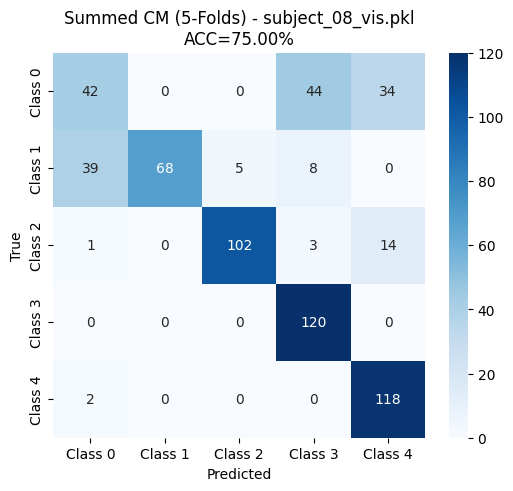


=== subject_09_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_09_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_09_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_09_vis.pkl_fold1] epoch=1/8 => val_loss=0.4230, val_acc=86.32%
[subject_09_vis.pkl_fold1] epoch=2/8 => val_loss=0.2929, val_acc=90.48%
[subject_09_vis.pkl_fold1] epoch=3/8 => val_loss=0.2386, val_acc=92.09%
[subject_09_vis.pkl_fold1] epoch=4/8 => val_loss=0.2206, val_acc=92.05%
[subject_09_vis.pkl_fold1] epoch=5/8 => val_loss=0.2708, val_acc=91.48%
[subject_09_vis.pkl_fold1] epoch=6/8 => val_loss=0.2182, val_acc=93.70%
[subject_09_vis.pkl_fold1] epoch=7/8 => val_loss=0.4762, val_acc=87.95%
[subject_09_vis.pkl_fold1] epoch=8/8 => val_loss=0.2137, val_acc=93.51%
[subject_09_vis.pkl_fold1] => best_val_loss=0.2137
[subject_09_vis.pkl] Fold 1 => Test ACC=70.83%, F1=0.6855

=== [File: subject_09_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_09_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_09_vis.pkl_fold2] epoch=1/8 => val_loss=0.3829, val_acc=86.74%
[subject_09_vis.pkl_fold2] epoch=2/8 => val_loss=0.3681, val_acc=88.04%
[subject_09_vis.pkl_fold2] epoch=3/8 => val_loss=0.3126, val_acc=90.44%
[subject_09_vis.pkl_fold2] epoch=4/8 => val_loss=0.2494, val_acc=92.38%
[subject_09_vis.pkl_fold2] epoch=5/8 => val_loss=0.4205, val_acc=87.76%
[subject_09_vis.pkl_fold2] epoch=6/8 => val_loss=0.4371, val_acc=89.09%
[subject_09_vis.pkl_fold2] epoch=7/8 => val_loss=0.3077, val_acc=92.05%
[subject_09_vis.pkl_fold2] Early stopping at epoch=7
[subject_09_vis.pkl_fold2] => best_val_loss=0.2494
[subject_09_vis.pkl] Fold 2 => Test ACC=79.17%, F1=0.7826

=== [File: subject_09_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_09_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_09_vis.pkl_fold3] epoch=1/8 => val_loss=0.3984, val_acc=85.61%
[subject_09_vis.pkl_fold3] epoch=2/8 => val_loss=0.2357, val_acc=92.80%
[subject_09_vis.pkl_fold3] epoch=3/8 => val_loss=0.2641, val_acc=91.41%
[subject_09_vis.pkl_fold3] epoch=4/8 => val_loss=0.2914, val_acc=90.01%
[subject_09_vis.pkl_fold3] epoch=5/8 => val_loss=0.1664, val_acc=94.98%
[subject_09_vis.pkl_fold3] epoch=6/8 => val_loss=0.1112, val_acc=96.59%
[subject_09_vis.pkl_fold3] epoch=7/8 => val_loss=0.1456, val_acc=96.05%
[subject_09_vis.pkl_fold3] epoch=8/8 => val_loss=0.1510, val_acc=94.93%
[subject_09_vis.pkl_fold3] => best_val_loss=0.1112
[subject_09_vis.pkl] Fold 3 => Test ACC=72.50%, F1=0.7067

=== [File: subject_09_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_09_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_09_vis.pkl_fold4] epoch=1/8 => val_loss=0.3934, val_acc=86.72%
[subject_09_vis.pkl_fold4] epoch=2/8 => val_loss=0.3237, val_acc=88.97%
[subject_09_vis.pkl_fold4] epoch=3/8 => val_loss=0.2770, val_acc=90.51%
[subject_09_vis.pkl_fold4] epoch=4/8 => val_loss=0.2582, val_acc=91.38%
[subject_09_vis.pkl_fold4] epoch=5/8 => val_loss=0.3112, val_acc=90.41%
[subject_09_vis.pkl_fold4] epoch=6/8 => val_loss=0.3598, val_acc=90.10%
[subject_09_vis.pkl_fold4] epoch=7/8 => val_loss=0.3661, val_acc=88.94%
[subject_09_vis.pkl_fold4] Early stopping at epoch=7
[subject_09_vis.pkl_fold4] => best_val_loss=0.2582
[subject_09_vis.pkl] Fold 4 => Test ACC=57.50%, F1=0.5507

=== [File: subject_09_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_09_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_09_vis.pkl_fold5] epoch=1/8 => val_loss=0.5712, val_acc=79.05%
[subject_09_vis.pkl_fold5] epoch=2/8 => val_loss=0.3275, val_acc=89.42%
[subject_09_vis.pkl_fold5] epoch=3/8 => val_loss=0.4293, val_acc=87.14%
[subject_09_vis.pkl_fold5] epoch=4/8 => val_loss=0.3454, val_acc=89.77%
[subject_09_vis.pkl_fold5] epoch=5/8 => val_loss=0.4473, val_acc=88.12%
[subject_09_vis.pkl_fold5] Early stopping at epoch=5
[subject_09_vis.pkl_fold5] => best_val_loss=0.3275
[subject_09_vis.pkl] Fold 5 => Test ACC=65.83%, F1=0.6359

=== [File: subject_09_vis.pkl] 5-Fold Mean Test ACC=69.17%, F1=0.6723


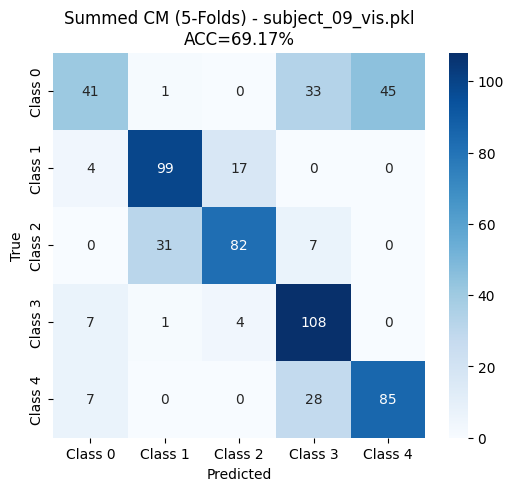


=== subject_10_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_10_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_10_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_10_vis.pkl_fold1] epoch=1/8 => val_loss=0.4405, val_acc=85.58%
[subject_10_vis.pkl_fold1] epoch=2/8 => val_loss=0.4337, val_acc=86.72%
[subject_10_vis.pkl_fold1] epoch=3/8 => val_loss=0.2187, val_acc=93.42%
[subject_10_vis.pkl_fold1] epoch=4/8 => val_loss=0.2755, val_acc=91.83%
[subject_10_vis.pkl_fold1] epoch=5/8 => val_loss=0.3720, val_acc=88.64%
[subject_10_vis.pkl_fold1] epoch=6/8 => val_loss=0.2729, val_acc=91.90%
[subject_10_vis.pkl_fold1] Early stopping at epoch=6
[subject_10_vis.pkl_fold1] => best_val_loss=0.2187
[subject_10_vis.pkl] Fold 1 => Test ACC=61.67%, F1=0.5868

=== [File: subject_10_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_10_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_10_vis.pkl_fold2] epoch=1/8 => val_loss=0.3404, val_acc=88.92%
[subject_10_vis.pkl_fold2] epoch=2/8 => val_loss=0.2367, val_acc=91.95%
[subject_10_vis.pkl_fold2] epoch=3/8 => val_loss=0.1617, val_acc=94.60%
[subject_10_vis.pkl_fold2] epoch=4/8 => val_loss=0.1655, val_acc=94.89%
[subject_10_vis.pkl_fold2] epoch=5/8 => val_loss=0.1878, val_acc=93.25%
[subject_10_vis.pkl_fold2] epoch=6/8 => val_loss=0.2546, val_acc=93.37%
[subject_10_vis.pkl_fold2] Early stopping at epoch=6
[subject_10_vis.pkl_fold2] => best_val_loss=0.1617
[subject_10_vis.pkl] Fold 2 => Test ACC=67.50%, F1=0.6756

=== [File: subject_10_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_10_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_10_vis.pkl_fold3] epoch=1/8 => val_loss=0.3172, val_acc=92.05%
[subject_10_vis.pkl_fold3] epoch=2/8 => val_loss=0.2085, val_acc=93.89%
[subject_10_vis.pkl_fold3] epoch=3/8 => val_loss=0.1647, val_acc=94.53%
[subject_10_vis.pkl_fold3] epoch=4/8 => val_loss=0.1099, val_acc=96.59%
[subject_10_vis.pkl_fold3] epoch=5/8 => val_loss=0.1500, val_acc=96.16%
[subject_10_vis.pkl_fold3] epoch=6/8 => val_loss=0.1863, val_acc=94.60%
[subject_10_vis.pkl_fold3] epoch=7/8 => val_loss=0.0923, val_acc=97.37%
[subject_10_vis.pkl_fold3] epoch=8/8 => val_loss=0.1496, val_acc=94.82%
[subject_10_vis.pkl_fold3] => best_val_loss=0.0923
[subject_10_vis.pkl] Fold 3 => Test ACC=66.67%, F1=0.6492

=== [File: subject_10_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_10_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_10_vis.pkl_fold4] epoch=1/8 => val_loss=0.4927, val_acc=82.88%
[subject_10_vis.pkl_fold4] epoch=2/8 => val_loss=0.4346, val_acc=85.65%
[subject_10_vis.pkl_fold4] epoch=3/8 => val_loss=0.3876, val_acc=87.38%
[subject_10_vis.pkl_fold4] epoch=4/8 => val_loss=0.3853, val_acc=88.14%
[subject_10_vis.pkl_fold4] epoch=5/8 => val_loss=0.4310, val_acc=87.86%
[subject_10_vis.pkl_fold4] epoch=6/8 => val_loss=0.4809, val_acc=86.43%
[subject_10_vis.pkl_fold4] epoch=7/8 => val_loss=0.4851, val_acc=88.49%
[subject_10_vis.pkl_fold4] Early stopping at epoch=7
[subject_10_vis.pkl_fold4] => best_val_loss=0.3853
[subject_10_vis.pkl] Fold 4 => Test ACC=64.17%, F1=0.6448

=== [File: subject_10_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_10_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_10_vis.pkl_fold5] epoch=1/8 => val_loss=0.3968, val_acc=88.85%
[subject_10_vis.pkl_fold5] epoch=2/8 => val_loss=0.3435, val_acc=87.90%
[subject_10_vis.pkl_fold5] epoch=3/8 => val_loss=0.2346, val_acc=92.26%
[subject_10_vis.pkl_fold5] epoch=4/8 => val_loss=0.1304, val_acc=96.73%
[subject_10_vis.pkl_fold5] epoch=5/8 => val_loss=0.2012, val_acc=94.39%
[subject_10_vis.pkl_fold5] epoch=6/8 => val_loss=0.1628, val_acc=95.45%
[subject_10_vis.pkl_fold5] epoch=7/8 => val_loss=0.3244, val_acc=90.98%
[subject_10_vis.pkl_fold5] Early stopping at epoch=7
[subject_10_vis.pkl_fold5] => best_val_loss=0.1304
[subject_10_vis.pkl] Fold 5 => Test ACC=64.17%, F1=0.6395

=== [File: subject_10_vis.pkl] 5-Fold Mean Test ACC=64.83%, F1=0.6392


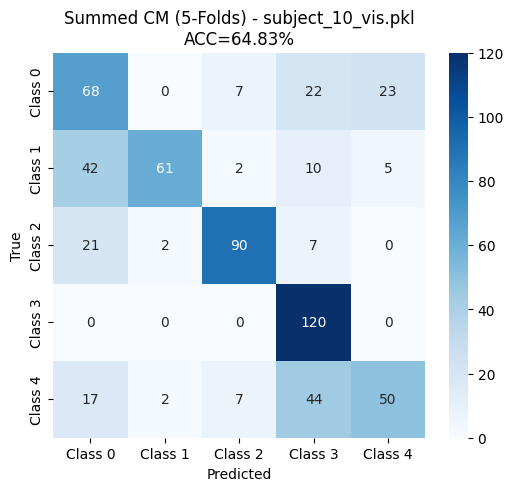


=== subject_11_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_11_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_11_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_11_vis.pkl_fold1] epoch=1/8 => val_loss=0.6441, val_acc=78.69%
[subject_11_vis.pkl_fold1] epoch=2/8 => val_loss=0.5310, val_acc=82.60%
[subject_11_vis.pkl_fold1] epoch=3/8 => val_loss=0.4986, val_acc=82.95%
[subject_11_vis.pkl_fold1] epoch=4/8 => val_loss=0.5557, val_acc=82.53%
[subject_11_vis.pkl_fold1] epoch=5/8 => val_loss=0.7475, val_acc=77.13%
[subject_11_vis.pkl_fold1] epoch=6/8 => val_loss=0.6614, val_acc=81.04%
[subject_11_vis.pkl_fold1] Early stopping at epoch=6
[subject_11_vis.pkl_fold1] => best_val_loss=0.4986
[subject_11_vis.pkl] Fold 1 => Test ACC=70.83%, F1=0.6860

=== [File: subject_11_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_11_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_11_vis.pkl_fold2] epoch=1/8 => val_loss=0.6353, val_acc=79.43%
[subject_11_vis.pkl_fold2] epoch=2/8 => val_loss=0.4907, val_acc=85.27%
[subject_11_vis.pkl_fold2] epoch=3/8 => val_loss=0.4529, val_acc=86.67%
[subject_11_vis.pkl_fold2] epoch=4/8 => val_loss=0.5284, val_acc=84.64%
[subject_11_vis.pkl_fold2] epoch=5/8 => val_loss=0.5096, val_acc=86.29%
[subject_11_vis.pkl_fold2] epoch=6/8 => val_loss=0.4996, val_acc=87.10%
[subject_11_vis.pkl_fold2] Early stopping at epoch=6
[subject_11_vis.pkl_fold2] => best_val_loss=0.4529
[subject_11_vis.pkl] Fold 2 => Test ACC=57.50%, F1=0.5233

=== [File: subject_11_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_11_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_11_vis.pkl_fold3] epoch=1/8 => val_loss=0.5049, val_acc=84.66%
[subject_11_vis.pkl_fold3] epoch=2/8 => val_loss=0.3202, val_acc=90.55%
[subject_11_vis.pkl_fold3] epoch=3/8 => val_loss=0.3711, val_acc=87.22%
[subject_11_vis.pkl_fold3] epoch=4/8 => val_loss=0.4068, val_acc=87.07%
[subject_11_vis.pkl_fold3] epoch=5/8 => val_loss=0.5281, val_acc=83.52%
[subject_11_vis.pkl_fold3] Early stopping at epoch=5
[subject_11_vis.pkl_fold3] => best_val_loss=0.3202
[subject_11_vis.pkl] Fold 3 => Test ACC=56.67%, F1=0.5316

=== [File: subject_11_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_11_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_11_vis.pkl_fold4] epoch=1/8 => val_loss=0.5776, val_acc=79.83%
[subject_11_vis.pkl_fold4] epoch=2/8 => val_loss=0.4515, val_acc=86.43%
[subject_11_vis.pkl_fold4] epoch=3/8 => val_loss=0.3992, val_acc=86.36%
[subject_11_vis.pkl_fold4] epoch=4/8 => val_loss=0.4291, val_acc=85.44%
[subject_11_vis.pkl_fold4] epoch=5/8 => val_loss=0.4246, val_acc=85.87%
[subject_11_vis.pkl_fold4] epoch=6/8 => val_loss=0.4918, val_acc=84.00%
[subject_11_vis.pkl_fold4] Early stopping at epoch=6
[subject_11_vis.pkl_fold4] => best_val_loss=0.3992
[subject_11_vis.pkl] Fold 4 => Test ACC=61.67%, F1=0.5637

=== [File: subject_11_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_11_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_11_vis.pkl_fold5] epoch=1/8 => val_loss=0.5849, val_acc=82.15%
[subject_11_vis.pkl_fold5] epoch=2/8 => val_loss=0.3865, val_acc=87.93%
[subject_11_vis.pkl_fold5] epoch=3/8 => val_loss=0.3983, val_acc=86.15%
[subject_11_vis.pkl_fold5] epoch=4/8 => val_loss=0.5502, val_acc=81.18%
[subject_11_vis.pkl_fold5] epoch=5/8 => val_loss=0.7649, val_acc=76.33%
[subject_11_vis.pkl_fold5] Early stopping at epoch=5
[subject_11_vis.pkl_fold5] => best_val_loss=0.3865
[subject_11_vis.pkl] Fold 5 => Test ACC=65.83%, F1=0.6149

=== [File: subject_11_vis.pkl] 5-Fold Mean Test ACC=62.50%, F1=0.5839


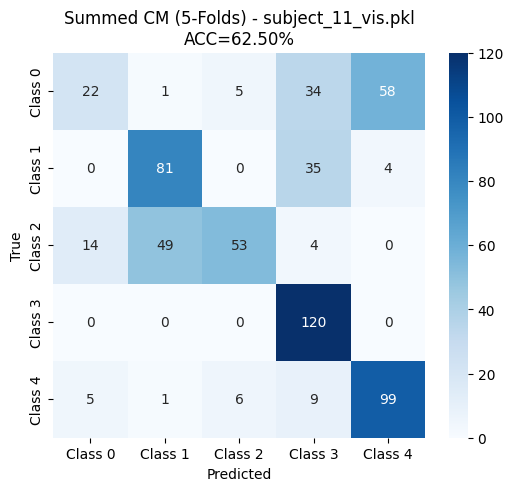


=== subject_12_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_12_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_12_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_12_vis.pkl_fold1] epoch=1/8 => val_loss=0.4736, val_acc=83.74%
[subject_12_vis.pkl_fold1] epoch=2/8 => val_loss=0.5077, val_acc=82.32%
[subject_12_vis.pkl_fold1] epoch=3/8 => val_loss=0.5396, val_acc=80.78%
[subject_12_vis.pkl_fold1] epoch=4/8 => val_loss=0.6086, val_acc=80.37%
[subject_12_vis.pkl_fold1] Early stopping at epoch=4
[subject_12_vis.pkl_fold1] => best_val_loss=0.4736
[subject_12_vis.pkl] Fold 1 => Test ACC=50.83%, F1=0.5132

=== [File: subject_12_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_12_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_12_vis.pkl_fold2] epoch=1/8 => val_loss=0.5305, val_acc=82.34%
[subject_12_vis.pkl_fold2] epoch=2/8 => val_loss=0.6064, val_acc=79.81%
[subject_12_vis.pkl_fold2] epoch=3/8 => val_loss=0.5225, val_acc=83.24%
[subject_12_vis.pkl_fold2] epoch=4/8 => val_loss=0.4191, val_acc=87.64%
[subject_12_vis.pkl_fold2] epoch=5/8 => val_loss=0.4473, val_acc=86.96%
[subject_12_vis.pkl_fold2] epoch=6/8 => val_loss=0.4489, val_acc=88.78%
[subject_12_vis.pkl_fold2] epoch=7/8 => val_loss=0.4914, val_acc=86.15%
[subject_12_vis.pkl_fold2] Early stopping at epoch=7
[subject_12_vis.pkl_fold2] => best_val_loss=0.4191
[subject_12_vis.pkl] Fold 2 => Test ACC=61.67%, F1=0.6116

=== [File: subject_12_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_12_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_12_vis.pkl_fold3] epoch=1/8 => val_loss=0.6057, val_acc=77.91%
[subject_12_vis.pkl_fold3] epoch=2/8 => val_loss=0.4148, val_acc=86.43%
[subject_12_vis.pkl_fold3] epoch=3/8 => val_loss=0.3132, val_acc=90.55%
[subject_12_vis.pkl_fold3] epoch=4/8 => val_loss=0.3600, val_acc=88.64%
[subject_12_vis.pkl_fold3] epoch=5/8 => val_loss=0.3934, val_acc=87.71%
[subject_12_vis.pkl_fold3] epoch=6/8 => val_loss=0.3348, val_acc=89.84%
[subject_12_vis.pkl_fold3] Early stopping at epoch=6
[subject_12_vis.pkl_fold3] => best_val_loss=0.3132
[subject_12_vis.pkl] Fold 3 => Test ACC=45.00%, F1=0.4531

=== [File: subject_12_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_12_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_12_vis.pkl_fold4] epoch=1/8 => val_loss=0.5673, val_acc=79.05%
[subject_12_vis.pkl_fold4] epoch=2/8 => val_loss=0.4084, val_acc=85.44%
[subject_12_vis.pkl_fold4] epoch=3/8 => val_loss=0.2758, val_acc=90.34%
[subject_12_vis.pkl_fold4] epoch=4/8 => val_loss=0.3044, val_acc=90.41%
[subject_12_vis.pkl_fold4] epoch=5/8 => val_loss=0.3824, val_acc=89.20%
[subject_12_vis.pkl_fold4] epoch=6/8 => val_loss=0.3400, val_acc=89.63%
[subject_12_vis.pkl_fold4] Early stopping at epoch=6
[subject_12_vis.pkl_fold4] => best_val_loss=0.2758
[subject_12_vis.pkl] Fold 4 => Test ACC=48.33%, F1=0.4822

=== [File: subject_12_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_12_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_12_vis.pkl_fold5] epoch=1/8 => val_loss=0.5233, val_acc=80.54%
[subject_12_vis.pkl_fold5] epoch=2/8 => val_loss=0.4702, val_acc=85.51%
[subject_12_vis.pkl_fold5] epoch=3/8 => val_loss=0.5053, val_acc=85.01%
[subject_12_vis.pkl_fold5] epoch=4/8 => val_loss=0.6060, val_acc=84.87%
[subject_12_vis.pkl_fold5] epoch=5/8 => val_loss=0.4911, val_acc=87.29%
[subject_12_vis.pkl_fold5] Early stopping at epoch=5
[subject_12_vis.pkl_fold5] => best_val_loss=0.4702
[subject_12_vis.pkl] Fold 5 => Test ACC=56.67%, F1=0.5519

=== [File: subject_12_vis.pkl] 5-Fold Mean Test ACC=52.50%, F1=0.5224


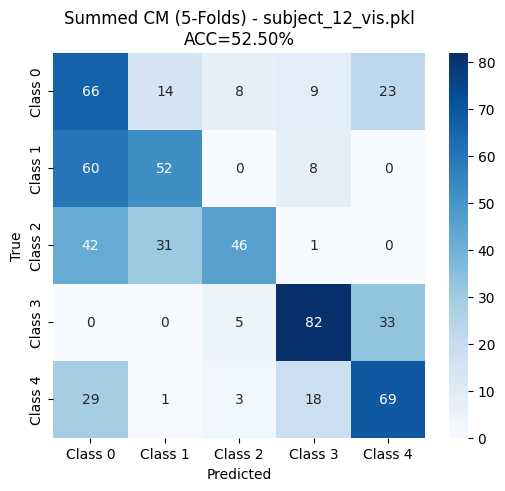


=== subject_13_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_13_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_13_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_13_vis.pkl_fold1] epoch=1/8 => val_loss=0.7045, val_acc=76.44%
[subject_13_vis.pkl_fold1] epoch=2/8 => val_loss=0.5730, val_acc=81.30%
[subject_13_vis.pkl_fold1] epoch=3/8 => val_loss=0.5371, val_acc=82.58%
[subject_13_vis.pkl_fold1] epoch=4/8 => val_loss=0.6919, val_acc=80.52%
[subject_13_vis.pkl_fold1] epoch=5/8 => val_loss=0.6812, val_acc=79.17%
[subject_13_vis.pkl_fold1] epoch=6/8 => val_loss=0.3546, val_acc=89.32%
[subject_13_vis.pkl_fold1] epoch=7/8 => val_loss=0.3452, val_acc=88.75%
[subject_13_vis.pkl_fold1] epoch=8/8 => val_loss=0.4416, val_acc=88.54%
[subject_13_vis.pkl_fold1] => best_val_loss=0.3452
[subject_13_vis.pkl] Fold 1 => Test ACC=87.50%, F1=0.8776

=== [File: subject_13_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_13_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_13_vis.pkl_fold2] epoch=1/8 => val_loss=0.6952, val_acc=76.07%
[subject_13_vis.pkl_fold2] epoch=2/8 => val_loss=0.4121, val_acc=85.75%
[subject_13_vis.pkl_fold2] epoch=3/8 => val_loss=0.4868, val_acc=82.22%
[subject_13_vis.pkl_fold2] epoch=4/8 => val_loss=0.3419, val_acc=89.75%
[subject_13_vis.pkl_fold2] epoch=5/8 => val_loss=0.3923, val_acc=88.42%
[subject_13_vis.pkl_fold2] epoch=6/8 => val_loss=0.3708, val_acc=89.56%
[subject_13_vis.pkl_fold2] epoch=7/8 => val_loss=0.4236, val_acc=88.30%
[subject_13_vis.pkl_fold2] Early stopping at epoch=7
[subject_13_vis.pkl_fold2] => best_val_loss=0.3419
[subject_13_vis.pkl] Fold 2 => Test ACC=93.33%, F1=0.9335

=== [File: subject_13_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_13_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_13_vis.pkl_fold3] epoch=1/8 => val_loss=0.5722, val_acc=78.57%
[subject_13_vis.pkl_fold3] epoch=2/8 => val_loss=0.2976, val_acc=90.91%
[subject_13_vis.pkl_fold3] epoch=3/8 => val_loss=0.2826, val_acc=91.00%
[subject_13_vis.pkl_fold3] epoch=4/8 => val_loss=0.2791, val_acc=91.17%
[subject_13_vis.pkl_fold3] epoch=5/8 => val_loss=0.2765, val_acc=91.74%
[subject_13_vis.pkl_fold3] epoch=6/8 => val_loss=0.2400, val_acc=92.02%
[subject_13_vis.pkl_fold3] epoch=7/8 => val_loss=0.4013, val_acc=88.71%
[subject_13_vis.pkl_fold3] epoch=8/8 => val_loss=0.2614, val_acc=92.12%
[subject_13_vis.pkl_fold3] => best_val_loss=0.2400
[subject_13_vis.pkl] Fold 3 => Test ACC=90.00%, F1=0.8945

=== [File: subject_13_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_13_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_13_vis.pkl_fold4] epoch=1/8 => val_loss=0.6793, val_acc=76.47%
[subject_13_vis.pkl_fold4] epoch=2/8 => val_loss=0.4959, val_acc=81.87%
[subject_13_vis.pkl_fold4] epoch=3/8 => val_loss=0.4894, val_acc=83.45%
[subject_13_vis.pkl_fold4] epoch=4/8 => val_loss=0.4368, val_acc=86.70%
[subject_13_vis.pkl_fold4] epoch=5/8 => val_loss=0.4414, val_acc=85.37%
[subject_13_vis.pkl_fold4] epoch=6/8 => val_loss=0.6799, val_acc=80.00%
[subject_13_vis.pkl_fold4] epoch=7/8 => val_loss=0.4326, val_acc=87.48%
[subject_13_vis.pkl_fold4] epoch=8/8 => val_loss=0.4397, val_acc=87.74%
[subject_13_vis.pkl_fold4] => best_val_loss=0.4326
[subject_13_vis.pkl] Fold 4 => Test ACC=78.33%, F1=0.7775

=== [File: subject_13_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_13_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_13_vis.pkl_fold5] epoch=1/8 => val_loss=0.5776, val_acc=78.91%
[subject_13_vis.pkl_fold5] epoch=2/8 => val_loss=0.2637, val_acc=92.71%
[subject_13_vis.pkl_fold5] epoch=3/8 => val_loss=0.3572, val_acc=88.42%
[subject_13_vis.pkl_fold5] epoch=4/8 => val_loss=0.2773, val_acc=91.00%
[subject_13_vis.pkl_fold5] epoch=5/8 => val_loss=0.2409, val_acc=92.78%
[subject_13_vis.pkl_fold5] epoch=6/8 => val_loss=0.2434, val_acc=92.85%
[subject_13_vis.pkl_fold5] epoch=7/8 => val_loss=0.2574, val_acc=91.71%
[subject_13_vis.pkl_fold5] epoch=8/8 => val_loss=0.2182, val_acc=93.58%
[subject_13_vis.pkl_fold5] => best_val_loss=0.2182
[subject_13_vis.pkl] Fold 5 => Test ACC=82.50%, F1=0.7998

=== [File: subject_13_vis.pkl] 5-Fold Mean Test ACC=86.33%, F1=0.8566


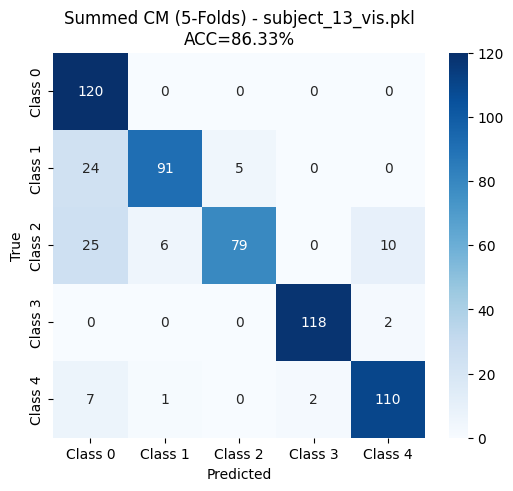


=== subject_14_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_14_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_14_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_14_vis.pkl_fold1] epoch=1/8 => val_loss=0.3136, val_acc=90.91%
[subject_14_vis.pkl_fold1] epoch=2/8 => val_loss=0.2274, val_acc=94.11%
[subject_14_vis.pkl_fold1] epoch=3/8 => val_loss=0.2862, val_acc=91.55%
[subject_14_vis.pkl_fold1] epoch=4/8 => val_loss=0.2063, val_acc=93.96%
[subject_14_vis.pkl_fold1] epoch=5/8 => val_loss=0.1331, val_acc=96.09%
[subject_14_vis.pkl_fold1] epoch=6/8 => val_loss=0.2473, val_acc=92.83%
[subject_14_vis.pkl_fold1] epoch=7/8 => val_loss=0.1566, val_acc=95.60%
[subject_14_vis.pkl_fold1] epoch=8/8 => val_loss=0.1455, val_acc=95.88%
[subject_14_vis.pkl_fold1] Early stopping at epoch=8
[subject_14_vis.pkl_fold1] => best_val_loss=0.1331
[subject_14_vis.pkl] Fold 1 => Test ACC=60.00%, F1=0.5903

=== [File: subject_14_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_14_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_14_vis.pkl_fold2] epoch=1/8 => val_loss=0.2758, val_acc=92.83%
[subject_14_vis.pkl_fold2] epoch=2/8 => val_loss=0.2823, val_acc=91.48%
[subject_14_vis.pkl_fold2] epoch=3/8 => val_loss=0.2761, val_acc=93.49%
[subject_14_vis.pkl_fold2] epoch=4/8 => val_loss=0.4113, val_acc=89.61%
[subject_14_vis.pkl_fold2] Early stopping at epoch=4
[subject_14_vis.pkl_fold2] => best_val_loss=0.2758
[subject_14_vis.pkl] Fold 2 => Test ACC=57.50%, F1=0.5341

=== [File: subject_14_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_14_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_14_vis.pkl_fold3] epoch=1/8 => val_loss=0.2542, val_acc=93.39%
[subject_14_vis.pkl_fold3] epoch=2/8 => val_loss=0.1568, val_acc=96.24%
[subject_14_vis.pkl_fold3] epoch=3/8 => val_loss=0.2041, val_acc=93.82%
[subject_14_vis.pkl_fold3] epoch=4/8 => val_loss=0.1746, val_acc=95.38%
[subject_14_vis.pkl_fold3] epoch=5/8 => val_loss=0.1332, val_acc=96.09%
[subject_14_vis.pkl_fold3] epoch=6/8 => val_loss=0.1285, val_acc=96.02%
[subject_14_vis.pkl_fold3] epoch=7/8 => val_loss=0.1620, val_acc=96.16%
[subject_14_vis.pkl_fold3] epoch=8/8 => val_loss=0.1819, val_acc=93.96%
[subject_14_vis.pkl_fold3] => best_val_loss=0.1285
[subject_14_vis.pkl] Fold 3 => Test ACC=60.83%, F1=0.5947

=== [File: subject_14_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_14_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_14_vis.pkl_fold4] epoch=1/8 => val_loss=0.2776, val_acc=91.83%
[subject_14_vis.pkl_fold4] epoch=2/8 => val_loss=0.2778, val_acc=92.19%
[subject_14_vis.pkl_fold4] epoch=3/8 => val_loss=0.2125, val_acc=92.83%
[subject_14_vis.pkl_fold4] epoch=4/8 => val_loss=0.2326, val_acc=92.76%
[subject_14_vis.pkl_fold4] epoch=5/8 => val_loss=0.3120, val_acc=91.12%
[subject_14_vis.pkl_fold4] epoch=6/8 => val_loss=0.1502, val_acc=95.45%
[subject_14_vis.pkl_fold4] epoch=7/8 => val_loss=0.2647, val_acc=92.54%
[subject_14_vis.pkl_fold4] epoch=8/8 => val_loss=0.3419, val_acc=90.20%
[subject_14_vis.pkl_fold4] => best_val_loss=0.1502
[subject_14_vis.pkl] Fold 4 => Test ACC=54.17%, F1=0.5258

=== [File: subject_14_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_14_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_14_vis.pkl_fold5] epoch=1/8 => val_loss=0.3262, val_acc=89.91%
[subject_14_vis.pkl_fold5] epoch=2/8 => val_loss=0.1466, val_acc=96.66%
[subject_14_vis.pkl_fold5] epoch=3/8 => val_loss=0.1271, val_acc=96.45%
[subject_14_vis.pkl_fold5] epoch=4/8 => val_loss=0.1313, val_acc=96.02%
[subject_14_vis.pkl_fold5] epoch=5/8 => val_loss=0.1768, val_acc=95.31%
[subject_14_vis.pkl_fold5] epoch=6/8 => val_loss=0.2485, val_acc=92.97%
[subject_14_vis.pkl_fold5] Early stopping at epoch=6
[subject_14_vis.pkl_fold5] => best_val_loss=0.1271
[subject_14_vis.pkl] Fold 5 => Test ACC=57.50%, F1=0.5690

=== [File: subject_14_vis.pkl] 5-Fold Mean Test ACC=58.00%, F1=0.5628


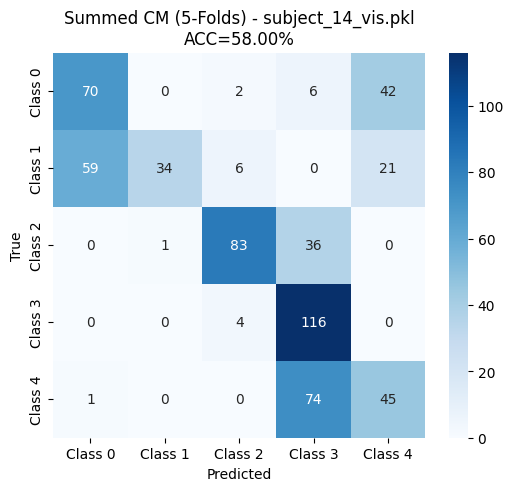


=== subject_15_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_15_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_15_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_15_vis.pkl_fold1] epoch=1/8 => val_loss=0.4768, val_acc=84.73%
[subject_15_vis.pkl_fold1] epoch=2/8 => val_loss=0.4582, val_acc=85.77%
[subject_15_vis.pkl_fold1] epoch=3/8 => val_loss=0.4026, val_acc=86.29%
[subject_15_vis.pkl_fold1] epoch=4/8 => val_loss=0.3866, val_acc=87.86%
[subject_15_vis.pkl_fold1] epoch=5/8 => val_loss=0.3102, val_acc=90.20%
[subject_15_vis.pkl_fold1] epoch=6/8 => val_loss=0.4036, val_acc=89.37%
[subject_15_vis.pkl_fold1] epoch=7/8 => val_loss=0.4578, val_acc=87.14%
[subject_15_vis.pkl_fold1] epoch=8/8 => val_loss=0.2828, val_acc=91.60%
[subject_15_vis.pkl_fold1] => best_val_loss=0.2828
[subject_15_vis.pkl] Fold 1 => Test ACC=65.83%, F1=0.6167

=== [File: subject_15_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_15_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_15_vis.pkl_fold2] epoch=1/8 => val_loss=0.4097, val_acc=87.00%
[subject_15_vis.pkl_fold2] epoch=2/8 => val_loss=0.2600, val_acc=91.34%
[subject_15_vis.pkl_fold2] epoch=3/8 => val_loss=0.3775, val_acc=87.93%
[subject_15_vis.pkl_fold2] epoch=4/8 => val_loss=0.4534, val_acc=85.35%
[subject_15_vis.pkl_fold2] epoch=5/8 => val_loss=0.3654, val_acc=89.06%
[subject_15_vis.pkl_fold2] Early stopping at epoch=5
[subject_15_vis.pkl_fold2] => best_val_loss=0.2600
[subject_15_vis.pkl] Fold 2 => Test ACC=76.67%, F1=0.7444

=== [File: subject_15_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_15_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_15_vis.pkl_fold3] epoch=1/8 => val_loss=0.3229, val_acc=91.45%
[subject_15_vis.pkl_fold3] epoch=2/8 => val_loss=0.2256, val_acc=92.61%
[subject_15_vis.pkl_fold3] epoch=3/8 => val_loss=0.2628, val_acc=91.12%
[subject_15_vis.pkl_fold3] epoch=4/8 => val_loss=0.1986, val_acc=93.21%
[subject_15_vis.pkl_fold3] epoch=5/8 => val_loss=0.1710, val_acc=94.67%
[subject_15_vis.pkl_fold3] epoch=6/8 => val_loss=0.2200, val_acc=93.06%
[subject_15_vis.pkl_fold3] epoch=7/8 => val_loss=0.2407, val_acc=92.92%
[subject_15_vis.pkl_fold3] epoch=8/8 => val_loss=0.2847, val_acc=92.19%
[subject_15_vis.pkl_fold3] Early stopping at epoch=8
[subject_15_vis.pkl_fold3] => best_val_loss=0.1710
[subject_15_vis.pkl] Fold 3 => Test ACC=61.67%, F1=0.5922

=== [File: subject_15_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_15_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_15_vis.pkl_fold4] epoch=1/8 => val_loss=0.3847, val_acc=88.80%
[subject_15_vis.pkl_fold4] epoch=2/8 => val_loss=0.4522, val_acc=83.05%
[subject_15_vis.pkl_fold4] epoch=3/8 => val_loss=0.3641, val_acc=88.00%
[subject_15_vis.pkl_fold4] epoch=4/8 => val_loss=0.2488, val_acc=92.14%
[subject_15_vis.pkl_fold4] epoch=5/8 => val_loss=0.3263, val_acc=89.91%
[subject_15_vis.pkl_fold4] epoch=6/8 => val_loss=0.1894, val_acc=93.04%
[subject_15_vis.pkl_fold4] epoch=7/8 => val_loss=0.2315, val_acc=93.04%
[subject_15_vis.pkl_fold4] epoch=8/8 => val_loss=0.3838, val_acc=88.61%
[subject_15_vis.pkl_fold4] => best_val_loss=0.1894
[subject_15_vis.pkl] Fold 4 => Test ACC=64.17%, F1=0.5900

=== [File: subject_15_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_15_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_15_vis.pkl_fold5] epoch=1/8 => val_loss=0.4808, val_acc=84.30%
[subject_15_vis.pkl_fold5] epoch=2/8 => val_loss=0.2826, val_acc=91.34%
[subject_15_vis.pkl_fold5] epoch=3/8 => val_loss=0.2497, val_acc=92.90%
[subject_15_vis.pkl_fold5] epoch=4/8 => val_loss=0.4020, val_acc=87.71%
[subject_15_vis.pkl_fold5] epoch=5/8 => val_loss=0.2723, val_acc=92.33%
[subject_15_vis.pkl_fold5] epoch=6/8 => val_loss=0.2747, val_acc=91.97%
[subject_15_vis.pkl_fold5] Early stopping at epoch=6
[subject_15_vis.pkl_fold5] => best_val_loss=0.2497
[subject_15_vis.pkl] Fold 5 => Test ACC=66.67%, F1=0.6367

=== [File: subject_15_vis.pkl] 5-Fold Mean Test ACC=67.00%, F1=0.6360


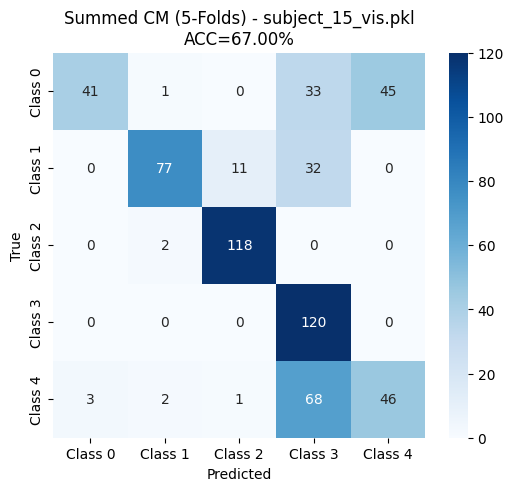


=== subject_16_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_16_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_16_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_16_vis.pkl_fold1] epoch=1/8 => val_loss=0.5198, val_acc=83.07%
[subject_16_vis.pkl_fold1] epoch=2/8 => val_loss=0.4270, val_acc=85.68%
[subject_16_vis.pkl_fold1] epoch=3/8 => val_loss=0.3571, val_acc=88.71%
[subject_16_vis.pkl_fold1] epoch=4/8 => val_loss=0.4529, val_acc=86.29%
[subject_16_vis.pkl_fold1] epoch=5/8 => val_loss=0.3567, val_acc=89.20%
[subject_16_vis.pkl_fold1] epoch=6/8 => val_loss=0.2380, val_acc=92.28%
[subject_16_vis.pkl_fold1] epoch=7/8 => val_loss=0.3390, val_acc=89.77%
[subject_16_vis.pkl_fold1] epoch=8/8 => val_loss=0.2895, val_acc=90.89%
[subject_16_vis.pkl_fold1] => best_val_loss=0.2380
[subject_16_vis.pkl] Fold 1 => Test ACC=64.17%, F1=0.6260

=== [File: subject_16_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_16_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_16_vis.pkl_fold2] epoch=1/8 => val_loss=0.5985, val_acc=79.90%
[subject_16_vis.pkl_fold2] epoch=2/8 => val_loss=0.5463, val_acc=79.59%
[subject_16_vis.pkl_fold2] epoch=3/8 => val_loss=0.4062, val_acc=85.94%
[subject_16_vis.pkl_fold2] epoch=4/8 => val_loss=0.4533, val_acc=85.44%
[subject_16_vis.pkl_fold2] epoch=5/8 => val_loss=0.3377, val_acc=88.54%
[subject_16_vis.pkl_fold2] epoch=6/8 => val_loss=0.3429, val_acc=88.80%
[subject_16_vis.pkl_fold2] epoch=7/8 => val_loss=0.3639, val_acc=89.46%
[subject_16_vis.pkl_fold2] epoch=8/8 => val_loss=0.2989, val_acc=89.82%
[subject_16_vis.pkl_fold2] => best_val_loss=0.2989
[subject_16_vis.pkl] Fold 2 => Test ACC=59.17%, F1=0.5092

=== [File: subject_16_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_16_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_16_vis.pkl_fold3] epoch=1/8 => val_loss=0.5851, val_acc=80.11%
[subject_16_vis.pkl_fold3] epoch=2/8 => val_loss=0.5542, val_acc=80.61%
[subject_16_vis.pkl_fold3] epoch=3/8 => val_loss=0.2874, val_acc=90.77%
[subject_16_vis.pkl_fold3] epoch=4/8 => val_loss=0.3610, val_acc=87.50%
[subject_16_vis.pkl_fold3] epoch=5/8 => val_loss=0.5366, val_acc=85.51%
[subject_16_vis.pkl_fold3] epoch=6/8 => val_loss=0.3867, val_acc=88.85%
[subject_16_vis.pkl_fold3] Early stopping at epoch=6
[subject_16_vis.pkl_fold3] => best_val_loss=0.2874
[subject_16_vis.pkl] Fold 3 => Test ACC=60.00%, F1=0.5174

=== [File: subject_16_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_16_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_16_vis.pkl_fold4] epoch=1/8 => val_loss=0.6195, val_acc=77.34%
[subject_16_vis.pkl_fold4] epoch=2/8 => val_loss=0.3936, val_acc=86.43%
[subject_16_vis.pkl_fold4] epoch=3/8 => val_loss=0.3372, val_acc=88.99%
[subject_16_vis.pkl_fold4] epoch=4/8 => val_loss=0.4452, val_acc=84.80%
[subject_16_vis.pkl_fold4] epoch=5/8 => val_loss=0.3844, val_acc=88.85%
[subject_16_vis.pkl_fold4] epoch=6/8 => val_loss=0.2688, val_acc=91.48%
[subject_16_vis.pkl_fold4] epoch=7/8 => val_loss=0.3277, val_acc=90.70%
[subject_16_vis.pkl_fold4] epoch=8/8 => val_loss=0.2836, val_acc=91.19%
[subject_16_vis.pkl_fold4] => best_val_loss=0.2688
[subject_16_vis.pkl] Fold 4 => Test ACC=62.50%, F1=0.5560

=== [File: subject_16_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_16_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_16_vis.pkl_fold5] epoch=1/8 => val_loss=0.5865, val_acc=76.78%
[subject_16_vis.pkl_fold5] epoch=2/8 => val_loss=0.4236, val_acc=85.16%
[subject_16_vis.pkl_fold5] epoch=3/8 => val_loss=0.3617, val_acc=88.78%
[subject_16_vis.pkl_fold5] epoch=4/8 => val_loss=0.5382, val_acc=84.16%
[subject_16_vis.pkl_fold5] epoch=5/8 => val_loss=0.3488, val_acc=89.63%
[subject_16_vis.pkl_fold5] epoch=6/8 => val_loss=0.4262, val_acc=87.64%
[subject_16_vis.pkl_fold5] epoch=7/8 => val_loss=0.4670, val_acc=87.78%
[subject_16_vis.pkl_fold5] epoch=8/8 => val_loss=0.2693, val_acc=92.05%
[subject_16_vis.pkl_fold5] => best_val_loss=0.2693
[subject_16_vis.pkl] Fold 5 => Test ACC=55.83%, F1=0.5111

=== [File: subject_16_vis.pkl] 5-Fold Mean Test ACC=60.33%, F1=0.5440


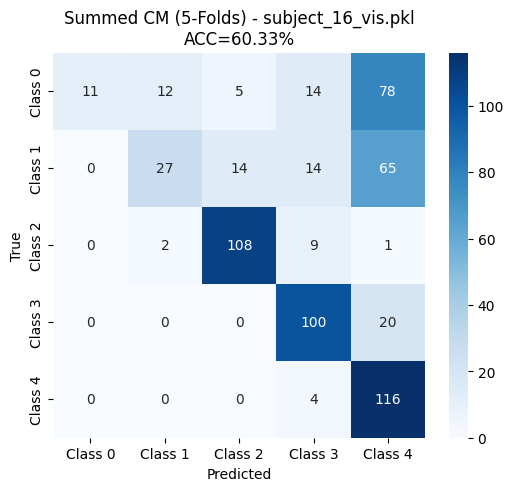


=== subject_17_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_17_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_17_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_17_vis.pkl_fold1] epoch=1/8 => val_loss=0.2952, val_acc=92.42%
[subject_17_vis.pkl_fold1] epoch=2/8 => val_loss=0.2845, val_acc=91.45%
[subject_17_vis.pkl_fold1] epoch=3/8 => val_loss=0.1847, val_acc=94.74%
[subject_17_vis.pkl_fold1] epoch=4/8 => val_loss=0.0793, val_acc=98.08%
[subject_17_vis.pkl_fold1] epoch=5/8 => val_loss=0.2166, val_acc=93.96%
[subject_17_vis.pkl_fold1] epoch=6/8 => val_loss=0.1918, val_acc=94.39%
[subject_17_vis.pkl_fold1] epoch=7/8 => val_loss=0.0963, val_acc=97.73%
[subject_17_vis.pkl_fold1] Early stopping at epoch=7
[subject_17_vis.pkl_fold1] => best_val_loss=0.0793
[subject_17_vis.pkl] Fold 1 => Test ACC=89.17%, F1=0.8928

=== [File: subject_17_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_17_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_17_vis.pkl_fold2] epoch=1/8 => val_loss=0.2729, val_acc=92.42%
[subject_17_vis.pkl_fold2] epoch=2/8 => val_loss=0.1992, val_acc=94.37%
[subject_17_vis.pkl_fold2] epoch=3/8 => val_loss=0.2268, val_acc=94.34%
[subject_17_vis.pkl_fold2] epoch=4/8 => val_loss=0.1564, val_acc=95.55%
[subject_17_vis.pkl_fold2] epoch=5/8 => val_loss=0.2743, val_acc=91.74%
[subject_17_vis.pkl_fold2] epoch=6/8 => val_loss=0.1081, val_acc=97.77%
[subject_17_vis.pkl_fold2] epoch=7/8 => val_loss=0.1266, val_acc=96.99%
[subject_17_vis.pkl_fold2] epoch=8/8 => val_loss=0.1206, val_acc=96.88%
[subject_17_vis.pkl_fold2] => best_val_loss=0.1081
[subject_17_vis.pkl] Fold 2 => Test ACC=93.33%, F1=0.9329

=== [File: subject_17_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_17_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_17_vis.pkl_fold3] epoch=1/8 => val_loss=0.2277, val_acc=94.25%
[subject_17_vis.pkl_fold3] epoch=2/8 => val_loss=0.1096, val_acc=97.51%
[subject_17_vis.pkl_fold3] epoch=3/8 => val_loss=0.1339, val_acc=96.38%
[subject_17_vis.pkl_fold3] epoch=4/8 => val_loss=0.1098, val_acc=96.95%
[subject_17_vis.pkl_fold3] epoch=5/8 => val_loss=0.0676, val_acc=98.01%
[subject_17_vis.pkl_fold3] epoch=6/8 => val_loss=0.1784, val_acc=95.24%
[subject_17_vis.pkl_fold3] epoch=7/8 => val_loss=0.1697, val_acc=94.74%
[subject_17_vis.pkl_fold3] epoch=8/8 => val_loss=0.0772, val_acc=97.80%
[subject_17_vis.pkl_fold3] Early stopping at epoch=8
[subject_17_vis.pkl_fold3] => best_val_loss=0.0676
[subject_17_vis.pkl] Fold 3 => Test ACC=88.33%, F1=0.8826

=== [File: subject_17_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_17_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_17_vis.pkl_fold4] epoch=1/8 => val_loss=0.3117, val_acc=91.83%
[subject_17_vis.pkl_fold4] epoch=2/8 => val_loss=0.2246, val_acc=93.25%
[subject_17_vis.pkl_fold4] epoch=3/8 => val_loss=0.1859, val_acc=94.11%
[subject_17_vis.pkl_fold4] epoch=4/8 => val_loss=0.1748, val_acc=94.82%
[subject_17_vis.pkl_fold4] epoch=5/8 => val_loss=0.1248, val_acc=96.43%
[subject_17_vis.pkl_fold4] epoch=6/8 => val_loss=0.2065, val_acc=93.99%
[subject_17_vis.pkl_fold4] epoch=7/8 => val_loss=0.1154, val_acc=96.78%
[subject_17_vis.pkl_fold4] epoch=8/8 => val_loss=0.3531, val_acc=90.84%
[subject_17_vis.pkl_fold4] => best_val_loss=0.1154
[subject_17_vis.pkl] Fold 4 => Test ACC=89.17%, F1=0.8901

=== [File: subject_17_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_17_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_17_vis.pkl_fold5] epoch=1/8 => val_loss=0.1997, val_acc=95.45%
[subject_17_vis.pkl_fold5] epoch=2/8 => val_loss=0.2111, val_acc=93.96%
[subject_17_vis.pkl_fold5] epoch=3/8 => val_loss=0.0950, val_acc=98.01%
[subject_17_vis.pkl_fold5] epoch=4/8 => val_loss=0.1140, val_acc=96.59%
[subject_17_vis.pkl_fold5] epoch=5/8 => val_loss=0.0669, val_acc=98.22%
[subject_17_vis.pkl_fold5] epoch=6/8 => val_loss=0.1121, val_acc=96.73%
[subject_17_vis.pkl_fold5] epoch=7/8 => val_loss=0.0941, val_acc=97.87%
[subject_17_vis.pkl_fold5] epoch=8/8 => val_loss=0.0941, val_acc=97.87%
[subject_17_vis.pkl_fold5] Early stopping at epoch=8
[subject_17_vis.pkl_fold5] => best_val_loss=0.0669
[subject_17_vis.pkl] Fold 5 => Test ACC=83.33%, F1=0.8277

=== [File: subject_17_vis.pkl] 5-Fold Mean Test ACC=88.67%, F1=0.8852


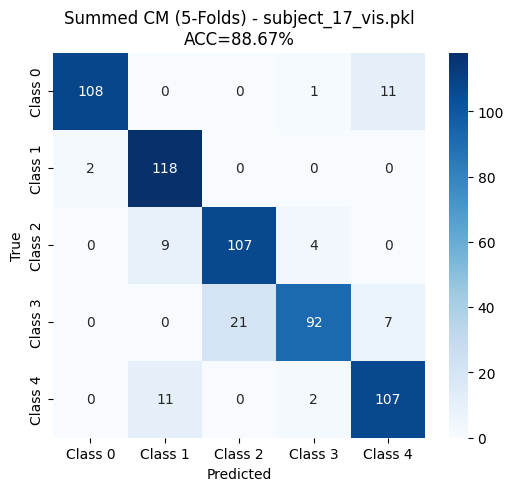


=== subject_18_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_18_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_18_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_18_vis.pkl_fold1] epoch=1/8 => val_loss=0.3875, val_acc=86.81%
[subject_18_vis.pkl_fold1] epoch=2/8 => val_loss=0.2358, val_acc=93.32%
[subject_18_vis.pkl_fold1] epoch=3/8 => val_loss=0.2444, val_acc=92.68%
[subject_18_vis.pkl_fold1] epoch=4/8 => val_loss=0.2148, val_acc=93.68%
[subject_18_vis.pkl_fold1] epoch=5/8 => val_loss=0.1931, val_acc=94.32%
[subject_18_vis.pkl_fold1] epoch=6/8 => val_loss=0.1393, val_acc=95.95%
[subject_18_vis.pkl_fold1] epoch=7/8 => val_loss=0.1447, val_acc=96.02%
[subject_18_vis.pkl_fold1] epoch=8/8 => val_loss=0.1472, val_acc=96.09%
[subject_18_vis.pkl_fold1] => best_val_loss=0.1393
[subject_18_vis.pkl] Fold 1 => Test ACC=77.50%, F1=0.7731

=== [File: subject_18_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_18_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_18_vis.pkl_fold2] epoch=1/8 => val_loss=0.1906, val_acc=96.31%
[subject_18_vis.pkl_fold2] epoch=2/8 => val_loss=0.1206, val_acc=96.95%
[subject_18_vis.pkl_fold2] epoch=3/8 => val_loss=0.0811, val_acc=98.37%
[subject_18_vis.pkl_fold2] epoch=4/8 => val_loss=0.2297, val_acc=92.99%
[subject_18_vis.pkl_fold2] epoch=5/8 => val_loss=0.1281, val_acc=96.45%
[subject_18_vis.pkl_fold2] epoch=6/8 => val_loss=0.0643, val_acc=98.27%
[subject_18_vis.pkl_fold2] epoch=7/8 => val_loss=0.0564, val_acc=98.56%
[subject_18_vis.pkl_fold2] epoch=8/8 => val_loss=0.0573, val_acc=98.41%
[subject_18_vis.pkl_fold2] => best_val_loss=0.0564
[subject_18_vis.pkl] Fold 2 => Test ACC=82.50%, F1=0.8206

=== [File: subject_18_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_18_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_18_vis.pkl_fold3] epoch=1/8 => val_loss=0.2430, val_acc=93.68%
[subject_18_vis.pkl_fold3] epoch=2/8 => val_loss=0.2355, val_acc=92.83%
[subject_18_vis.pkl_fold3] epoch=3/8 => val_loss=0.1892, val_acc=93.61%
[subject_18_vis.pkl_fold3] epoch=4/8 => val_loss=0.0832, val_acc=97.66%
[subject_18_vis.pkl_fold3] epoch=5/8 => val_loss=0.0672, val_acc=98.22%
[subject_18_vis.pkl_fold3] epoch=6/8 => val_loss=0.1209, val_acc=96.80%
[subject_18_vis.pkl_fold3] epoch=7/8 => val_loss=0.1060, val_acc=96.95%
[subject_18_vis.pkl_fold3] epoch=8/8 => val_loss=0.0998, val_acc=97.44%
[subject_18_vis.pkl_fold3] Early stopping at epoch=8
[subject_18_vis.pkl_fold3] => best_val_loss=0.0672
[subject_18_vis.pkl] Fold 3 => Test ACC=84.17%, F1=0.8399

=== [File: subject_18_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_18_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_18_vis.pkl_fold4] epoch=1/8 => val_loss=0.3247, val_acc=90.34%
[subject_18_vis.pkl_fold4] epoch=2/8 => val_loss=0.4005, val_acc=87.86%
[subject_18_vis.pkl_fold4] epoch=3/8 => val_loss=0.2912, val_acc=91.83%
[subject_18_vis.pkl_fold4] epoch=4/8 => val_loss=0.2523, val_acc=92.40%
[subject_18_vis.pkl_fold4] epoch=5/8 => val_loss=0.1862, val_acc=94.67%
[subject_18_vis.pkl_fold4] epoch=6/8 => val_loss=0.3593, val_acc=90.13%
[subject_18_vis.pkl_fold4] epoch=7/8 => val_loss=0.1908, val_acc=94.60%
[subject_18_vis.pkl_fold4] epoch=8/8 => val_loss=0.1967, val_acc=94.11%
[subject_18_vis.pkl_fold4] Early stopping at epoch=8
[subject_18_vis.pkl_fold4] => best_val_loss=0.1862
[subject_18_vis.pkl] Fold 4 => Test ACC=67.50%, F1=0.6764

=== [File: subject_18_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_18_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_18_vis.pkl_fold5] epoch=1/8 => val_loss=0.2570, val_acc=93.92%
[subject_18_vis.pkl_fold5] epoch=2/8 => val_loss=0.2854, val_acc=90.77%
[subject_18_vis.pkl_fold5] epoch=3/8 => val_loss=0.1970, val_acc=93.77%
[subject_18_vis.pkl_fold5] epoch=4/8 => val_loss=0.2024, val_acc=94.55%
[subject_18_vis.pkl_fold5] epoch=5/8 => val_loss=0.1738, val_acc=95.95%
[subject_18_vis.pkl_fold5] epoch=6/8 => val_loss=0.1165, val_acc=96.35%
[subject_18_vis.pkl_fold5] epoch=7/8 => val_loss=0.2892, val_acc=91.95%
[subject_18_vis.pkl_fold5] epoch=8/8 => val_loss=0.2064, val_acc=93.75%
[subject_18_vis.pkl_fold5] => best_val_loss=0.1165
[subject_18_vis.pkl] Fold 5 => Test ACC=72.50%, F1=0.7028

=== [File: subject_18_vis.pkl] 5-Fold Mean Test ACC=76.83%, F1=0.7626


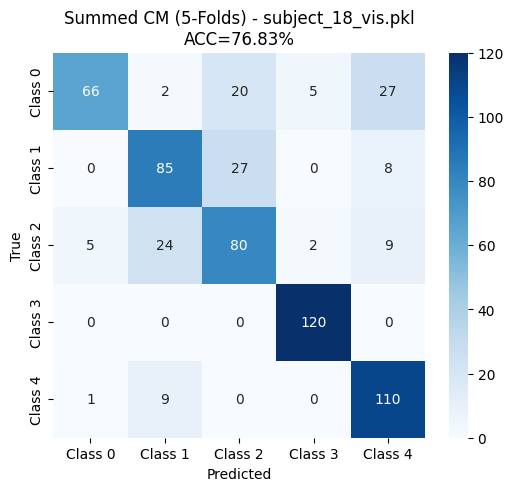


=== subject_19_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_19_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_19_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_19_vis.pkl_fold1] epoch=1/8 => val_loss=0.5997, val_acc=79.36%
[subject_19_vis.pkl_fold1] epoch=2/8 => val_loss=0.5743, val_acc=81.27%
[subject_19_vis.pkl_fold1] epoch=3/8 => val_loss=0.6945, val_acc=77.77%
[subject_19_vis.pkl_fold1] epoch=4/8 => val_loss=0.5607, val_acc=81.79%
[subject_19_vis.pkl_fold1] epoch=5/8 => val_loss=0.6066, val_acc=81.56%
[subject_19_vis.pkl_fold1] epoch=6/8 => val_loss=0.4949, val_acc=85.44%
[subject_19_vis.pkl_fold1] epoch=7/8 => val_loss=0.4147, val_acc=87.90%
[subject_19_vis.pkl_fold1] epoch=8/8 => val_loss=0.6136, val_acc=82.98%
[subject_19_vis.pkl_fold1] => best_val_loss=0.4147
[subject_19_vis.pkl] Fold 1 => Test ACC=88.33%, F1=0.8819

=== [File: subject_19_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_19_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_19_vis.pkl_fold2] epoch=1/8 => val_loss=0.5951, val_acc=80.28%
[subject_19_vis.pkl_fold2] epoch=2/8 => val_loss=0.6732, val_acc=76.09%
[subject_19_vis.pkl_fold2] epoch=3/8 => val_loss=0.4102, val_acc=87.24%
[subject_19_vis.pkl_fold2] epoch=4/8 => val_loss=0.6423, val_acc=79.17%
[subject_19_vis.pkl_fold2] epoch=5/8 => val_loss=0.5767, val_acc=84.73%
[subject_19_vis.pkl_fold2] epoch=6/8 => val_loss=0.4471, val_acc=86.53%
[subject_19_vis.pkl_fold2] Early stopping at epoch=6
[subject_19_vis.pkl_fold2] => best_val_loss=0.4102
[subject_19_vis.pkl] Fold 2 => Test ACC=67.50%, F1=0.6209

=== [File: subject_19_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_19_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_19_vis.pkl_fold3] epoch=1/8 => val_loss=0.5861, val_acc=79.05%
[subject_19_vis.pkl_fold3] epoch=2/8 => val_loss=0.5311, val_acc=81.98%
[subject_19_vis.pkl_fold3] epoch=3/8 => val_loss=0.4857, val_acc=83.95%
[subject_19_vis.pkl_fold3] epoch=4/8 => val_loss=0.4112, val_acc=85.96%
[subject_19_vis.pkl_fold3] epoch=5/8 => val_loss=0.3857, val_acc=86.65%
[subject_19_vis.pkl_fold3] epoch=6/8 => val_loss=0.4313, val_acc=87.69%
[subject_19_vis.pkl_fold3] epoch=7/8 => val_loss=0.4433, val_acc=86.58%
[subject_19_vis.pkl_fold3] epoch=8/8 => val_loss=0.4253, val_acc=89.04%
[subject_19_vis.pkl_fold3] Early stopping at epoch=8
[subject_19_vis.pkl_fold3] => best_val_loss=0.3857
[subject_19_vis.pkl] Fold 3 => Test ACC=80.00%, F1=0.7940

=== [File: subject_19_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_19_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_19_vis.pkl_fold4] epoch=1/8 => val_loss=0.6429, val_acc=77.60%
[subject_19_vis.pkl_fold4] epoch=2/8 => val_loss=0.5517, val_acc=81.30%
[subject_19_vis.pkl_fold4] epoch=3/8 => val_loss=0.5185, val_acc=83.05%
[subject_19_vis.pkl_fold4] epoch=4/8 => val_loss=0.4667, val_acc=85.32%
[subject_19_vis.pkl_fold4] epoch=5/8 => val_loss=0.5805, val_acc=83.36%
[subject_19_vis.pkl_fold4] epoch=6/8 => val_loss=0.5557, val_acc=84.00%
[subject_19_vis.pkl_fold4] epoch=7/8 => val_loss=0.4340, val_acc=87.36%
[subject_19_vis.pkl_fold4] epoch=8/8 => val_loss=0.5035, val_acc=87.43%
[subject_19_vis.pkl_fold4] => best_val_loss=0.4340
[subject_19_vis.pkl] Fold 4 => Test ACC=84.17%, F1=0.8327

=== [File: subject_19_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_19_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_19_vis.pkl_fold5] epoch=1/8 => val_loss=0.5865, val_acc=78.72%
[subject_19_vis.pkl_fold5] epoch=2/8 => val_loss=0.4381, val_acc=84.68%
[subject_19_vis.pkl_fold5] epoch=3/8 => val_loss=0.3967, val_acc=86.48%
[subject_19_vis.pkl_fold5] epoch=4/8 => val_loss=0.4303, val_acc=86.25%
[subject_19_vis.pkl_fold5] epoch=5/8 => val_loss=0.4510, val_acc=85.16%
[subject_19_vis.pkl_fold5] epoch=6/8 => val_loss=0.4434, val_acc=88.12%
[subject_19_vis.pkl_fold5] Early stopping at epoch=6
[subject_19_vis.pkl_fold5] => best_val_loss=0.3967
[subject_19_vis.pkl] Fold 5 => Test ACC=83.33%, F1=0.8253

=== [File: subject_19_vis.pkl] 5-Fold Mean Test ACC=80.67%, F1=0.7910


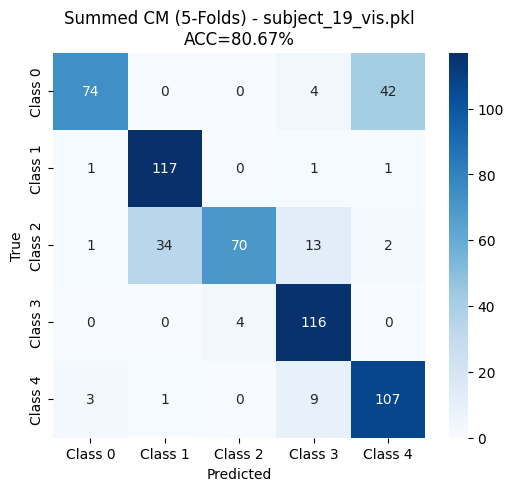


=== subject_20_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_20_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_20_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_20_vis.pkl_fold1] epoch=1/8 => val_loss=0.4702, val_acc=84.90%
[subject_20_vis.pkl_fold1] epoch=2/8 => val_loss=0.6485, val_acc=79.43%
[subject_20_vis.pkl_fold1] epoch=3/8 => val_loss=0.3365, val_acc=88.14%
[subject_20_vis.pkl_fold1] epoch=4/8 => val_loss=0.3199, val_acc=90.60%
[subject_20_vis.pkl_fold1] epoch=5/8 => val_loss=0.3657, val_acc=87.78%
[subject_20_vis.pkl_fold1] epoch=6/8 => val_loss=0.2887, val_acc=90.89%
[subject_20_vis.pkl_fold1] epoch=7/8 => val_loss=0.3105, val_acc=91.41%
[subject_20_vis.pkl_fold1] epoch=8/8 => val_loss=0.4136, val_acc=89.49%
[subject_20_vis.pkl_fold1] => best_val_loss=0.2887
[subject_20_vis.pkl] Fold 1 => Test ACC=89.17%, F1=0.8914

=== [File: subject_20_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_20_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_20_vis.pkl_fold2] epoch=1/8 => val_loss=0.4614, val_acc=84.99%
[subject_20_vis.pkl_fold2] epoch=2/8 => val_loss=0.4532, val_acc=83.38%
[subject_20_vis.pkl_fold2] epoch=3/8 => val_loss=0.4998, val_acc=83.12%
[subject_20_vis.pkl_fold2] epoch=4/8 => val_loss=0.3906, val_acc=86.43%
[subject_20_vis.pkl_fold2] epoch=5/8 => val_loss=0.3772, val_acc=89.11%
[subject_20_vis.pkl_fold2] epoch=6/8 => val_loss=0.3821, val_acc=88.49%
[subject_20_vis.pkl_fold2] epoch=7/8 => val_loss=0.2899, val_acc=90.96%
[subject_20_vis.pkl_fold2] epoch=8/8 => val_loss=0.3586, val_acc=89.91%
[subject_20_vis.pkl_fold2] => best_val_loss=0.2899
[subject_20_vis.pkl] Fold 2 => Test ACC=78.33%, F1=0.7802

=== [File: subject_20_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_20_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_20_vis.pkl_fold3] epoch=1/8 => val_loss=0.4690, val_acc=84.28%
[subject_20_vis.pkl_fold3] epoch=2/8 => val_loss=0.4089, val_acc=85.77%
[subject_20_vis.pkl_fold3] epoch=3/8 => val_loss=0.2417, val_acc=92.97%
[subject_20_vis.pkl_fold3] epoch=4/8 => val_loss=0.2834, val_acc=91.10%
[subject_20_vis.pkl_fold3] epoch=5/8 => val_loss=0.2809, val_acc=91.95%
[subject_20_vis.pkl_fold3] epoch=6/8 => val_loss=0.3166, val_acc=90.32%
[subject_20_vis.pkl_fold3] Early stopping at epoch=6
[subject_20_vis.pkl_fold3] => best_val_loss=0.2417
[subject_20_vis.pkl] Fold 3 => Test ACC=80.83%, F1=0.8134

=== [File: subject_20_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_20_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_20_vis.pkl_fold4] epoch=1/8 => val_loss=0.5124, val_acc=84.40%
[subject_20_vis.pkl_fold4] epoch=2/8 => val_loss=0.3901, val_acc=88.02%
[subject_20_vis.pkl_fold4] epoch=3/8 => val_loss=0.3877, val_acc=86.88%
[subject_20_vis.pkl_fold4] epoch=4/8 => val_loss=0.2374, val_acc=91.95%
[subject_20_vis.pkl_fold4] epoch=5/8 => val_loss=0.3127, val_acc=89.91%
[subject_20_vis.pkl_fold4] epoch=6/8 => val_loss=0.3087, val_acc=90.62%
[subject_20_vis.pkl_fold4] epoch=7/8 => val_loss=0.2933, val_acc=91.52%
[subject_20_vis.pkl_fold4] Early stopping at epoch=7
[subject_20_vis.pkl_fold4] => best_val_loss=0.2374
[subject_20_vis.pkl] Fold 4 => Test ACC=74.17%, F1=0.7270

=== [File: subject_20_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_20_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_20_vis.pkl_fold5] epoch=1/8 => val_loss=0.5946, val_acc=77.91%
[subject_20_vis.pkl_fold5] epoch=2/8 => val_loss=0.6377, val_acc=78.20%
[subject_20_vis.pkl_fold5] epoch=3/8 => val_loss=0.4308, val_acc=85.09%
[subject_20_vis.pkl_fold5] epoch=4/8 => val_loss=0.4123, val_acc=86.15%
[subject_20_vis.pkl_fold5] epoch=5/8 => val_loss=0.5941, val_acc=81.11%
[subject_20_vis.pkl_fold5] epoch=6/8 => val_loss=0.3971, val_acc=87.57%
[subject_20_vis.pkl_fold5] epoch=7/8 => val_loss=0.6168, val_acc=82.39%
[subject_20_vis.pkl_fold5] epoch=8/8 => val_loss=0.5165, val_acc=86.22%
[subject_20_vis.pkl_fold5] => best_val_loss=0.3971
[subject_20_vis.pkl] Fold 5 => Test ACC=80.00%, F1=0.8001

=== [File: subject_20_vis.pkl] 5-Fold Mean Test ACC=80.50%, F1=0.8024


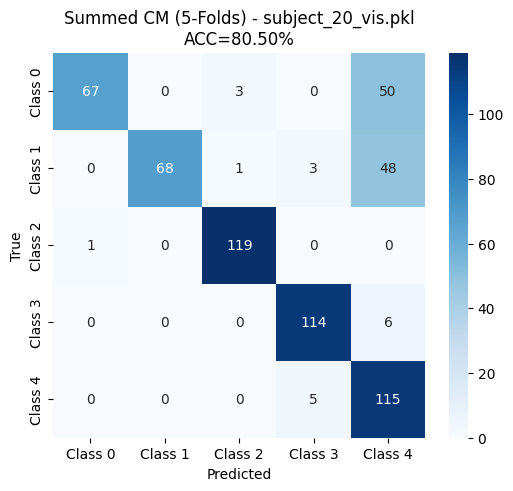


=== subject_21_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_21_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_21_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_21_vis.pkl_fold1] epoch=1/8 => val_loss=0.4753, val_acc=83.88%
[subject_21_vis.pkl_fold1] epoch=2/8 => val_loss=0.3808, val_acc=88.14%
[subject_21_vis.pkl_fold1] epoch=3/8 => val_loss=0.3744, val_acc=87.07%
[subject_21_vis.pkl_fold1] epoch=4/8 => val_loss=0.3879, val_acc=86.46%
[subject_21_vis.pkl_fold1] epoch=5/8 => val_loss=0.3671, val_acc=89.13%
[subject_21_vis.pkl_fold1] epoch=6/8 => val_loss=0.3067, val_acc=90.34%
[subject_21_vis.pkl_fold1] epoch=7/8 => val_loss=0.3612, val_acc=90.34%
[subject_21_vis.pkl_fold1] epoch=8/8 => val_loss=0.6016, val_acc=83.71%
[subject_21_vis.pkl_fold1] => best_val_loss=0.3067
[subject_21_vis.pkl] Fold 1 => Test ACC=75.83%, F1=0.7555

=== [File: subject_21_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_21_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_21_vis.pkl_fold2] epoch=1/8 => val_loss=0.3359, val_acc=91.34%
[subject_21_vis.pkl_fold2] epoch=2/8 => val_loss=0.3580, val_acc=88.80%
[subject_21_vis.pkl_fold2] epoch=3/8 => val_loss=0.2492, val_acc=92.47%
[subject_21_vis.pkl_fold2] epoch=4/8 => val_loss=0.3163, val_acc=89.65%
[subject_21_vis.pkl_fold2] epoch=5/8 => val_loss=0.2692, val_acc=92.05%
[subject_21_vis.pkl_fold2] epoch=6/8 => val_loss=0.2073, val_acc=93.82%
[subject_21_vis.pkl_fold2] epoch=7/8 => val_loss=0.1759, val_acc=94.32%
[subject_21_vis.pkl_fold2] epoch=8/8 => val_loss=0.1990, val_acc=94.72%
[subject_21_vis.pkl_fold2] => best_val_loss=0.1759
[subject_21_vis.pkl] Fold 2 => Test ACC=71.67%, F1=0.6810

=== [File: subject_21_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_21_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_21_vis.pkl_fold3] epoch=1/8 => val_loss=0.2897, val_acc=92.68%
[subject_21_vis.pkl_fold3] epoch=2/8 => val_loss=0.2756, val_acc=91.05%
[subject_21_vis.pkl_fold3] epoch=3/8 => val_loss=0.2368, val_acc=91.97%
[subject_21_vis.pkl_fold3] epoch=4/8 => val_loss=0.1091, val_acc=96.38%
[subject_21_vis.pkl_fold3] epoch=5/8 => val_loss=0.0718, val_acc=98.08%
[subject_21_vis.pkl_fold3] epoch=6/8 => val_loss=0.1914, val_acc=93.75%
[subject_21_vis.pkl_fold3] epoch=7/8 => val_loss=0.2338, val_acc=93.25%
[subject_21_vis.pkl_fold3] epoch=8/8 => val_loss=0.1436, val_acc=95.38%
[subject_21_vis.pkl_fold3] Early stopping at epoch=8
[subject_21_vis.pkl_fold3] => best_val_loss=0.0718
[subject_21_vis.pkl] Fold 3 => Test ACC=75.00%, F1=0.7236

=== [File: subject_21_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_21_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_21_vis.pkl_fold4] epoch=1/8 => val_loss=0.4858, val_acc=83.14%
[subject_21_vis.pkl_fold4] epoch=2/8 => val_loss=0.3806, val_acc=87.50%
[subject_21_vis.pkl_fold4] epoch=3/8 => val_loss=0.1936, val_acc=94.55%
[subject_21_vis.pkl_fold4] epoch=4/8 => val_loss=0.1747, val_acc=94.51%
[subject_21_vis.pkl_fold4] epoch=5/8 => val_loss=0.2896, val_acc=91.45%
[subject_21_vis.pkl_fold4] epoch=6/8 => val_loss=0.1655, val_acc=95.08%
[subject_21_vis.pkl_fold4] epoch=7/8 => val_loss=0.2542, val_acc=93.21%
[subject_21_vis.pkl_fold4] epoch=8/8 => val_loss=0.3384, val_acc=90.41%
[subject_21_vis.pkl_fold4] => best_val_loss=0.1655
[subject_21_vis.pkl] Fold 4 => Test ACC=74.17%, F1=0.7221

=== [File: subject_21_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_21_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_21_vis.pkl_fold5] epoch=1/8 => val_loss=0.6322, val_acc=77.77%
[subject_21_vis.pkl_fold5] epoch=2/8 => val_loss=0.2861, val_acc=91.45%
[subject_21_vis.pkl_fold5] epoch=3/8 => val_loss=0.3071, val_acc=90.34%
[subject_21_vis.pkl_fold5] epoch=4/8 => val_loss=0.2517, val_acc=91.83%
[subject_21_vis.pkl_fold5] epoch=5/8 => val_loss=0.3825, val_acc=88.07%
[subject_21_vis.pkl_fold5] epoch=6/8 => val_loss=0.4673, val_acc=87.57%
[subject_21_vis.pkl_fold5] epoch=7/8 => val_loss=0.3326, val_acc=90.84%
[subject_21_vis.pkl_fold5] Early stopping at epoch=7
[subject_21_vis.pkl_fold5] => best_val_loss=0.2517
[subject_21_vis.pkl] Fold 5 => Test ACC=75.00%, F1=0.7181

=== [File: subject_21_vis.pkl] 5-Fold Mean Test ACC=74.33%, F1=0.7200


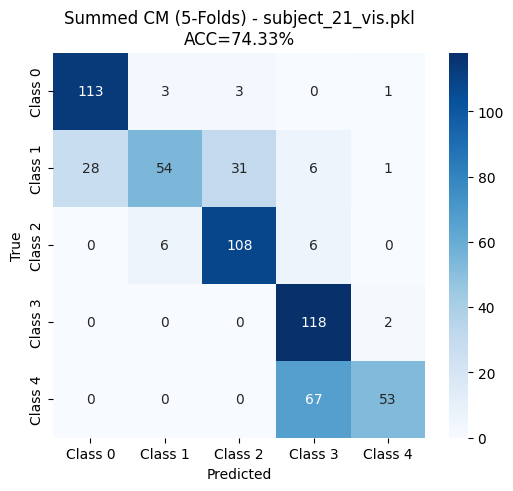


=== subject_22_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_22_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_22_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_22_vis.pkl_fold1] epoch=1/8 => val_loss=0.6362, val_acc=75.33%
[subject_22_vis.pkl_fold1] epoch=2/8 => val_loss=0.5165, val_acc=80.97%
[subject_22_vis.pkl_fold1] epoch=3/8 => val_loss=0.5868, val_acc=80.18%
[subject_22_vis.pkl_fold1] epoch=4/8 => val_loss=0.5999, val_acc=79.95%
[subject_22_vis.pkl_fold1] epoch=5/8 => val_loss=0.6147, val_acc=81.27%
[subject_22_vis.pkl_fold1] Early stopping at epoch=5
[subject_22_vis.pkl_fold1] => best_val_loss=0.5165
[subject_22_vis.pkl] Fold 1 => Test ACC=71.67%, F1=0.7101

=== [File: subject_22_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_22_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_22_vis.pkl_fold2] epoch=1/8 => val_loss=0.7944, val_acc=69.96%
[subject_22_vis.pkl_fold2] epoch=2/8 => val_loss=0.6237, val_acc=76.92%
[subject_22_vis.pkl_fold2] epoch=3/8 => val_loss=0.8702, val_acc=72.59%
[subject_22_vis.pkl_fold2] epoch=4/8 => val_loss=0.6158, val_acc=80.07%
[subject_22_vis.pkl_fold2] epoch=5/8 => val_loss=0.7470, val_acc=78.20%
[subject_22_vis.pkl_fold2] epoch=6/8 => val_loss=0.6759, val_acc=81.20%
[subject_22_vis.pkl_fold2] epoch=7/8 => val_loss=0.8164, val_acc=77.75%
[subject_22_vis.pkl_fold2] Early stopping at epoch=7
[subject_22_vis.pkl_fold2] => best_val_loss=0.6158
[subject_22_vis.pkl] Fold 2 => Test ACC=61.67%, F1=0.5962

=== [File: subject_22_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_22_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_22_vis.pkl_fold3] epoch=1/8 => val_loss=0.5823, val_acc=80.85%
[subject_22_vis.pkl_fold3] epoch=2/8 => val_loss=0.4473, val_acc=84.59%
[subject_22_vis.pkl_fold3] epoch=3/8 => val_loss=0.3673, val_acc=87.74%
[subject_22_vis.pkl_fold3] epoch=4/8 => val_loss=0.5228, val_acc=84.33%
[subject_22_vis.pkl_fold3] epoch=5/8 => val_loss=0.4267, val_acc=86.15%
[subject_22_vis.pkl_fold3] epoch=6/8 => val_loss=0.4288, val_acc=86.72%
[subject_22_vis.pkl_fold3] Early stopping at epoch=6
[subject_22_vis.pkl_fold3] => best_val_loss=0.3673
[subject_22_vis.pkl] Fold 3 => Test ACC=74.17%, F1=0.7416

=== [File: subject_22_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_22_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_22_vis.pkl_fold4] epoch=1/8 => val_loss=0.7390, val_acc=71.19%
[subject_22_vis.pkl_fold4] epoch=2/8 => val_loss=0.6304, val_acc=76.28%
[subject_22_vis.pkl_fold4] epoch=3/8 => val_loss=0.6301, val_acc=78.84%
[subject_22_vis.pkl_fold4] epoch=4/8 => val_loss=0.7258, val_acc=76.07%
[subject_22_vis.pkl_fold4] epoch=5/8 => val_loss=0.4930, val_acc=84.11%
[subject_22_vis.pkl_fold4] epoch=6/8 => val_loss=0.5281, val_acc=84.00%
[subject_22_vis.pkl_fold4] epoch=7/8 => val_loss=0.5939, val_acc=81.20%
[subject_22_vis.pkl_fold4] epoch=8/8 => val_loss=0.6482, val_acc=82.36%
[subject_22_vis.pkl_fold4] Early stopping at epoch=8
[subject_22_vis.pkl_fold4] => best_val_loss=0.4930
[subject_22_vis.pkl] Fold 4 => Test ACC=75.83%, F1=0.7590

=== [File: subject_22_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_22_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_22_vis.pkl_fold5] epoch=1/8 => val_loss=0.6657, val_acc=75.71%
[subject_22_vis.pkl_fold5] epoch=2/8 => val_loss=0.5648, val_acc=80.04%
[subject_22_vis.pkl_fold5] epoch=3/8 => val_loss=0.5880, val_acc=80.63%
[subject_22_vis.pkl_fold5] epoch=4/8 => val_loss=0.6965, val_acc=78.81%
[subject_22_vis.pkl_fold5] epoch=5/8 => val_loss=0.7098, val_acc=79.97%
[subject_22_vis.pkl_fold5] Early stopping at epoch=5
[subject_22_vis.pkl_fold5] => best_val_loss=0.5648
[subject_22_vis.pkl] Fold 5 => Test ACC=68.33%, F1=0.6640

=== [File: subject_22_vis.pkl] 5-Fold Mean Test ACC=70.33%, F1=0.6942


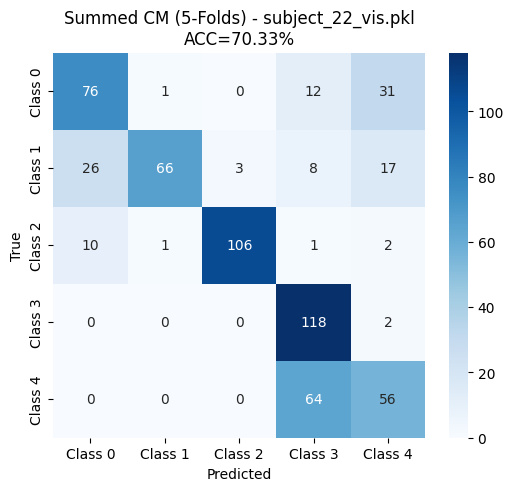


=== subject_23_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_23_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_23_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_23_vis.pkl_fold1] epoch=1/8 => val_loss=0.6034, val_acc=77.82%
[subject_23_vis.pkl_fold1] epoch=2/8 => val_loss=0.4854, val_acc=83.52%
[subject_23_vis.pkl_fold1] epoch=3/8 => val_loss=0.5527, val_acc=81.72%
[subject_23_vis.pkl_fold1] epoch=4/8 => val_loss=0.4602, val_acc=84.47%
[subject_23_vis.pkl_fold1] epoch=5/8 => val_loss=0.3903, val_acc=88.28%
[subject_23_vis.pkl_fold1] epoch=6/8 => val_loss=0.6481, val_acc=82.98%
[subject_23_vis.pkl_fold1] epoch=7/8 => val_loss=0.6631, val_acc=82.39%
[subject_23_vis.pkl_fold1] epoch=8/8 => val_loss=0.4158, val_acc=89.04%
[subject_23_vis.pkl_fold1] Early stopping at epoch=8
[subject_23_vis.pkl_fold1] => best_val_loss=0.3903
[subject_23_vis.pkl] Fold 1 => Test ACC=48.33%, F1=0.4467

=== [File: subject_23_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_23_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_23_vis.pkl_fold2] epoch=1/8 => val_loss=0.5204, val_acc=82.34%
[subject_23_vis.pkl_fold2] epoch=2/8 => val_loss=0.4696, val_acc=84.30%
[subject_23_vis.pkl_fold2] epoch=3/8 => val_loss=0.4257, val_acc=86.08%
[subject_23_vis.pkl_fold2] epoch=4/8 => val_loss=0.5297, val_acc=83.45%
[subject_23_vis.pkl_fold2] epoch=5/8 => val_loss=0.4870, val_acc=86.70%
[subject_23_vis.pkl_fold2] epoch=6/8 => val_loss=0.5513, val_acc=84.35%
[subject_23_vis.pkl_fold2] Early stopping at epoch=6
[subject_23_vis.pkl_fold2] => best_val_loss=0.4257
[subject_23_vis.pkl] Fold 2 => Test ACC=55.83%, F1=0.5326

=== [File: subject_23_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_23_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_23_vis.pkl_fold3] epoch=1/8 => val_loss=0.5816, val_acc=79.83%
[subject_23_vis.pkl_fold3] epoch=2/8 => val_loss=0.3963, val_acc=86.15%
[subject_23_vis.pkl_fold3] epoch=3/8 => val_loss=0.5482, val_acc=81.34%
[subject_23_vis.pkl_fold3] epoch=4/8 => val_loss=0.4654, val_acc=85.06%
[subject_23_vis.pkl_fold3] epoch=5/8 => val_loss=0.3695, val_acc=88.73%
[subject_23_vis.pkl_fold3] epoch=6/8 => val_loss=0.3387, val_acc=89.87%
[subject_23_vis.pkl_fold3] epoch=7/8 => val_loss=0.4430, val_acc=87.33%
[subject_23_vis.pkl_fold3] epoch=8/8 => val_loss=0.4064, val_acc=88.92%
[subject_23_vis.pkl_fold3] => best_val_loss=0.3387
[subject_23_vis.pkl] Fold 3 => Test ACC=45.00%, F1=0.4078

=== [File: subject_23_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_23_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_23_vis.pkl_fold4] epoch=1/8 => val_loss=0.5903, val_acc=80.33%
[subject_23_vis.pkl_fold4] epoch=2/8 => val_loss=0.5537, val_acc=82.86%
[subject_23_vis.pkl_fold4] epoch=3/8 => val_loss=0.4656, val_acc=83.71%
[subject_23_vis.pkl_fold4] epoch=4/8 => val_loss=0.5391, val_acc=85.32%
[subject_23_vis.pkl_fold4] epoch=5/8 => val_loss=0.7769, val_acc=79.59%
[subject_23_vis.pkl_fold4] epoch=6/8 => val_loss=0.6136, val_acc=82.08%
[subject_23_vis.pkl_fold4] Early stopping at epoch=6
[subject_23_vis.pkl_fold4] => best_val_loss=0.4656
[subject_23_vis.pkl] Fold 4 => Test ACC=59.17%, F1=0.5785

=== [File: subject_23_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_23_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_23_vis.pkl_fold5] epoch=1/8 => val_loss=0.5880, val_acc=77.63%
[subject_23_vis.pkl_fold5] epoch=2/8 => val_loss=0.4087, val_acc=85.94%
[subject_23_vis.pkl_fold5] epoch=3/8 => val_loss=0.5223, val_acc=82.03%
[subject_23_vis.pkl_fold5] epoch=4/8 => val_loss=0.5017, val_acc=84.80%
[subject_23_vis.pkl_fold5] epoch=5/8 => val_loss=0.4319, val_acc=87.00%
[subject_23_vis.pkl_fold5] Early stopping at epoch=5
[subject_23_vis.pkl_fold5] => best_val_loss=0.4087
[subject_23_vis.pkl] Fold 5 => Test ACC=50.83%, F1=0.4840

=== [File: subject_23_vis.pkl] 5-Fold Mean Test ACC=51.83%, F1=0.4899


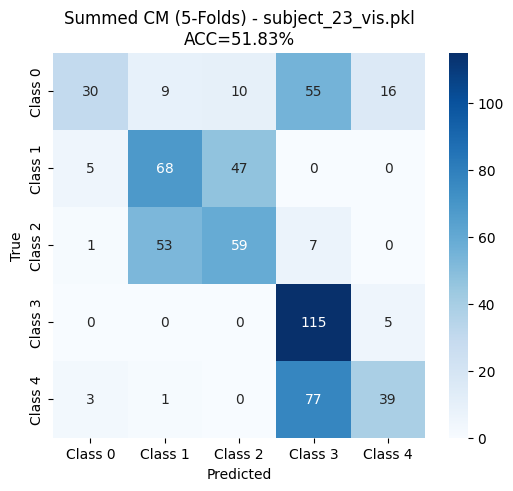


=== subject_24_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_24_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_24_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_24_vis.pkl_fold1] epoch=1/8 => val_loss=0.4928, val_acc=82.74%
[subject_24_vis.pkl_fold1] epoch=2/8 => val_loss=0.5100, val_acc=82.67%
[subject_24_vis.pkl_fold1] epoch=3/8 => val_loss=0.3795, val_acc=87.78%
[subject_24_vis.pkl_fold1] epoch=4/8 => val_loss=0.3906, val_acc=87.12%
[subject_24_vis.pkl_fold1] epoch=5/8 => val_loss=0.2206, val_acc=92.68%
[subject_24_vis.pkl_fold1] epoch=6/8 => val_loss=0.3951, val_acc=88.66%
[subject_24_vis.pkl_fold1] epoch=7/8 => val_loss=0.2993, val_acc=91.05%
[subject_24_vis.pkl_fold1] epoch=8/8 => val_loss=0.2308, val_acc=93.32%
[subject_24_vis.pkl_fold1] Early stopping at epoch=8
[subject_24_vis.pkl_fold1] => best_val_loss=0.2206
[subject_24_vis.pkl] Fold 1 => Test ACC=82.50%, F1=0.8025

=== [File: subject_24_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_24_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_24_vis.pkl_fold2] epoch=1/8 => val_loss=0.3474, val_acc=90.77%
[subject_24_vis.pkl_fold2] epoch=2/8 => val_loss=0.3569, val_acc=87.50%
[subject_24_vis.pkl_fold2] epoch=3/8 => val_loss=0.1940, val_acc=93.80%
[subject_24_vis.pkl_fold2] epoch=4/8 => val_loss=0.1780, val_acc=94.06%
[subject_24_vis.pkl_fold2] epoch=5/8 => val_loss=0.1955, val_acc=93.84%
[subject_24_vis.pkl_fold2] epoch=6/8 => val_loss=0.2598, val_acc=90.70%
[subject_24_vis.pkl_fold2] epoch=7/8 => val_loss=0.2362, val_acc=93.54%
[subject_24_vis.pkl_fold2] Early stopping at epoch=7
[subject_24_vis.pkl_fold2] => best_val_loss=0.1780
[subject_24_vis.pkl] Fold 2 => Test ACC=80.00%, F1=0.7900

=== [File: subject_24_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_24_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_24_vis.pkl_fold3] epoch=1/8 => val_loss=0.3176, val_acc=92.09%
[subject_24_vis.pkl_fold3] epoch=2/8 => val_loss=0.3822, val_acc=87.50%
[subject_24_vis.pkl_fold3] epoch=3/8 => val_loss=0.2135, val_acc=93.32%
[subject_24_vis.pkl_fold3] epoch=4/8 => val_loss=0.2221, val_acc=92.76%
[subject_24_vis.pkl_fold3] epoch=5/8 => val_loss=0.2524, val_acc=92.76%
[subject_24_vis.pkl_fold3] epoch=6/8 => val_loss=0.2673, val_acc=92.42%
[subject_24_vis.pkl_fold3] Early stopping at epoch=6
[subject_24_vis.pkl_fold3] => best_val_loss=0.2135
[subject_24_vis.pkl] Fold 3 => Test ACC=75.83%, F1=0.7593

=== [File: subject_24_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_24_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_24_vis.pkl_fold4] epoch=1/8 => val_loss=0.4787, val_acc=85.75%
[subject_24_vis.pkl_fold4] epoch=2/8 => val_loss=0.4226, val_acc=86.25%
[subject_24_vis.pkl_fold4] epoch=3/8 => val_loss=0.2770, val_acc=91.19%
[subject_24_vis.pkl_fold4] epoch=4/8 => val_loss=0.2601, val_acc=91.48%
[subject_24_vis.pkl_fold4] epoch=5/8 => val_loss=0.2500, val_acc=92.52%
[subject_24_vis.pkl_fold4] epoch=6/8 => val_loss=0.1787, val_acc=94.74%
[subject_24_vis.pkl_fold4] epoch=7/8 => val_loss=0.3784, val_acc=88.57%
[subject_24_vis.pkl_fold4] epoch=8/8 => val_loss=0.4714, val_acc=86.77%
[subject_24_vis.pkl_fold4] => best_val_loss=0.1787
[subject_24_vis.pkl] Fold 4 => Test ACC=75.00%, F1=0.7392

=== [File: subject_24_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_24_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_24_vis.pkl_fold5] epoch=1/8 => val_loss=0.4687, val_acc=85.94%
[subject_24_vis.pkl_fold5] epoch=2/8 => val_loss=0.2372, val_acc=93.30%
[subject_24_vis.pkl_fold5] epoch=3/8 => val_loss=0.2870, val_acc=91.31%
[subject_24_vis.pkl_fold5] epoch=4/8 => val_loss=0.2865, val_acc=91.12%
[subject_24_vis.pkl_fold5] epoch=5/8 => val_loss=0.1908, val_acc=93.84%
[subject_24_vis.pkl_fold5] epoch=6/8 => val_loss=0.2211, val_acc=93.54%
[subject_24_vis.pkl_fold5] epoch=7/8 => val_loss=0.3569, val_acc=91.10%
[subject_24_vis.pkl_fold5] epoch=8/8 => val_loss=0.2308, val_acc=93.21%
[subject_24_vis.pkl_fold5] Early stopping at epoch=8
[subject_24_vis.pkl_fold5] => best_val_loss=0.1908
[subject_24_vis.pkl] Fold 5 => Test ACC=80.83%, F1=0.7969

=== [File: subject_24_vis.pkl] 5-Fold Mean Test ACC=78.83%, F1=0.7776


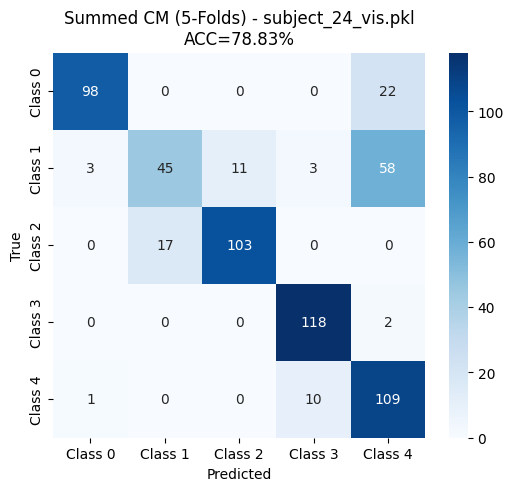


=== subject_25_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_25_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_25_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_25_vis.pkl_fold1] epoch=1/8 => val_loss=0.6297, val_acc=76.87%
[subject_25_vis.pkl_fold1] epoch=2/8 => val_loss=0.5958, val_acc=78.60%
[subject_25_vis.pkl_fold1] epoch=3/8 => val_loss=0.5291, val_acc=83.50%
[subject_25_vis.pkl_fold1] epoch=4/8 => val_loss=0.3806, val_acc=87.29%
[subject_25_vis.pkl_fold1] epoch=5/8 => val_loss=0.3301, val_acc=89.96%
[subject_25_vis.pkl_fold1] epoch=6/8 => val_loss=0.4626, val_acc=87.41%
[subject_25_vis.pkl_fold1] epoch=7/8 => val_loss=0.4666, val_acc=86.43%
[subject_25_vis.pkl_fold1] epoch=8/8 => val_loss=0.4558, val_acc=87.36%
[subject_25_vis.pkl_fold1] Early stopping at epoch=8
[subject_25_vis.pkl_fold1] => best_val_loss=0.3301
[subject_25_vis.pkl] Fold 1 => Test ACC=74.17%, F1=0.7385

=== [File: subject_25_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_25_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_25_vis.pkl_fold2] epoch=1/8 => val_loss=0.5454, val_acc=83.74%
[subject_25_vis.pkl_fold2] epoch=2/8 => val_loss=0.3743, val_acc=88.78%
[subject_25_vis.pkl_fold2] epoch=3/8 => val_loss=0.3805, val_acc=88.12%
[subject_25_vis.pkl_fold2] epoch=4/8 => val_loss=0.3584, val_acc=87.95%
[subject_25_vis.pkl_fold2] epoch=5/8 => val_loss=0.3849, val_acc=88.40%
[subject_25_vis.pkl_fold2] epoch=6/8 => val_loss=0.5490, val_acc=84.61%
[subject_25_vis.pkl_fold2] epoch=7/8 => val_loss=0.4015, val_acc=88.33%
[subject_25_vis.pkl_fold2] Early stopping at epoch=7
[subject_25_vis.pkl_fold2] => best_val_loss=0.3584
[subject_25_vis.pkl] Fold 2 => Test ACC=65.00%, F1=0.6371

=== [File: subject_25_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_25_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_25_vis.pkl_fold3] epoch=1/8 => val_loss=0.4615, val_acc=85.70%
[subject_25_vis.pkl_fold3] epoch=2/8 => val_loss=0.5021, val_acc=80.61%
[subject_25_vis.pkl_fold3] epoch=3/8 => val_loss=0.3011, val_acc=89.94%
[subject_25_vis.pkl_fold3] epoch=4/8 => val_loss=0.3965, val_acc=87.29%
[subject_25_vis.pkl_fold3] epoch=5/8 => val_loss=0.3731, val_acc=88.66%
[subject_25_vis.pkl_fold3] epoch=6/8 => val_loss=0.3313, val_acc=90.55%
[subject_25_vis.pkl_fold3] Early stopping at epoch=6
[subject_25_vis.pkl_fold3] => best_val_loss=0.3011
[subject_25_vis.pkl] Fold 3 => Test ACC=56.67%, F1=0.5270

=== [File: subject_25_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_25_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_25_vis.pkl_fold4] epoch=1/8 => val_loss=0.5832, val_acc=78.53%
[subject_25_vis.pkl_fold4] epoch=2/8 => val_loss=0.4882, val_acc=81.58%
[subject_25_vis.pkl_fold4] epoch=3/8 => val_loss=0.6745, val_acc=76.25%
[subject_25_vis.pkl_fold4] epoch=4/8 => val_loss=0.4750, val_acc=84.66%
[subject_25_vis.pkl_fold4] epoch=5/8 => val_loss=0.4126, val_acc=87.19%
[subject_25_vis.pkl_fold4] epoch=6/8 => val_loss=0.6686, val_acc=79.12%
[subject_25_vis.pkl_fold4] epoch=7/8 => val_loss=0.4561, val_acc=87.93%
[subject_25_vis.pkl_fold4] epoch=8/8 => val_loss=0.5173, val_acc=87.07%
[subject_25_vis.pkl_fold4] Early stopping at epoch=8
[subject_25_vis.pkl_fold4] => best_val_loss=0.4126
[subject_25_vis.pkl] Fold 4 => Test ACC=57.50%, F1=0.5416

=== [File: subject_25_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_25_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_25_vis.pkl_fold5] epoch=1/8 => val_loss=0.6342, val_acc=74.55%
[subject_25_vis.pkl_fold5] epoch=2/8 => val_loss=0.4748, val_acc=83.24%
[subject_25_vis.pkl_fold5] epoch=3/8 => val_loss=0.3563, val_acc=87.78%
[subject_25_vis.pkl_fold5] epoch=4/8 => val_loss=0.3953, val_acc=86.86%
[subject_25_vis.pkl_fold5] epoch=5/8 => val_loss=0.5025, val_acc=84.30%
[subject_25_vis.pkl_fold5] epoch=6/8 => val_loss=0.1862, val_acc=93.63%
[subject_25_vis.pkl_fold5] epoch=7/8 => val_loss=0.2110, val_acc=93.58%
[subject_25_vis.pkl_fold5] epoch=8/8 => val_loss=0.2009, val_acc=92.61%
[subject_25_vis.pkl_fold5] => best_val_loss=0.1862
[subject_25_vis.pkl] Fold 5 => Test ACC=66.67%, F1=0.6481

=== [File: subject_25_vis.pkl] 5-Fold Mean Test ACC=64.00%, F1=0.6184


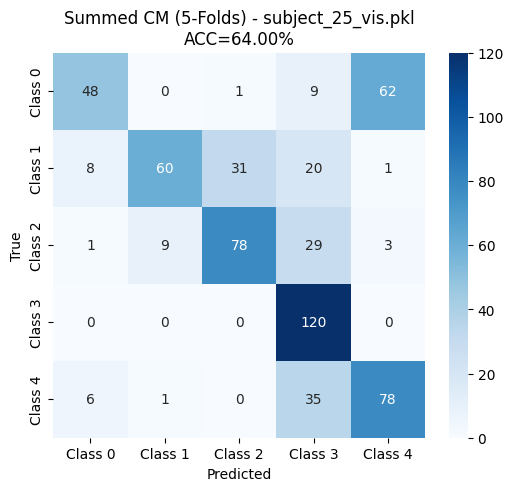


=== subject_26_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_26_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_26_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_26_vis.pkl_fold1] epoch=1/8 => val_loss=0.6042, val_acc=77.34%
[subject_26_vis.pkl_fold1] epoch=2/8 => val_loss=0.3207, val_acc=89.63%
[subject_26_vis.pkl_fold1] epoch=3/8 => val_loss=0.3405, val_acc=88.64%
[subject_26_vis.pkl_fold1] epoch=4/8 => val_loss=0.5761, val_acc=82.17%
[subject_26_vis.pkl_fold1] epoch=5/8 => val_loss=0.2977, val_acc=90.62%
[subject_26_vis.pkl_fold1] epoch=6/8 => val_loss=0.4345, val_acc=88.00%
[subject_26_vis.pkl_fold1] epoch=7/8 => val_loss=0.3113, val_acc=90.20%
[subject_26_vis.pkl_fold1] epoch=8/8 => val_loss=0.2901, val_acc=92.68%
[subject_26_vis.pkl_fold1] => best_val_loss=0.2901
[subject_26_vis.pkl] Fold 1 => Test ACC=66.67%, F1=0.6740

=== [File: subject_26_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_26_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_26_vis.pkl_fold2] epoch=1/8 => val_loss=0.6568, val_acc=77.56%
[subject_26_vis.pkl_fold2] epoch=2/8 => val_loss=0.4207, val_acc=86.62%
[subject_26_vis.pkl_fold2] epoch=3/8 => val_loss=0.3545, val_acc=88.94%
[subject_26_vis.pkl_fold2] epoch=4/8 => val_loss=0.3595, val_acc=88.59%
[subject_26_vis.pkl_fold2] epoch=5/8 => val_loss=0.4273, val_acc=86.86%
[subject_26_vis.pkl_fold2] epoch=6/8 => val_loss=0.3011, val_acc=90.55%
[subject_26_vis.pkl_fold2] epoch=7/8 => val_loss=0.3573, val_acc=89.44%
[subject_26_vis.pkl_fold2] epoch=8/8 => val_loss=0.4128, val_acc=88.21%
[subject_26_vis.pkl_fold2] => best_val_loss=0.3011
[subject_26_vis.pkl] Fold 2 => Test ACC=77.50%, F1=0.7645

=== [File: subject_26_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_26_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_26_vis.pkl_fold3] epoch=1/8 => val_loss=0.7003, val_acc=73.22%
[subject_26_vis.pkl_fold3] epoch=2/8 => val_loss=0.4058, val_acc=85.94%
[subject_26_vis.pkl_fold3] epoch=3/8 => val_loss=0.2646, val_acc=90.70%
[subject_26_vis.pkl_fold3] epoch=4/8 => val_loss=0.2880, val_acc=90.15%
[subject_26_vis.pkl_fold3] epoch=5/8 => val_loss=0.3243, val_acc=89.16%
[subject_26_vis.pkl_fold3] epoch=6/8 => val_loss=0.2780, val_acc=90.89%
[subject_26_vis.pkl_fold3] Early stopping at epoch=6
[subject_26_vis.pkl_fold3] => best_val_loss=0.2646
[subject_26_vis.pkl] Fold 3 => Test ACC=70.00%, F1=0.6884

=== [File: subject_26_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_26_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_26_vis.pkl_fold4] epoch=1/8 => val_loss=0.7247, val_acc=74.48%
[subject_26_vis.pkl_fold4] epoch=2/8 => val_loss=0.5396, val_acc=81.25%
[subject_26_vis.pkl_fold4] epoch=3/8 => val_loss=0.5504, val_acc=82.10%
[subject_26_vis.pkl_fold4] epoch=4/8 => val_loss=0.4474, val_acc=85.96%
[subject_26_vis.pkl_fold4] epoch=5/8 => val_loss=0.5197, val_acc=84.23%
[subject_26_vis.pkl_fold4] epoch=6/8 => val_loss=0.6760, val_acc=81.39%
[subject_26_vis.pkl_fold4] epoch=7/8 => val_loss=0.4857, val_acc=85.87%
[subject_26_vis.pkl_fold4] Early stopping at epoch=7
[subject_26_vis.pkl_fold4] => best_val_loss=0.4474
[subject_26_vis.pkl] Fold 4 => Test ACC=70.83%, F1=0.7006

=== [File: subject_26_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_26_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_26_vis.pkl_fold5] epoch=1/8 => val_loss=0.7584, val_acc=71.73%
[subject_26_vis.pkl_fold5] epoch=2/8 => val_loss=0.5491, val_acc=82.03%
[subject_26_vis.pkl_fold5] epoch=3/8 => val_loss=0.3774, val_acc=87.31%
[subject_26_vis.pkl_fold5] epoch=4/8 => val_loss=0.3629, val_acc=89.06%
[subject_26_vis.pkl_fold5] epoch=5/8 => val_loss=0.5389, val_acc=84.56%
[subject_26_vis.pkl_fold5] epoch=6/8 => val_loss=0.2314, val_acc=92.97%
[subject_26_vis.pkl_fold5] epoch=7/8 => val_loss=0.2773, val_acc=91.97%
[subject_26_vis.pkl_fold5] epoch=8/8 => val_loss=0.5959, val_acc=83.14%
[subject_26_vis.pkl_fold5] => best_val_loss=0.2314
[subject_26_vis.pkl] Fold 5 => Test ACC=77.50%, F1=0.7671

=== [File: subject_26_vis.pkl] 5-Fold Mean Test ACC=72.50%, F1=0.7189


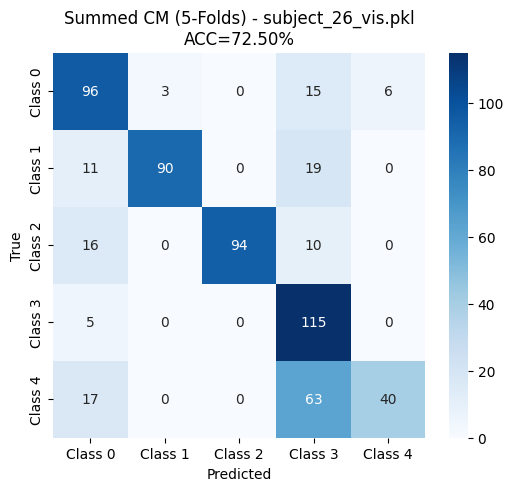


=== subject_27_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_27_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_27_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_27_vis.pkl_fold1] epoch=1/8 => val_loss=0.4376, val_acc=84.87%
[subject_27_vis.pkl_fold1] epoch=2/8 => val_loss=0.1963, val_acc=95.27%
[subject_27_vis.pkl_fold1] epoch=3/8 => val_loss=0.1647, val_acc=95.31%
[subject_27_vis.pkl_fold1] epoch=4/8 => val_loss=0.1874, val_acc=94.53%
[subject_27_vis.pkl_fold1] epoch=5/8 => val_loss=0.1622, val_acc=95.27%
[subject_27_vis.pkl_fold1] epoch=6/8 => val_loss=0.3522, val_acc=90.08%
[subject_27_vis.pkl_fold1] epoch=7/8 => val_loss=0.2435, val_acc=92.90%
[subject_27_vis.pkl_fold1] epoch=8/8 => val_loss=0.1415, val_acc=95.86%
[subject_27_vis.pkl_fold1] => best_val_loss=0.1415
[subject_27_vis.pkl] Fold 1 => Test ACC=92.50%, F1=0.9247

=== [File: subject_27_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_27_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_27_vis.pkl_fold2] epoch=1/8 => val_loss=0.3786, val_acc=88.61%
[subject_27_vis.pkl_fold2] epoch=2/8 => val_loss=0.3811, val_acc=87.22%
[subject_27_vis.pkl_fold2] epoch=3/8 => val_loss=0.1566, val_acc=96.09%
[subject_27_vis.pkl_fold2] epoch=4/8 => val_loss=0.5429, val_acc=85.13%
[subject_27_vis.pkl_fold2] epoch=5/8 => val_loss=0.3214, val_acc=91.19%
[subject_27_vis.pkl_fold2] epoch=6/8 => val_loss=0.3086, val_acc=91.76%
[subject_27_vis.pkl_fold2] Early stopping at epoch=6
[subject_27_vis.pkl_fold2] => best_val_loss=0.1566
[subject_27_vis.pkl] Fold 2 => Test ACC=80.83%, F1=0.8029

=== [File: subject_27_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_27_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_27_vis.pkl_fold3] epoch=1/8 => val_loss=0.3090, val_acc=90.79%
[subject_27_vis.pkl_fold3] epoch=2/8 => val_loss=0.2176, val_acc=93.82%
[subject_27_vis.pkl_fold3] epoch=3/8 => val_loss=0.1055, val_acc=96.95%
[subject_27_vis.pkl_fold3] epoch=4/8 => val_loss=0.2584, val_acc=92.12%
[subject_27_vis.pkl_fold3] epoch=5/8 => val_loss=0.1556, val_acc=95.64%
[subject_27_vis.pkl_fold3] epoch=6/8 => val_loss=0.1948, val_acc=93.66%
[subject_27_vis.pkl_fold3] Early stopping at epoch=6
[subject_27_vis.pkl_fold3] => best_val_loss=0.1055
[subject_27_vis.pkl] Fold 3 => Test ACC=85.00%, F1=0.8418

=== [File: subject_27_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_27_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_27_vis.pkl_fold4] epoch=1/8 => val_loss=0.2425, val_acc=94.46%
[subject_27_vis.pkl_fold4] epoch=2/8 => val_loss=0.1522, val_acc=96.24%
[subject_27_vis.pkl_fold4] epoch=3/8 => val_loss=0.1053, val_acc=97.09%
[subject_27_vis.pkl_fold4] epoch=4/8 => val_loss=0.2172, val_acc=93.54%
[subject_27_vis.pkl_fold4] epoch=5/8 => val_loss=0.1009, val_acc=97.02%
[subject_27_vis.pkl_fold4] epoch=6/8 => val_loss=0.2363, val_acc=92.19%
[subject_27_vis.pkl_fold4] epoch=7/8 => val_loss=0.1460, val_acc=95.67%
[subject_27_vis.pkl_fold4] epoch=8/8 => val_loss=0.0709, val_acc=98.15%
[subject_27_vis.pkl_fold4] => best_val_loss=0.0709
[subject_27_vis.pkl] Fold 4 => Test ACC=84.17%, F1=0.8374

=== [File: subject_27_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_27_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_27_vis.pkl_fold5] epoch=1/8 => val_loss=0.4776, val_acc=84.71%
[subject_27_vis.pkl_fold5] epoch=2/8 => val_loss=0.2411, val_acc=92.66%
[subject_27_vis.pkl_fold5] epoch=3/8 => val_loss=0.2202, val_acc=93.92%
[subject_27_vis.pkl_fold5] epoch=4/8 => val_loss=0.2471, val_acc=93.35%
[subject_27_vis.pkl_fold5] epoch=5/8 => val_loss=0.2557, val_acc=92.09%
[subject_27_vis.pkl_fold5] epoch=6/8 => val_loss=0.4076, val_acc=88.14%
[subject_27_vis.pkl_fold5] Early stopping at epoch=6
[subject_27_vis.pkl_fold5] => best_val_loss=0.2202
[subject_27_vis.pkl] Fold 5 => Test ACC=84.17%, F1=0.8381

=== [File: subject_27_vis.pkl] 5-Fold Mean Test ACC=85.33%, F1=0.8490


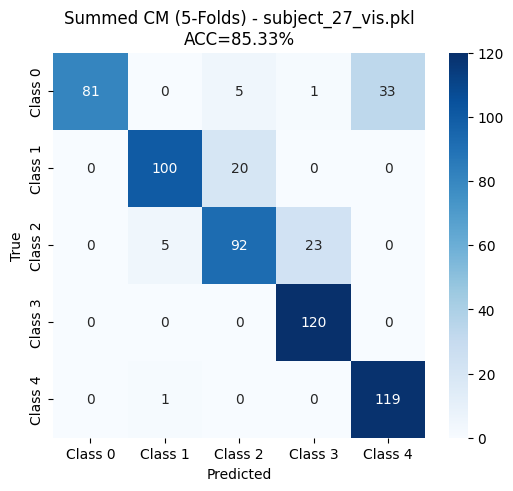


=== subject_28_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_28_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_28_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_28_vis.pkl_fold1] epoch=1/8 => val_loss=0.4045, val_acc=86.72%
[subject_28_vis.pkl_fold1] epoch=2/8 => val_loss=0.2404, val_acc=92.52%
[subject_28_vis.pkl_fold1] epoch=3/8 => val_loss=0.1917, val_acc=94.96%
[subject_28_vis.pkl_fold1] epoch=4/8 => val_loss=0.1146, val_acc=96.80%
[subject_28_vis.pkl_fold1] epoch=5/8 => val_loss=0.2684, val_acc=92.21%
[subject_28_vis.pkl_fold1] epoch=6/8 => val_loss=0.2105, val_acc=93.75%
[subject_28_vis.pkl_fold1] epoch=7/8 => val_loss=0.0930, val_acc=97.16%
[subject_28_vis.pkl_fold1] epoch=8/8 => val_loss=0.1038, val_acc=97.02%
[subject_28_vis.pkl_fold1] => best_val_loss=0.0930
[subject_28_vis.pkl] Fold 1 => Test ACC=77.50%, F1=0.7686

=== [File: subject_28_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_28_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_28_vis.pkl_fold2] epoch=1/8 => val_loss=0.5621, val_acc=82.72%
[subject_28_vis.pkl_fold2] epoch=2/8 => val_loss=0.2908, val_acc=91.64%
[subject_28_vis.pkl_fold2] epoch=3/8 => val_loss=0.2392, val_acc=92.97%
[subject_28_vis.pkl_fold2] epoch=4/8 => val_loss=0.2676, val_acc=92.59%
[subject_28_vis.pkl_fold2] epoch=5/8 => val_loss=0.1893, val_acc=95.00%
[subject_28_vis.pkl_fold2] epoch=6/8 => val_loss=0.2944, val_acc=91.15%
[subject_28_vis.pkl_fold2] epoch=7/8 => val_loss=0.1811, val_acc=95.17%
[subject_28_vis.pkl_fold2] epoch=8/8 => val_loss=0.2027, val_acc=95.67%
[subject_28_vis.pkl_fold2] => best_val_loss=0.1811
[subject_28_vis.pkl] Fold 2 => Test ACC=70.83%, F1=0.6935

=== [File: subject_28_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_28_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_28_vis.pkl_fold3] epoch=1/8 => val_loss=0.3920, val_acc=87.45%
[subject_28_vis.pkl_fold3] epoch=2/8 => val_loss=0.2953, val_acc=91.45%
[subject_28_vis.pkl_fold3] epoch=3/8 => val_loss=0.1685, val_acc=95.38%
[subject_28_vis.pkl_fold3] epoch=4/8 => val_loss=0.2497, val_acc=92.28%
[subject_28_vis.pkl_fold3] epoch=5/8 => val_loss=0.2273, val_acc=92.97%
[subject_28_vis.pkl_fold3] epoch=6/8 => val_loss=0.4653, val_acc=86.96%
[subject_28_vis.pkl_fold3] Early stopping at epoch=6
[subject_28_vis.pkl_fold3] => best_val_loss=0.1685
[subject_28_vis.pkl] Fold 3 => Test ACC=76.67%, F1=0.7494

=== [File: subject_28_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_28_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_28_vis.pkl_fold4] epoch=1/8 => val_loss=0.4420, val_acc=85.35%
[subject_28_vis.pkl_fold4] epoch=2/8 => val_loss=0.3054, val_acc=90.74%
[subject_28_vis.pkl_fold4] epoch=3/8 => val_loss=0.3076, val_acc=89.73%
[subject_28_vis.pkl_fold4] epoch=4/8 => val_loss=0.2358, val_acc=92.68%
[subject_28_vis.pkl_fold4] epoch=5/8 => val_loss=0.2418, val_acc=92.26%
[subject_28_vis.pkl_fold4] epoch=6/8 => val_loss=0.1879, val_acc=94.79%
[subject_28_vis.pkl_fold4] epoch=7/8 => val_loss=0.1824, val_acc=94.25%
[subject_28_vis.pkl_fold4] epoch=8/8 => val_loss=0.3521, val_acc=90.03%
[subject_28_vis.pkl_fold4] => best_val_loss=0.1824
[subject_28_vis.pkl] Fold 4 => Test ACC=61.67%, F1=0.6002

=== [File: subject_28_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_28_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_28_vis.pkl_fold5] epoch=1/8 => val_loss=0.4524, val_acc=87.43%
[subject_28_vis.pkl_fold5] epoch=2/8 => val_loss=0.3324, val_acc=88.71%
[subject_28_vis.pkl_fold5] epoch=3/8 => val_loss=0.1640, val_acc=95.24%
[subject_28_vis.pkl_fold5] epoch=4/8 => val_loss=0.1742, val_acc=94.67%
[subject_28_vis.pkl_fold5] epoch=5/8 => val_loss=0.1770, val_acc=94.82%
[subject_28_vis.pkl_fold5] epoch=6/8 => val_loss=0.1992, val_acc=94.18%
[subject_28_vis.pkl_fold5] Early stopping at epoch=6
[subject_28_vis.pkl_fold5] => best_val_loss=0.1640
[subject_28_vis.pkl] Fold 5 => Test ACC=71.67%, F1=0.6909

=== [File: subject_28_vis.pkl] 5-Fold Mean Test ACC=71.67%, F1=0.7005


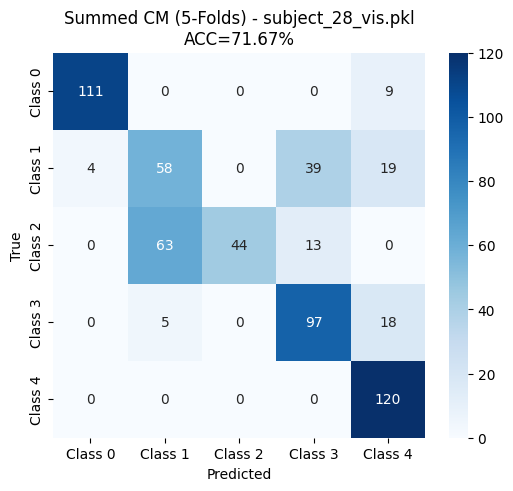


=== subject_29_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_29_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_29_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_29_vis.pkl_fold1] epoch=1/8 => val_loss=0.8100, val_acc=70.62%
[subject_29_vis.pkl_fold1] epoch=2/8 => val_loss=0.5619, val_acc=80.16%
[subject_29_vis.pkl_fold1] epoch=3/8 => val_loss=0.4528, val_acc=86.17%
[subject_29_vis.pkl_fold1] epoch=4/8 => val_loss=0.5737, val_acc=81.37%
[subject_29_vis.pkl_fold1] epoch=5/8 => val_loss=0.4110, val_acc=86.72%
[subject_29_vis.pkl_fold1] epoch=6/8 => val_loss=0.3846, val_acc=87.14%
[subject_29_vis.pkl_fold1] epoch=7/8 => val_loss=0.4393, val_acc=86.77%
[subject_29_vis.pkl_fold1] epoch=8/8 => val_loss=0.7038, val_acc=81.53%
[subject_29_vis.pkl_fold1] => best_val_loss=0.3846
[subject_29_vis.pkl] Fold 1 => Test ACC=75.83%, F1=0.7497

=== [File: subject_29_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_29_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_29_vis.pkl_fold2] epoch=1/8 => val_loss=0.8334, val_acc=69.89%
[subject_29_vis.pkl_fold2] epoch=2/8 => val_loss=0.7214, val_acc=75.80%
[subject_29_vis.pkl_fold2] epoch=3/8 => val_loss=0.5752, val_acc=80.49%
[subject_29_vis.pkl_fold2] epoch=4/8 => val_loss=0.6021, val_acc=81.27%
[subject_29_vis.pkl_fold2] epoch=5/8 => val_loss=0.6414, val_acc=80.49%
[subject_29_vis.pkl_fold2] epoch=6/8 => val_loss=0.6154, val_acc=83.36%
[subject_29_vis.pkl_fold2] Early stopping at epoch=6
[subject_29_vis.pkl_fold2] => best_val_loss=0.5752
[subject_29_vis.pkl] Fold 2 => Test ACC=73.33%, F1=0.7271

=== [File: subject_29_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_29_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_29_vis.pkl_fold3] epoch=1/8 => val_loss=0.9573, val_acc=63.54%
[subject_29_vis.pkl_fold3] epoch=2/8 => val_loss=0.5790, val_acc=81.61%
[subject_29_vis.pkl_fold3] epoch=3/8 => val_loss=0.4834, val_acc=84.61%
[subject_29_vis.pkl_fold3] epoch=4/8 => val_loss=0.5952, val_acc=83.12%
[subject_29_vis.pkl_fold3] epoch=5/8 => val_loss=0.5450, val_acc=83.31%
[subject_29_vis.pkl_fold3] epoch=6/8 => val_loss=0.4777, val_acc=86.17%
[subject_29_vis.pkl_fold3] epoch=7/8 => val_loss=0.5859, val_acc=84.16%
[subject_29_vis.pkl_fold3] epoch=8/8 => val_loss=0.4994, val_acc=86.81%
[subject_29_vis.pkl_fold3] => best_val_loss=0.4777
[subject_29_vis.pkl] Fold 3 => Test ACC=80.83%, F1=0.8062

=== [File: subject_29_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_29_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_29_vis.pkl_fold4] epoch=1/8 => val_loss=0.6661, val_acc=77.01%
[subject_29_vis.pkl_fold4] epoch=2/8 => val_loss=0.4831, val_acc=83.95%
[subject_29_vis.pkl_fold4] epoch=3/8 => val_loss=0.5453, val_acc=82.60%
[subject_29_vis.pkl_fold4] epoch=4/8 => val_loss=0.4392, val_acc=86.58%
[subject_29_vis.pkl_fold4] epoch=5/8 => val_loss=0.4749, val_acc=86.43%
[subject_29_vis.pkl_fold4] epoch=6/8 => val_loss=0.4511, val_acc=86.65%
[subject_29_vis.pkl_fold4] epoch=7/8 => val_loss=0.3608, val_acc=89.06%
[subject_29_vis.pkl_fold4] epoch=8/8 => val_loss=0.5342, val_acc=86.34%
[subject_29_vis.pkl_fold4] => best_val_loss=0.3608
[subject_29_vis.pkl] Fold 4 => Test ACC=70.00%, F1=0.6865

=== [File: subject_29_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_29_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_29_vis.pkl_fold5] epoch=1/8 => val_loss=0.7855, val_acc=73.30%
[subject_29_vis.pkl_fold5] epoch=2/8 => val_loss=0.5649, val_acc=79.81%
[subject_29_vis.pkl_fold5] epoch=3/8 => val_loss=0.6620, val_acc=77.94%
[subject_29_vis.pkl_fold5] epoch=4/8 => val_loss=0.6213, val_acc=81.18%
[subject_29_vis.pkl_fold5] epoch=5/8 => val_loss=0.6982, val_acc=78.86%
[subject_29_vis.pkl_fold5] Early stopping at epoch=5
[subject_29_vis.pkl_fold5] => best_val_loss=0.5649
[subject_29_vis.pkl] Fold 5 => Test ACC=73.33%, F1=0.7265

=== [File: subject_29_vis.pkl] 5-Fold Mean Test ACC=74.67%, F1=0.7392


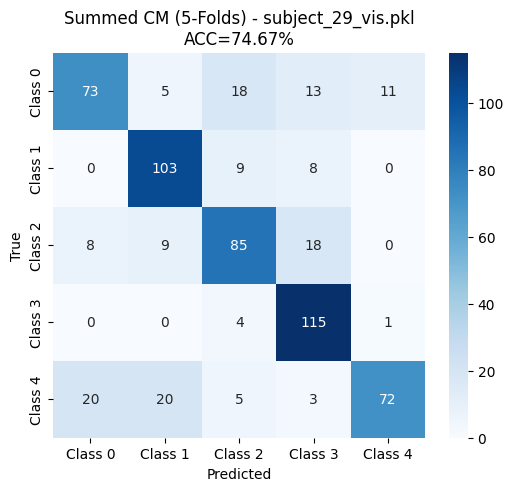


=== subject_30_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_30_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_30_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_30_vis.pkl_fold1] epoch=1/8 => val_loss=0.6873, val_acc=76.56%
[subject_30_vis.pkl_fold1] epoch=2/8 => val_loss=0.4310, val_acc=84.35%
[subject_30_vis.pkl_fold1] epoch=3/8 => val_loss=0.4015, val_acc=87.14%
[subject_30_vis.pkl_fold1] epoch=4/8 => val_loss=0.2782, val_acc=91.45%
[subject_30_vis.pkl_fold1] epoch=5/8 => val_loss=0.3992, val_acc=86.84%
[subject_30_vis.pkl_fold1] epoch=6/8 => val_loss=0.2925, val_acc=90.62%
[subject_30_vis.pkl_fold1] epoch=7/8 => val_loss=0.3080, val_acc=91.52%
[subject_30_vis.pkl_fold1] Early stopping at epoch=7
[subject_30_vis.pkl_fold1] => best_val_loss=0.2782
[subject_30_vis.pkl] Fold 1 => Test ACC=73.33%, F1=0.6868

=== [File: subject_30_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_30_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_30_vis.pkl_fold2] epoch=1/8 => val_loss=0.5578, val_acc=81.56%
[subject_30_vis.pkl_fold2] epoch=2/8 => val_loss=0.5284, val_acc=82.36%
[subject_30_vis.pkl_fold2] epoch=3/8 => val_loss=0.2943, val_acc=89.37%
[subject_30_vis.pkl_fold2] epoch=4/8 => val_loss=0.2847, val_acc=90.84%
[subject_30_vis.pkl_fold2] epoch=5/8 => val_loss=0.5554, val_acc=80.47%
[subject_30_vis.pkl_fold2] epoch=6/8 => val_loss=0.2538, val_acc=92.38%
[subject_30_vis.pkl_fold2] epoch=7/8 => val_loss=0.2780, val_acc=91.10%
[subject_30_vis.pkl_fold2] epoch=8/8 => val_loss=0.2410, val_acc=93.02%
[subject_30_vis.pkl_fold2] => best_val_loss=0.2410
[subject_30_vis.pkl] Fold 2 => Test ACC=69.17%, F1=0.6765

=== [File: subject_30_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_30_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_30_vis.pkl_fold3] epoch=1/8 => val_loss=0.4606, val_acc=84.87%
[subject_30_vis.pkl_fold3] epoch=2/8 => val_loss=0.3087, val_acc=90.77%
[subject_30_vis.pkl_fold3] epoch=3/8 => val_loss=0.2757, val_acc=92.12%
[subject_30_vis.pkl_fold3] epoch=4/8 => val_loss=0.2215, val_acc=93.11%
[subject_30_vis.pkl_fold3] epoch=5/8 => val_loss=0.2072, val_acc=93.82%
[subject_30_vis.pkl_fold3] epoch=6/8 => val_loss=0.2417, val_acc=93.25%
[subject_30_vis.pkl_fold3] epoch=7/8 => val_loss=0.3840, val_acc=89.06%
[subject_30_vis.pkl_fold3] epoch=8/8 => val_loss=0.2350, val_acc=93.61%
[subject_30_vis.pkl_fold3] Early stopping at epoch=8
[subject_30_vis.pkl_fold3] => best_val_loss=0.2072
[subject_30_vis.pkl] Fold 3 => Test ACC=77.50%, F1=0.7508

=== [File: subject_30_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_30_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_30_vis.pkl_fold4] epoch=1/8 => val_loss=0.4929, val_acc=83.03%
[subject_30_vis.pkl_fold4] epoch=2/8 => val_loss=0.5392, val_acc=82.53%
[subject_30_vis.pkl_fold4] epoch=3/8 => val_loss=0.4146, val_acc=86.13%
[subject_30_vis.pkl_fold4] epoch=4/8 => val_loss=0.8284, val_acc=75.71%
[subject_30_vis.pkl_fold4] epoch=5/8 => val_loss=0.5995, val_acc=84.16%
[subject_30_vis.pkl_fold4] epoch=6/8 => val_loss=0.4344, val_acc=87.50%
[subject_30_vis.pkl_fold4] Early stopping at epoch=6
[subject_30_vis.pkl_fold4] => best_val_loss=0.4146
[subject_30_vis.pkl] Fold 4 => Test ACC=70.00%, F1=0.6644

=== [File: subject_30_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_30_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_30_vis.pkl_fold5] epoch=1/8 => val_loss=0.4544, val_acc=85.70%
[subject_30_vis.pkl_fold5] epoch=2/8 => val_loss=0.4584, val_acc=84.61%
[subject_30_vis.pkl_fold5] epoch=3/8 => val_loss=0.4588, val_acc=84.35%
[subject_30_vis.pkl_fold5] epoch=4/8 => val_loss=0.3861, val_acc=86.98%
[subject_30_vis.pkl_fold5] epoch=5/8 => val_loss=0.4760, val_acc=85.13%
[subject_30_vis.pkl_fold5] epoch=6/8 => val_loss=0.4267, val_acc=87.86%
[subject_30_vis.pkl_fold5] epoch=7/8 => val_loss=0.3540, val_acc=90.06%
[subject_30_vis.pkl_fold5] epoch=8/8 => val_loss=0.3261, val_acc=90.81%
[subject_30_vis.pkl_fold5] => best_val_loss=0.3261
[subject_30_vis.pkl] Fold 5 => Test ACC=75.83%, F1=0.7525

=== [File: subject_30_vis.pkl] 5-Fold Mean Test ACC=73.17%, F1=0.7062


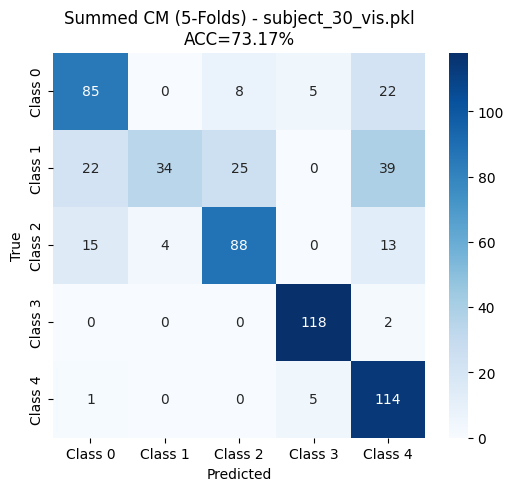


=== subject_31_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_31_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_31_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_31_vis.pkl_fold1] epoch=1/8 => val_loss=0.2852, val_acc=91.76%
[subject_31_vis.pkl_fold1] epoch=2/8 => val_loss=0.1702, val_acc=95.24%
[subject_31_vis.pkl_fold1] epoch=3/8 => val_loss=0.1378, val_acc=95.31%
[subject_31_vis.pkl_fold1] epoch=4/8 => val_loss=0.0910, val_acc=97.44%
[subject_31_vis.pkl_fold1] epoch=5/8 => val_loss=0.2544, val_acc=92.33%
[subject_31_vis.pkl_fold1] epoch=6/8 => val_loss=0.1217, val_acc=96.31%
[subject_31_vis.pkl_fold1] epoch=7/8 => val_loss=0.1209, val_acc=96.88%
[subject_31_vis.pkl_fold1] Early stopping at epoch=7
[subject_31_vis.pkl_fold1] => best_val_loss=0.0910
[subject_31_vis.pkl] Fold 1 => Test ACC=69.17%, F1=0.6448

=== [File: subject_31_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_31_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_31_vis.pkl_fold2] epoch=1/8 => val_loss=0.3750, val_acc=89.04%
[subject_31_vis.pkl_fold2] epoch=2/8 => val_loss=0.4393, val_acc=85.13%
[subject_31_vis.pkl_fold2] epoch=3/8 => val_loss=0.4113, val_acc=86.65%
[subject_31_vis.pkl_fold2] epoch=4/8 => val_loss=0.6485, val_acc=81.46%
[subject_31_vis.pkl_fold2] Early stopping at epoch=4
[subject_31_vis.pkl_fold2] => best_val_loss=0.3750
[subject_31_vis.pkl] Fold 2 => Test ACC=74.17%, F1=0.6938

=== [File: subject_31_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_31_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_31_vis.pkl_fold3] epoch=1/8 => val_loss=0.3406, val_acc=90.55%
[subject_31_vis.pkl_fold3] epoch=2/8 => val_loss=0.1953, val_acc=94.32%
[subject_31_vis.pkl_fold3] epoch=3/8 => val_loss=0.1986, val_acc=93.61%
[subject_31_vis.pkl_fold3] epoch=4/8 => val_loss=0.2371, val_acc=93.75%
[subject_31_vis.pkl_fold3] epoch=5/8 => val_loss=0.1431, val_acc=96.09%
[subject_31_vis.pkl_fold3] epoch=6/8 => val_loss=0.1021, val_acc=97.16%
[subject_31_vis.pkl_fold3] epoch=7/8 => val_loss=0.1128, val_acc=97.09%
[subject_31_vis.pkl_fold3] epoch=8/8 => val_loss=0.1619, val_acc=95.60%
[subject_31_vis.pkl_fold3] => best_val_loss=0.1021
[subject_31_vis.pkl] Fold 3 => Test ACC=67.50%, F1=0.6185

=== [File: subject_31_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_31_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_31_vis.pkl_fold4] epoch=1/8 => val_loss=0.4455, val_acc=85.16%
[subject_31_vis.pkl_fold4] epoch=2/8 => val_loss=0.3266, val_acc=89.70%
[subject_31_vis.pkl_fold4] epoch=3/8 => val_loss=0.4035, val_acc=88.38%
[subject_31_vis.pkl_fold4] epoch=4/8 => val_loss=0.3913, val_acc=89.99%
[subject_31_vis.pkl_fold4] epoch=5/8 => val_loss=0.4561, val_acc=89.20%
[subject_31_vis.pkl_fold4] Early stopping at epoch=5
[subject_31_vis.pkl_fold4] => best_val_loss=0.3266
[subject_31_vis.pkl] Fold 4 => Test ACC=65.83%, F1=0.6104

=== [File: subject_31_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_31_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_31_vis.pkl_fold5] epoch=1/8 => val_loss=0.3918, val_acc=85.87%
[subject_31_vis.pkl_fold5] epoch=2/8 => val_loss=0.3810, val_acc=88.14%
[subject_31_vis.pkl_fold5] epoch=3/8 => val_loss=0.2332, val_acc=93.04%
[subject_31_vis.pkl_fold5] epoch=4/8 => val_loss=0.1343, val_acc=96.31%
[subject_31_vis.pkl_fold5] epoch=5/8 => val_loss=0.1490, val_acc=94.96%
[subject_31_vis.pkl_fold5] epoch=6/8 => val_loss=0.2740, val_acc=92.19%
[subject_31_vis.pkl_fold5] epoch=7/8 => val_loss=0.2527, val_acc=92.47%
[subject_31_vis.pkl_fold5] Early stopping at epoch=7
[subject_31_vis.pkl_fold5] => best_val_loss=0.1343
[subject_31_vis.pkl] Fold 5 => Test ACC=66.67%, F1=0.6116

=== [File: subject_31_vis.pkl] 5-Fold Mean Test ACC=68.67%, F1=0.6358


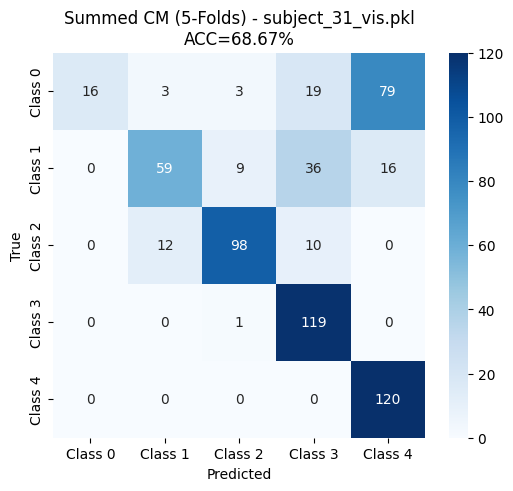


=== subject_32_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_32_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_32_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_32_vis.pkl_fold1] epoch=1/8 => val_loss=0.3996, val_acc=87.29%
[subject_32_vis.pkl_fold1] epoch=2/8 => val_loss=0.2120, val_acc=93.96%
[subject_32_vis.pkl_fold1] epoch=3/8 => val_loss=0.1982, val_acc=93.96%
[subject_32_vis.pkl_fold1] epoch=4/8 => val_loss=0.2282, val_acc=93.87%
[subject_32_vis.pkl_fold1] epoch=5/8 => val_loss=0.3317, val_acc=90.67%
[subject_32_vis.pkl_fold1] epoch=6/8 => val_loss=0.2299, val_acc=93.23%
[subject_32_vis.pkl_fold1] Early stopping at epoch=6
[subject_32_vis.pkl_fold1] => best_val_loss=0.1982
[subject_32_vis.pkl] Fold 1 => Test ACC=60.83%, F1=0.6052

=== [File: subject_32_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_32_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_32_vis.pkl_fold2] epoch=1/8 => val_loss=0.3701, val_acc=88.19%
[subject_32_vis.pkl_fold2] epoch=2/8 => val_loss=0.2372, val_acc=93.16%
[subject_32_vis.pkl_fold2] epoch=3/8 => val_loss=0.2135, val_acc=92.95%
[subject_32_vis.pkl_fold2] epoch=4/8 => val_loss=0.1851, val_acc=94.58%
[subject_32_vis.pkl_fold2] epoch=5/8 => val_loss=0.2381, val_acc=92.23%
[subject_32_vis.pkl_fold2] epoch=6/8 => val_loss=0.1080, val_acc=96.59%
[subject_32_vis.pkl_fold2] epoch=7/8 => val_loss=0.1651, val_acc=95.00%
[subject_32_vis.pkl_fold2] epoch=8/8 => val_loss=0.3237, val_acc=91.03%
[subject_32_vis.pkl_fold2] => best_val_loss=0.1080
[subject_32_vis.pkl] Fold 2 => Test ACC=62.50%, F1=0.6173

=== [File: subject_32_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_32_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_32_vis.pkl_fold3] epoch=1/8 => val_loss=0.3086, val_acc=92.33%
[subject_32_vis.pkl_fold3] epoch=2/8 => val_loss=0.2983, val_acc=90.91%
[subject_32_vis.pkl_fold3] epoch=3/8 => val_loss=0.4386, val_acc=85.56%
[subject_32_vis.pkl_fold3] epoch=4/8 => val_loss=0.2470, val_acc=92.76%
[subject_32_vis.pkl_fold3] epoch=5/8 => val_loss=0.2363, val_acc=93.47%
[subject_32_vis.pkl_fold3] epoch=6/8 => val_loss=0.2808, val_acc=92.35%
[subject_32_vis.pkl_fold3] epoch=7/8 => val_loss=0.3628, val_acc=90.55%
[subject_32_vis.pkl_fold3] epoch=8/8 => val_loss=0.2396, val_acc=93.61%
[subject_32_vis.pkl_fold3] Early stopping at epoch=8
[subject_32_vis.pkl_fold3] => best_val_loss=0.2363
[subject_32_vis.pkl] Fold 3 => Test ACC=53.33%, F1=0.5329

=== [File: subject_32_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_32_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_32_vis.pkl_fold4] epoch=1/8 => val_loss=0.3834, val_acc=89.35%
[subject_32_vis.pkl_fold4] epoch=2/8 => val_loss=0.3275, val_acc=89.77%
[subject_32_vis.pkl_fold4] epoch=3/8 => val_loss=0.3279, val_acc=90.84%
[subject_32_vis.pkl_fold4] epoch=4/8 => val_loss=0.2909, val_acc=92.05%
[subject_32_vis.pkl_fold4] epoch=5/8 => val_loss=0.4712, val_acc=87.71%
[subject_32_vis.pkl_fold4] epoch=6/8 => val_loss=0.2808, val_acc=92.19%
[subject_32_vis.pkl_fold4] epoch=7/8 => val_loss=0.3611, val_acc=90.48%
[subject_32_vis.pkl_fold4] epoch=8/8 => val_loss=0.2806, val_acc=92.54%
[subject_32_vis.pkl_fold4] => best_val_loss=0.2806
[subject_32_vis.pkl] Fold 4 => Test ACC=67.50%, F1=0.6694

=== [File: subject_32_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_32_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_32_vis.pkl_fold5] epoch=1/8 => val_loss=0.4987, val_acc=82.86%
[subject_32_vis.pkl_fold5] epoch=2/8 => val_loss=0.5152, val_acc=82.74%
[subject_32_vis.pkl_fold5] epoch=3/8 => val_loss=0.4122, val_acc=87.14%
[subject_32_vis.pkl_fold5] epoch=4/8 => val_loss=0.5799, val_acc=83.95%
[subject_32_vis.pkl_fold5] epoch=5/8 => val_loss=0.3406, val_acc=89.77%
[subject_32_vis.pkl_fold5] epoch=6/8 => val_loss=0.4015, val_acc=89.13%
[subject_32_vis.pkl_fold5] epoch=7/8 => val_loss=0.4324, val_acc=88.07%
[subject_32_vis.pkl_fold5] epoch=8/8 => val_loss=0.3556, val_acc=90.55%
[subject_32_vis.pkl_fold5] Early stopping at epoch=8
[subject_32_vis.pkl_fold5] => best_val_loss=0.3406
[subject_32_vis.pkl] Fold 5 => Test ACC=68.33%, F1=0.6689

=== [File: subject_32_vis.pkl] 5-Fold Mean Test ACC=62.50%, F1=0.6188


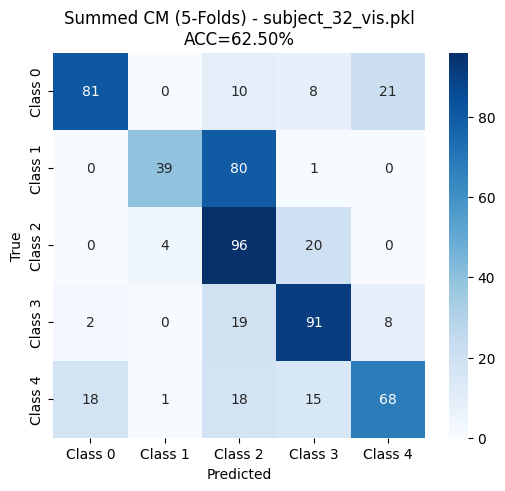


=== subject_33_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_33_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_33_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_33_vis.pkl_fold1] epoch=1/8 => val_loss=0.7058, val_acc=74.57%
[subject_33_vis.pkl_fold1] epoch=2/8 => val_loss=0.6548, val_acc=75.76%
[subject_33_vis.pkl_fold1] epoch=3/8 => val_loss=0.4212, val_acc=86.17%
[subject_33_vis.pkl_fold1] epoch=4/8 => val_loss=0.5348, val_acc=83.57%
[subject_33_vis.pkl_fold1] epoch=5/8 => val_loss=0.5738, val_acc=83.24%
[subject_33_vis.pkl_fold1] epoch=6/8 => val_loss=0.7165, val_acc=81.11%
[subject_33_vis.pkl_fold1] Early stopping at epoch=6
[subject_33_vis.pkl_fold1] => best_val_loss=0.4212
[subject_33_vis.pkl] Fold 1 => Test ACC=85.83%, F1=0.8569

=== [File: subject_33_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_33_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_33_vis.pkl_fold2] epoch=1/8 => val_loss=0.6024, val_acc=79.17%
[subject_33_vis.pkl_fold2] epoch=2/8 => val_loss=0.4160, val_acc=87.03%
[subject_33_vis.pkl_fold2] epoch=3/8 => val_loss=0.4446, val_acc=85.72%
[subject_33_vis.pkl_fold2] epoch=4/8 => val_loss=0.5371, val_acc=84.97%
[subject_33_vis.pkl_fold2] epoch=5/8 => val_loss=0.4575, val_acc=87.14%
[subject_33_vis.pkl_fold2] Early stopping at epoch=5
[subject_33_vis.pkl_fold2] => best_val_loss=0.4160
[subject_33_vis.pkl] Fold 2 => Test ACC=89.17%, F1=0.8911

=== [File: subject_33_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_33_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_33_vis.pkl_fold3] epoch=1/8 => val_loss=0.5625, val_acc=81.30%
[subject_33_vis.pkl_fold3] epoch=2/8 => val_loss=0.4611, val_acc=85.77%
[subject_33_vis.pkl_fold3] epoch=3/8 => val_loss=0.4673, val_acc=85.91%
[subject_33_vis.pkl_fold3] epoch=4/8 => val_loss=0.4287, val_acc=86.84%
[subject_33_vis.pkl_fold3] epoch=5/8 => val_loss=0.4854, val_acc=85.94%
[subject_33_vis.pkl_fold3] epoch=6/8 => val_loss=0.4668, val_acc=88.52%
[subject_33_vis.pkl_fold3] epoch=7/8 => val_loss=0.5156, val_acc=86.46%
[subject_33_vis.pkl_fold3] Early stopping at epoch=7
[subject_33_vis.pkl_fold3] => best_val_loss=0.4287
[subject_33_vis.pkl] Fold 3 => Test ACC=85.83%, F1=0.8566

=== [File: subject_33_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_33_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_33_vis.pkl_fold4] epoch=1/8 => val_loss=0.7931, val_acc=71.97%
[subject_33_vis.pkl_fold4] epoch=2/8 => val_loss=0.5026, val_acc=81.68%
[subject_33_vis.pkl_fold4] epoch=3/8 => val_loss=0.5705, val_acc=80.56%
[subject_33_vis.pkl_fold4] epoch=4/8 => val_loss=0.5004, val_acc=84.00%
[subject_33_vis.pkl_fold4] epoch=5/8 => val_loss=0.4207, val_acc=85.35%
[subject_33_vis.pkl_fold4] epoch=6/8 => val_loss=0.4810, val_acc=85.75%
[subject_33_vis.pkl_fold4] epoch=7/8 => val_loss=0.5654, val_acc=84.59%
[subject_33_vis.pkl_fold4] epoch=8/8 => val_loss=0.6078, val_acc=83.97%
[subject_33_vis.pkl_fold4] Early stopping at epoch=8
[subject_33_vis.pkl_fold4] => best_val_loss=0.4207
[subject_33_vis.pkl] Fold 4 => Test ACC=83.33%, F1=0.8267

=== [File: subject_33_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_33_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_33_vis.pkl_fold5] epoch=1/8 => val_loss=0.6118, val_acc=78.03%
[subject_33_vis.pkl_fold5] epoch=2/8 => val_loss=0.5255, val_acc=80.47%
[subject_33_vis.pkl_fold5] epoch=3/8 => val_loss=0.3630, val_acc=87.64%
[subject_33_vis.pkl_fold5] epoch=4/8 => val_loss=0.4633, val_acc=85.37%
[subject_33_vis.pkl_fold5] epoch=5/8 => val_loss=0.5753, val_acc=81.84%
[subject_33_vis.pkl_fold5] epoch=6/8 => val_loss=0.4745, val_acc=86.55%
[subject_33_vis.pkl_fold5] Early stopping at epoch=6
[subject_33_vis.pkl_fold5] => best_val_loss=0.3630
[subject_33_vis.pkl] Fold 5 => Test ACC=89.17%, F1=0.8903

=== [File: subject_33_vis.pkl] 5-Fold Mean Test ACC=86.67%, F1=0.8643


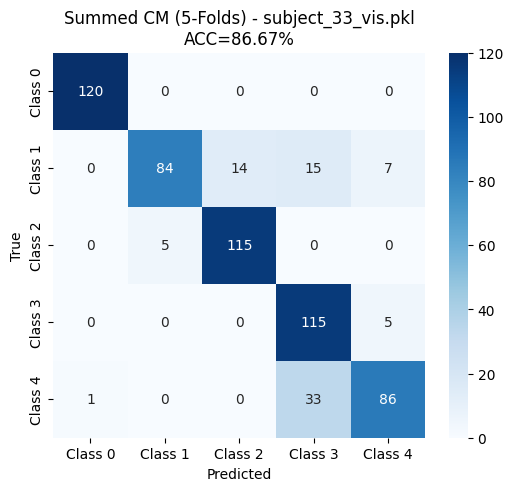


=== subject_34_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_34_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_34_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_34_vis.pkl_fold1] epoch=1/8 => val_loss=0.4346, val_acc=86.17%
[subject_34_vis.pkl_fold1] epoch=2/8 => val_loss=0.3377, val_acc=88.64%
[subject_34_vis.pkl_fold1] epoch=3/8 => val_loss=0.4157, val_acc=85.94%
[subject_34_vis.pkl_fold1] epoch=4/8 => val_loss=0.2363, val_acc=92.68%
[subject_34_vis.pkl_fold1] epoch=5/8 => val_loss=0.2908, val_acc=90.48%
[subject_34_vis.pkl_fold1] epoch=6/8 => val_loss=0.2826, val_acc=90.41%
[subject_34_vis.pkl_fold1] epoch=7/8 => val_loss=0.1847, val_acc=94.53%
[subject_34_vis.pkl_fold1] epoch=8/8 => val_loss=0.5114, val_acc=85.06%
[subject_34_vis.pkl_fold1] => best_val_loss=0.1847
[subject_34_vis.pkl] Fold 1 => Test ACC=70.83%, F1=0.6887

=== [File: subject_34_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_34_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_34_vis.pkl_fold2] epoch=1/8 => val_loss=0.5632, val_acc=80.85%
[subject_34_vis.pkl_fold2] epoch=2/8 => val_loss=0.3266, val_acc=88.85%
[subject_34_vis.pkl_fold2] epoch=3/8 => val_loss=0.3435, val_acc=88.12%
[subject_34_vis.pkl_fold2] epoch=4/8 => val_loss=0.3045, val_acc=90.93%
[subject_34_vis.pkl_fold2] epoch=5/8 => val_loss=0.2754, val_acc=91.41%
[subject_34_vis.pkl_fold2] epoch=6/8 => val_loss=0.3751, val_acc=88.80%
[subject_34_vis.pkl_fold2] epoch=7/8 => val_loss=0.3607, val_acc=90.18%
[subject_34_vis.pkl_fold2] epoch=8/8 => val_loss=0.4390, val_acc=87.64%
[subject_34_vis.pkl_fold2] Early stopping at epoch=8
[subject_34_vis.pkl_fold2] => best_val_loss=0.2754
[subject_34_vis.pkl] Fold 2 => Test ACC=70.00%, F1=0.6763

=== [File: subject_34_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_34_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_34_vis.pkl_fold3] epoch=1/8 => val_loss=0.4253, val_acc=86.27%
[subject_34_vis.pkl_fold3] epoch=2/8 => val_loss=0.1923, val_acc=94.79%
[subject_34_vis.pkl_fold3] epoch=3/8 => val_loss=0.3026, val_acc=91.31%
[subject_34_vis.pkl_fold3] epoch=4/8 => val_loss=0.1606, val_acc=95.74%
[subject_34_vis.pkl_fold3] epoch=5/8 => val_loss=0.1173, val_acc=96.80%
[subject_34_vis.pkl_fold3] epoch=6/8 => val_loss=0.1676, val_acc=94.96%
[subject_34_vis.pkl_fold3] epoch=7/8 => val_loss=0.1593, val_acc=94.74%
[subject_34_vis.pkl_fold3] epoch=8/8 => val_loss=0.1396, val_acc=96.09%
[subject_34_vis.pkl_fold3] Early stopping at epoch=8
[subject_34_vis.pkl_fold3] => best_val_loss=0.1173
[subject_34_vis.pkl] Fold 3 => Test ACC=65.00%, F1=0.6356

=== [File: subject_34_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_34_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_34_vis.pkl_fold4] epoch=1/8 => val_loss=0.5849, val_acc=79.02%
[subject_34_vis.pkl_fold4] epoch=2/8 => val_loss=0.2375, val_acc=93.11%
[subject_34_vis.pkl_fold4] epoch=3/8 => val_loss=0.4138, val_acc=86.65%
[subject_34_vis.pkl_fold4] epoch=4/8 => val_loss=0.2577, val_acc=91.97%
[subject_34_vis.pkl_fold4] epoch=5/8 => val_loss=0.3231, val_acc=89.89%
[subject_34_vis.pkl_fold4] Early stopping at epoch=5
[subject_34_vis.pkl_fold4] => best_val_loss=0.2375
[subject_34_vis.pkl] Fold 4 => Test ACC=66.67%, F1=0.6484

=== [File: subject_34_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_34_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_34_vis.pkl_fold5] epoch=1/8 => val_loss=0.5671, val_acc=79.76%
[subject_34_vis.pkl_fold5] epoch=2/8 => val_loss=0.4049, val_acc=86.17%
[subject_34_vis.pkl_fold5] epoch=3/8 => val_loss=0.3275, val_acc=89.54%
[subject_34_vis.pkl_fold5] epoch=4/8 => val_loss=0.2678, val_acc=90.77%
[subject_34_vis.pkl_fold5] epoch=5/8 => val_loss=0.4288, val_acc=86.58%
[subject_34_vis.pkl_fold5] epoch=6/8 => val_loss=0.2354, val_acc=92.40%
[subject_34_vis.pkl_fold5] epoch=7/8 => val_loss=0.5126, val_acc=85.98%
[subject_34_vis.pkl_fold5] epoch=8/8 => val_loss=0.4602, val_acc=86.86%
[subject_34_vis.pkl_fold5] => best_val_loss=0.2354
[subject_34_vis.pkl] Fold 5 => Test ACC=66.67%, F1=0.6367

=== [File: subject_34_vis.pkl] 5-Fold Mean Test ACC=67.83%, F1=0.6571


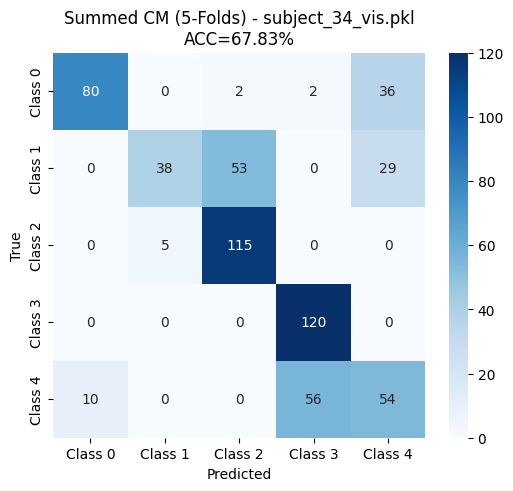


=== subject_35_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_35_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_35_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_35_vis.pkl_fold1] epoch=1/8 => val_loss=0.6968, val_acc=77.32%
[subject_35_vis.pkl_fold1] epoch=2/8 => val_loss=0.4931, val_acc=85.44%
[subject_35_vis.pkl_fold1] epoch=3/8 => val_loss=0.3380, val_acc=88.87%
[subject_35_vis.pkl_fold1] epoch=4/8 => val_loss=0.4200, val_acc=86.60%
[subject_35_vis.pkl_fold1] epoch=5/8 => val_loss=0.4359, val_acc=86.60%
[subject_35_vis.pkl_fold1] epoch=6/8 => val_loss=0.3950, val_acc=87.14%
[subject_35_vis.pkl_fold1] Early stopping at epoch=6
[subject_35_vis.pkl_fold1] => best_val_loss=0.3380
[subject_35_vis.pkl] Fold 1 => Test ACC=69.17%, F1=0.6847

=== [File: subject_35_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_35_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_35_vis.pkl_fold2] epoch=1/8 => val_loss=0.7288, val_acc=76.21%
[subject_35_vis.pkl_fold2] epoch=2/8 => val_loss=0.4354, val_acc=84.97%
[subject_35_vis.pkl_fold2] epoch=3/8 => val_loss=0.4775, val_acc=84.00%
[subject_35_vis.pkl_fold2] epoch=4/8 => val_loss=0.3084, val_acc=90.96%
[subject_35_vis.pkl_fold2] epoch=5/8 => val_loss=0.4259, val_acc=86.32%
[subject_35_vis.pkl_fold2] epoch=6/8 => val_loss=0.4454, val_acc=85.46%
[subject_35_vis.pkl_fold2] epoch=7/8 => val_loss=0.3962, val_acc=88.85%
[subject_35_vis.pkl_fold2] Early stopping at epoch=7
[subject_35_vis.pkl_fold2] => best_val_loss=0.3084
[subject_35_vis.pkl] Fold 2 => Test ACC=47.50%, F1=0.4356

=== [File: subject_35_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_35_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_35_vis.pkl_fold3] epoch=1/8 => val_loss=0.7934, val_acc=71.09%
[subject_35_vis.pkl_fold3] epoch=2/8 => val_loss=0.5111, val_acc=82.27%
[subject_35_vis.pkl_fold3] epoch=3/8 => val_loss=0.5597, val_acc=81.96%
[subject_35_vis.pkl_fold3] epoch=4/8 => val_loss=0.4044, val_acc=86.53%
[subject_35_vis.pkl_fold3] epoch=5/8 => val_loss=0.4998, val_acc=85.18%
[subject_35_vis.pkl_fold3] epoch=6/8 => val_loss=0.5413, val_acc=85.20%
[subject_35_vis.pkl_fold3] epoch=7/8 => val_loss=0.5197, val_acc=85.30%
[subject_35_vis.pkl_fold3] Early stopping at epoch=7
[subject_35_vis.pkl_fold3] => best_val_loss=0.4044
[subject_35_vis.pkl] Fold 3 => Test ACC=64.17%, F1=0.6314

=== [File: subject_35_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_35_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_35_vis.pkl_fold4] epoch=1/8 => val_loss=0.6686, val_acc=78.20%
[subject_35_vis.pkl_fold4] epoch=2/8 => val_loss=0.4660, val_acc=84.73%
[subject_35_vis.pkl_fold4] epoch=3/8 => val_loss=0.4740, val_acc=85.25%
[subject_35_vis.pkl_fold4] epoch=4/8 => val_loss=0.4730, val_acc=85.16%
[subject_35_vis.pkl_fold4] epoch=5/8 => val_loss=0.5234, val_acc=83.19%
[subject_35_vis.pkl_fold4] Early stopping at epoch=5
[subject_35_vis.pkl_fold4] => best_val_loss=0.4660
[subject_35_vis.pkl] Fold 4 => Test ACC=55.83%, F1=0.5360

=== [File: subject_35_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_35_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_35_vis.pkl_fold5] epoch=1/8 => val_loss=0.8616, val_acc=67.23%
[subject_35_vis.pkl_fold5] epoch=2/8 => val_loss=0.5909, val_acc=79.24%
[subject_35_vis.pkl_fold5] epoch=3/8 => val_loss=0.6372, val_acc=78.22%
[subject_35_vis.pkl_fold5] epoch=4/8 => val_loss=0.5619, val_acc=81.16%
[subject_35_vis.pkl_fold5] epoch=5/8 => val_loss=0.4274, val_acc=86.17%
[subject_35_vis.pkl_fold5] epoch=6/8 => val_loss=0.4455, val_acc=86.74%
[subject_35_vis.pkl_fold5] epoch=7/8 => val_loss=0.5032, val_acc=84.97%
[subject_35_vis.pkl_fold5] epoch=8/8 => val_loss=0.3992, val_acc=88.94%
[subject_35_vis.pkl_fold5] => best_val_loss=0.3992
[subject_35_vis.pkl] Fold 5 => Test ACC=59.17%, F1=0.5631

=== [File: subject_35_vis.pkl] 5-Fold Mean Test ACC=59.17%, F1=0.5702


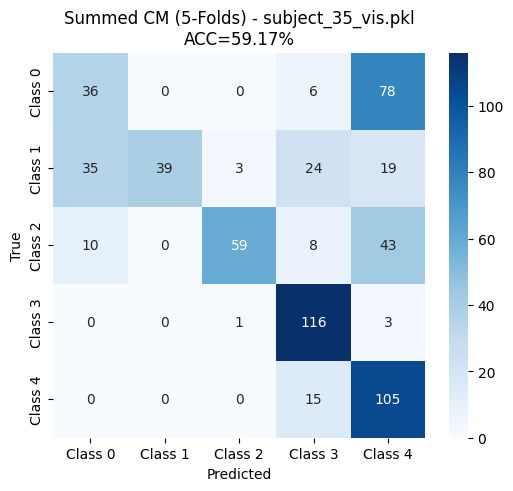


=== subject_36_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_36_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_36_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_36_vis.pkl_fold1] epoch=1/8 => val_loss=0.5447, val_acc=81.01%
[subject_36_vis.pkl_fold1] epoch=2/8 => val_loss=0.4529, val_acc=84.71%
[subject_36_vis.pkl_fold1] epoch=3/8 => val_loss=0.3461, val_acc=89.23%
[subject_36_vis.pkl_fold1] epoch=4/8 => val_loss=0.3993, val_acc=88.02%
[subject_36_vis.pkl_fold1] epoch=5/8 => val_loss=0.3747, val_acc=88.64%
[subject_36_vis.pkl_fold1] epoch=6/8 => val_loss=0.3412, val_acc=90.03%
[subject_36_vis.pkl_fold1] epoch=7/8 => val_loss=0.3581, val_acc=90.67%
[subject_36_vis.pkl_fold1] epoch=8/8 => val_loss=0.2967, val_acc=91.26%
[subject_36_vis.pkl_fold1] => best_val_loss=0.2967
[subject_36_vis.pkl] Fold 1 => Test ACC=61.67%, F1=0.6142

=== [File: subject_36_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_36_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_36_vis.pkl_fold2] epoch=1/8 => val_loss=0.3853, val_acc=87.55%
[subject_36_vis.pkl_fold2] epoch=2/8 => val_loss=0.2565, val_acc=91.38%
[subject_36_vis.pkl_fold2] epoch=3/8 => val_loss=0.2521, val_acc=92.16%
[subject_36_vis.pkl_fold2] epoch=4/8 => val_loss=0.3375, val_acc=89.84%
[subject_36_vis.pkl_fold2] epoch=5/8 => val_loss=0.3655, val_acc=89.44%
[subject_36_vis.pkl_fold2] epoch=6/8 => val_loss=0.1563, val_acc=95.43%
[subject_36_vis.pkl_fold2] epoch=7/8 => val_loss=0.2343, val_acc=92.40%
[subject_36_vis.pkl_fold2] epoch=8/8 => val_loss=0.1844, val_acc=93.84%
[subject_36_vis.pkl_fold2] => best_val_loss=0.1563
[subject_36_vis.pkl] Fold 2 => Test ACC=75.83%, F1=0.7495

=== [File: subject_36_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_36_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_36_vis.pkl_fold3] epoch=1/8 => val_loss=0.4902, val_acc=84.00%
[subject_36_vis.pkl_fold3] epoch=2/8 => val_loss=0.3692, val_acc=89.06%
[subject_36_vis.pkl_fold3] epoch=3/8 => val_loss=0.3369, val_acc=88.92%
[subject_36_vis.pkl_fold3] epoch=4/8 => val_loss=0.4111, val_acc=89.23%
[subject_36_vis.pkl_fold3] epoch=5/8 => val_loss=0.3681, val_acc=89.51%
[subject_36_vis.pkl_fold3] epoch=6/8 => val_loss=0.2955, val_acc=92.00%
[subject_36_vis.pkl_fold3] epoch=7/8 => val_loss=0.6922, val_acc=81.79%
[subject_36_vis.pkl_fold3] epoch=8/8 => val_loss=0.5130, val_acc=86.96%
[subject_36_vis.pkl_fold3] => best_val_loss=0.2955
[subject_36_vis.pkl] Fold 3 => Test ACC=70.83%, F1=0.7086

=== [File: subject_36_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_36_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_36_vis.pkl_fold4] epoch=1/8 => val_loss=0.3546, val_acc=90.27%
[subject_36_vis.pkl_fold4] epoch=2/8 => val_loss=0.3308, val_acc=89.06%
[subject_36_vis.pkl_fold4] epoch=3/8 => val_loss=0.2397, val_acc=91.81%
[subject_36_vis.pkl_fold4] epoch=4/8 => val_loss=0.2199, val_acc=92.83%
[subject_36_vis.pkl_fold4] epoch=5/8 => val_loss=0.2420, val_acc=91.97%
[subject_36_vis.pkl_fold4] epoch=6/8 => val_loss=0.3243, val_acc=90.20%
[subject_36_vis.pkl_fold4] epoch=7/8 => val_loss=0.5379, val_acc=86.51%
[subject_36_vis.pkl_fold4] Early stopping at epoch=7
[subject_36_vis.pkl_fold4] => best_val_loss=0.2199
[subject_36_vis.pkl] Fold 4 => Test ACC=76.67%, F1=0.7676

=== [File: subject_36_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_36_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_36_vis.pkl_fold5] epoch=1/8 => val_loss=0.4394, val_acc=86.86%
[subject_36_vis.pkl_fold5] epoch=2/8 => val_loss=0.3588, val_acc=89.42%
[subject_36_vis.pkl_fold5] epoch=3/8 => val_loss=0.4534, val_acc=85.82%
[subject_36_vis.pkl_fold5] epoch=4/8 => val_loss=0.3012, val_acc=90.96%
[subject_36_vis.pkl_fold5] epoch=5/8 => val_loss=0.3474, val_acc=90.20%
[subject_36_vis.pkl_fold5] epoch=6/8 => val_loss=0.3462, val_acc=89.91%
[subject_36_vis.pkl_fold5] epoch=7/8 => val_loss=0.2789, val_acc=92.07%
[subject_36_vis.pkl_fold5] epoch=8/8 => val_loss=0.3731, val_acc=89.87%
[subject_36_vis.pkl_fold5] => best_val_loss=0.2789
[subject_36_vis.pkl] Fold 5 => Test ACC=69.17%, F1=0.6881

=== [File: subject_36_vis.pkl] 5-Fold Mean Test ACC=70.83%, F1=0.7056


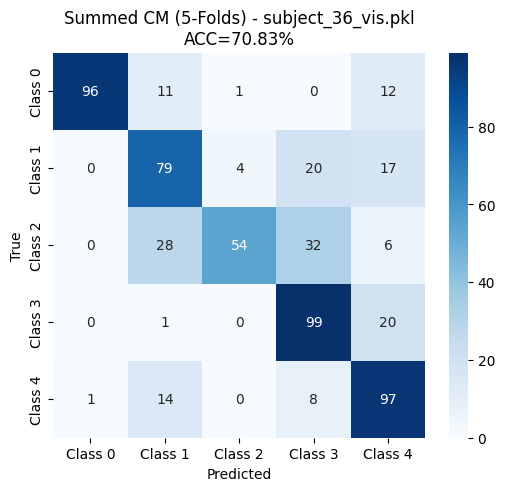


=== subject_37_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_37_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_37_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_37_vis.pkl_fold1] epoch=1/8 => val_loss=0.5447, val_acc=81.34%
[subject_37_vis.pkl_fold1] epoch=2/8 => val_loss=0.3763, val_acc=87.12%
[subject_37_vis.pkl_fold1] epoch=3/8 => val_loss=0.4647, val_acc=86.06%
[subject_37_vis.pkl_fold1] epoch=4/8 => val_loss=0.3396, val_acc=89.42%
[subject_37_vis.pkl_fold1] epoch=5/8 => val_loss=0.4105, val_acc=87.14%
[subject_37_vis.pkl_fold1] epoch=6/8 => val_loss=0.3953, val_acc=87.78%
[subject_37_vis.pkl_fold1] epoch=7/8 => val_loss=0.3058, val_acc=89.77%
[subject_37_vis.pkl_fold1] epoch=8/8 => val_loss=0.3653, val_acc=89.87%
[subject_37_vis.pkl_fold1] => best_val_loss=0.3058
[subject_37_vis.pkl] Fold 1 => Test ACC=77.50%, F1=0.7635

=== [File: subject_37_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_37_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_37_vis.pkl_fold2] epoch=1/8 => val_loss=0.6558, val_acc=76.42%
[subject_37_vis.pkl_fold2] epoch=2/8 => val_loss=0.5694, val_acc=81.11%
[subject_37_vis.pkl_fold2] epoch=3/8 => val_loss=0.4373, val_acc=84.23%
[subject_37_vis.pkl_fold2] epoch=4/8 => val_loss=0.3927, val_acc=86.72%
[subject_37_vis.pkl_fold2] epoch=5/8 => val_loss=0.3060, val_acc=90.41%
[subject_37_vis.pkl_fold2] epoch=6/8 => val_loss=0.4723, val_acc=86.58%
[subject_37_vis.pkl_fold2] epoch=7/8 => val_loss=0.2956, val_acc=90.91%
[subject_37_vis.pkl_fold2] epoch=8/8 => val_loss=0.3561, val_acc=89.84%
[subject_37_vis.pkl_fold2] => best_val_loss=0.2956
[subject_37_vis.pkl] Fold 2 => Test ACC=65.00%, F1=0.6117

=== [File: subject_37_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_37_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_37_vis.pkl_fold3] epoch=1/8 => val_loss=0.6222, val_acc=79.05%
[subject_37_vis.pkl_fold3] epoch=2/8 => val_loss=0.3282, val_acc=90.10%
[subject_37_vis.pkl_fold3] epoch=3/8 => val_loss=0.3126, val_acc=89.70%
[subject_37_vis.pkl_fold3] epoch=4/8 => val_loss=0.4181, val_acc=85.63%
[subject_37_vis.pkl_fold3] epoch=5/8 => val_loss=0.3657, val_acc=90.44%
[subject_37_vis.pkl_fold3] epoch=6/8 => val_loss=0.3056, val_acc=90.96%
[subject_37_vis.pkl_fold3] epoch=7/8 => val_loss=0.4594, val_acc=85.20%
[subject_37_vis.pkl_fold3] epoch=8/8 => val_loss=0.2634, val_acc=92.07%
[subject_37_vis.pkl_fold3] => best_val_loss=0.2634
[subject_37_vis.pkl] Fold 3 => Test ACC=70.83%, F1=0.6825

=== [File: subject_37_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_37_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_37_vis.pkl_fold4] epoch=1/8 => val_loss=0.6162, val_acc=77.75%
[subject_37_vis.pkl_fold4] epoch=2/8 => val_loss=0.3420, val_acc=88.52%
[subject_37_vis.pkl_fold4] epoch=3/8 => val_loss=0.3137, val_acc=89.06%
[subject_37_vis.pkl_fold4] epoch=4/8 => val_loss=0.2807, val_acc=90.72%
[subject_37_vis.pkl_fold4] epoch=5/8 => val_loss=0.3136, val_acc=89.84%
[subject_37_vis.pkl_fold4] epoch=6/8 => val_loss=0.2831, val_acc=90.01%
[subject_37_vis.pkl_fold4] epoch=7/8 => val_loss=0.3979, val_acc=87.71%
[subject_37_vis.pkl_fold4] Early stopping at epoch=7
[subject_37_vis.pkl_fold4] => best_val_loss=0.2807
[subject_37_vis.pkl] Fold 4 => Test ACC=66.67%, F1=0.6338

=== [File: subject_37_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_37_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_37_vis.pkl_fold5] epoch=1/8 => val_loss=0.7218, val_acc=74.86%
[subject_37_vis.pkl_fold5] epoch=2/8 => val_loss=0.3867, val_acc=86.15%
[subject_37_vis.pkl_fold5] epoch=3/8 => val_loss=0.3346, val_acc=88.99%
[subject_37_vis.pkl_fold5] epoch=4/8 => val_loss=0.3032, val_acc=91.12%
[subject_37_vis.pkl_fold5] epoch=5/8 => val_loss=0.3280, val_acc=90.13%
[subject_37_vis.pkl_fold5] epoch=6/8 => val_loss=0.3500, val_acc=90.27%
[subject_37_vis.pkl_fold5] epoch=7/8 => val_loss=0.3792, val_acc=89.06%
[subject_37_vis.pkl_fold5] Early stopping at epoch=7
[subject_37_vis.pkl_fold5] => best_val_loss=0.3032
[subject_37_vis.pkl] Fold 5 => Test ACC=68.33%, F1=0.6497

=== [File: subject_37_vis.pkl] 5-Fold Mean Test ACC=69.67%, F1=0.6682


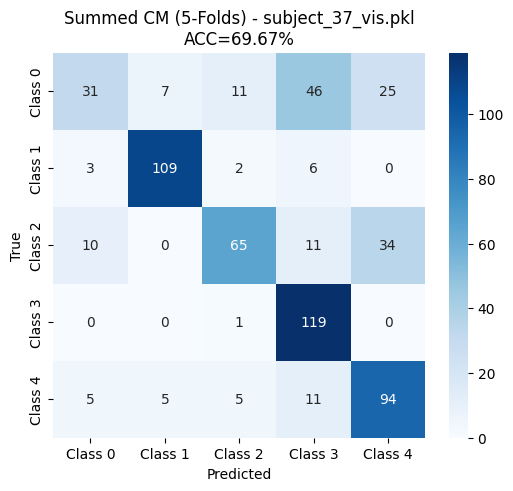


=== subject_38_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_38_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_38_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_38_vis.pkl_fold1] epoch=1/8 => val_loss=0.2129, val_acc=94.46%
[subject_38_vis.pkl_fold1] epoch=2/8 => val_loss=0.2374, val_acc=92.23%
[subject_38_vis.pkl_fold1] epoch=3/8 => val_loss=0.1695, val_acc=95.36%
[subject_38_vis.pkl_fold1] epoch=4/8 => val_loss=0.1839, val_acc=94.25%
[subject_38_vis.pkl_fold1] epoch=5/8 => val_loss=0.2637, val_acc=91.93%
[subject_38_vis.pkl_fold1] epoch=6/8 => val_loss=0.3374, val_acc=89.99%
[subject_38_vis.pkl_fold1] Early stopping at epoch=6
[subject_38_vis.pkl_fold1] => best_val_loss=0.1695
[subject_38_vis.pkl] Fold 1 => Test ACC=83.33%, F1=0.8319

=== [File: subject_38_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_38_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_38_vis.pkl_fold2] epoch=1/8 => val_loss=0.3206, val_acc=90.55%
[subject_38_vis.pkl_fold2] epoch=2/8 => val_loss=0.1538, val_acc=94.51%
[subject_38_vis.pkl_fold2] epoch=3/8 => val_loss=0.1718, val_acc=94.96%
[subject_38_vis.pkl_fold2] epoch=4/8 => val_loss=0.1703, val_acc=94.96%
[subject_38_vis.pkl_fold2] epoch=5/8 => val_loss=0.1816, val_acc=94.74%
[subject_38_vis.pkl_fold2] Early stopping at epoch=5
[subject_38_vis.pkl_fold2] => best_val_loss=0.1538
[subject_38_vis.pkl] Fold 2 => Test ACC=82.50%, F1=0.8095

=== [File: subject_38_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_38_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_38_vis.pkl_fold3] epoch=1/8 => val_loss=0.3000, val_acc=91.83%
[subject_38_vis.pkl_fold3] epoch=2/8 => val_loss=0.1111, val_acc=97.37%
[subject_38_vis.pkl_fold3] epoch=3/8 => val_loss=0.0867, val_acc=97.51%
[subject_38_vis.pkl_fold3] epoch=4/8 => val_loss=0.1133, val_acc=96.64%
[subject_38_vis.pkl_fold3] epoch=5/8 => val_loss=0.0551, val_acc=98.65%
[subject_38_vis.pkl_fold3] epoch=6/8 => val_loss=0.0646, val_acc=98.56%
[subject_38_vis.pkl_fold3] epoch=7/8 => val_loss=0.0809, val_acc=97.37%
[subject_38_vis.pkl_fold3] epoch=8/8 => val_loss=0.0693, val_acc=97.66%
[subject_38_vis.pkl_fold3] Early stopping at epoch=8
[subject_38_vis.pkl_fold3] => best_val_loss=0.0551
[subject_38_vis.pkl] Fold 3 => Test ACC=85.00%, F1=0.8495

=== [File: subject_38_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_38_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_38_vis.pkl_fold4] epoch=1/8 => val_loss=0.3050, val_acc=90.96%
[subject_38_vis.pkl_fold4] epoch=2/8 => val_loss=0.2834, val_acc=90.81%
[subject_38_vis.pkl_fold4] epoch=3/8 => val_loss=0.3361, val_acc=88.49%
[subject_38_vis.pkl_fold4] epoch=4/8 => val_loss=0.1836, val_acc=94.74%
[subject_38_vis.pkl_fold4] epoch=5/8 => val_loss=0.4857, val_acc=86.58%
[subject_38_vis.pkl_fold4] epoch=6/8 => val_loss=0.1605, val_acc=95.38%
[subject_38_vis.pkl_fold4] epoch=7/8 => val_loss=0.1621, val_acc=94.67%
[subject_38_vis.pkl_fold4] epoch=8/8 => val_loss=0.2156, val_acc=93.68%
[subject_38_vis.pkl_fold4] => best_val_loss=0.1605
[subject_38_vis.pkl] Fold 4 => Test ACC=77.50%, F1=0.7690

=== [File: subject_38_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_38_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_38_vis.pkl_fold5] epoch=1/8 => val_loss=0.1987, val_acc=95.10%
[subject_38_vis.pkl_fold5] epoch=2/8 => val_loss=0.1814, val_acc=94.79%
[subject_38_vis.pkl_fold5] epoch=3/8 => val_loss=0.1354, val_acc=96.38%
[subject_38_vis.pkl_fold5] epoch=4/8 => val_loss=0.0619, val_acc=98.58%
[subject_38_vis.pkl_fold5] epoch=5/8 => val_loss=0.0673, val_acc=97.80%
[subject_38_vis.pkl_fold5] epoch=6/8 => val_loss=0.4605, val_acc=84.30%
[subject_38_vis.pkl_fold5] epoch=7/8 => val_loss=0.0707, val_acc=97.66%
[subject_38_vis.pkl_fold5] Early stopping at epoch=7
[subject_38_vis.pkl_fold5] => best_val_loss=0.0619
[subject_38_vis.pkl] Fold 5 => Test ACC=75.83%, F1=0.7483

=== [File: subject_38_vis.pkl] 5-Fold Mean Test ACC=80.83%, F1=0.8016


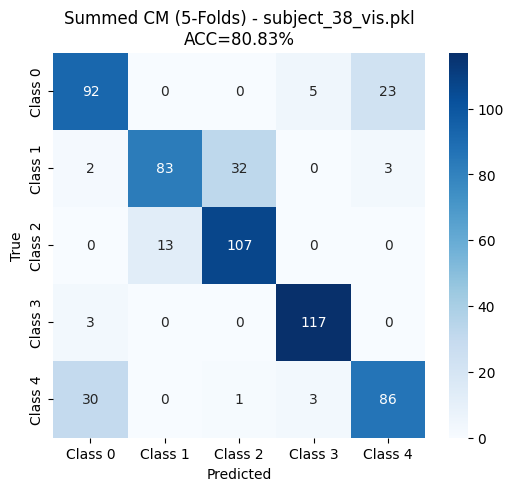


=== subject_39_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_39_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_39_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_39_vis.pkl_fold1] epoch=1/8 => val_loss=0.4605, val_acc=85.09%
[subject_39_vis.pkl_fold1] epoch=2/8 => val_loss=0.4509, val_acc=86.08%
[subject_39_vis.pkl_fold1] epoch=3/8 => val_loss=0.3597, val_acc=89.06%
[subject_39_vis.pkl_fold1] epoch=4/8 => val_loss=0.3533, val_acc=89.99%
[subject_39_vis.pkl_fold1] epoch=5/8 => val_loss=0.4020, val_acc=88.80%
[subject_39_vis.pkl_fold1] epoch=6/8 => val_loss=0.4397, val_acc=88.92%
[subject_39_vis.pkl_fold1] epoch=7/8 => val_loss=0.5761, val_acc=86.41%
[subject_39_vis.pkl_fold1] Early stopping at epoch=7
[subject_39_vis.pkl_fold1] => best_val_loss=0.3533
[subject_39_vis.pkl] Fold 1 => Test ACC=58.33%, F1=0.5736

=== [File: subject_39_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_39_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_39_vis.pkl_fold2] epoch=1/8 => val_loss=0.4363, val_acc=87.33%
[subject_39_vis.pkl_fold2] epoch=2/8 => val_loss=0.2948, val_acc=91.88%
[subject_39_vis.pkl_fold2] epoch=3/8 => val_loss=0.5031, val_acc=86.08%
[subject_39_vis.pkl_fold2] epoch=4/8 => val_loss=0.2806, val_acc=92.45%
[subject_39_vis.pkl_fold2] epoch=5/8 => val_loss=0.2981, val_acc=92.87%
[subject_39_vis.pkl_fold2] epoch=6/8 => val_loss=0.2632, val_acc=93.30%
[subject_39_vis.pkl_fold2] epoch=7/8 => val_loss=0.2720, val_acc=93.09%
[subject_39_vis.pkl_fold2] epoch=8/8 => val_loss=0.3508, val_acc=92.02%
[subject_39_vis.pkl_fold2] => best_val_loss=0.2632
[subject_39_vis.pkl] Fold 2 => Test ACC=52.50%, F1=0.5281

=== [File: subject_39_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_39_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_39_vis.pkl_fold3] epoch=1/8 => val_loss=0.3551, val_acc=88.97%
[subject_39_vis.pkl_fold3] epoch=2/8 => val_loss=0.3077, val_acc=90.18%
[subject_39_vis.pkl_fold3] epoch=3/8 => val_loss=0.3695, val_acc=88.64%
[subject_39_vis.pkl_fold3] epoch=4/8 => val_loss=0.2923, val_acc=90.91%
[subject_39_vis.pkl_fold3] epoch=5/8 => val_loss=0.2925, val_acc=91.88%
[subject_39_vis.pkl_fold3] epoch=6/8 => val_loss=0.2699, val_acc=91.62%
[subject_39_vis.pkl_fold3] epoch=7/8 => val_loss=0.3084, val_acc=91.22%
[subject_39_vis.pkl_fold3] epoch=8/8 => val_loss=0.3139, val_acc=92.50%
[subject_39_vis.pkl_fold3] => best_val_loss=0.2699
[subject_39_vis.pkl] Fold 3 => Test ACC=69.17%, F1=0.7009

=== [File: subject_39_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_39_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_39_vis.pkl_fold4] epoch=1/8 => val_loss=0.3347, val_acc=90.86%
[subject_39_vis.pkl_fold4] epoch=2/8 => val_loss=0.2300, val_acc=92.12%
[subject_39_vis.pkl_fold4] epoch=3/8 => val_loss=0.2840, val_acc=91.19%
[subject_39_vis.pkl_fold4] epoch=4/8 => val_loss=0.2472, val_acc=91.88%
[subject_39_vis.pkl_fold4] epoch=5/8 => val_loss=0.3516, val_acc=88.59%
[subject_39_vis.pkl_fold4] Early stopping at epoch=5
[subject_39_vis.pkl_fold4] => best_val_loss=0.2300
[subject_39_vis.pkl] Fold 4 => Test ACC=73.33%, F1=0.7344

=== [File: subject_39_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_39_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_39_vis.pkl_fold5] epoch=1/8 => val_loss=0.4625, val_acc=84.73%
[subject_39_vis.pkl_fold5] epoch=2/8 => val_loss=0.3464, val_acc=89.77%
[subject_39_vis.pkl_fold5] epoch=3/8 => val_loss=0.3130, val_acc=89.70%
[subject_39_vis.pkl_fold5] epoch=4/8 => val_loss=0.4348, val_acc=86.93%
[subject_39_vis.pkl_fold5] epoch=5/8 => val_loss=0.2245, val_acc=93.96%
[subject_39_vis.pkl_fold5] epoch=6/8 => val_loss=0.4353, val_acc=88.21%
[subject_39_vis.pkl_fold5] epoch=7/8 => val_loss=0.1973, val_acc=94.22%
[subject_39_vis.pkl_fold5] epoch=8/8 => val_loss=0.2956, val_acc=92.47%
[subject_39_vis.pkl_fold5] => best_val_loss=0.1973
[subject_39_vis.pkl] Fold 5 => Test ACC=68.33%, F1=0.6737

=== [File: subject_39_vis.pkl] 5-Fold Mean Test ACC=64.33%, F1=0.6421


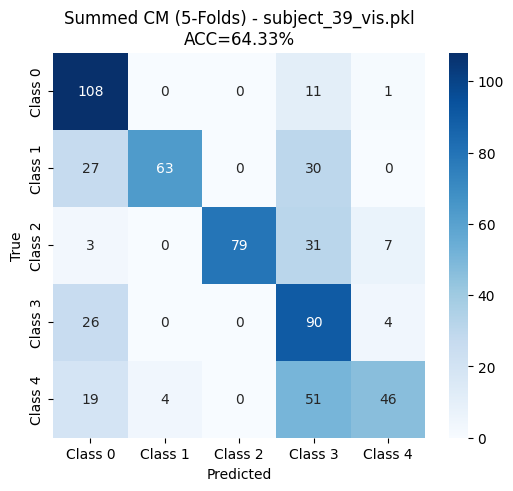


=== subject_40_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_40_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_40_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_40_vis.pkl_fold1] epoch=1/8 => val_loss=0.5596, val_acc=79.38%
[subject_40_vis.pkl_fold1] epoch=2/8 => val_loss=0.3548, val_acc=87.69%
[subject_40_vis.pkl_fold1] epoch=3/8 => val_loss=0.3876, val_acc=87.00%
[subject_40_vis.pkl_fold1] epoch=4/8 => val_loss=0.6067, val_acc=82.20%
[subject_40_vis.pkl_fold1] epoch=5/8 => val_loss=0.5548, val_acc=82.05%
[subject_40_vis.pkl_fold1] Early stopping at epoch=5
[subject_40_vis.pkl_fold1] => best_val_loss=0.3548
[subject_40_vis.pkl] Fold 1 => Test ACC=64.17%, F1=0.6448

=== [File: subject_40_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_40_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_40_vis.pkl_fold2] epoch=1/8 => val_loss=0.5602, val_acc=80.94%
[subject_40_vis.pkl_fold2] epoch=2/8 => val_loss=0.7391, val_acc=73.98%
[subject_40_vis.pkl_fold2] epoch=3/8 => val_loss=0.5317, val_acc=83.40%
[subject_40_vis.pkl_fold2] epoch=4/8 => val_loss=0.4540, val_acc=86.77%
[subject_40_vis.pkl_fold2] epoch=5/8 => val_loss=0.4963, val_acc=86.93%
[subject_40_vis.pkl_fold2] epoch=6/8 => val_loss=0.7506, val_acc=81.13%
[subject_40_vis.pkl_fold2] epoch=7/8 => val_loss=0.7447, val_acc=79.55%
[subject_40_vis.pkl_fold2] Early stopping at epoch=7
[subject_40_vis.pkl_fold2] => best_val_loss=0.4540
[subject_40_vis.pkl] Fold 2 => Test ACC=60.00%, F1=0.5536

=== [File: subject_40_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_40_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_40_vis.pkl_fold3] epoch=1/8 => val_loss=0.6213, val_acc=77.20%
[subject_40_vis.pkl_fold3] epoch=2/8 => val_loss=0.6132, val_acc=78.41%
[subject_40_vis.pkl_fold3] epoch=3/8 => val_loss=0.4616, val_acc=84.92%
[subject_40_vis.pkl_fold3] epoch=4/8 => val_loss=0.4308, val_acc=85.30%
[subject_40_vis.pkl_fold3] epoch=5/8 => val_loss=0.4977, val_acc=84.80%
[subject_40_vis.pkl_fold3] epoch=6/8 => val_loss=0.6221, val_acc=83.24%
[subject_40_vis.pkl_fold3] epoch=7/8 => val_loss=0.5352, val_acc=85.65%
[subject_40_vis.pkl_fold3] Early stopping at epoch=7
[subject_40_vis.pkl_fold3] => best_val_loss=0.4308
[subject_40_vis.pkl] Fold 3 => Test ACC=49.17%, F1=0.4608

=== [File: subject_40_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_40_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_40_vis.pkl_fold4] epoch=1/8 => val_loss=0.5494, val_acc=81.18%
[subject_40_vis.pkl_fold4] epoch=2/8 => val_loss=0.4789, val_acc=82.95%
[subject_40_vis.pkl_fold4] epoch=3/8 => val_loss=0.5548, val_acc=82.88%
[subject_40_vis.pkl_fold4] epoch=4/8 => val_loss=0.5953, val_acc=83.88%
[subject_40_vis.pkl_fold4] epoch=5/8 => val_loss=0.4578, val_acc=86.01%
[subject_40_vis.pkl_fold4] epoch=6/8 => val_loss=0.5055, val_acc=85.01%
[subject_40_vis.pkl_fold4] epoch=7/8 => val_loss=0.5204, val_acc=86.93%
[subject_40_vis.pkl_fold4] epoch=8/8 => val_loss=0.6494, val_acc=83.88%
[subject_40_vis.pkl_fold4] Early stopping at epoch=8
[subject_40_vis.pkl_fold4] => best_val_loss=0.4578
[subject_40_vis.pkl] Fold 4 => Test ACC=57.50%, F1=0.5171

=== [File: subject_40_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_40_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_40_vis.pkl_fold5] epoch=1/8 => val_loss=0.4989, val_acc=83.78%
[subject_40_vis.pkl_fold5] epoch=2/8 => val_loss=0.5444, val_acc=81.63%
[subject_40_vis.pkl_fold5] epoch=3/8 => val_loss=0.3943, val_acc=87.19%
[subject_40_vis.pkl_fold5] epoch=4/8 => val_loss=0.3399, val_acc=89.42%
[subject_40_vis.pkl_fold5] epoch=5/8 => val_loss=0.4790, val_acc=84.87%
[subject_40_vis.pkl_fold5] epoch=6/8 => val_loss=0.5450, val_acc=83.93%
[subject_40_vis.pkl_fold5] epoch=7/8 => val_loss=0.6353, val_acc=81.16%
[subject_40_vis.pkl_fold5] Early stopping at epoch=7
[subject_40_vis.pkl_fold5] => best_val_loss=0.3399
[subject_40_vis.pkl] Fold 5 => Test ACC=49.17%, F1=0.4343

=== [File: subject_40_vis.pkl] 5-Fold Mean Test ACC=56.00%, F1=0.5221


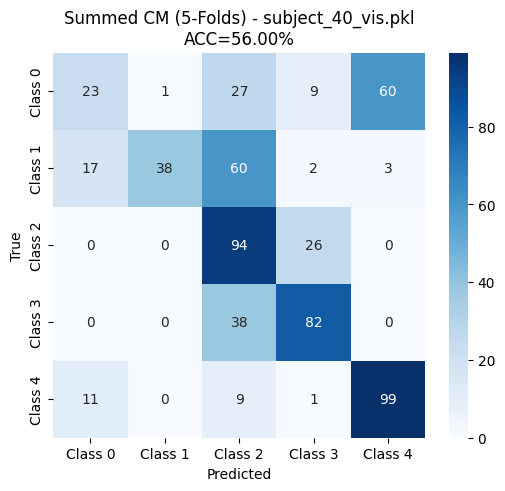


=== subject_41_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_41_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_41_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_41_vis.pkl_fold1] epoch=1/8 => val_loss=0.4190, val_acc=85.89%
[subject_41_vis.pkl_fold1] epoch=2/8 => val_loss=0.3174, val_acc=89.13%
[subject_41_vis.pkl_fold1] epoch=3/8 => val_loss=0.3139, val_acc=89.20%
[subject_41_vis.pkl_fold1] epoch=4/8 => val_loss=0.3663, val_acc=88.45%
[subject_41_vis.pkl_fold1] epoch=5/8 => val_loss=0.2886, val_acc=90.98%
[subject_41_vis.pkl_fold1] epoch=6/8 => val_loss=0.4589, val_acc=86.17%
[subject_41_vis.pkl_fold1] epoch=7/8 => val_loss=0.2801, val_acc=92.26%
[subject_41_vis.pkl_fold1] epoch=8/8 => val_loss=0.3301, val_acc=89.75%
[subject_41_vis.pkl_fold1] => best_val_loss=0.2801
[subject_41_vis.pkl] Fold 1 => Test ACC=68.33%, F1=0.6755

=== [File: subject_41_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_41_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_41_vis.pkl_fold2] epoch=1/8 => val_loss=0.5956, val_acc=80.28%
[subject_41_vis.pkl_fold2] epoch=2/8 => val_loss=0.3879, val_acc=87.31%
[subject_41_vis.pkl_fold2] epoch=3/8 => val_loss=0.3898, val_acc=86.51%
[subject_41_vis.pkl_fold2] epoch=4/8 => val_loss=0.3050, val_acc=89.73%
[subject_41_vis.pkl_fold2] epoch=5/8 => val_loss=0.3084, val_acc=89.87%
[subject_41_vis.pkl_fold2] epoch=6/8 => val_loss=0.4064, val_acc=88.38%
[subject_41_vis.pkl_fold2] epoch=7/8 => val_loss=0.3343, val_acc=90.65%
[subject_41_vis.pkl_fold2] Early stopping at epoch=7
[subject_41_vis.pkl_fold2] => best_val_loss=0.3050
[subject_41_vis.pkl] Fold 2 => Test ACC=72.50%, F1=0.6960

=== [File: subject_41_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_41_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_41_vis.pkl_fold3] epoch=1/8 => val_loss=0.4671, val_acc=83.07%
[subject_41_vis.pkl_fold3] epoch=2/8 => val_loss=0.2773, val_acc=91.48%
[subject_41_vis.pkl_fold3] epoch=3/8 => val_loss=0.3140, val_acc=90.55%
[subject_41_vis.pkl_fold3] epoch=4/8 => val_loss=0.2201, val_acc=92.92%
[subject_41_vis.pkl_fold3] epoch=5/8 => val_loss=0.1933, val_acc=94.18%
[subject_41_vis.pkl_fold3] epoch=6/8 => val_loss=0.2292, val_acc=94.39%
[subject_41_vis.pkl_fold3] epoch=7/8 => val_loss=0.1788, val_acc=95.24%
[subject_41_vis.pkl_fold3] epoch=8/8 => val_loss=0.2481, val_acc=92.87%
[subject_41_vis.pkl_fold3] => best_val_loss=0.1788
[subject_41_vis.pkl] Fold 3 => Test ACC=78.33%, F1=0.7691

=== [File: subject_41_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_41_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_41_vis.pkl_fold4] epoch=1/8 => val_loss=0.4391, val_acc=86.55%
[subject_41_vis.pkl_fold4] epoch=2/8 => val_loss=0.3041, val_acc=90.77%
[subject_41_vis.pkl_fold4] epoch=3/8 => val_loss=0.4213, val_acc=87.00%
[subject_41_vis.pkl_fold4] epoch=4/8 => val_loss=0.3674, val_acc=89.82%
[subject_41_vis.pkl_fold4] epoch=5/8 => val_loss=0.3411, val_acc=89.91%
[subject_41_vis.pkl_fold4] Early stopping at epoch=5
[subject_41_vis.pkl_fold4] => best_val_loss=0.3041
[subject_41_vis.pkl] Fold 4 => Test ACC=79.17%, F1=0.7868

=== [File: subject_41_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_41_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_41_vis.pkl_fold5] epoch=1/8 => val_loss=0.5563, val_acc=81.53%
[subject_41_vis.pkl_fold5] epoch=2/8 => val_loss=0.5422, val_acc=82.29%
[subject_41_vis.pkl_fold5] epoch=3/8 => val_loss=0.4065, val_acc=87.33%
[subject_41_vis.pkl_fold5] epoch=4/8 => val_loss=0.3398, val_acc=91.60%
[subject_41_vis.pkl_fold5] epoch=5/8 => val_loss=0.3653, val_acc=91.03%
[subject_41_vis.pkl_fold5] epoch=6/8 => val_loss=0.4091, val_acc=89.77%
[subject_41_vis.pkl_fold5] epoch=7/8 => val_loss=0.4349, val_acc=89.39%
[subject_41_vis.pkl_fold5] Early stopping at epoch=7
[subject_41_vis.pkl_fold5] => best_val_loss=0.3398
[subject_41_vis.pkl] Fold 5 => Test ACC=60.83%, F1=0.5689

=== [File: subject_41_vis.pkl] 5-Fold Mean Test ACC=71.83%, F1=0.6993


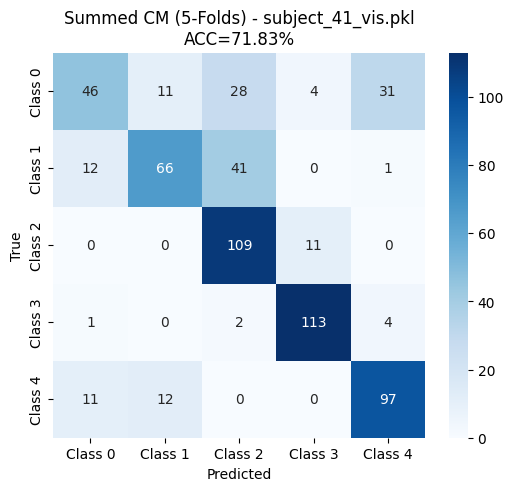


=== subject_42_vis.pkl ===
train_x=(280, 25, 56, 56, 3), train_y=(280,), test_x=(120, 25, 56, 56, 3), test_y=(120,)

=== [File: subject_42_vis.pkl] Fold 1/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_42_vis.pkl_fold1] => Training: epochs=8, patience=3
[subject_42_vis.pkl_fold1] epoch=1/8 => val_loss=0.4700, val_acc=84.16%
[subject_42_vis.pkl_fold1] epoch=2/8 => val_loss=0.3499, val_acc=87.83%
[subject_42_vis.pkl_fold1] epoch=3/8 => val_loss=0.2776, val_acc=90.67%
[subject_42_vis.pkl_fold1] epoch=4/8 => val_loss=0.2466, val_acc=92.14%
[subject_42_vis.pkl_fold1] epoch=5/8 => val_loss=0.2106, val_acc=93.25%
[subject_42_vis.pkl_fold1] epoch=6/8 => val_loss=0.2824, val_acc=90.89%
[subject_42_vis.pkl_fold1] epoch=7/8 => val_loss=0.1765, val_acc=94.29%
[subject_42_vis.pkl_fold1] epoch=8/8 => val_loss=0.2686, val_acc=91.48%
[subject_42_vis.pkl_fold1] => best_val_loss=0.1765
[subject_42_vis.pkl] Fold 1 => Test ACC=71.67%, F1=0.7261

=== [File: subject_42_vis.pkl] Fold 2/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_42_vis.pkl_fold2] => Training: epochs=8, patience=3
[subject_42_vis.pkl_fold2] epoch=1/8 => val_loss=0.2804, val_acc=92.28%
[subject_42_vis.pkl_fold2] epoch=2/8 => val_loss=0.2738, val_acc=90.86%
[subject_42_vis.pkl_fold2] epoch=3/8 => val_loss=0.2307, val_acc=93.11%
[subject_42_vis.pkl_fold2] epoch=4/8 => val_loss=0.2836, val_acc=91.83%
[subject_42_vis.pkl_fold2] epoch=5/8 => val_loss=0.3788, val_acc=88.64%
[subject_42_vis.pkl_fold2] epoch=6/8 => val_loss=0.2220, val_acc=94.11%
[subject_42_vis.pkl_fold2] epoch=7/8 => val_loss=0.3657, val_acc=90.55%
[subject_42_vis.pkl_fold2] epoch=8/8 => val_loss=0.4603, val_acc=87.76%
[subject_42_vis.pkl_fold2] => best_val_loss=0.2220
[subject_42_vis.pkl] Fold 2 => Test ACC=65.00%, F1=0.6177

=== [File: subject_42_vis.pkl] Fold 3/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_42_vis.pkl_fold3] => Training: epochs=8, patience=3
[subject_42_vis.pkl_fold3] epoch=1/8 => val_loss=0.2714, val_acc=93.89%
[subject_42_vis.pkl_fold3] epoch=2/8 => val_loss=0.1924, val_acc=94.46%
[subject_42_vis.pkl_fold3] epoch=3/8 => val_loss=0.2113, val_acc=93.58%
[subject_42_vis.pkl_fold3] epoch=4/8 => val_loss=0.1243, val_acc=96.52%
[subject_42_vis.pkl_fold3] epoch=5/8 => val_loss=0.1258, val_acc=95.29%
[subject_42_vis.pkl_fold3] epoch=6/8 => val_loss=0.1301, val_acc=95.88%
[subject_42_vis.pkl_fold3] epoch=7/8 => val_loss=0.1818, val_acc=94.84%
[subject_42_vis.pkl_fold3] Early stopping at epoch=7
[subject_42_vis.pkl_fold3] => best_val_loss=0.1243
[subject_42_vis.pkl] Fold 3 => Test ACC=78.33%, F1=0.7755

=== [File: subject_42_vis.pkl] Fold 4/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_42_vis.pkl_fold4] => Training: epochs=8, patience=3
[subject_42_vis.pkl_fold4] epoch=1/8 => val_loss=0.2959, val_acc=91.67%
[subject_42_vis.pkl_fold4] epoch=2/8 => val_loss=0.2081, val_acc=94.34%
[subject_42_vis.pkl_fold4] epoch=3/8 => val_loss=0.1923, val_acc=93.68%
[subject_42_vis.pkl_fold4] epoch=4/8 => val_loss=0.1538, val_acc=94.96%
[subject_42_vis.pkl_fold4] epoch=5/8 => val_loss=0.1976, val_acc=94.25%
[subject_42_vis.pkl_fold4] epoch=6/8 => val_loss=0.1184, val_acc=96.80%
[subject_42_vis.pkl_fold4] epoch=7/8 => val_loss=0.1511, val_acc=95.79%
[subject_42_vis.pkl_fold4] epoch=8/8 => val_loss=0.3404, val_acc=92.23%
[subject_42_vis.pkl_fold4] => best_val_loss=0.1184
[subject_42_vis.pkl] Fold 4 => Test ACC=71.67%, F1=0.7169

=== [File: subject_42_vis.pkl] Fold 5/5 ===


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[subject_42_vis.pkl_fold5] => Training: epochs=8, patience=3
[subject_42_vis.pkl_fold5] epoch=1/8 => val_loss=0.6188, val_acc=72.54%
[subject_42_vis.pkl_fold5] epoch=2/8 => val_loss=0.3805, val_acc=87.86%
[subject_42_vis.pkl_fold5] epoch=3/8 => val_loss=0.2628, val_acc=91.55%
[subject_42_vis.pkl_fold5] epoch=4/8 => val_loss=0.2455, val_acc=92.26%
[subject_42_vis.pkl_fold5] epoch=5/8 => val_loss=0.3202, val_acc=90.55%
[subject_42_vis.pkl_fold5] epoch=6/8 => val_loss=0.4500, val_acc=87.64%
[subject_42_vis.pkl_fold5] epoch=7/8 => val_loss=0.1920, val_acc=94.60%
[subject_42_vis.pkl_fold5] epoch=8/8 => val_loss=0.2050, val_acc=93.61%
[subject_42_vis.pkl_fold5] => best_val_loss=0.1920
[subject_42_vis.pkl] Fold 5 => Test ACC=79.17%, F1=0.8014

=== [File: subject_42_vis.pkl] 5-Fold Mean Test ACC=73.17%, F1=0.7275


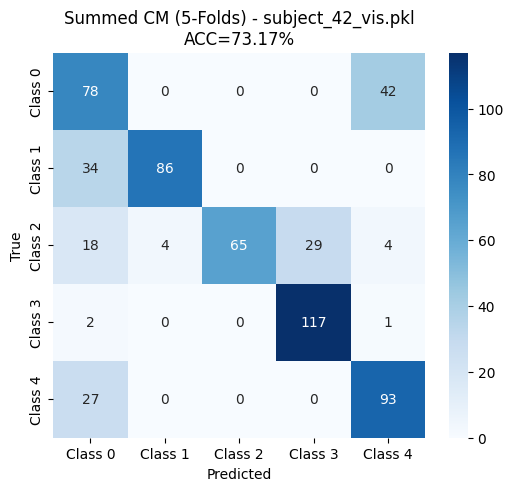


=== Overall across 42 files, total folds=210 ===
Mean ACC = 70.96%
Mean F1  = 0.6944

=== Global Summed Confusion Matrix (All Files & 5-Folds) ===
[[3036   85  178  457 1284]
 [ 524 2875  744  446  451]
 [ 210  489 3698  425  218]
 [  47   18  187 4590  198]
 [ 320  103   56  877 3684]]


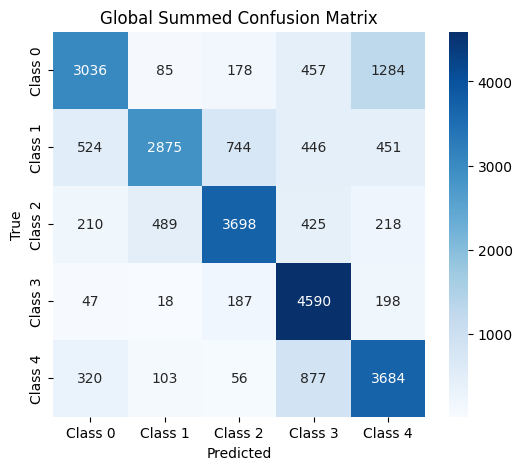

In [ ]:
import os
import copy
import pickle
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from transformers import AutoImageProcessor, AutoModelForImageClassification

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

def calculate_accuracy(outputs, labels):
    """
    outputs.logits => (batch_size, num_labels)
    labels         => (batch_size,)

    Both must be on the same device.
    """
    _, predicted = torch.max(outputs.logits, dim=1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)


def plot_confusion_matrix(cm, class_names=None, title="Confusion Matrix"):
    """
    cm: 2D confusion matrix (already summed or computed).
    class_names: list of string class names (optional)
    """
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
                xticklabels=class_names if class_names else range(len(cm)),
                yticklabels=class_names if class_names else range(len(cm)))
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


class ImageClassifierTrainer:
    def __init__(
        self,
        train_data,       # (train_x, train_y)
        val_data,         # (val_x,   val_y)
        model_name,       # e.g. "google/vit-base-patch16-224-in21k"
        identifier="fold",
        num_labels=5,
        lr=5e-5,
        batch_size=32,
    ):
        """
        train_data => (train_x, train_y)
        val_data   => (val_x, val_y)
        We'll train the entire model end-to-end, with early stopping on val set.
        """
        self.train_x, self.train_y = train_data
        self.val_x,   self.val_y   = val_data
        self.num_labels = num_labels
        self.lr         = lr
        self.batch_size = batch_size
        self.identifier = identifier

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        if self.train_x.ndim != 5:
            raise ValueError("Expect data shape => (samples, frames, H, W, C)")

        self.frames_per_sample = self.train_x.shape[1]  # frames per sample

        self.processor = AutoImageProcessor.from_pretrained(model_name)
        self.model = AutoModelForImageClassification.from_pretrained(model_name)
        self.model.classifier = nn.Linear(self.model.config.hidden_size, self.num_labels)
        self.model.num_labels = self.num_labels
        self.model.to(self.device)

        self.optimizer = optim.AdamW(self.model.parameters(), lr=self.lr)

        self.train_loader = self._make_dataloader(self.train_x, self.train_y, shuffle=True)
        self.val_loader   = self._make_dataloader(self.val_x,   self.val_y,   shuffle=False)

    def _make_dataloader(self, x, y, shuffle=True):
        """
        x => (samples, frames, H, W, C)
        y => (samples,)

        We'll:
          - Apply HF processor per frame,
          - replicate label across frames.
        """
        pixel_values_list = []
        for i in range(x.shape[0]):
            frames = x[i]  # shape => (frames, H, W, C)
            for frame in frames:
                proc = self.processor(images=frame, return_tensors="pt")
                pixel_values_list.append(proc["pixel_values"].squeeze(0))

        pixel_values = torch.stack(pixel_values_list, dim=0)  # on CPU

        repeated_labels = np.repeat(y, self.frames_per_sample)
        repeated_labels = torch.from_numpy(repeated_labels).long()  # on CPU

        dataset = TensorDataset(pixel_values, repeated_labels)
        loader  = DataLoader(dataset, batch_size=self.batch_size, shuffle=shuffle)
        return loader

    def train_loop(self, epochs=5, patience=3):
        """
        Single-phase training for `epochs`, with early stopping based on validation loss.
        """
        print(f"[{self.identifier}] => Training: epochs={epochs}, patience={patience}")

        if isinstance(self.model, nn.DataParallel):
            self.model = self.model.module

        if torch.cuda.device_count() > 1:
            self.model = nn.DataParallel(self.model)

        best_val_loss      = float("inf")
        best_model_weights = copy.deepcopy(self.model.state_dict())
        epochs_no_improve  = 0

        for epoch in range(1, epochs + 1):
            self.model.train()
            for pixel_values, labels in self.train_loader:
                pixel_values = pixel_values.to(self.device)
                labels       = labels.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(pixel_values=pixel_values, labels=labels)
                loss = outputs.loss
                if loss.dim() > 0:
                    loss = loss.mean()
                loss.backward()
                self.optimizer.step()

            val_loss = self.evaluate_val_loss()
            val_acc  = self.evaluate_val_frame_level()  # optional, for logging
            print(f"[{self.identifier}] epoch={epoch}/{epochs} => "
                  f"val_loss={val_loss:.4f}, val_acc={val_acc*100:.2f}%")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_weights = copy.deepcopy(self.model.state_dict())
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f"[{self.identifier}] Early stopping at epoch={epoch}")
                    break

        self.model.load_state_dict(best_model_weights)
        print(f"[{self.identifier}] => best_val_loss={best_val_loss:.4f}")

    def evaluate_val_loss(self):
        """
        Compute average validation loss over the val_loader.
        """
        self.model.eval()
        total_loss = 0.0
        count = 0
        with torch.no_grad():
            for pixel_values, labels in self.val_loader:
                pixel_values = pixel_values.to(self.device)
                labels       = labels.to(self.device)
                outputs = self.model(pixel_values=pixel_values, labels=labels)
                loss = outputs.loss
                if loss.dim() > 0:
                    loss = loss.mean()
                total_loss += loss.item()
                count += 1
        return total_loss / max(count, 1)

    def evaluate_val_frame_level(self):
        """
        Quick check: average frame-level accuracy on val_loader (only for logging).
        """
        self.model.eval()
        total_acc = 0.0
        count = 0
        with torch.no_grad():
            for pixel_values, labels in self.val_loader:
                pixel_values = pixel_values.to(self.device)
                labels       = labels.to(self.device)
                outputs = self.model(pixel_values=pixel_values)
                acc = calculate_accuracy(outputs, labels)
                total_acc += acc
                count += 1
        return total_acc / max(count, 1)

    def predict_sample_level(self, x, y, return_preds=False):
        """
        Evaluate on (x, y) with sample-level logic:
         - Build loader (CPU)
         - For each batch, move to GPU
         - Accumulate logits
         - Then average frames for each sample
        """
        loader = self._make_dataloader(x, y, shuffle=False)
        all_logits = []

        self.model.eval()
        with torch.no_grad():
            for pix, lbl in loader:
                pix = pix.to(self.device)
                outputs = self.model(pixel_values=pix)
                all_logits.append(outputs.logits.cpu().numpy())

        all_logits = np.concatenate(all_logits, axis=0)

        n_samples = x.shape[0]
        frames_per_sample = x.shape[1]
        if all_logits.shape[0] != n_samples * frames_per_sample:
            print(f"[{self.identifier}] mismatch => {all_logits.shape[0]} frames, "
                  f"expected {n_samples*frames_per_sample}")
            return None, None, None

        all_logits = all_logits.reshape(n_samples, frames_per_sample, -1)
        mean_logits= all_logits.mean(axis=1)
        preds = np.argmax(mean_logits, axis=1)

        acc = accuracy_score(y, preds)
        f1  = f1_score(y, preds, average='weighted')

        if return_preds:
            return acc, f1, preds
        return acc, f1


def main():
    data_dir = "/content/drive/MyDrive/kk/Input_images/Vision"
    model_path = "google/vit-base-patch16-224-in21k"

    num_labels = 5  # Adjust if needed

    global_summed_cm = np.zeros((num_labels, num_labels), dtype=np.int32)
    global_folds_count = 0
    global_test_accs = []
    global_test_f1s  = []

    all_files = sorted([f for f in os.listdir(data_dir) if f.lower().endswith(".pkl")])
    print(f"Found {len(all_files)} .pkl files in {data_dir}.")

    for file_name in all_files:
        pkl_path = os.path.join(data_dir, file_name)
        with open(pkl_path, 'rb') as f:
            data_list = pickle.load(f)  # => [train_x, train_y, test_x, test_y]

        if len(data_list) != 4:
            print(f"[{file_name}] => Data mismatch. Skipping.")
            continue

        train_x, train_y, test_x, test_y = data_list
        print(f"\n=== {file_name} ===")
        print(f"train_x={train_x.shape}, train_y={train_y.shape}, "
              f"test_x={test_x.shape}, test_y={test_y.shape}")

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        file_summed_cm = np.zeros((num_labels, num_labels), dtype=np.int32)
        fold_test_accs = []
        fold_test_f1s  = []

        for fold_idx, (tr_idx, val_idx) in enumerate(skf.split(train_x, train_y), start=1):
            print(f"\n=== [File: {file_name}] Fold {fold_idx}/5 ===")

            x_train_fold = train_x[tr_idx]
            y_train_fold = train_y[tr_idx]
            x_val_fold   = train_x[val_idx]
            y_val_fold   = train_y[val_idx]

            trainer = ImageClassifierTrainer(
                train_data=(x_train_fold, y_train_fold),
                val_data  =(x_val_fold,   y_val_fold),
                model_name=model_path,
                identifier=f"{file_name}_fold{fold_idx}",
                num_labels=num_labels,
                lr=5e-5,
                batch_size=32
            )
            trainer.train_loop(epochs=8, patience=3)

            test_acc, test_f1, test_preds = trainer.predict_sample_level(
                test_x, test_y, return_preds=True
            )
            print(f"[{file_name}] Fold {fold_idx} => Test ACC={test_acc*100:.2f}%, "
                  f"F1={test_f1:.4f}")

            cm_fold = confusion_matrix(test_y, test_preds, labels=range(num_labels))

            fold_test_accs.append(test_acc)
            fold_test_f1s.append(test_f1)
            file_summed_cm += cm_fold
            global_summed_cm += cm_fold
            global_folds_count += 1

        mean_file_acc = np.mean(fold_test_accs)
        mean_file_f1  = np.mean(fold_test_f1s)
        print(f"\n=== [File: {file_name}] 5-Fold Mean Test ACC={mean_file_acc*100:.2f}%, "
              f"F1={mean_file_f1:.4f}")

        plot_confusion_matrix(
            file_summed_cm,
            class_names=[f"Class {i}" for i in range(num_labels)],
            title=f"Summed CM (5-Folds) - {file_name}\nACC={mean_file_acc*100:.2f}%"
        )

        global_test_accs.append(mean_file_acc)
        global_test_f1s.append(mean_file_f1)

    valid_accs = [x for x in global_test_accs if x is not None]
    valid_f1s  = [y for y in global_test_f1s if y is not None]
    if len(valid_accs) > 0:
        mean_acc = np.mean(valid_accs)
        mean_f1  = np.mean(valid_f1s)
        print(f"\n=== Overall across {len(valid_accs)} files, "
              f"total folds={global_folds_count} ===")
        print(f"Mean ACC = {mean_acc*100:.2f}%")
        print(f"Mean F1  = {mean_f1:.4f}")
    else:
        print("\nNo valid test results to summarize.")

    print("\n=== Global Summed Confusion Matrix (All Files & 5-Folds) ===")
    print(global_summed_cm)
    plot_confusion_matrix(
        global_summed_cm,
        class_names=[f"Class {i}" for i in range(num_labels)],
        title="Global Summed Confusion Matrix"
    )


if __name__ == "__main__":
    main()


Global Train Set: (11760, 25, 56, 56, 3) (11760,)
Global Test Set: (5040, 25, 56, 56, 3) (5040,)

=== CV Fold 1 ===


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To us

KeyboardInterrupt: 

Using device: cuda
Train data shape: (11760, 25, 56, 56, 3) (11760,)
Test data shape:  (5040, 25, 56, 56, 3) (5040,)
Train set shape: (9408, 25, 56, 56, 3) (9408,)
Val   set shape: (2352, 25, 56, 56, 3) (2352,)
Epoch 1/10 => Train Loss=0.4268, Acc=83.76% | Val Loss=0.4407, Acc=84.51%
Epoch 2/10 => Train Loss=0.1316, Acc=95.30% | Val Loss=0.3902, Acc=87.31%
Epoch 3/10 => Train Loss=0.0761, Acc=97.32% | Val Loss=0.4119, Acc=87.84%
Epoch 4/10 => Train Loss=0.0556, Acc=98.06% | Val Loss=0.3714, Acc=89.58%
Epoch 5/10 => Train Loss=0.0457, Acc=98.46% | Val Loss=0.4232, Acc=88.63%
Epoch 6/10 => Train Loss=0.0384, Acc=98.68% | Val Loss=0.4343, Acc=88.74%
Epoch 7/10 => Train Loss=0.0334, Acc=98.89% | Val Loss=0.4613, Acc=88.87%
Early stopping triggered.

=== Final Test Results ===
Test Accuracy = 73.67%
Test F1 Score = 0.7318


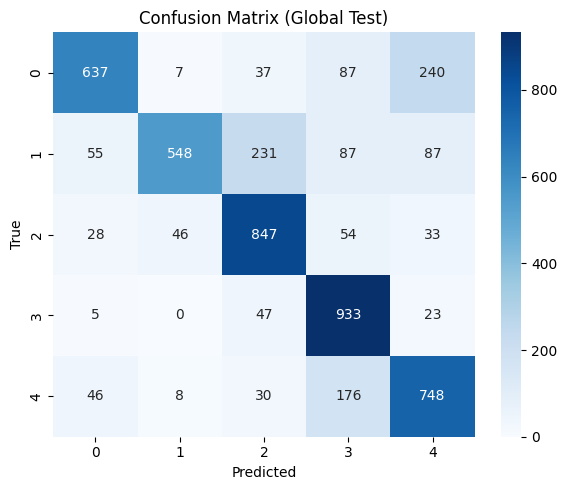

In [ ]:
import os
import pickle
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


class LargeVideoDataset(Dataset):
    """
    Each (sample, frame) is one item.
    - x_array: shape [num_samples, frames_per_sample, H, W, C]
    - y_array: shape [num_samples]
    - transform: a torchvision transform (Resize, ToTensor, etc.)
    """
    def __init__(self, x_array, y_array, transform=None):
        self.x_array = x_array
        self.y_array = y_array
        self.transform = transform
        self.num_samples = x_array.shape[0]
        self.frames_per_sample = x_array.shape[1]
        self.total_frames = self.num_samples * self.frames_per_sample

    def __len__(self):
        return self.total_frames

    def __getitem__(self, idx):
        """
        Map a global frame index -> (sample_idx, frame_idx).
        Return (frame_tensor, label).
        """
        sample_idx = idx // self.frames_per_sample
        frame_idx = idx % self.frames_per_sample

        frame = self.x_array[sample_idx, frame_idx]
        label = self.y_array[sample_idx]

        pil_image = Image.fromarray(frame)
        if self.transform is not None:
            frame_tensor = self.transform(pil_image)  # shape [3, 224, 224]
        else:
            frame_tensor = transforms.ToTensor()(pil_image)

        label_tensor = torch.tensor(label, dtype=torch.long)
        return frame_tensor, label_tensor


class VideoModel(nn.Module):
    def __init__(self, num_labels=5):
        super(VideoModel, self).__init__()
        base_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.base_model = nn.Sequential(*(list(base_model.children())[:-2]))
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(2048, num_labels)

    def forward(self, x):
        x = self.base_model(x)       # => [batch_size, 2048, h, w]
        x = self.global_pool(x)      # => [batch_size, 2048, 1, 1]
        x = self.flatten(x)          # => [batch_size, 2048]
        x = self.fc(x)               # => [batch_size, num_labels]
        return x


def evaluate_sample_level(model, test_x, test_y, transform, batch_size=512):
    """
    Evaluate at the 'sample' level by averaging frame-level logits.
    test_x: shape [num_samples, frames_per_sample, H, W, C]
    test_y: shape [num_samples]
    """
    model.eval()
    num_samples = test_x.shape[0]
    frames_per_sample = test_x.shape[1]
    all_preds = []

    with torch.no_grad():
        for sample_idx in range(num_samples):
            frames = test_x[sample_idx]  # [frames_per_sample, H, W, C]
            logits_accumulator = []

            start = 0
            while start < frames_per_sample:
                end = min(start + batch_size, frames_per_sample)
                batch_frames = frames[start:end]  # shape [n_frames, H, W, C]

                batch_tensors = []
                for frame in batch_frames:
                    pil_img = Image.fromarray(frame)
                    frame_tensor = transform(pil_img)
                    batch_tensors.append(frame_tensor)

                batch_tensors = torch.stack(batch_tensors, dim=0).to(device)
                out = model(batch_tensors)  # => [n_frames, num_labels]
                logits_accumulator.append(out.cpu().numpy())
                start = end

            logits_accumulator = np.concatenate(logits_accumulator, axis=0)
            avg_logits = logits_accumulator.mean(axis=0)  # => [num_labels]
            pred = np.argmax(avg_logits)
            all_preds.append(pred)

    acc = accuracy_score(test_y, all_preds)
    f1 = f1_score(test_y, all_preds, average='weighted')
    return acc, f1, all_preds


def main():
    data_dir = "/content/drive/MyDrive/kk/Input_images/Vision"
    all_files = sorted([f for f in os.listdir(data_dir) if f.lower().endswith(".pkl")])

    all_train_x, all_train_y = [], []
    all_test_x,  all_test_y  = [], []

    for file in all_files:
        with open(os.path.join(data_dir, file), 'rb') as f:
            train_x, train_y, test_x, test_y = pickle.load(f)
            all_train_x.append(train_x)
            all_train_y.append(train_y)
            all_test_x.append(test_x)
            all_test_y.append(test_y)

    global_train_x = np.concatenate(all_train_x, axis=0)  # shape [N, frames, H, W, C]
    global_train_y = np.concatenate(all_train_y, axis=0)  # shape [N]
    global_test_x  = np.concatenate(all_test_x,  axis=0)  # shape [M, frames, H, W, C]
    global_test_y  = np.concatenate(all_test_y,  axis=0)  # shape [M]

    print("Train data shape:", global_train_x.shape, global_train_y.shape)
    print("Test data shape: ", global_test_x.shape,  global_test_y.shape)

    train_x, val_x, train_y, val_y = train_test_split(
        global_train_x, global_train_y,
        test_size=0.2,
        stratify=global_train_y,
        random_state=42
    )
    print("Train set shape:", train_x.shape, train_y.shape)
    print("Val   set shape:", val_x.shape,   val_y.shape)

    my_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])

    train_dataset = LargeVideoDataset(train_x, train_y, transform=my_transform)
    val_dataset   = LargeVideoDataset(val_x,   val_y,   transform=my_transform)

    batch_size = 128

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2)

    model = VideoModel(num_labels=5).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

    epochs = 10
    patience = 3
    best_val_loss = float("inf")
    best_weights = None
    no_improve = 0

    for epoch in range(1, epochs+1):
        model.train()
        total_train_loss = 0
        total_train_correct = 0
        total_frames = 0

        for frames_batch, labels_batch in train_loader:
            frames_batch = frames_batch.to(device)
            labels_batch = labels_batch.to(device)

            optimizer.zero_grad()
            outputs = model(frames_batch)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

            bs = frames_batch.size(0)
            total_train_loss += loss.item() * bs
            preds = torch.argmax(outputs, dim=1)
            total_train_correct += (preds == labels_batch).sum().item()
            total_frames += bs

        avg_train_loss = total_train_loss / total_frames
        avg_train_acc  = total_train_correct / total_frames

        model.eval()
        total_val_loss = 0
        total_val_correct = 0
        total_val_frames = 0

        with torch.no_grad():
            for frames_batch, labels_batch in val_loader:
                frames_batch = frames_batch.to(device)
                labels_batch = labels_batch.to(device)

                val_out = model(frames_batch)
                val_loss = criterion(val_out, labels_batch)

                bs = frames_batch.size(0)
                total_val_loss += val_loss.item() * bs
                val_preds = torch.argmax(val_out, dim=1)
                total_val_correct += (val_preds == labels_batch).sum().item()
                total_val_frames += bs

        avg_val_loss = total_val_loss / total_val_frames
        avg_val_acc  = total_val_correct / total_val_frames

        print(f"Epoch {epoch}/{epochs} => "
              f"Train Loss={avg_train_loss:.4f}, Acc={avg_train_acc*100:.2f}% | "
              f"Val Loss={avg_val_loss:.4f}, Acc={avg_val_acc*100:.2f}%")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_weights = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print("Early stopping triggered.")
                break

    if best_weights is not None:
        model.load_state_dict(best_weights)

    test_acc, test_f1, test_preds = evaluate_sample_level(
        model, global_test_x, global_test_y,
        transform=my_transform,
        batch_size=512
    )
    print(f"\n=== Final Test Results ===")
    print(f"Test Accuracy = {test_acc*100:.2f}%")
    print(f"Test F1 Score = {test_f1:.4f}")

    cm = confusion_matrix(global_test_y, test_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (Global Test)")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Using device: cuda
Global train data shape: (11760, 25, 56, 56, 3) (11760,)
Global test data shape:  (5040, 25, 56, 56, 3) (5040,)

=== FOLD 1 ===
   [Epoch 1] Train Loss=0.4276, Val Loss=0.3276, Val Acc=88.14%
   [Epoch 2] Train Loss=0.1299, Val Loss=0.3388, Val Acc=88.86%
   [Epoch 3] Train Loss=0.0750, Val Loss=0.3643, Val Acc=88.93%
   [Epoch 4] Train Loss=0.0556, Val Loss=0.3354, Val Acc=90.38%
   Early stopping triggered at epoch 4.
   Fold 1: best epoch used = 4

=== FOLD 2 ===
   [Epoch 1] Train Loss=0.4271, Val Loss=0.3570, Val Acc=87.11%
   [Epoch 2] Train Loss=0.1321, Val Loss=0.3821, Val Acc=87.62%
   [Epoch 3] Train Loss=0.0771, Val Loss=0.3524, Val Acc=89.02%
   [Epoch 4] Train Loss=0.0544, Val Loss=0.3783, Val Acc=89.37%
   [Epoch 5] Train Loss=0.0443, Val Loss=0.3566, Val Acc=89.95%
   [Epoch 6] Train Loss=0.0383, Val Loss=0.3556, Val Acc=90.21%
   Early stopping triggered at epoch 6.
   Fold 2: best epoch used = 6

=== FOLD 3 ===
   [Epoch 1] Train Loss=0.4331, Val Los

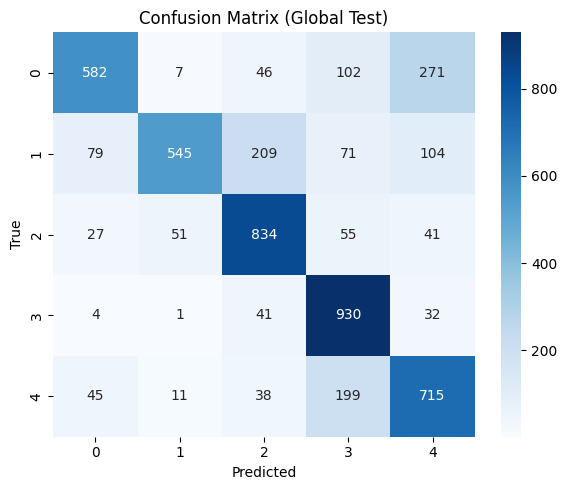

In [ ]:
import os
import pickle
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class LargeVideoDataset(Dataset):
    """
    Each (sample, frame) is one item.
    - x_array: shape [num_samples, frames_per_sample, H, W, C]
    - y_array: shape [num_samples]
    - transform: a torchvision transform (Resize, ToTensor, etc.)
    """
    def __init__(self, x_array, y_array, transform=None):
        self.x_array = x_array
        self.y_array = y_array
        self.transform = transform
        self.num_samples = x_array.shape[0]
        self.frames_per_sample = x_array.shape[1]
        self.total_frames = self.num_samples * self.frames_per_sample

    def __len__(self):
        return self.total_frames

    def __getitem__(self, idx):
        sample_idx = idx // self.frames_per_sample
        frame_idx  = idx % self.frames_per_sample

        frame = self.x_array[sample_idx, frame_idx]  # [H, W, C]
        label = self.y_array[sample_idx]

        pil_image = Image.fromarray(frame)
        if self.transform:
            frame_tensor = self.transform(pil_image)
        else:
            frame_tensor = transforms.ToTensor()(pil_image)

        label_tensor = torch.tensor(label, dtype=torch.long)
        return frame_tensor, label_tensor

class VideoModel(nn.Module):
    def __init__(self, num_labels=5):
        super(VideoModel, self).__init__()
        base_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.base_model = nn.Sequential(*(list(base_model.children())[:-2]))
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(2048, num_labels)

    def forward(self, x):
        x = self.base_model(x)     # => [B, 2048, h, w]
        x = self.global_pool(x)    # => [B, 2048, 1, 1]
        x = self.flatten(x)        # => [B, 2048]
        x = self.fc(x)             # => [B, num_labels]
        return x

def train_with_early_stopping(model, train_loader, val_loader, max_epochs=10, patience=3, lr=5e-5):
    """
    Trains the given model using cross-entropy + early stopping.
    Returns the *best model weights* and the *epoch at which training stopped*.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    best_val_loss = float("inf")
    best_weights = None
    no_improve = 0

    epoch_used = 0

    for epoch in range(1, max_epochs+1):
        model.train()
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_frames = 0

        for frames_batch, labels_batch in train_loader:
            frames_batch = frames_batch.to(device)
            labels_batch = labels_batch.to(device)

            optimizer.zero_grad()
            outputs = model(frames_batch)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

            bs = frames_batch.size(0)
            total_train_loss += loss.item() * bs
            preds = torch.argmax(outputs, dim=1)
            total_train_correct += (preds == labels_batch).sum().item()
            total_train_frames += bs

        avg_train_loss = total_train_loss / total_train_frames
        avg_train_acc  = total_train_correct / total_train_frames

        model.eval()
        total_val_loss = 0
        total_val_correct = 0
        total_val_frames = 0

        with torch.no_grad():
            for frames_batch, labels_batch in val_loader:
                frames_batch = frames_batch.to(device)
                labels_batch = labels_batch.to(device)
                val_out = model(frames_batch)
                val_loss = criterion(val_out, labels_batch)

                bs = frames_batch.size(0)
                total_val_loss += val_loss.item() * bs
                val_preds = torch.argmax(val_out, dim=1)
                total_val_correct += (val_preds == labels_batch).sum().item()
                total_val_frames += bs

        avg_val_loss = total_val_loss / total_val_frames
        avg_val_acc  = total_val_correct / total_val_frames

        print(f"   [Epoch {epoch}] Train Loss={avg_train_loss:.4f}, "
              f"Val Loss={avg_val_loss:.4f}, Val Acc={avg_val_acc*100:.2f}%")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_weights = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"   Early stopping triggered at epoch {epoch}.")
                epoch_used = epoch
                break

        epoch_used = epoch  # If we never break, we used all max_epochs

    return best_weights, epoch_used

def cross_validate_5fold(x, y, batch_size=128, max_epochs=10, patience=3):
    """
    Performs 5-Fold Cross-Validation on x,y.
    Returns the median of the "best epoch used" across folds.
    """
    from sklearn.model_selection import StratifiedKFold

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    fold_epoch_list = []

    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(x, y), start=1):
        print(f"\n=== FOLD {fold_idx} ===")

        x_train_fold = x[train_idx]
        y_train_fold = y[train_idx]
        x_val_fold   = x[val_idx]
        y_val_fold   = y[val_idx]

        train_dataset = LargeVideoDataset(x_train_fold, y_train_fold, transform=transform_train)
        val_dataset   = LargeVideoDataset(x_val_fold,   y_val_fold,   transform=transform_train)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
        val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2)

        fold_model = VideoModel(num_labels=5).to(device)

        best_weights, epoch_used = train_with_early_stopping(
            fold_model, train_loader, val_loader,
            max_epochs=max_epochs, patience=patience
        )
        print(f"   Fold {fold_idx}: best epoch used = {epoch_used}")

        fold_epoch_list.append(epoch_used)

    median_epoch = int(np.median(fold_epoch_list))
    print(f"\nAll fold epochs used: {fold_epoch_list}")
    print(f"Median epochs used: {median_epoch}")
    return median_epoch

def evaluate_sample_level(model, test_x, test_y, batch_size=512):
    """
    Evaluate at sample-level by averaging frame-level logits.
    """
    model.eval()
    num_samples = test_x.shape[0]
    frames_per_sample = test_x.shape[1]
    all_preds = []

    with torch.no_grad():
        for sample_idx in range(num_samples):
            frames = test_x[sample_idx]  # shape [frames_per_sample, H, W, C]
            logits_list = []

            start = 0
            while start < frames_per_sample:
                end = min(start + batch_size, frames_per_sample)
                batch_frames = frames[start:end]
                batch_tensors = []
                for frm in batch_frames:
                    pil_img = Image.fromarray(frm)
                    frm_tensor = transform_test(pil_img)
                    batch_tensors.append(frm_tensor)

                batch_tensors = torch.stack(batch_tensors).to(device)
                out = model(batch_tensors)
                logits_list.append(out.cpu().numpy())
                start = end

            logits_array = np.concatenate(logits_list, axis=0)  # shape [frames_per_sample, num_labels]
            avg_logits = logits_array.mean(axis=0)
            pred_label = np.argmax(avg_logits)
            all_preds.append(pred_label)

    acc = accuracy_score(test_y, all_preds)
    f1 = f1_score(test_y, all_preds, average='weighted')
    return acc, f1, all_preds

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_test = transform_train  # If test transform is same as train, just reuse

def main():
    data_dir = "/content/drive/MyDrive/kk/Input_images/Vision"
    all_files = sorted([f for f in os.listdir(data_dir) if f.lower().endswith(".pkl")])

    all_train_x, all_train_y = [], []
    all_test_x,  all_test_y  = [], []

    for file in all_files:
        with open(os.path.join(data_dir, file), 'rb') as f:
            train_x, train_y, test_x, test_y = pickle.load(f)
            all_train_x.append(train_x)
            all_train_y.append(train_y)
            all_test_x.append(test_x)
            all_test_y.append(test_y)

    global_train_x = np.concatenate(all_train_x, axis=0)  # [N, frames, H, W, C]
    global_train_y = np.concatenate(all_train_y, axis=0)
    global_test_x  = np.concatenate(all_test_x,  axis=0)
    global_test_y  = np.concatenate(all_test_y,  axis=0)

    print("Global train data shape:", global_train_x.shape, global_train_y.shape)
    print("Global test data shape: ", global_test_x.shape,  global_test_y.shape)

    median_epoch = cross_validate_5fold(
        x=global_train_x,
        y=global_train_y,
        batch_size=128,   # you can tweak
        max_epochs=10,    # max epochs
        patience=3
    )

    print(f"\n=== Final Training ===")
    print(f"Training for exactly {median_epoch} epochs (no early stopping).")

    full_train_dataset = LargeVideoDataset(global_train_x, global_train_y, transform=transform_train)
    full_train_loader  = DataLoader(full_train_dataset, batch_size=128, shuffle=True, num_workers=2)

    final_model = VideoModel(num_labels=5).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(final_model.parameters(), lr=5e-5)

    for epoch in range(1, median_epoch+1):
        final_model.train()
        total_loss = 0
        total_correct = 0
        total_frames = 0

        for frames_batch, labels_batch in full_train_loader:
            frames_batch = frames_batch.to(device)
            labels_batch = labels_batch.to(device)

            optimizer.zero_grad()
            outputs = final_model(frames_batch)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

            bs = frames_batch.size(0)
            total_loss += loss.item() * bs
            preds = torch.argmax(outputs, dim=1)
            total_correct += (preds == labels_batch).sum().item()
            total_frames += bs

        avg_loss = total_loss / total_frames
        avg_acc  = total_correct / total_frames
        print(f"  [Epoch {epoch}/{median_epoch}] Train Loss={avg_loss:.4f}, Acc={avg_acc*100:.2f}%")

    test_acc, test_f1, test_preds = evaluate_sample_level(
        final_model, global_test_x, global_test_y, batch_size=512
    )
    print("\n=== Final Test Results ===")
    print(f"Test Accuracy = {test_acc*100:.2f}%")
    print(f"Test F1-score = {test_f1:.4f}")

    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    cm = confusion_matrix(global_test_y, test_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (Global Test)")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import os
import torch
from transformers import AutoModelForImageClassification

hub_model_name = "google/vit-base-patch16-224"  # or any public HF model
local_dir      = "/content/drive/MyDrive/MyVitModel"  # change as you like

if not os.path.exists(local_dir):
    os.makedirs(local_dir, exist_ok=True)

model = AutoModelForImageClassification.from_pretrained(
    hub_model_name,
    num_labels=5,
    ignore_mismatched_sizes=True
)

model.save_pretrained(local_dir)

print(f"Model saved to: {local_dir}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model saved to: /content/drive/MyDrive/MyVitModel


Using device: cuda
Global train: (11760, 25, 56, 56, 3) (11760,)
Global test:  (5040, 25, 56, 56, 3) (5040,)

=== 5-Fold Cross Validation ===

=== FOLD 1 ===


<ipython-input-5-a02ef4c5fa5b>:91: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-5-a02ef4c5fa5b>:106: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-5-a02ef4c5fa5b>:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


   Epoch 1/10 => Train Loss=0.4724, Val Loss=0.4030, Val Acc=86.01%
   Epoch 2/10 => Train Loss=0.1712, Val Loss=0.3527, Val Acc=88.74%
   Epoch 3/10 => Train Loss=0.1047, Val Loss=0.3461, Val Acc=89.51%
   Epoch 4/10 => Train Loss=0.0749, Val Loss=0.3638, Val Acc=89.65%
   Epoch 5/10 => Train Loss=0.0596, Val Loss=0.3632, Val Acc=89.87%
   Epoch 6/10 => Train Loss=0.0497, Val Loss=0.3552, Val Acc=90.63%
   Early stopping at epoch 6
   FOLD 1 => best epoch used: 6

=== FOLD 2 ===
   Epoch 1/10 => Train Loss=0.4719, Val Loss=0.4235, Val Acc=84.93%
   Epoch 2/10 => Train Loss=0.1725, Val Loss=0.3772, Val Acc=87.19%
   Epoch 3/10 => Train Loss=0.1056, Val Loss=0.3414, Val Acc=88.89%
   Epoch 4/10 => Train Loss=0.0751, Val Loss=0.3350, Val Acc=90.26%
   Epoch 5/10 => Train Loss=0.0604, Val Loss=0.3777, Val Acc=89.54%
   Epoch 6/10 => Train Loss=0.0497, Val Loss=0.3574, Val Acc=89.95%
   Epoch 7/10 => Train Loss=0.0430, Val Loss=0.3780, Val Acc=89.75%
   Early stopping at epoch 7
   FOLD 2 

<ipython-input-5-a02ef4c5fa5b>:280: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler      = GradScaler()
<ipython-input-5-a02ef4c5fa5b>:293: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  [Epoch 1/6] => Train Loss=0.4339, Acc=83.43%
  [Epoch 2/6] => Train Loss=0.1569, Acc=94.29%
  [Epoch 3/6] => Train Loss=0.0968, Acc=96.55%
  [Epoch 4/6] => Train Loss=0.0708, Acc=97.50%
  [Epoch 5/6] => Train Loss=0.0557, Acc=98.06%
  [Epoch 6/6] => Train Loss=0.0483, Acc=98.36%

=== Final Testing (Sample-level) ===


<ipython-input-5-a02ef4c5fa5b>:218: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Test Accuracy = 74.60%
Test F1 Score = 0.7447


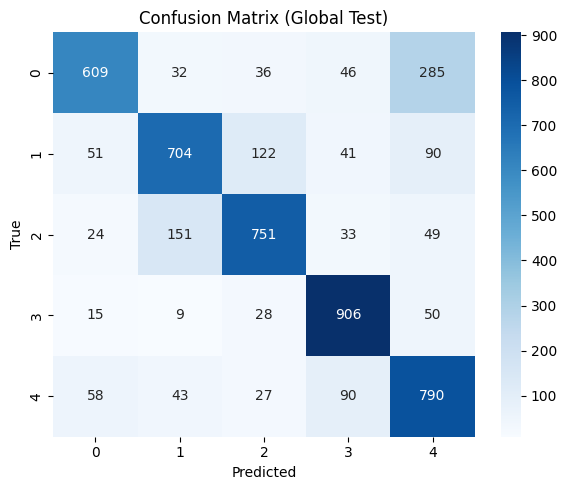

In [ ]:
import os
import pickle
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoModelForImageClassification

from torch.cuda.amp import autocast, GradScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
transform_test = transform_train  # same in this example

class LargeVideoDataset(Dataset):
    """
    Each item = one frame + label.
    x_array: [num_samples, frames_per_sample, H, W, C]
    y_array: [num_samples]
    """
    def __init__(self, x_array, y_array, transform=None):
        self.x_array = x_array
        self.y_array = y_array
        self.transform = transform

        self.num_samples = x_array.shape[0]
        self.frames_per_sample = x_array.shape[1]
        self.total_frames = self.num_samples * self.frames_per_sample

    def __len__(self):
        return self.total_frames

    def __getitem__(self, idx):
        sample_idx = idx // self.frames_per_sample
        frame_idx  = idx %  self.frames_per_sample

        frame = self.x_array[sample_idx, frame_idx]  # shape [H, W, C]
        label = self.y_array[sample_idx]

        pil_img = Image.fromarray(frame)
        frame_tensor = self.transform(pil_img) if self.transform else transforms.ToTensor()(pil_img)
        label_tensor = torch.tensor(label, dtype=torch.long)
        return frame_tensor, label_tensor

class ViTModel(nn.Module):
    def __init__(self, local_dir, num_labels=5):
        super().__init__()
        self.model = AutoModelForImageClassification.from_pretrained(
            local_dir,
            num_labels=num_labels,
            ignore_mismatched_sizes=True,
            local_files_only=True  # <-- ensures we only use local folder, no HF Hub calls
        )

    def forward(self, x):
        outputs = self.model(pixel_values=x)
        return outputs.logits

def train_one_fold(model, train_loader, val_loader, max_epochs=10, patience=3, lr=5e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scaler = GradScaler()
    best_val_loss = float("inf")
    best_weights = None
    no_improve = 0
    epoch_used = 0

    for epoch in range(1, max_epochs+1):
        model.train()
        total_train_loss = 0
        total_train_correct = 0
        total_frames = 0

        for frames_batch, labels_batch in train_loader:
            frames_batch, labels_batch = frames_batch.to(device), labels_batch.to(device)
            optimizer.zero_grad()
            with autocast():
                logits = model(frames_batch)
                loss = criterion(logits, labels_batch)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            bs = frames_batch.size(0)
            total_train_loss += loss.item() * bs
            preds = torch.argmax(logits, dim=1)
            total_train_correct += (preds == labels_batch).sum().item()
            total_frames += bs

        avg_train_loss = total_train_loss / total_frames
        avg_train_acc  = total_train_correct / total_frames

        model.eval()
        total_val_loss = 0
        total_val_correct = 0
        total_val_frames = 0

        with torch.no_grad():
            for frames_batch, labels_batch in val_loader:
                frames_batch, labels_batch = frames_batch.to(device), labels_batch.to(device)
                with autocast():
                    val_logits = model(frames_batch)
                    val_loss   = criterion(val_logits, labels_batch)

                bs = frames_batch.size(0)
                total_val_loss += val_loss.item() * bs
                val_preds = torch.argmax(val_logits, dim=1)
                total_val_correct += (val_preds == labels_batch).sum().item()
                total_val_frames += bs

        avg_val_loss = total_val_loss / total_val_frames
        avg_val_acc  = total_val_correct / total_val_frames
        print(f"   Epoch {epoch}/{max_epochs} => Train Loss={avg_train_loss:.4f}, "
              f"Val Loss={avg_val_loss:.4f}, Val Acc={avg_val_acc*100:.2f}%")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_weights = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"   Early stopping at epoch {epoch}")
                epoch_used = epoch
                break

        epoch_used = epoch

    return best_weights, epoch_used

def cross_validate_5fold(x, y, local_dir, batch_size=32, max_epochs=10, patience=3):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    used_epochs = []

    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(x, y), start=1):
        print(f"\n=== FOLD {fold_idx} ===")
        x_train_fold, y_train_fold = x[train_idx], y[train_idx]
        x_val_fold,   y_val_fold   = x[val_idx],   y[val_idx]

        train_dataset = LargeVideoDataset(x_train_fold, y_train_fold, transform=transform_train)
        val_dataset   = LargeVideoDataset(x_val_fold,   y_val_fold,   transform=transform_train)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2)
        val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2)

        fold_model = ViTModel(local_dir, num_labels=5).to(device)
        best_weights, epoch_used = train_one_fold(
            fold_model, train_loader, val_loader,
            max_epochs=max_epochs, patience=patience, lr=5e-5
        )
        print(f"   FOLD {fold_idx} => best epoch used: {epoch_used}")
        used_epochs.append(epoch_used)

    median_ep = int(np.median(used_epochs))
    print("\nFold epochs used:", used_epochs)
    print("Median epoch used:", median_ep)
    return median_ep

def evaluate_sample_level(model, test_x, test_y, batch_size=32):
    model.eval()
    n_samples = test_x.shape[0]
    frames_per_sample = test_x.shape[1]
    all_preds = []
    from torch.cuda.amp import autocast

    with torch.no_grad():
        for i in range(n_samples):
            frames = test_x[i]  # shape: [frames_per_sample, H, W, C]
            logits_list = []
            start = 0
            while start < frames_per_sample:
                end = min(start+batch_size, frames_per_sample)
                batch_frames = frames[start:end]

                batch_tensors = []
                for frm in batch_frames:
                    pil_img = Image.fromarray(frm)
                    frm_tensor = transform_test(pil_img)
                    batch_tensors.append(frm_tensor)

                batch_tensors = torch.stack(batch_tensors).to(device)
                with autocast():
                    outs = model(batch_tensors)
                logits_list.append(outs.cpu().numpy())
                start = end

            sample_logits = np.concatenate(logits_list, axis=0)  # [frames, num_labels]
            avg_logits = sample_logits.mean(axis=0)
            pred = np.argmax(avg_logits)
            all_preds.append(pred)

    acc = accuracy_score(test_y, all_preds)
    f1  = f1_score(test_y, all_preds, average='weighted')
    return acc, f1, all_preds

def main():
    local_dir = "/content/drive/MyDrive/MyVitModel"

    data_dir = "/content/drive/MyDrive/kk/Input_images/Vision"
    all_files = sorted([f for f in os.listdir(data_dir) if f.lower().endswith(".pkl")])

    all_train_x, all_train_y = [], []
    all_test_x,  all_test_y  = [], []

    for file_name in all_files:
        with open(os.path.join(data_dir, file_name), "rb") as f:
            train_x, train_y, test_x, test_y = pickle.load(f)
            all_train_x.append(train_x)
            all_train_y.append(train_y)
            all_test_x.append(test_x)
            all_test_y.append(test_y)

    global_train_x = np.concatenate(all_train_x, axis=0)
    global_train_y = np.concatenate(all_train_y, axis=0)
    global_test_x  = np.concatenate(all_test_x,  axis=0)
    global_test_y  = np.concatenate(all_test_y,  axis=0)

    print("Global train:", global_train_x.shape, global_train_y.shape)
    print("Global test: ", global_test_x.shape,  global_test_y.shape)

    print("\n=== 5-Fold Cross Validation ===")
    median_epoch = cross_validate_5fold(
        x=global_train_x,
        y=global_train_y,
        local_dir=local_dir,
        batch_size=32,
        max_epochs=10,
        patience=3
    )

    print(f"\n=== Final Training for {median_epoch} epochs ===")
    final_dataset = LargeVideoDataset(global_train_x, global_train_y, transform=transform_train)
    final_loader  = DataLoader(final_dataset, batch_size=32, shuffle=True, num_workers=2)

    final_model = ViTModel(local_dir, num_labels=5).to(device)
    criterion   = nn.CrossEntropyLoss()
    optimizer   = torch.optim.AdamW(final_model.parameters(), lr=5e-5)
    scaler      = GradScaler()

    for ep in range(1, median_epoch+1):
        final_model.train()
        total_loss = 0
        total_correct = 0
        total_frames = 0

        for frames_batch, labels_batch in final_loader:
            frames_batch = frames_batch.to(device)
            labels_batch = labels_batch.to(device)

            optimizer.zero_grad()
            with autocast():
                logits = final_model(frames_batch)
                loss = criterion(logits, labels_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            bs = frames_batch.size(0)
            total_loss += loss.item() * bs
            preds = torch.argmax(logits, dim=1)
            total_correct += (preds == labels_batch).sum().item()
            total_frames += bs

        avg_loss = total_loss / total_frames
        avg_acc  = total_correct / total_frames
        print(f"  [Epoch {ep}/{median_epoch}] => Train Loss={avg_loss:.4f}, Acc={avg_acc*100:.2f}%")

    print("\n=== Final Testing (Sample-level) ===")
    test_acc, test_f1, test_preds = evaluate_sample_level(
        final_model, global_test_x, global_test_y, batch_size=32
    )

    print(f"Test Accuracy = {test_acc*100:.2f}%")
    print(f"Test F1 Score = {test_f1:.4f}")

    cm = confusion_matrix(global_test_y, test_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (Global Test)")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Total Training Samples: 11760
Total Test Samples: 5040
Extracting AST features...


<ipython-input-1-b74964474852>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Epoch 1, Train Acc: 32.75%, Val Loss: 1.3572
Epoch 2, Train Acc: 47.05%, Val Loss: 1.1866
Epoch 3, Train Acc: 51.71%, Val Loss: 1.1240
Epoch 4, Train Acc: 54.26%, Val Loss: 1.0880
Epoch 5, Train Acc: 56.56%, Val Loss: 1.0617
Epoch 6, Train Acc: 58.56%, Val Loss: 1.0192
Epoch 7, Train Acc: 60.48%, Val Loss: 1.0009
Epoch 8, Train Acc: 62.74%, Val Loss: 0.9990
Epoch 9, Train Acc: 63.30%, Val Loss: 0.9634
Epoch 10, Train Acc: 65.18%, Val Loss: 0.9410
Epoch 11, Train Acc: 67.18%, Val Loss: 0.9306
Epoch 12, Train Acc: 67.83%, Val Loss: 0.9272
Epoch 13, Train Acc: 68.85%, Val Loss: 0.9541
Epoch 14, Train Acc: 69.95%, Val Loss: 0.8987
Epoch 15, Train Acc: 71.17%, Val Loss: 0.8966
Epoch 16, Train Acc: 72.16%, Val Loss: 0.8787
Epoch 17, Train Acc: 73.18%, Val Loss: 0.8761
Epoch 18, Train Acc: 73.87%, Val Loss: 0.8748
Epoch 19, Train Acc: 74.82%, Val Loss: 0.9190
Epoch 20, Train Acc: 75.85%, Val Loss: 0.8509
Epoch 21, Train Acc: 76.97%, Val Loss: 0.8539
Epoch 22, Train Acc: 78.15%, Val Loss: 0.85

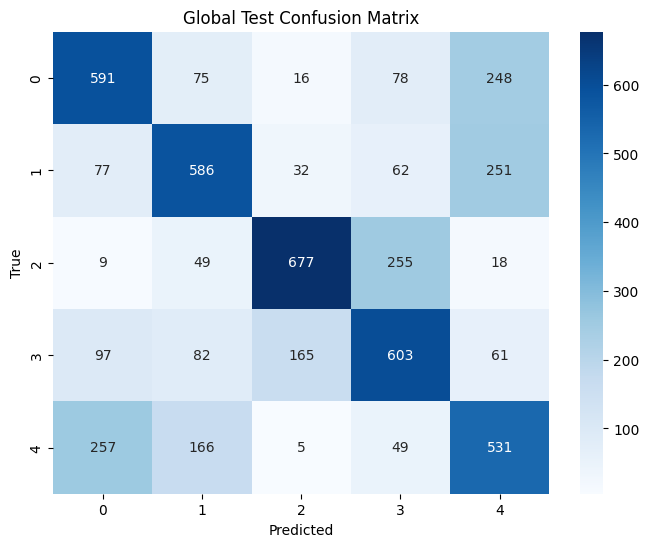

Test Accuracy: 59.29% | F1 Score: 0.5952


In [ ]:
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from transformers import ASTFeatureExtractor, AutoModelForAudioClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score, confusion_matrix  # <-- Imported confusion_matrix
from sklearn.model_selection import train_test_split
from copy import deepcopy

class AudioModelTrainerGlobal:
    def __init__(self, train_X, train_y, val_X, val_y, test_X, test_y,
                 model_path, num_classes=5, lr=0.001, weight_decay=1e-5, batch_size=32):

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.batch_size = batch_size
        self.loss_fn = nn.CrossEntropyLoss()
        self.initial_lr = lr
        self.weight_decay = weight_decay

        self.extractor = ASTFeatureExtractor()

        print("Extracting AST features...")
        self.train_X = self._extract(train_X)
        self.val_X   = self._extract(val_X)
        self.test_X  = self._extract(test_X)

        self.train_loader = self._prepare_dataloader(self.train_X, train_y, shuffle=True)
        self.val_loader   = self._prepare_dataloader(self.val_X, val_y, shuffle=False)
        self.test_loader  = self._prepare_dataloader(self.test_X, test_y, shuffle=False)

        self.model = AutoModelForAudioClassification.from_pretrained(model_path)
        self.model.classifier.dense = nn.Linear(self.model.classifier.dense.in_features, num_classes)
        self.model.to(self.device)

        self.optimizer = optim.AdamW(self.model.parameters(), lr=self.initial_lr, weight_decay=self.weight_decay)
        self.outputs_test = None

    def _extract(self, waveforms):
        features = self.extractor(waveforms, sampling_rate=16000, padding="max_length", return_tensors="pt")
        return features["input_values"]

    def _prepare_dataloader(self, x, y, shuffle=False):
        x_tensor = torch.tensor(x, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.long)
        dataset = TensorDataset(x_tensor, y_tensor)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=shuffle)

    def train(self, epochs=50, patience=3):
        best_val_loss = float("inf")
        best_state = None
        epochs_no_improve = 0

        for epoch in range(epochs):
            self.model.train()
            correct, total, running_loss = 0, 0, 0.0

            for x_batch, y_batch in self.train_loader:
                x_batch, y_batch = x_batch.to(self.device), y_batch.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(x_batch)
                logits = outputs.logits
                loss = self.loss_fn(logits, y_batch)
                loss.backward()
                self.optimizer.step()

                preds = logits.argmax(dim=-1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)
                running_loss += loss.item() * x_batch.size(0)

            train_acc = 100.0 * correct / total

            self.model.eval()
            val_loss, val_total = 0.0, 0
            with torch.no_grad():
                for x_val, y_val in self.val_loader:
                    x_val, y_val = x_val.to(self.device), y_val.to(self.device)
                    logits = self.model(x_val).logits
                    loss = self.loss_fn(logits, y_val)
                    val_loss += loss.item() * x_val.size(0)
                    val_total += y_val.size(0)
            val_loss /= val_total

            print(f"Epoch {epoch+1}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_state = deepcopy(self.model.state_dict())
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        if best_state:
            self.model.load_state_dict(best_state)

    def evaluate(self):
        self.model.eval()
        correct, total = 0, 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for x_batch, y_batch in self.test_loader:
                x_batch, y_batch = x_batch.to(self.device), y_batch.to(self.device)
                logits = self.model(x_batch).logits
                preds = logits.argmax(dim=-1)
                all_preds.append(preds.cpu().numpy())
                all_labels.append(y_batch.cpu().numpy())
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)

        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        acc = 100.0 * correct / total
        f1 = f1_score(all_labels, all_preds, average='weighted')

        cm = confusion_matrix(all_labels, all_preds)

        import seaborn as sns
        import matplotlib.pyplot as plt

        plt.figure(figsize=(8,6))
        ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        ax.set_title("Global Test Confusion Matrix")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.xaxis.set_ticklabels([0,1,2,3,4])
        ax.yaxis.set_ticklabels([0,1,2,3,4])
        plt.show()

        print(f"Test Accuracy: {acc:.2f}% | F1 Score: {f1:.4f}")
        return acc, f1


audio_dir = "/content/drive/MyDrive/kk/Input_images/Audio"
model_path = "MIT/ast-finetuned-audioset-10-10-0.4593"

all_train_X, all_train_y = [], []
all_test_X, all_test_y = [], []

for sub in range(1, 43):
    file_name = f"subject_{sub:02d}_aud.pkl"
    file_path = os.path.join(audio_dir, file_name)

    if not os.path.exists(file_path):
        print(f"File missing: {file_path}, skipping.")
        continue

    with open(file_path, "rb") as f:
        tr_x, tr_y, te_x, te_y = pickle.load(f)

    all_train_X.extend(tr_x)
    all_train_y.extend(tr_y)
    all_test_X.extend(te_x)
    all_test_y.extend(te_y)

print(f"Total Training Samples: {len(all_train_X)}")
print(f"Total Test Samples: {len(all_test_X)}")

train_X, val_X, train_y, val_y = train_test_split(
    all_train_X, all_train_y, test_size=0.3, random_state=42, stratify=all_train_y
)

trainer = AudioModelTrainerGlobal(
    train_X=train_X,
    train_y=train_y,
    val_X=val_X,
    val_y=val_y,
    test_X=all_test_X,
    test_y=all_test_y,
    model_path=model_path,
    num_classes=5,
    lr=5e-7,
    weight_decay=1e-6,
    batch_size=32
)

trainer.train(epochs=50, patience=10)
acc, f1 = trainer.evaluate()


In [ ]:
from copy import deepcopy

def train(self, epochs=50, patience=3):
    val_split = int(0.8 * len(self.tr_x))
    train_x, val_x = self.tr_x[:val_split], self.tr_x[val_split:]
    train_y, val_y = self.tr_y[:val_split], self.tr_y[val_split:]

    self.train_dataloader = self._prepare_dataloader(train_x, train_y, shuffle=True)
    val_dataloader        = self._prepare_dataloader(val_x, val_y, shuffle=False)

    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0

    for epoch in range(epochs):
        self.model.train()
        correct, total = 0, 0
        running_loss = 0.0

        for x_batch, y_batch in self.train_dataloader:
            x_batch, y_batch = x_batch.to(self.device), y_batch.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(x_batch)
            logits = outputs.logits
            loss = self.loss_fn(logits, y_batch)
            loss.backward()
            self.optimizer.step()

            preds = logits.argmax(dim=-1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
            running_loss += loss.item() * x_batch.size(0)

        train_acc = 100.0 * correct / total

        self.model.eval()
        val_loss = 0.0
        val_total = 0

        with torch.no_grad():
            for x_val, y_val in val_dataloader:
                x_val, y_val = x_val.to(self.device), y_val.to(self.device)
                outputs = self.model(x_val)
                logits = outputs.logits
                loss = self.loss_fn(logits, y_val)
                val_loss += loss.item() * x_val.size(0)
                val_total += y_val.size(0)

        val_loss /= val_total

        print(f"[{self.sub}] Epoch {epoch+1}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = deepcopy(self.model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"[{self.sub}] Early stopping at epoch {epoch+1}")
                break

    if best_model_state:
        self.model.load_state_dict(best_model_state)

    self.model.eval()
    correct_te, total_te = 0, 0
    test_logits_collector = []

    with torch.no_grad():
        for x_test, y_test in self.test_dataloader:
            x_test, y_test = x_test.to(self.device), y_test.to(self.device)
            out_test = self.model(x_test)
            logits_test = out_test.logits

            preds_test = logits_test.argmax(dim=-1)
            correct_te += (preds_test == y_test).sum().item()
            total_te += y_test.size(0)

            test_logits_collector.append(logits_test.detach().cpu().numpy())

    test_acc = 100.0 * correct_te / total_te
    self.outputs_test = np.concatenate(test_logits_collector, axis=0)

    print(f"[{self.sub}] Final Test Accuracy: {test_acc:.2f}%")
    return test_acc


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate(self):
    self.model.eval()
    correct, total = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x_batch, y_batch in self.test_loader:
            x_batch, y_batch = x_batch.to(self.device), y_batch.to(self.device)
            logits = self.model(x_batch).logits
            preds = logits.argmax(dim=-1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = 100.0 * correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"Test Accuracy: {acc:.2f}% | F1 Score: {f1:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(cm.shape[0]), yticklabels=range(cm.shape[0]))
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return acc, f1


Total Training Samples: 11760
Total Test Samples: 5040
Extracting AST features...


KeyboardInterrupt: 

Total Training Samples: 11760
Total Test Samples: 5040


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Epoch 1/50 | Train Loss=1.4143, Train Acc=35.14% | Val Loss=1.8865
Epoch 2/50 | Train Loss=1.2261, Train Acc=45.09% | Val Loss=1.9519
Epoch 3/50 | Train Loss=1.1722, Train Acc=48.92% | Val Loss=1.8994
Epoch 4/50 | Train Loss=1.1221, Train Acc=51.48% | Val Loss=1.9174
Epoch 5/50 | Train Loss=1.0924, Train Acc=53.69% | Val Loss=1.9710
Epoch 6/50 | Train Loss=1.0580, Train Acc=54.63% | Val Loss=1.9900
Epoch 7/50 | Train Loss=1.0508, Train Acc=55.67% | Val Loss=1.9922
Epoch 8/50 | Train Loss=1.0498, Train Acc=55.84% | Val Loss=1.9947
Epoch 9/50 | Train Loss=1.0495, Train Acc=55.17% | Val Loss=1.9853
Epoch 10/50 | Train Loss=1.0470, Train Acc=55.56% | Val Loss=2.0084
Epoch 11/50 | Train Loss=1.0413, Train Acc=56.18% | Val Loss=2.0046
Early stopping at epoch 11


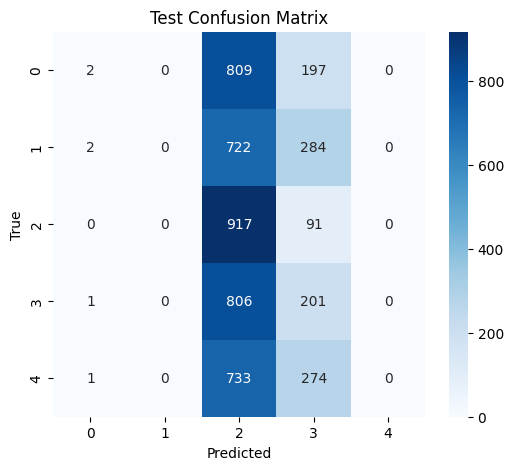

Test Accuracy: 22.22% | F1 Score: 0.1133


In [ ]:
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from transformers import ASTFeatureExtractor, AutoModelForAudioClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from copy import deepcopy

import seaborn as sns
import matplotlib.pyplot as plt


class AddNoiseTransform(nn.Module):
    """
    Adds random Gaussian noise to a waveform.
    This is a simple example of waveform-level augmentation.
    """
    def __init__(self, noise_level=0.02):
        super().__init__()
        self.noise_level = noise_level

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        noise = torch.randn_like(waveform) * self.noise_level
        return waveform + noise


class AudioWaveformDataset(Dataset):
    """
    Dataset for raw waveforms, with optional waveform-level transform (e.g., noise injection).
    Ensures the label is cast to torch.long for CrossEntropyLoss compatibility.
    """
    def __init__(self, waveforms, labels, transform=None):
        """
        Args:
          waveforms: list/array of 1D waveforms. shape e.g. [num_samples]
          labels: list/array of integer labels
          transform: optional transform function (e.g. AddNoiseTransform)
        """
        self.waveforms = waveforms
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.waveforms)

    def __getitem__(self, idx):
        waveform = torch.tensor(self.waveforms[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        if self.transform is not None:
            waveform = self.transform(waveform)

        return waveform, label


class AudioModelTrainerGlobal:
    def __init__(
        self,
        train_waveforms, train_labels,
        val_waveforms, val_labels,
        test_waveforms, test_labels,
        model_path,
        num_classes=5,
        lr=1e-5,
        weight_decay=1e-5,
        batch_size=32,
        step_size=5,
        gamma=0.1
    ):
        """
        Args:
          train_waveforms, train_labels: training data
          val_waveforms,   val_labels:   validation data
          test_waveforms,  test_labels:  test data
          model_path: model checkpoint (e.g. 'MIT/ast-finetuned-audioset-10-10-0.4593')
          num_classes: number of classes for classification head
          lr: initial learning rate
          weight_decay: weight decay for AdamW
          batch_size: batch size
          step_size: how often to reduce LR
          gamma: factor by which LR is reduced at step_size intervals
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.batch_size = batch_size
        self.loss_fn = nn.CrossEntropyLoss()

        self.extractor = ASTFeatureExtractor()

        self.train_transform = AddNoiseTransform(noise_level=0.02)
        self.val_transform = None

        self.train_dataset = AudioWaveformDataset(train_waveforms, train_labels, transform=self.train_transform)
        self.val_dataset   = AudioWaveformDataset(val_waveforms,   val_labels,   transform=self.val_transform)
        self.test_dataset  = AudioWaveformDataset(test_waveforms,  test_labels,  transform=self.val_transform)

        self.train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)
        self.val_loader   = DataLoader(self.val_dataset,   batch_size=batch_size, shuffle=False)
        self.test_loader  = DataLoader(self.test_dataset,  batch_size=batch_size, shuffle=False)

        self.model = AutoModelForAudioClassification.from_pretrained(model_path)
        self.model.classifier.dense = nn.Linear(self.model.classifier.dense.in_features, num_classes)
        self.model.to(self.device)

        self.optimizer = optim.AdamW(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=step_size, gamma=gamma)

    def _extract_features(self, waveform_batch):
        """
        Use ASTFeatureExtractor on a batch of waveforms.
        Input shape: (batch_size, waveform_length)
        Output: A dict with 'input_values' to feed into the model.
        """
        waveforms_list = [w.cpu().numpy() for w in waveform_batch]
        features = self.extractor(
            waveforms_list,
            sampling_rate=16000,
            padding="max_length",
            return_tensors="pt"
        )
        return features["input_values"].to(self.device)

    def train(self, epochs=30, patience=5):
        best_val_loss = float("inf")
        best_state = None
        no_improve = 0

        for epoch in range(epochs):
            self.model.train()
            running_loss, correct, total = 0.0, 0, 0

            for waveforms, labels in self.train_loader:
                waveforms, labels = waveforms.to(self.device), labels.to(self.device)
                input_values = self._extract_features(waveforms)

                self.optimizer.zero_grad()
                outputs = self.model(input_values)
                logits = outputs.logits

                loss = self.loss_fn(logits, labels)
                loss.backward()
                self.optimizer.step()

                preds = logits.argmax(dim=-1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                running_loss += loss.item() * labels.size(0)

            train_acc = 100.0 * correct / total
            avg_train_loss = running_loss / total

            self.model.eval()
            val_loss_sum, val_total = 0.0, 0

            with torch.no_grad():
                for waveforms_val, labels_val in self.val_loader:
                    waveforms_val, labels_val = waveforms_val.to(self.device), labels_val.to(self.device)
                    val_input_values = self._extract_features(waveforms_val)

                    logits_val = self.model(val_input_values).logits
                    val_loss = self.loss_fn(logits_val, labels_val)

                    val_loss_sum += val_loss.item() * labels_val.size(0)
                    val_total += labels_val.size(0)

            avg_val_loss = val_loss_sum / val_total
            self.scheduler.step()

            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss={avg_train_loss:.4f}, Train Acc={train_acc:.2f}% | "
                  f"Val Loss={avg_val_loss:.4f}")

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_state = deepcopy(self.model.state_dict())
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        if best_state:
            self.model.load_state_dict(best_state)

    def evaluate(self):
        self.model.eval()
        all_preds, all_labels = [], []
        correct, total = 0, 0

        with torch.no_grad():
            for waveforms_test, labels_test in self.test_loader:
                waveforms_test = waveforms_test.to(self.device)
                labels_test = labels_test.to(self.device)

                test_input_values = self._extract_features(waveforms_test)
                logits_test = self.model(test_input_values).logits
                preds_test = logits_test.argmax(dim=-1)

                all_preds.append(preds_test.cpu().numpy())
                all_labels.append(labels_test.cpu().numpy())
                correct += (preds_test == labels_test).sum().item()
                total += labels_test.size(0)

        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)

        acc = 100.0 * correct / total
        f1 = f1_score(all_labels, all_preds, average='weighted')

        cm = confusion_matrix(all_labels, all_preds)

        plt.figure(figsize=(6,5))
        ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        ax.set_title("Test Confusion Matrix")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")

        n_labels = cm.shape[0]  # should be 5 for a 5-class problem
        ax.xaxis.set_ticklabels(range(n_labels))
        ax.yaxis.set_ticklabels(range(n_labels))

        plt.show()

        print(f"Test Accuracy: {acc:.2f}% | F1 Score: {f1:.4f}")
        return acc, f1


if __name__ == "__main__":
    audio_dir = "/content/drive/MyDrive/kk/Input_images/Audio"
    model_path = "MIT/ast-finetuned-audioset-10-10-0.4593"

    all_train_X, all_train_y = [], []
    all_test_X, all_test_y = [], []

    for sub in range(1, 43):
        file_name = f"subject_{sub:02d}_aud.pkl"
        file_path = os.path.join(audio_dir, file_name)
        if not os.path.exists(file_path):
            continue
        with open(file_path, "rb") as f:
            tr_x, tr_y, te_x, te_y = pickle.load(f)
        all_train_X.extend(tr_x)
        all_train_y.extend(tr_y)
        all_test_X.extend(te_x)
        all_test_y.extend(te_y)

    print(f"Total Training Samples: {len(all_train_X)}")
    print(f"Total Test Samples: {len(all_test_X)}")

    train_X, val_X, train_y, val_y = train_test_split(
        all_train_X, all_train_y,
        test_size=0.3,
        random_state=42,
        stratify=all_train_y
    )

    trainer = AudioModelTrainerGlobal(
        train_waveforms=train_X,
        train_labels=train_y,
        val_waveforms=val_X,
        val_labels=val_y,
        test_waveforms=all_test_X,
        test_labels=all_test_y,
        model_path=model_path,
        num_classes=5,    # sets final layer to 5 classes
        lr=1e-6,
        weight_decay=1e-5,
        batch_size=32,
        step_size=5,
        gamma=0.1
    )

    trainer.train(epochs=50, patience=10)
    acc, f1 = trainer.evaluate()
